**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense

In [2]:
# Dataset Link: https://www.kaggle.com/c/fake-news

# Reading data from csv
train = pd.read_csv("dataset-1/train.csv")
test  = pd.read_csv("dataset-1/test.csv")
train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [3]:
test.head()

id                                              title  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1  20801  Russian warships ready to strike terrorists ne...   
2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...  
1                      NaN  Russian warships ready to strike terrorists ne...  
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...  
3            Daniel Victor  If at first you don’t succeed, try a different...  
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...

In [4]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


**Checking Null Values**

In [5]:
# Checking the null values in training data.
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Checking the null values in testing data.
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [7]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [8]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+ train["author"]
test["merged"]  = test["title"]+" "+ test["author"]

In [9]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [10]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [11]:
messages["text"][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [12]:
messages.head()

index  id                                              title  \
0      0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1      1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      2   2                  Why the Truth Might Get You Fired   
3      3   3  15 Civilians Killed In Single US Airstrike Hav...   
4      4   4  Iranian woman jailed for fictional unpublished...   

               author                                               text  \
0       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...   
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...   
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...   
3     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...   
4      Howard Portnoy  Print \nAn Iranian woman has been sentenced to...   

                                              merged  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...  
2  Why the Truth Might Get You Fired Consortiumne...  
3  15 Civilians Killed In Single US Airstrike Hav...  
4  Iranian woman jailed for fictional unpublished...

In [13]:
messages_test.head()

index     id                                              title  \
0      0  20800  Specter of Trump Loosens Tongues, if Not Purse...   
1      1  20801  Russian warships ready to strike terrorists ne...   
2      2  20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3      3  20803  Tim Tebow Will Attempt Another Comeback, This ...   
4      4  20804                    Keiser Report: Meme Wars (E995)   

                    author                                               text  \
0         David Streitfeld  PALO ALTO, Calif.  —   After years of scorning...   
1                           Russian warships ready to strike terrorists ne...   
2            Common Dreams  Videos #NoDAPL: Native American Leaders Vow to...   
3            Daniel Victor  If at first you don’t succeed, try a different...   
4  Truth Broadcast Network  42 mins ago 1 Views 0 Comments 0 Likes 'For th...   

                                              merged  
0  Specter of Trump Loosens Tongues, if Not Purse...  
1  Russian warships ready to strike terrorists ne...  
2  #NoDAPL: Native American Leaders Vow to Stay A...  
3  Tim Tebow Will Attempt Another Comeback, This ...  
4  Keiser Report: Meme Wars (E995) Truth Broadcas...

# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [14]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [15]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [16]:
# Converting to one-hot repr.

vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [17]:
one_hot_test[1]

[2090, 4063, 1777, 3153, 959, 1163, 1464]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [18]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 1575  154 2017]
 [   0    0    0 ... 4592  746 4754]
 [   0    0    0 ... 1717 2992 1043]
 ...
 [   0    0    0 ... 4530 2824 4380]
 [   0    0    0 ...   54 4506 4022]
 [   0    0    0 ... 2529 1229 4284]]


In [19]:
embedd_docs_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0, 1551, 4090, 3772,
        645, 3447,  295, 4398, 3875,  262, 1575,  154, 2017])

In [20]:
print(embedd_docs_test)

[[   0    0    0 ... 2548 1229  712]
 [   0    0    0 ...  959 1163 1464]
 [   0    0    0 ... 2423 2960 3529]
 ...
 [   0    0    0 ... 2548 4457 4071]
 [   0    0    0 ... 2090 2349 3502]
 [   0    0    0 ... 2548 4908  591]]


In [21]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [22]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

## Baseline Models

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [25]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": MultinomialNB(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "XGBoost Classifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier(iterations=150)}

# Create a function to fit and score models
def fit_and_score(models, X_train, x_test, Y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn Machine Learning models
    X_train: Training data (no labels)
    X_test: Testing data (no labels)
    y_train: Training labels
    y_test: Test labels
    """
    
    # Set random seed
    np.random.seed(12)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, Y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
        
    return model_scores

In [26]:
model_scores = fit_and_score(models=models, X_train=X_train, x_test=x_test, Y_train=Y_train, y_test=y_test)
model_scores

C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.195972
0:	learn: 0.5689937	total: 206ms	remaining: 30.6s
1:	learn: 0.4544043	total: 215ms	remaining: 15.9s
2:	learn: 0.4166460	total: 224ms	remaining: 11s
3:	learn: 0.3858787	total: 234ms	remaining: 8.54s
4:	learn: 0.3545785	total: 243ms	remaining: 7.05s
5:	learn: 0.3411673	total: 253ms	remaining: 6.07s
6:	learn: 0.3336186	total: 262ms	remaining: 5.35s
7:	learn: 0.3227788	total: 271ms	remaining: 4.81s
8:	learn: 0.3173263	total: 280ms	remaining: 4.39s
9:	learn: 0.3105233	total: 289ms	remaining: 4.05s
10:	learn: 0.3058805	total: 298ms	remaining: 3.77s
11:	learn: 0.2985761	total: 307ms	remaining: 3.53s
12:	learn: 0.2906887	total: 316ms	remaining: 3.33s
13:	learn: 0.2860731	total: 325ms	remaining: 3.16s
14:	learn: 0.2828754	total: 334ms	remaining: 3s
15:	learn: 0.2772015	total: 343ms	remaining: 2.87s
16:	learn: 0.2718344	total: 352ms	remaining: 2.75s
17:	learn: 0.2631715	total: 361ms	remaining: 2.65s
18:	learn: 0.2574115	total: 370ms	remaining: 2.55s
19:	learn: 0.255

{'Logistic Regression': 0.7177884615384615,
 'KNN': 0.7581730769230769,
 'Random Forest': 0.9096153846153846,
 'Naive Bayes': 0.6956730769230769,
 'Decision Tree Classifier': 0.8942307692307693,
 'XGBoost Classifier': 0.9105769230769231,
 'CatBoost Classifier': 0.9754807692307692}

**LSTM**

**In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.**

In [27]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
264/264 [==============================] - 6s 16ms/step - loss: 0.3731 - accuracy: 0.8237 - val_loss: 0.0383 - val_accuracy: 0.9866
Epoch 2/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0270 - accuracy: 0.9922 - val_loss: 0.0206 - val_accuracy: 0.9947
Epoch 3/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0370 - val_accuracy: 0.9915
Epoch 4/10
264/264 [==============================] - 5s 17ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0301 - val_accuracy: 0.9909
Epoch 5/10
264/264 [==============================] - 5s 17ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0397 - val_accuracy: 0.9920
Epoch 6/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0335 - val_accuracy: 0.9925
Epoch 7/10
264/264 [==============================] - 4s 16ms/step - loss: 7.6220e-04 - accuracy: 0.9999 - val_loss: 0.0322 - val_accuracy: 0.

In [29]:
# predictions = model.predict_classes(x_test)
# cr = classification_report(y_test,predictions)
# print(cr)

predictions = model.predict_classes(x_test)
score_lstm = accuracy_score(y_test,predictions)
score_lstm

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9860576923076924

In [30]:
y_preds = model.predict_classes(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.9860576923076924
0.9922178988326849
0.9798270893371758
0.985983566940551


C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


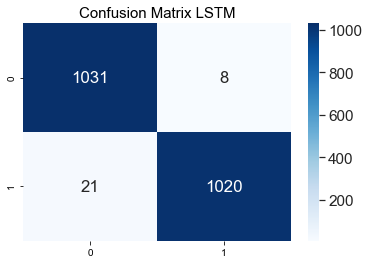

In [31]:
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix LSTM', fontdict=title_font);
plt.savefig('plot_LSTM_1.png', dpi=300, bbox_inches='tight')

In [32]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare["LSTM"] = score_lstm
model_compare = model_compare.T.sort_values(by="Accuracy").T

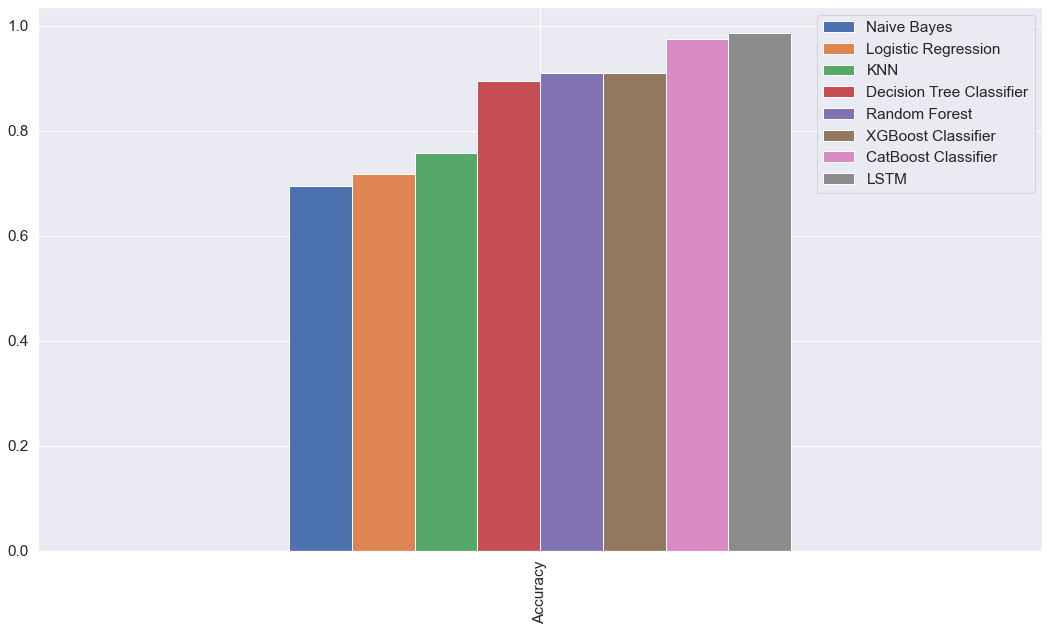

In [33]:
model_compare.plot(kind="bar", figsize=(18, 10));
plt.savefig('plot_model_compare_1.png', dpi=300, bbox_inches='tight')

In [34]:
model_compare

Naive Bayes  Logistic Regression       KNN  \
Accuracy     0.695673             0.717788  0.758173   

          Decision Tree Classifier  Random Forest  XGBoost Classifier  \
Accuracy                  0.894231       0.909615            0.910577   

          CatBoost Classifier      LSTM  
Accuracy             0.975481  0.986058

In [35]:
# model_compare.plot(kind="bar", color=['blue', 'red','pink','green', 'cyan', 'yellow', 'black','orange'], figsize=(20, 10));

# Classification Report For Baseline Models That Are Not Hyperparameter Tuned

In [36]:
# CR for Logistic Regression
clf = LogisticRegression()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.7177884615384615


C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.7177884615384615
0.739451476793249
0.6733909702209414
0.7048768225238813


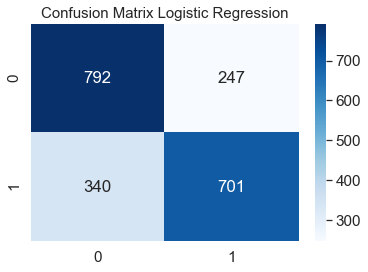

In [38]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix Logistic Regression', fontdict=title_font);
plt.savefig('plot_Logistic_Regression_1.png', dpi=300, bbox_inches='tight')

In [39]:
# CR for NaiveBayes
clf = MultinomialNB()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.6956730769230769


In [40]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.6956730769230769
0.6786339754816112
0.74447646493756
0.7100320659642693


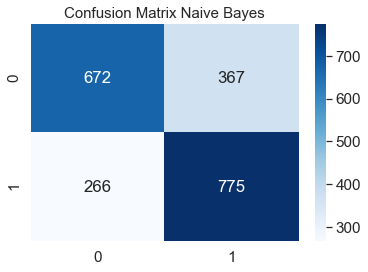

In [41]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix Naive Bayes', fontdict=title_font);
plt.savefig('plot_Naive_Bayes_1.png', dpi=300, bbox_inches='tight')

In [42]:
# CR for KNN
clf = KNeighborsClassifier()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.7581730769230769


In [43]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.7581730769230769
0.8008948545861297
0.6878001921229587
0.7400516795865634


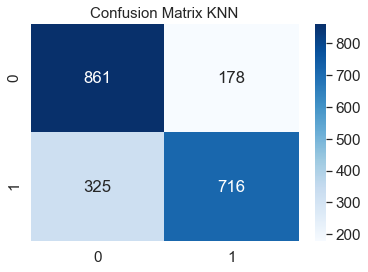

In [44]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix KNN', fontdict=title_font);
plt.savefig('plot_KNN_1.png', dpi=300, bbox_inches='tight')

## RandomizedSearch CV

### Only trying this on RF, CatBoost, XGBoost and Decision Trees

In [45]:
# Create a hyperparameter grid for RandomForestClassifier
rfc_grid = {"n_estimators": np.arange(0, 300, 150),
           "max_depth": [None, 1],
           "min_samples_split": np.arange(7, 9, 1),
           "min_samples_leaf": np.arange(0, 2, 1),
           "bootstrap": [False]}

# Create a hyperparameter grid for DecisionTreesClassifier
dtc_grid = {"max_depth": np.arange(80, 100, 1),
           "min_samples_split": np.arange(1, 30, 1),
           "min_samples_leaf": np.arange(1, 5, 1),
           "max_leaf_nodes": np.arange(95, 100, 1),
           "criterion": ["gini", "entropy"]}

# Create a hyperparameter grid for XGBoostClassifier
xgb_grid = {"max_depth" : np.arange(70, 100, 1),
            "learning_rate" : [0.1, 0.11, 0.12, 0.15, 0.2],
            "n_estimators" : np.arange(700, 800, 10),
            "verbosity" : [0, 1],
            "min_child_weight": [1, 3],
            "subsample": [0.5, 0.7],
            "colsample_bytree": [0.5, 0.7]}

# Create a hyperparameter grid for CatBoostClassifier
catb_grid = {'depth':[8, 9, 10],
             'iterations':[500, 1000],
             'learning_rate':[0.2, 0.3], 
             'l2_leaf_reg':[3, 1, 5, 10],
             'border_count':[100, 200],
             'thread_count': [4]}

In [46]:
# Tune RFC
np.random.seed(12)

# Setup random hyperparameeter search for RFC
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rfc_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for RFC
rs_rfc.fit(X_train, Y_train)

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 349, in fit
    self._validate_estimator()
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_base.py", line 134, in _validate_estimator
    "got {0}.".format(self.n_estimators))
ValueError: n_estim

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 349, in fit
    self._validate_estimator()
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_base.py", line 134, in _validate_estimator
    "got {0}.".format(self.n_estimators))
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details:

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 349, in fit
    self._validate_estimator()
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_base.py", line 134, in _validate_estimator
    "got {0}.".format(self.n_estimators))
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details:

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [None, 1],
                                        'min_samples_leaf': array([0, 1]),
                                        'min_samples_split': array([7, 8]),
                                        'n_estimators': array([  0, 150])},
                   verbose=True)

In [47]:
# Find the best hyperparameters
rs_rfc.best_params_

{'n_estimators': 150,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': False}

In [48]:
# Best score
rs_rfc.score(x_test, y_test)

0.9149038461538461

In [49]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for DecisionTreeClassifier
rs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dtc_grid,
                           cv=5,
                           n_iter=50,
                           verbose=True)

# Fit the random hyperparameter search model for DecisionTreeClassifier()
rs_dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99]),
                                        'max_leaf_nodes': array([95, 96, 97, 98, 99]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   verbose=True)

In [50]:
# Find the best hyperparameters
rs_dtc.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 98,
 'max_depth': 88,
 'criterion': 'entropy'}

In [51]:
# Best score
rs_dtc.score(x_test, y_test)

0.9052884615384615

In [52]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=xgb_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.1, 0.11, 0.12, 0.15,
                                                          0.2],
                                        'max_depth': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'min_child_weight': [1, 3],
                                        'n_estimators': array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790]),
                                        'subsample': [0.5, 0.7],
                                        'verbosity': [0, 1]},
                   verbose=True)

In [53]:
# Find the best hyperparameters
rs_xgb.best_params_

{'verbosity': 0,
 'subsample': 0.7,
 'n_estimators': 780,
 'min_child_weight': 1,
 'max_depth': 86,
 'learning_rate': 0.11,
 'colsample_bytree': 0.5}

In [54]:
# Best score
rs_xgb.score(x_test, y_test)

0.9788461538461538

In [55]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for CatBoost Classifier
rs_cbc = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions = catb_grid,
                           cv=5,
                           n_iter=20,
                           verbose = True)

# Fit the random hyperparameter search model for CatBoostClassifier()
rs_cbc.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.5179426	total: 49ms	remaining: 24.4s
1:	learn: 0.4445353	total: 85.5ms	remaining: 21.3s
2:	learn: 0.3874581	total: 122ms	remaining: 20.2s
3:	learn: 0.3605530	total: 155ms	remaining: 19.2s
4:	learn: 0.3341415	total: 187ms	remaining: 18.5s
5:	learn: 0.3228410	total: 220ms	remaining: 18.1s
6:	learn: 0.3057139	total: 256ms	remaining: 18s
7:	learn: 0.2951959	total: 289ms	remaining: 17.8s
8:	learn: 0.2863403	total: 323ms	remaining: 17.6s
9:	learn: 0.2763988	total: 360ms	remaining: 17.6s
10:	learn: 0.2692771	total: 393ms	remaining: 17.5s
11:	learn: 0.2635811	total: 427ms	remaining: 17.4s
12:	learn: 0.2563053	total: 458ms	remaining: 17.2s
13:	learn: 0.2493615	total: 493ms	remaining: 17.1s
14:	learn: 0.2422875	total: 526ms	remaining: 17s
15:	learn: 0.2369977	total: 559ms	remaining: 16.9s
16:	learn: 0.2316903	total: 596ms	remaining: 16.9s
17:	learn: 0.2274673	total: 632ms	remaining: 16.9s
18:	learn: 0.2208664	total: 666ms	

164:	learn: 0.0361929	total: 5.74s	remaining: 11.6s
165:	learn: 0.0358569	total: 5.77s	remaining: 11.6s
166:	learn: 0.0355669	total: 5.8s	remaining: 11.6s
167:	learn: 0.0354141	total: 5.84s	remaining: 11.5s
168:	learn: 0.0351671	total: 5.88s	remaining: 11.5s
169:	learn: 0.0348205	total: 5.92s	remaining: 11.5s
170:	learn: 0.0345783	total: 5.96s	remaining: 11.5s
171:	learn: 0.0343704	total: 5.99s	remaining: 11.4s
172:	learn: 0.0343228	total: 6.03s	remaining: 11.4s
173:	learn: 0.0340219	total: 6.06s	remaining: 11.4s
174:	learn: 0.0336078	total: 6.1s	remaining: 11.3s
175:	learn: 0.0332756	total: 6.13s	remaining: 11.3s
176:	learn: 0.0330465	total: 6.17s	remaining: 11.3s
177:	learn: 0.0328145	total: 6.21s	remaining: 11.2s
178:	learn: 0.0324735	total: 6.25s	remaining: 11.2s
179:	learn: 0.0322424	total: 6.29s	remaining: 11.2s
180:	learn: 0.0320255	total: 6.32s	remaining: 11.1s
181:	learn: 0.0316711	total: 6.36s	remaining: 11.1s
182:	learn: 0.0314047	total: 6.4s	remaining: 11.1s
183:	learn: 0.0

326:	learn: 0.0136906	total: 12.3s	remaining: 6.51s
327:	learn: 0.0136401	total: 12.3s	remaining: 6.47s
328:	learn: 0.0136176	total: 12.4s	remaining: 6.43s
329:	learn: 0.0135736	total: 12.4s	remaining: 6.4s
330:	learn: 0.0135262	total: 12.5s	remaining: 6.36s
331:	learn: 0.0134841	total: 12.5s	remaining: 6.33s
332:	learn: 0.0134474	total: 12.5s	remaining: 6.29s
333:	learn: 0.0134167	total: 12.6s	remaining: 6.25s
334:	learn: 0.0133356	total: 12.6s	remaining: 6.22s
335:	learn: 0.0133167	total: 12.7s	remaining: 6.18s
336:	learn: 0.0132108	total: 12.7s	remaining: 6.14s
337:	learn: 0.0131255	total: 12.7s	remaining: 6.11s
338:	learn: 0.0130884	total: 12.8s	remaining: 6.07s
339:	learn: 0.0130549	total: 12.8s	remaining: 6.03s
340:	learn: 0.0129720	total: 12.9s	remaining: 6s
341:	learn: 0.0129719	total: 12.9s	remaining: 5.96s
342:	learn: 0.0129428	total: 12.9s	remaining: 5.92s
343:	learn: 0.0129383	total: 13s	remaining: 5.88s
344:	learn: 0.0128570	total: 13s	remaining: 5.84s
345:	learn: 0.012784

485:	learn: 0.0085081	total: 18.5s	remaining: 532ms
486:	learn: 0.0084693	total: 18.5s	remaining: 494ms
487:	learn: 0.0084693	total: 18.5s	remaining: 456ms
488:	learn: 0.0084565	total: 18.6s	remaining: 418ms
489:	learn: 0.0083957	total: 18.6s	remaining: 380ms
490:	learn: 0.0083636	total: 18.6s	remaining: 342ms
491:	learn: 0.0083636	total: 18.7s	remaining: 304ms
492:	learn: 0.0083636	total: 18.7s	remaining: 266ms
493:	learn: 0.0083396	total: 18.8s	remaining: 228ms
494:	learn: 0.0083396	total: 18.8s	remaining: 190ms
495:	learn: 0.0083396	total: 18.8s	remaining: 152ms
496:	learn: 0.0082916	total: 18.9s	remaining: 114ms
497:	learn: 0.0082623	total: 18.9s	remaining: 75.9ms
498:	learn: 0.0082291	total: 18.9s	remaining: 38ms
499:	learn: 0.0081881	total: 19s	remaining: 0us
0:	learn: 0.5207340	total: 40.5ms	remaining: 20.2s
1:	learn: 0.4550408	total: 80.3ms	remaining: 20s
2:	learn: 0.4004944	total: 119ms	remaining: 19.7s
3:	learn: 0.3643992	total: 156ms	remaining: 19.3s
4:	learn: 0.3411226	tota

147:	learn: 0.0466123	total: 5.64s	remaining: 13.4s
148:	learn: 0.0462006	total: 5.68s	remaining: 13.4s
149:	learn: 0.0457124	total: 5.72s	remaining: 13.3s
150:	learn: 0.0451847	total: 5.76s	remaining: 13.3s
151:	learn: 0.0446056	total: 5.8s	remaining: 13.3s
152:	learn: 0.0439964	total: 5.84s	remaining: 13.2s
153:	learn: 0.0431676	total: 5.88s	remaining: 13.2s
154:	learn: 0.0426307	total: 5.91s	remaining: 13.2s
155:	learn: 0.0423851	total: 5.96s	remaining: 13.1s
156:	learn: 0.0420946	total: 6s	remaining: 13.1s
157:	learn: 0.0415954	total: 6.04s	remaining: 13.1s
158:	learn: 0.0413467	total: 6.08s	remaining: 13s
159:	learn: 0.0411031	total: 6.12s	remaining: 13s
160:	learn: 0.0408626	total: 6.16s	remaining: 13s
161:	learn: 0.0407258	total: 6.2s	remaining: 12.9s
162:	learn: 0.0405753	total: 6.23s	remaining: 12.9s
163:	learn: 0.0402638	total: 6.27s	remaining: 12.9s
164:	learn: 0.0399636	total: 6.31s	remaining: 12.8s
165:	learn: 0.0397090	total: 6.35s	remaining: 12.8s
166:	learn: 0.0391922	t

309:	learn: 0.0160354	total: 12.2s	remaining: 7.47s
310:	learn: 0.0159254	total: 12.2s	remaining: 7.43s
311:	learn: 0.0158588	total: 12.3s	remaining: 7.39s
312:	learn: 0.0157648	total: 12.3s	remaining: 7.35s
313:	learn: 0.0156780	total: 12.3s	remaining: 7.31s
314:	learn: 0.0155855	total: 12.4s	remaining: 7.28s
315:	learn: 0.0155010	total: 12.4s	remaining: 7.24s
316:	learn: 0.0154284	total: 12.5s	remaining: 7.21s
317:	learn: 0.0153772	total: 12.5s	remaining: 7.17s
318:	learn: 0.0152672	total: 12.6s	remaining: 7.13s
319:	learn: 0.0152105	total: 12.6s	remaining: 7.09s
320:	learn: 0.0150375	total: 12.7s	remaining: 7.06s
321:	learn: 0.0149731	total: 12.7s	remaining: 7.02s
322:	learn: 0.0148931	total: 12.8s	remaining: 6.99s
323:	learn: 0.0148045	total: 12.8s	remaining: 6.95s
324:	learn: 0.0147211	total: 12.8s	remaining: 6.92s
325:	learn: 0.0147137	total: 12.9s	remaining: 6.88s
326:	learn: 0.0146339	total: 12.9s	remaining: 6.84s
327:	learn: 0.0145812	total: 13s	remaining: 6.81s
328:	learn: 0.

468:	learn: 0.0100426	total: 17.4s	remaining: 1.15s
469:	learn: 0.0100015	total: 17.5s	remaining: 1.11s
470:	learn: 0.0099747	total: 17.5s	remaining: 1.08s
471:	learn: 0.0099456	total: 17.6s	remaining: 1.04s
472:	learn: 0.0099077	total: 17.6s	remaining: 1s
473:	learn: 0.0098772	total: 17.6s	remaining: 967ms
474:	learn: 0.0098596	total: 17.7s	remaining: 931ms
475:	learn: 0.0098131	total: 17.7s	remaining: 894ms
476:	learn: 0.0097971	total: 17.8s	remaining: 856ms
477:	learn: 0.0097758	total: 17.8s	remaining: 820ms
478:	learn: 0.0097350	total: 17.9s	remaining: 783ms
479:	learn: 0.0097075	total: 17.9s	remaining: 745ms
480:	learn: 0.0097034	total: 17.9s	remaining: 708ms
481:	learn: 0.0096807	total: 18s	remaining: 671ms
482:	learn: 0.0096605	total: 18s	remaining: 634ms
483:	learn: 0.0096192	total: 18s	remaining: 596ms
484:	learn: 0.0095738	total: 18.1s	remaining: 559ms
485:	learn: 0.0095736	total: 18.1s	remaining: 522ms
486:	learn: 0.0095131	total: 18.1s	remaining: 484ms
487:	learn: 0.0094460

130:	learn: 0.0474691	total: 5.61s	remaining: 15.8s
131:	learn: 0.0468586	total: 5.66s	remaining: 15.8s
132:	learn: 0.0464603	total: 5.72s	remaining: 15.8s
133:	learn: 0.0459321	total: 5.77s	remaining: 15.8s
134:	learn: 0.0455090	total: 5.83s	remaining: 15.8s
135:	learn: 0.0454103	total: 5.88s	remaining: 15.7s
136:	learn: 0.0449488	total: 5.93s	remaining: 15.7s
137:	learn: 0.0445014	total: 5.98s	remaining: 15.7s
138:	learn: 0.0440392	total: 6.03s	remaining: 15.7s
139:	learn: 0.0438351	total: 6.08s	remaining: 15.6s
140:	learn: 0.0435131	total: 6.13s	remaining: 15.6s
141:	learn: 0.0433607	total: 6.18s	remaining: 15.6s
142:	learn: 0.0430661	total: 6.24s	remaining: 15.6s
143:	learn: 0.0427321	total: 6.29s	remaining: 15.5s
144:	learn: 0.0424089	total: 6.34s	remaining: 15.5s
145:	learn: 0.0421750	total: 6.38s	remaining: 15.5s
146:	learn: 0.0416906	total: 6.42s	remaining: 15.4s
147:	learn: 0.0414124	total: 6.46s	remaining: 15.4s
148:	learn: 0.0410355	total: 6.51s	remaining: 15.3s
149:	learn: 

291:	learn: 0.0168725	total: 12.5s	remaining: 8.91s
292:	learn: 0.0167994	total: 12.6s	remaining: 8.87s
293:	learn: 0.0167994	total: 12.6s	remaining: 8.82s
294:	learn: 0.0167994	total: 12.6s	remaining: 8.77s
295:	learn: 0.0167988	total: 12.6s	remaining: 8.71s
296:	learn: 0.0167058	total: 12.7s	remaining: 8.67s
297:	learn: 0.0166146	total: 12.7s	remaining: 8.63s
298:	learn: 0.0166070	total: 12.8s	remaining: 8.58s
299:	learn: 0.0165625	total: 12.8s	remaining: 8.54s
300:	learn: 0.0165532	total: 12.9s	remaining: 8.5s
301:	learn: 0.0164900	total: 12.9s	remaining: 8.46s
302:	learn: 0.0164445	total: 12.9s	remaining: 8.41s
303:	learn: 0.0162165	total: 13s	remaining: 8.37s
304:	learn: 0.0161602	total: 13s	remaining: 8.32s
305:	learn: 0.0160652	total: 13.1s	remaining: 8.28s
306:	learn: 0.0160006	total: 13.1s	remaining: 8.24s
307:	learn: 0.0159308	total: 13.1s	remaining: 8.2s
308:	learn: 0.0159308	total: 13.2s	remaining: 8.15s
309:	learn: 0.0157989	total: 13.2s	remaining: 8.1s
310:	learn: 0.01579

454:	learn: 0.0124192	total: 18.2s	remaining: 1.8s
455:	learn: 0.0123549	total: 18.3s	remaining: 1.76s
456:	learn: 0.0123548	total: 18.3s	remaining: 1.72s
457:	learn: 0.0122571	total: 18.3s	remaining: 1.68s
458:	learn: 0.0122262	total: 18.4s	remaining: 1.64s
459:	learn: 0.0121935	total: 18.4s	remaining: 1.6s
460:	learn: 0.0121394	total: 18.4s	remaining: 1.56s
461:	learn: 0.0120798	total: 18.5s	remaining: 1.52s
462:	learn: 0.0120798	total: 18.5s	remaining: 1.48s
463:	learn: 0.0120798	total: 18.5s	remaining: 1.44s
464:	learn: 0.0120798	total: 18.6s	remaining: 1.4s
465:	learn: 0.0120470	total: 18.6s	remaining: 1.36s
466:	learn: 0.0120470	total: 18.6s	remaining: 1.32s
467:	learn: 0.0119397	total: 18.7s	remaining: 1.28s
468:	learn: 0.0119197	total: 18.7s	remaining: 1.24s
469:	learn: 0.0118825	total: 18.8s	remaining: 1.2s
470:	learn: 0.0118413	total: 18.8s	remaining: 1.16s
471:	learn: 0.0117575	total: 18.8s	remaining: 1.12s
472:	learn: 0.0117059	total: 18.9s	remaining: 1.08s
473:	learn: 0.01

117:	learn: 0.0534768	total: 4.71s	remaining: 15.3s
118:	learn: 0.0527519	total: 4.75s	remaining: 15.2s
119:	learn: 0.0524460	total: 4.79s	remaining: 15.2s
120:	learn: 0.0519734	total: 4.83s	remaining: 15.1s
121:	learn: 0.0510203	total: 4.87s	remaining: 15.1s
122:	learn: 0.0503144	total: 4.9s	remaining: 15s
123:	learn: 0.0496548	total: 4.95s	remaining: 15s
124:	learn: 0.0492269	total: 4.99s	remaining: 15s
125:	learn: 0.0488008	total: 5.02s	remaining: 14.9s
126:	learn: 0.0483097	total: 5.07s	remaining: 14.9s
127:	learn: 0.0478870	total: 5.1s	remaining: 14.8s
128:	learn: 0.0476861	total: 5.14s	remaining: 14.8s
129:	learn: 0.0474900	total: 5.18s	remaining: 14.8s
130:	learn: 0.0469891	total: 5.23s	remaining: 14.7s
131:	learn: 0.0463362	total: 5.27s	remaining: 14.7s
132:	learn: 0.0460443	total: 5.31s	remaining: 14.6s
133:	learn: 0.0456648	total: 5.35s	remaining: 14.6s
134:	learn: 0.0453317	total: 5.38s	remaining: 14.6s
135:	learn: 0.0447308	total: 5.43s	remaining: 14.5s
136:	learn: 0.044274

281:	learn: 0.0161588	total: 11.3s	remaining: 8.74s
282:	learn: 0.0161204	total: 11.4s	remaining: 8.71s
283:	learn: 0.0160142	total: 11.4s	remaining: 8.67s
284:	learn: 0.0159832	total: 11.4s	remaining: 8.63s
285:	learn: 0.0158951	total: 11.5s	remaining: 8.58s
286:	learn: 0.0158171	total: 11.5s	remaining: 8.54s
287:	learn: 0.0157475	total: 11.6s	remaining: 8.5s
288:	learn: 0.0157184	total: 11.6s	remaining: 8.46s
289:	learn: 0.0156359	total: 11.6s	remaining: 8.42s
290:	learn: 0.0155819	total: 11.7s	remaining: 8.38s
291:	learn: 0.0155395	total: 11.7s	remaining: 8.34s
292:	learn: 0.0154571	total: 11.7s	remaining: 8.29s
293:	learn: 0.0152958	total: 11.8s	remaining: 8.25s
294:	learn: 0.0151815	total: 11.8s	remaining: 8.21s
295:	learn: 0.0150873	total: 11.9s	remaining: 8.17s
296:	learn: 0.0149988	total: 11.9s	remaining: 8.13s
297:	learn: 0.0148574	total: 11.9s	remaining: 8.09s
298:	learn: 0.0148097	total: 12s	remaining: 8.05s
299:	learn: 0.0147101	total: 12s	remaining: 8.01s
300:	learn: 0.014

445:	learn: 0.0087876	total: 17.7s	remaining: 2.14s
446:	learn: 0.0087560	total: 17.7s	remaining: 2.1s
447:	learn: 0.0087260	total: 17.7s	remaining: 2.06s
448:	learn: 0.0087259	total: 17.8s	remaining: 2.02s
449:	learn: 0.0087259	total: 17.8s	remaining: 1.98s
450:	learn: 0.0087064	total: 17.8s	remaining: 1.94s
451:	learn: 0.0086794	total: 17.9s	remaining: 1.9s
452:	learn: 0.0086675	total: 17.9s	remaining: 1.86s
453:	learn: 0.0086509	total: 18s	remaining: 1.82s
454:	learn: 0.0085984	total: 18s	remaining: 1.78s
455:	learn: 0.0085984	total: 18s	remaining: 1.74s
456:	learn: 0.0085764	total: 18.1s	remaining: 1.7s
457:	learn: 0.0085404	total: 18.1s	remaining: 1.66s
458:	learn: 0.0085256	total: 18.1s	remaining: 1.62s
459:	learn: 0.0085256	total: 18.2s	remaining: 1.58s
460:	learn: 0.0085255	total: 18.2s	remaining: 1.54s
461:	learn: 0.0085060	total: 18.2s	remaining: 1.5s
462:	learn: 0.0084941	total: 18.3s	remaining: 1.46s
463:	learn: 0.0084797	total: 18.3s	remaining: 1.42s
464:	learn: 0.0084497	

109:	learn: 0.0575440	total: 4.61s	remaining: 16.4s
110:	learn: 0.0567152	total: 4.66s	remaining: 16.3s
111:	learn: 0.0566375	total: 4.7s	remaining: 16.3s
112:	learn: 0.0565247	total: 4.74s	remaining: 16.2s
113:	learn: 0.0557476	total: 4.78s	remaining: 16.2s
114:	learn: 0.0548861	total: 4.82s	remaining: 16.1s
115:	learn: 0.0544433	total: 4.87s	remaining: 16.1s
116:	learn: 0.0539231	total: 4.91s	remaining: 16.1s
117:	learn: 0.0535187	total: 4.95s	remaining: 16s
118:	learn: 0.0527076	total: 5s	remaining: 16s
119:	learn: 0.0522538	total: 5.04s	remaining: 16s
120:	learn: 0.0514759	total: 5.08s	remaining: 15.9s
121:	learn: 0.0506739	total: 5.12s	remaining: 15.9s
122:	learn: 0.0501563	total: 5.17s	remaining: 15.8s
123:	learn: 0.0495531	total: 5.21s	remaining: 15.8s
124:	learn: 0.0490375	total: 5.25s	remaining: 15.8s
125:	learn: 0.0486702	total: 5.29s	remaining: 15.7s
126:	learn: 0.0486284	total: 5.34s	remaining: 15.7s
127:	learn: 0.0480478	total: 5.39s	remaining: 15.7s
128:	learn: 0.0476002	

268:	learn: 0.0180332	total: 11.5s	remaining: 9.83s
269:	learn: 0.0178401	total: 11.5s	remaining: 9.79s
270:	learn: 0.0178339	total: 11.5s	remaining: 9.74s
271:	learn: 0.0177246	total: 11.6s	remaining: 9.69s
272:	learn: 0.0176715	total: 11.6s	remaining: 9.65s
273:	learn: 0.0176435	total: 11.6s	remaining: 9.6s
274:	learn: 0.0175492	total: 11.7s	remaining: 9.56s
275:	learn: 0.0175492	total: 11.7s	remaining: 9.49s
276:	learn: 0.0175492	total: 11.7s	remaining: 9.42s
277:	learn: 0.0175492	total: 11.7s	remaining: 9.37s
278:	learn: 0.0175491	total: 11.8s	remaining: 9.32s
279:	learn: 0.0175491	total: 11.8s	remaining: 9.27s
280:	learn: 0.0174535	total: 11.8s	remaining: 9.22s
281:	learn: 0.0173660	total: 11.9s	remaining: 9.18s
282:	learn: 0.0173234	total: 11.9s	remaining: 9.13s
283:	learn: 0.0172999	total: 12s	remaining: 9.09s
284:	learn: 0.0172133	total: 12s	remaining: 9.05s
285:	learn: 0.0172132	total: 12s	remaining: 9s
286:	learn: 0.0172132	total: 12.1s	remaining: 8.95s
287:	learn: 0.0170190	

428:	learn: 0.0095063	total: 17.8s	remaining: 2.94s
429:	learn: 0.0094778	total: 17.8s	remaining: 2.9s
430:	learn: 0.0094656	total: 17.9s	remaining: 2.86s
431:	learn: 0.0094656	total: 17.9s	remaining: 2.82s
432:	learn: 0.0094409	total: 17.9s	remaining: 2.78s
433:	learn: 0.0093975	total: 18s	remaining: 2.73s
434:	learn: 0.0093779	total: 18s	remaining: 2.69s
435:	learn: 0.0093779	total: 18.1s	remaining: 2.65s
436:	learn: 0.0093661	total: 18.1s	remaining: 2.61s
437:	learn: 0.0093592	total: 18.1s	remaining: 2.57s
438:	learn: 0.0093232	total: 18.2s	remaining: 2.53s
439:	learn: 0.0093232	total: 18.2s	remaining: 2.48s
440:	learn: 0.0093003	total: 18.3s	remaining: 2.44s
441:	learn: 0.0093002	total: 18.3s	remaining: 2.4s
442:	learn: 0.0093002	total: 18.3s	remaining: 2.36s
443:	learn: 0.0092593	total: 18.4s	remaining: 2.31s
444:	learn: 0.0092593	total: 18.4s	remaining: 2.27s
445:	learn: 0.0092269	total: 18.4s	remaining: 2.23s
446:	learn: 0.0092269	total: 18.4s	remaining: 2.19s
447:	learn: 0.0092

102:	learn: 0.0694965	total: 1.42s	remaining: 12.4s
103:	learn: 0.0688751	total: 1.44s	remaining: 12.4s
104:	learn: 0.0682522	total: 1.45s	remaining: 12.4s
105:	learn: 0.0677124	total: 1.46s	remaining: 12.3s
106:	learn: 0.0667412	total: 1.48s	remaining: 12.3s
107:	learn: 0.0656973	total: 1.49s	remaining: 12.3s
108:	learn: 0.0649041	total: 1.51s	remaining: 12.3s
109:	learn: 0.0642664	total: 1.52s	remaining: 12.3s
110:	learn: 0.0636343	total: 1.53s	remaining: 12.3s
111:	learn: 0.0626899	total: 1.55s	remaining: 12.3s
112:	learn: 0.0623214	total: 1.56s	remaining: 12.3s
113:	learn: 0.0618041	total: 1.58s	remaining: 12.3s
114:	learn: 0.0612664	total: 1.59s	remaining: 12.3s
115:	learn: 0.0606001	total: 1.61s	remaining: 12.2s
116:	learn: 0.0602228	total: 1.62s	remaining: 12.2s
117:	learn: 0.0601256	total: 1.64s	remaining: 12.2s
118:	learn: 0.0594981	total: 1.65s	remaining: 12.2s
119:	learn: 0.0588573	total: 1.66s	remaining: 12.2s
120:	learn: 0.0584598	total: 1.68s	remaining: 12.2s
121:	learn: 

273:	learn: 0.0171588	total: 3.81s	remaining: 10.1s
274:	learn: 0.0170887	total: 3.83s	remaining: 10.1s
275:	learn: 0.0169809	total: 3.84s	remaining: 10.1s
276:	learn: 0.0169165	total: 3.85s	remaining: 10.1s
277:	learn: 0.0167856	total: 3.87s	remaining: 10s
278:	learn: 0.0167442	total: 3.88s	remaining: 10s
279:	learn: 0.0166833	total: 3.89s	remaining: 10s
280:	learn: 0.0165685	total: 3.91s	remaining: 10s
281:	learn: 0.0164358	total: 3.92s	remaining: 9.98s
282:	learn: 0.0163097	total: 3.94s	remaining: 9.97s
283:	learn: 0.0162208	total: 3.95s	remaining: 9.96s
284:	learn: 0.0160956	total: 3.96s	remaining: 9.94s
285:	learn: 0.0160558	total: 3.98s	remaining: 9.93s
286:	learn: 0.0159246	total: 3.99s	remaining: 9.91s
287:	learn: 0.0158196	total: 4s	remaining: 9.9s
288:	learn: 0.0157483	total: 4.02s	remaining: 9.89s
289:	learn: 0.0156181	total: 4.03s	remaining: 9.88s
290:	learn: 0.0155247	total: 4.05s	remaining: 9.86s
291:	learn: 0.0154230	total: 4.06s	remaining: 9.85s
292:	learn: 0.0153354	to

439:	learn: 0.0081441	total: 6.01s	remaining: 7.65s
440:	learn: 0.0081224	total: 6.03s	remaining: 7.64s
441:	learn: 0.0080751	total: 6.04s	remaining: 7.63s
442:	learn: 0.0080460	total: 6.05s	remaining: 7.61s
443:	learn: 0.0080459	total: 6.06s	remaining: 7.59s
444:	learn: 0.0080432	total: 6.07s	remaining: 7.57s
445:	learn: 0.0080432	total: 6.08s	remaining: 7.55s
446:	learn: 0.0080432	total: 6.09s	remaining: 7.54s
447:	learn: 0.0080432	total: 6.1s	remaining: 7.52s
448:	learn: 0.0080167	total: 6.12s	remaining: 7.5s
449:	learn: 0.0080166	total: 6.13s	remaining: 7.49s
450:	learn: 0.0079884	total: 6.14s	remaining: 7.47s
451:	learn: 0.0079459	total: 6.15s	remaining: 7.46s
452:	learn: 0.0079458	total: 6.16s	remaining: 7.44s
453:	learn: 0.0079269	total: 6.17s	remaining: 7.43s
454:	learn: 0.0079031	total: 6.19s	remaining: 7.41s
455:	learn: 0.0078744	total: 6.2s	remaining: 7.4s
456:	learn: 0.0078514	total: 6.22s	remaining: 7.39s
457:	learn: 0.0077785	total: 6.23s	remaining: 7.37s
458:	learn: 0.00

605:	learn: 0.0062239	total: 8.01s	remaining: 5.21s
606:	learn: 0.0062239	total: 8.02s	remaining: 5.19s
607:	learn: 0.0062239	total: 8.03s	remaining: 5.18s
608:	learn: 0.0062239	total: 8.04s	remaining: 5.16s
609:	learn: 0.0062239	total: 8.05s	remaining: 5.14s
610:	learn: 0.0062238	total: 8.06s	remaining: 5.13s
611:	learn: 0.0062238	total: 8.07s	remaining: 5.12s
612:	learn: 0.0062237	total: 8.08s	remaining: 5.1s
613:	learn: 0.0062237	total: 8.09s	remaining: 5.08s
614:	learn: 0.0062237	total: 8.1s	remaining: 5.07s
615:	learn: 0.0062237	total: 8.11s	remaining: 5.05s
616:	learn: 0.0062237	total: 8.12s	remaining: 5.04s
617:	learn: 0.0062234	total: 8.13s	remaining: 5.02s
618:	learn: 0.0062234	total: 8.14s	remaining: 5.01s
619:	learn: 0.0062233	total: 8.15s	remaining: 4.99s
620:	learn: 0.0062233	total: 8.16s	remaining: 4.98s
621:	learn: 0.0062233	total: 8.17s	remaining: 4.96s
622:	learn: 0.0062233	total: 8.18s	remaining: 4.95s
623:	learn: 0.0061904	total: 8.19s	remaining: 4.93s
624:	learn: 0.

767:	learn: 0.0053408	total: 10s	remaining: 3.02s
768:	learn: 0.0053407	total: 10s	remaining: 3s
769:	learn: 0.0053407	total: 10s	remaining: 2.99s
770:	learn: 0.0053407	total: 10s	remaining: 2.98s
771:	learn: 0.0053406	total: 10s	remaining: 2.96s
772:	learn: 0.0053406	total: 10s	remaining: 2.95s
773:	learn: 0.0053406	total: 10.1s	remaining: 2.94s
774:	learn: 0.0053405	total: 10.1s	remaining: 2.92s
775:	learn: 0.0053405	total: 10.1s	remaining: 2.91s
776:	learn: 0.0053405	total: 10.1s	remaining: 2.9s
777:	learn: 0.0053405	total: 10.1s	remaining: 2.88s
778:	learn: 0.0053405	total: 10.1s	remaining: 2.87s
779:	learn: 0.0053404	total: 10.1s	remaining: 2.85s
780:	learn: 0.0053404	total: 10.1s	remaining: 2.84s
781:	learn: 0.0053402	total: 10.1s	remaining: 2.83s
782:	learn: 0.0053402	total: 10.1s	remaining: 2.81s
783:	learn: 0.0053402	total: 10.2s	remaining: 2.8s
784:	learn: 0.0053402	total: 10.2s	remaining: 2.78s
785:	learn: 0.0053402	total: 10.2s	remaining: 2.77s
786:	learn: 0.0053402	total: 

939:	learn: 0.0052051	total: 11.8s	remaining: 751ms
940:	learn: 0.0052051	total: 11.8s	remaining: 739ms
941:	learn: 0.0052006	total: 11.8s	remaining: 726ms
942:	learn: 0.0052006	total: 11.8s	remaining: 713ms
943:	learn: 0.0052006	total: 11.8s	remaining: 701ms
944:	learn: 0.0052006	total: 11.8s	remaining: 688ms
945:	learn: 0.0052005	total: 11.8s	remaining: 675ms
946:	learn: 0.0052005	total: 11.8s	remaining: 663ms
947:	learn: 0.0052005	total: 11.9s	remaining: 650ms
948:	learn: 0.0052004	total: 11.9s	remaining: 637ms
949:	learn: 0.0052004	total: 11.9s	remaining: 625ms
950:	learn: 0.0052004	total: 11.9s	remaining: 612ms
951:	learn: 0.0052003	total: 11.9s	remaining: 600ms
952:	learn: 0.0052003	total: 11.9s	remaining: 587ms
953:	learn: 0.0052003	total: 11.9s	remaining: 574ms
954:	learn: 0.0052003	total: 11.9s	remaining: 562ms
955:	learn: 0.0052002	total: 11.9s	remaining: 549ms
956:	learn: 0.0052002	total: 11.9s	remaining: 536ms
957:	learn: 0.0052002	total: 11.9s	remaining: 524ms
958:	learn: 

110:	learn: 0.0642669	total: 1.84s	remaining: 14.7s
111:	learn: 0.0631310	total: 1.85s	remaining: 14.7s
112:	learn: 0.0622500	total: 1.86s	remaining: 14.6s
113:	learn: 0.0619411	total: 1.88s	remaining: 14.6s
114:	learn: 0.0605134	total: 1.89s	remaining: 14.6s
115:	learn: 0.0596650	total: 1.91s	remaining: 14.5s
116:	learn: 0.0594159	total: 1.92s	remaining: 14.5s
117:	learn: 0.0586304	total: 1.94s	remaining: 14.5s
118:	learn: 0.0584478	total: 1.95s	remaining: 14.4s
119:	learn: 0.0579596	total: 1.97s	remaining: 14.4s
120:	learn: 0.0575182	total: 1.98s	remaining: 14.4s
121:	learn: 0.0566713	total: 2s	remaining: 14.4s
122:	learn: 0.0561779	total: 2.01s	remaining: 14.3s
123:	learn: 0.0557498	total: 2.02s	remaining: 14.3s
124:	learn: 0.0549577	total: 2.04s	remaining: 14.3s
125:	learn: 0.0541193	total: 2.06s	remaining: 14.3s
126:	learn: 0.0536618	total: 2.07s	remaining: 14.2s
127:	learn: 0.0533536	total: 2.08s	remaining: 14.2s
128:	learn: 0.0529944	total: 2.1s	remaining: 14.2s
129:	learn: 0.05

269:	learn: 0.0180194	total: 4.26s	remaining: 11.5s
270:	learn: 0.0179368	total: 4.27s	remaining: 11.5s
271:	learn: 0.0178594	total: 4.29s	remaining: 11.5s
272:	learn: 0.0178066	total: 4.3s	remaining: 11.5s
273:	learn: 0.0177191	total: 4.32s	remaining: 11.4s
274:	learn: 0.0175799	total: 4.34s	remaining: 11.4s
275:	learn: 0.0175409	total: 4.35s	remaining: 11.4s
276:	learn: 0.0174114	total: 4.37s	remaining: 11.4s
277:	learn: 0.0173620	total: 4.38s	remaining: 11.4s
278:	learn: 0.0172349	total: 4.4s	remaining: 11.4s
279:	learn: 0.0171245	total: 4.42s	remaining: 11.4s
280:	learn: 0.0170626	total: 4.43s	remaining: 11.3s
281:	learn: 0.0168843	total: 4.45s	remaining: 11.3s
282:	learn: 0.0168186	total: 4.46s	remaining: 11.3s
283:	learn: 0.0167690	total: 4.48s	remaining: 11.3s
284:	learn: 0.0166822	total: 4.5s	remaining: 11.3s
285:	learn: 0.0165512	total: 4.51s	remaining: 11.3s
286:	learn: 0.0164370	total: 4.53s	remaining: 11.3s
287:	learn: 0.0164133	total: 4.55s	remaining: 11.2s
288:	learn: 0.0

437:	learn: 0.0077927	total: 6.91s	remaining: 8.87s
438:	learn: 0.0077464	total: 6.93s	remaining: 8.85s
439:	learn: 0.0077295	total: 6.94s	remaining: 8.84s
440:	learn: 0.0077294	total: 6.95s	remaining: 8.81s
441:	learn: 0.0077293	total: 6.96s	remaining: 8.79s
442:	learn: 0.0077293	total: 6.97s	remaining: 8.77s
443:	learn: 0.0077293	total: 6.99s	remaining: 8.75s
444:	learn: 0.0077293	total: 7s	remaining: 8.72s
445:	learn: 0.0076960	total: 7.01s	remaining: 8.71s
446:	learn: 0.0076591	total: 7.03s	remaining: 8.69s
447:	learn: 0.0076590	total: 7.03s	remaining: 8.67s
448:	learn: 0.0076590	total: 7.04s	remaining: 8.64s
449:	learn: 0.0076590	total: 7.05s	remaining: 8.62s
450:	learn: 0.0076589	total: 7.06s	remaining: 8.6s
451:	learn: 0.0076589	total: 7.07s	remaining: 8.57s
452:	learn: 0.0076589	total: 7.08s	remaining: 8.55s
453:	learn: 0.0076589	total: 7.09s	remaining: 8.53s
454:	learn: 0.0076588	total: 7.1s	remaining: 8.51s
455:	learn: 0.0076588	total: 7.11s	remaining: 8.49s
456:	learn: 0.007

612:	learn: 0.0069443	total: 8.68s	remaining: 5.48s
613:	learn: 0.0069442	total: 8.69s	remaining: 5.46s
614:	learn: 0.0068791	total: 8.71s	remaining: 5.45s
615:	learn: 0.0068540	total: 8.72s	remaining: 5.44s
616:	learn: 0.0068267	total: 8.73s	remaining: 5.42s
617:	learn: 0.0068011	total: 8.75s	remaining: 5.41s
618:	learn: 0.0067753	total: 8.76s	remaining: 5.39s
619:	learn: 0.0067528	total: 8.77s	remaining: 5.38s
620:	learn: 0.0067528	total: 8.78s	remaining: 5.36s
621:	learn: 0.0067281	total: 8.79s	remaining: 5.34s
622:	learn: 0.0067003	total: 8.81s	remaining: 5.33s
623:	learn: 0.0067003	total: 8.82s	remaining: 5.31s
624:	learn: 0.0066708	total: 8.83s	remaining: 5.3s
625:	learn: 0.0066474	total: 8.85s	remaining: 5.28s
626:	learn: 0.0066473	total: 8.85s	remaining: 5.27s
627:	learn: 0.0066473	total: 8.86s	remaining: 5.25s
628:	learn: 0.0066472	total: 8.88s	remaining: 5.24s
629:	learn: 0.0066472	total: 8.89s	remaining: 5.22s
630:	learn: 0.0066472	total: 8.89s	remaining: 5.2s
631:	learn: 0.

773:	learn: 0.0060317	total: 10.4s	remaining: 3.05s
774:	learn: 0.0060317	total: 10.5s	remaining: 3.04s
775:	learn: 0.0059765	total: 10.5s	remaining: 3.02s
776:	learn: 0.0059764	total: 10.5s	remaining: 3.01s
777:	learn: 0.0059764	total: 10.5s	remaining: 3s
778:	learn: 0.0059764	total: 10.5s	remaining: 2.98s
779:	learn: 0.0059764	total: 10.5s	remaining: 2.97s
780:	learn: 0.0059763	total: 10.5s	remaining: 2.95s
781:	learn: 0.0059761	total: 10.5s	remaining: 2.94s
782:	learn: 0.0059761	total: 10.5s	remaining: 2.92s
783:	learn: 0.0059760	total: 10.6s	remaining: 2.91s
784:	learn: 0.0059760	total: 10.6s	remaining: 2.89s
785:	learn: 0.0059760	total: 10.6s	remaining: 2.88s
786:	learn: 0.0059759	total: 10.6s	remaining: 2.86s
787:	learn: 0.0059759	total: 10.6s	remaining: 2.85s
788:	learn: 0.0059759	total: 10.6s	remaining: 2.83s
789:	learn: 0.0059758	total: 10.6s	remaining: 2.82s
790:	learn: 0.0059758	total: 10.6s	remaining: 2.81s
791:	learn: 0.0059758	total: 10.6s	remaining: 2.79s
792:	learn: 0.0

934:	learn: 0.0051315	total: 12.5s	remaining: 868ms
935:	learn: 0.0051315	total: 12.5s	remaining: 855ms
936:	learn: 0.0051315	total: 12.5s	remaining: 841ms
937:	learn: 0.0051314	total: 12.5s	remaining: 828ms
938:	learn: 0.0051314	total: 12.5s	remaining: 814ms
939:	learn: 0.0051314	total: 12.5s	remaining: 800ms
940:	learn: 0.0051265	total: 12.6s	remaining: 787ms
941:	learn: 0.0051265	total: 12.6s	remaining: 774ms
942:	learn: 0.0051264	total: 12.6s	remaining: 760ms
943:	learn: 0.0051264	total: 12.6s	remaining: 747ms
944:	learn: 0.0051011	total: 12.6s	remaining: 734ms
945:	learn: 0.0051011	total: 12.6s	remaining: 720ms
946:	learn: 0.0050791	total: 12.6s	remaining: 707ms
947:	learn: 0.0050791	total: 12.6s	remaining: 693ms
948:	learn: 0.0050791	total: 12.6s	remaining: 680ms
949:	learn: 0.0050790	total: 12.7s	remaining: 666ms
950:	learn: 0.0050790	total: 12.7s	remaining: 653ms
951:	learn: 0.0050575	total: 12.7s	remaining: 639ms
952:	learn: 0.0050574	total: 12.7s	remaining: 626ms
953:	learn: 

101:	learn: 0.0691618	total: 1.43s	remaining: 12.6s
102:	learn: 0.0683206	total: 1.44s	remaining: 12.5s
103:	learn: 0.0677640	total: 1.45s	remaining: 12.5s
104:	learn: 0.0667871	total: 1.47s	remaining: 12.5s
105:	learn: 0.0664851	total: 1.48s	remaining: 12.5s
106:	learn: 0.0651548	total: 1.5s	remaining: 12.5s
107:	learn: 0.0645666	total: 1.51s	remaining: 12.5s
108:	learn: 0.0641765	total: 1.52s	remaining: 12.5s
109:	learn: 0.0633915	total: 1.54s	remaining: 12.4s
110:	learn: 0.0629525	total: 1.55s	remaining: 12.4s
111:	learn: 0.0625247	total: 1.57s	remaining: 12.4s
112:	learn: 0.0620487	total: 1.58s	remaining: 12.4s
113:	learn: 0.0617121	total: 1.59s	remaining: 12.4s
114:	learn: 0.0607173	total: 1.61s	remaining: 12.4s
115:	learn: 0.0601954	total: 1.62s	remaining: 12.4s
116:	learn: 0.0599649	total: 1.64s	remaining: 12.3s
117:	learn: 0.0592204	total: 1.65s	remaining: 12.3s
118:	learn: 0.0589305	total: 1.66s	remaining: 12.3s
119:	learn: 0.0584756	total: 1.68s	remaining: 12.3s
120:	learn: 0

261:	learn: 0.0188231	total: 3.63s	remaining: 10.2s
262:	learn: 0.0187847	total: 3.64s	remaining: 10.2s
263:	learn: 0.0186545	total: 3.65s	remaining: 10.2s
264:	learn: 0.0186129	total: 3.67s	remaining: 10.2s
265:	learn: 0.0185521	total: 3.68s	remaining: 10.2s
266:	learn: 0.0184398	total: 3.69s	remaining: 10.1s
267:	learn: 0.0183153	total: 3.71s	remaining: 10.1s
268:	learn: 0.0181817	total: 3.72s	remaining: 10.1s
269:	learn: 0.0180325	total: 3.73s	remaining: 10.1s
270:	learn: 0.0177803	total: 3.75s	remaining: 10.1s
271:	learn: 0.0176128	total: 3.76s	remaining: 10.1s
272:	learn: 0.0175037	total: 3.77s	remaining: 10.1s
273:	learn: 0.0173768	total: 3.79s	remaining: 10s
274:	learn: 0.0173069	total: 3.8s	remaining: 10s
275:	learn: 0.0171920	total: 3.82s	remaining: 10s
276:	learn: 0.0171331	total: 3.83s	remaining: 10s
277:	learn: 0.0170008	total: 3.85s	remaining: 9.99s
278:	learn: 0.0169171	total: 3.86s	remaining: 9.97s
279:	learn: 0.0168614	total: 3.87s	remaining: 9.96s
280:	learn: 0.0167514

430:	learn: 0.0079037	total: 6.54s	remaining: 8.63s
431:	learn: 0.0078897	total: 6.55s	remaining: 8.61s
432:	learn: 0.0078486	total: 6.56s	remaining: 8.59s
433:	learn: 0.0078486	total: 6.57s	remaining: 8.57s
434:	learn: 0.0078257	total: 6.59s	remaining: 8.55s
435:	learn: 0.0078257	total: 6.6s	remaining: 8.53s
436:	learn: 0.0078257	total: 6.61s	remaining: 8.51s
437:	learn: 0.0078257	total: 6.62s	remaining: 8.49s
438:	learn: 0.0078256	total: 6.63s	remaining: 8.47s
439:	learn: 0.0077840	total: 6.64s	remaining: 8.45s
440:	learn: 0.0077534	total: 6.66s	remaining: 8.44s
441:	learn: 0.0077534	total: 6.66s	remaining: 8.41s
442:	learn: 0.0077173	total: 6.68s	remaining: 8.4s
443:	learn: 0.0077173	total: 6.69s	remaining: 8.37s
444:	learn: 0.0076828	total: 6.7s	remaining: 8.36s
445:	learn: 0.0076828	total: 6.71s	remaining: 8.33s
446:	learn: 0.0076703	total: 6.72s	remaining: 8.31s
447:	learn: 0.0076456	total: 6.74s	remaining: 8.3s
448:	learn: 0.0076191	total: 6.75s	remaining: 8.28s
449:	learn: 0.00

605:	learn: 0.0064195	total: 8.49s	remaining: 5.52s
606:	learn: 0.0064195	total: 8.5s	remaining: 5.51s
607:	learn: 0.0064195	total: 8.51s	remaining: 5.49s
608:	learn: 0.0064195	total: 8.52s	remaining: 5.47s
609:	learn: 0.0064195	total: 8.53s	remaining: 5.46s
610:	learn: 0.0064195	total: 8.54s	remaining: 5.44s
611:	learn: 0.0064195	total: 8.55s	remaining: 5.42s
612:	learn: 0.0064195	total: 8.56s	remaining: 5.4s
613:	learn: 0.0064193	total: 8.57s	remaining: 5.39s
614:	learn: 0.0064193	total: 8.58s	remaining: 5.37s
615:	learn: 0.0064193	total: 8.59s	remaining: 5.35s
616:	learn: 0.0064192	total: 8.6s	remaining: 5.33s
617:	learn: 0.0064192	total: 8.6s	remaining: 5.32s
618:	learn: 0.0063820	total: 8.62s	remaining: 5.3s
619:	learn: 0.0063820	total: 8.63s	remaining: 5.29s
620:	learn: 0.0063820	total: 8.64s	remaining: 5.27s
621:	learn: 0.0063820	total: 8.65s	remaining: 5.25s
622:	learn: 0.0063819	total: 8.66s	remaining: 5.24s
623:	learn: 0.0063819	total: 8.66s	remaining: 5.22s
624:	learn: 0.006

772:	learn: 0.0058145	total: 10.3s	remaining: 3.02s
773:	learn: 0.0058140	total: 10.3s	remaining: 3s
774:	learn: 0.0058139	total: 10.3s	remaining: 2.99s
775:	learn: 0.0057819	total: 10.3s	remaining: 2.98s
776:	learn: 0.0057818	total: 10.3s	remaining: 2.96s
777:	learn: 0.0057818	total: 10.3s	remaining: 2.95s
778:	learn: 0.0057818	total: 10.3s	remaining: 2.93s
779:	learn: 0.0057818	total: 10.3s	remaining: 2.92s
780:	learn: 0.0057441	total: 10.4s	remaining: 2.9s
781:	learn: 0.0057087	total: 10.4s	remaining: 2.89s
782:	learn: 0.0057087	total: 10.4s	remaining: 2.88s
783:	learn: 0.0057087	total: 10.4s	remaining: 2.87s
784:	learn: 0.0057087	total: 10.4s	remaining: 2.85s
785:	learn: 0.0057087	total: 10.4s	remaining: 2.84s
786:	learn: 0.0057087	total: 10.4s	remaining: 2.82s
787:	learn: 0.0057087	total: 10.4s	remaining: 2.81s
788:	learn: 0.0057087	total: 10.5s	remaining: 2.8s
789:	learn: 0.0057087	total: 10.5s	remaining: 2.78s
790:	learn: 0.0057086	total: 10.5s	remaining: 2.77s
791:	learn: 0.005

936:	learn: 0.0053791	total: 12.7s	remaining: 855ms
937:	learn: 0.0053791	total: 12.7s	remaining: 841ms
938:	learn: 0.0053791	total: 12.7s	remaining: 828ms
939:	learn: 0.0053791	total: 12.8s	remaining: 814ms
940:	learn: 0.0053791	total: 12.8s	remaining: 800ms
941:	learn: 0.0053791	total: 12.8s	remaining: 786ms
942:	learn: 0.0053791	total: 12.8s	remaining: 773ms
943:	learn: 0.0053790	total: 12.8s	remaining: 759ms
944:	learn: 0.0053790	total: 12.8s	remaining: 745ms
945:	learn: 0.0053790	total: 12.8s	remaining: 732ms
946:	learn: 0.0053789	total: 12.8s	remaining: 718ms
947:	learn: 0.0053788	total: 12.8s	remaining: 704ms
948:	learn: 0.0053788	total: 12.9s	remaining: 691ms
949:	learn: 0.0053788	total: 12.9s	remaining: 677ms
950:	learn: 0.0053787	total: 12.9s	remaining: 663ms
951:	learn: 0.0053787	total: 12.9s	remaining: 650ms
952:	learn: 0.0053787	total: 12.9s	remaining: 636ms
953:	learn: 0.0053787	total: 12.9s	remaining: 623ms
954:	learn: 0.0053787	total: 12.9s	remaining: 609ms
955:	learn: 

101:	learn: 0.0689532	total: 1.66s	remaining: 14.6s
102:	learn: 0.0682825	total: 1.67s	remaining: 14.6s
103:	learn: 0.0673359	total: 1.69s	remaining: 14.6s
104:	learn: 0.0666925	total: 1.71s	remaining: 14.5s
105:	learn: 0.0663383	total: 1.72s	remaining: 14.5s
106:	learn: 0.0654594	total: 1.74s	remaining: 14.5s
107:	learn: 0.0647705	total: 1.75s	remaining: 14.5s
108:	learn: 0.0642288	total: 1.77s	remaining: 14.5s
109:	learn: 0.0636241	total: 1.79s	remaining: 14.5s
110:	learn: 0.0631059	total: 1.8s	remaining: 14.5s
111:	learn: 0.0622808	total: 1.82s	remaining: 14.4s
112:	learn: 0.0617773	total: 1.84s	remaining: 14.4s
113:	learn: 0.0611221	total: 1.85s	remaining: 14.4s
114:	learn: 0.0604433	total: 1.87s	remaining: 14.4s
115:	learn: 0.0594261	total: 1.89s	remaining: 14.4s
116:	learn: 0.0586545	total: 1.9s	remaining: 14.4s
117:	learn: 0.0580636	total: 1.92s	remaining: 14.3s
118:	learn: 0.0575093	total: 1.94s	remaining: 14.3s
119:	learn: 0.0567935	total: 1.95s	remaining: 14.3s
120:	learn: 0.

267:	learn: 0.0174433	total: 4.29s	remaining: 11.7s
268:	learn: 0.0173155	total: 4.3s	remaining: 11.7s
269:	learn: 0.0171909	total: 4.32s	remaining: 11.7s
270:	learn: 0.0171275	total: 4.33s	remaining: 11.6s
271:	learn: 0.0170289	total: 4.34s	remaining: 11.6s
272:	learn: 0.0169304	total: 4.36s	remaining: 11.6s
273:	learn: 0.0168336	total: 4.37s	remaining: 11.6s
274:	learn: 0.0167802	total: 4.38s	remaining: 11.6s
275:	learn: 0.0166479	total: 4.4s	remaining: 11.5s
276:	learn: 0.0165479	total: 4.41s	remaining: 11.5s
277:	learn: 0.0163112	total: 4.42s	remaining: 11.5s
278:	learn: 0.0161939	total: 4.44s	remaining: 11.5s
279:	learn: 0.0161108	total: 4.46s	remaining: 11.5s
280:	learn: 0.0161108	total: 4.47s	remaining: 11.4s
281:	learn: 0.0160704	total: 4.49s	remaining: 11.4s
282:	learn: 0.0160166	total: 4.5s	remaining: 11.4s
283:	learn: 0.0159205	total: 4.52s	remaining: 11.4s
284:	learn: 0.0159204	total: 4.53s	remaining: 11.4s
285:	learn: 0.0158508	total: 4.54s	remaining: 11.3s
286:	learn: 0.0

436:	learn: 0.0080573	total: 6.71s	remaining: 8.64s
437:	learn: 0.0080572	total: 6.72s	remaining: 8.62s
438:	learn: 0.0080163	total: 6.74s	remaining: 8.61s
439:	learn: 0.0079799	total: 6.75s	remaining: 8.6s
440:	learn: 0.0079460	total: 6.77s	remaining: 8.58s
441:	learn: 0.0079206	total: 6.79s	remaining: 8.57s
442:	learn: 0.0079205	total: 6.8s	remaining: 8.55s
443:	learn: 0.0078943	total: 6.81s	remaining: 8.53s
444:	learn: 0.0078943	total: 6.83s	remaining: 8.51s
445:	learn: 0.0078247	total: 6.84s	remaining: 8.5s
446:	learn: 0.0077905	total: 6.86s	remaining: 8.48s
447:	learn: 0.0077377	total: 6.87s	remaining: 8.47s
448:	learn: 0.0077052	total: 6.89s	remaining: 8.46s
449:	learn: 0.0077051	total: 6.9s	remaining: 8.44s
450:	learn: 0.0076644	total: 6.92s	remaining: 8.42s
451:	learn: 0.0076495	total: 6.93s	remaining: 8.41s
452:	learn: 0.0076103	total: 6.95s	remaining: 8.39s
453:	learn: 0.0075699	total: 6.97s	remaining: 8.38s
454:	learn: 0.0075699	total: 6.98s	remaining: 8.36s
455:	learn: 0.00

605:	learn: 0.0058272	total: 8.88s	remaining: 5.77s
606:	learn: 0.0058272	total: 8.89s	remaining: 5.75s
607:	learn: 0.0058033	total: 8.9s	remaining: 5.74s
608:	learn: 0.0058033	total: 8.91s	remaining: 5.72s
609:	learn: 0.0058033	total: 8.92s	remaining: 5.7s
610:	learn: 0.0058033	total: 8.93s	remaining: 5.68s
611:	learn: 0.0058033	total: 8.94s	remaining: 5.67s
612:	learn: 0.0057824	total: 8.95s	remaining: 5.65s
613:	learn: 0.0057824	total: 8.96s	remaining: 5.63s
614:	learn: 0.0057823	total: 8.97s	remaining: 5.62s
615:	learn: 0.0057823	total: 8.98s	remaining: 5.6s
616:	learn: 0.0057823	total: 8.99s	remaining: 5.58s
617:	learn: 0.0057823	total: 9.01s	remaining: 5.57s
618:	learn: 0.0057823	total: 9.02s	remaining: 5.55s
619:	learn: 0.0057668	total: 9.03s	remaining: 5.54s
620:	learn: 0.0057668	total: 9.04s	remaining: 5.52s
621:	learn: 0.0057668	total: 9.05s	remaining: 5.5s
622:	learn: 0.0057435	total: 9.07s	remaining: 5.49s
623:	learn: 0.0057435	total: 9.07s	remaining: 5.47s
624:	learn: 0.00

781:	learn: 0.0054712	total: 10.6s	remaining: 2.96s
782:	learn: 0.0054712	total: 10.6s	remaining: 2.94s
783:	learn: 0.0054639	total: 10.6s	remaining: 2.93s
784:	learn: 0.0054638	total: 10.6s	remaining: 2.92s
785:	learn: 0.0054638	total: 10.7s	remaining: 2.9s
786:	learn: 0.0054638	total: 10.7s	remaining: 2.88s
787:	learn: 0.0054334	total: 10.7s	remaining: 2.87s
788:	learn: 0.0054236	total: 10.7s	remaining: 2.86s
789:	learn: 0.0054236	total: 10.7s	remaining: 2.84s
790:	learn: 0.0054236	total: 10.7s	remaining: 2.83s
791:	learn: 0.0054236	total: 10.7s	remaining: 2.81s
792:	learn: 0.0054236	total: 10.7s	remaining: 2.8s
793:	learn: 0.0054235	total: 10.7s	remaining: 2.78s
794:	learn: 0.0054176	total: 10.7s	remaining: 2.77s
795:	learn: 0.0054176	total: 10.8s	remaining: 2.75s
796:	learn: 0.0054114	total: 10.8s	remaining: 2.74s
797:	learn: 0.0054114	total: 10.8s	remaining: 2.73s
798:	learn: 0.0054114	total: 10.8s	remaining: 2.71s
799:	learn: 0.0054114	total: 10.8s	remaining: 2.7s
800:	learn: 0.0

960:	learn: 0.0050732	total: 12.3s	remaining: 501ms
961:	learn: 0.0050732	total: 12.3s	remaining: 488ms
962:	learn: 0.0050732	total: 12.4s	remaining: 475ms
963:	learn: 0.0050732	total: 12.4s	remaining: 462ms
964:	learn: 0.0050731	total: 12.4s	remaining: 449ms
965:	learn: 0.0050731	total: 12.4s	remaining: 436ms
966:	learn: 0.0050730	total: 12.4s	remaining: 423ms
967:	learn: 0.0050730	total: 12.4s	remaining: 410ms
968:	learn: 0.0050730	total: 12.4s	remaining: 397ms
969:	learn: 0.0050730	total: 12.4s	remaining: 384ms
970:	learn: 0.0050730	total: 12.4s	remaining: 371ms
971:	learn: 0.0050730	total: 12.4s	remaining: 358ms
972:	learn: 0.0050730	total: 12.5s	remaining: 346ms
973:	learn: 0.0050730	total: 12.5s	remaining: 333ms
974:	learn: 0.0050730	total: 12.5s	remaining: 320ms
975:	learn: 0.0050729	total: 12.5s	remaining: 307ms
976:	learn: 0.0050729	total: 12.5s	remaining: 294ms
977:	learn: 0.0050729	total: 12.5s	remaining: 281ms
978:	learn: 0.0050729	total: 12.5s	remaining: 268ms
979:	learn: 

129:	learn: 0.0513775	total: 1.8s	remaining: 12.1s
130:	learn: 0.0503155	total: 1.82s	remaining: 12.1s
131:	learn: 0.0498868	total: 1.83s	remaining: 12.1s
132:	learn: 0.0492084	total: 1.85s	remaining: 12s
133:	learn: 0.0488305	total: 1.86s	remaining: 12s
134:	learn: 0.0485429	total: 1.87s	remaining: 12s
135:	learn: 0.0483588	total: 1.89s	remaining: 12s
136:	learn: 0.0478577	total: 1.9s	remaining: 12s
137:	learn: 0.0473335	total: 1.92s	remaining: 12s
138:	learn: 0.0463610	total: 1.93s	remaining: 11.9s
139:	learn: 0.0461529	total: 1.94s	remaining: 11.9s
140:	learn: 0.0455242	total: 1.96s	remaining: 11.9s
141:	learn: 0.0449603	total: 1.97s	remaining: 11.9s
142:	learn: 0.0444867	total: 1.98s	remaining: 11.9s
143:	learn: 0.0441180	total: 2s	remaining: 11.9s
144:	learn: 0.0438556	total: 2.01s	remaining: 11.9s
145:	learn: 0.0434646	total: 2.03s	remaining: 11.9s
146:	learn: 0.0432292	total: 2.04s	remaining: 11.9s
147:	learn: 0.0429948	total: 2.06s	remaining: 11.8s
148:	learn: 0.0424232	total: 

289:	learn: 0.0147809	total: 4.01s	remaining: 9.83s
290:	learn: 0.0146550	total: 4.03s	remaining: 9.81s
291:	learn: 0.0145463	total: 4.04s	remaining: 9.8s
292:	learn: 0.0145004	total: 4.06s	remaining: 9.79s
293:	learn: 0.0144333	total: 4.07s	remaining: 9.78s
294:	learn: 0.0144061	total: 4.08s	remaining: 9.76s
295:	learn: 0.0143283	total: 4.1s	remaining: 9.74s
296:	learn: 0.0142188	total: 4.11s	remaining: 9.73s
297:	learn: 0.0141656	total: 4.13s	remaining: 9.72s
298:	learn: 0.0140438	total: 4.14s	remaining: 9.71s
299:	learn: 0.0140438	total: 4.15s	remaining: 9.69s
300:	learn: 0.0139879	total: 4.17s	remaining: 9.67s
301:	learn: 0.0138704	total: 4.18s	remaining: 9.66s
302:	learn: 0.0138345	total: 4.19s	remaining: 9.64s
303:	learn: 0.0136926	total: 4.21s	remaining: 9.63s
304:	learn: 0.0135857	total: 4.22s	remaining: 9.62s
305:	learn: 0.0135003	total: 4.24s	remaining: 9.61s
306:	learn: 0.0134374	total: 4.25s	remaining: 9.59s
307:	learn: 0.0133460	total: 4.26s	remaining: 9.58s
308:	learn: 0.

452:	learn: 0.0068031	total: 6.2s	remaining: 7.49s
453:	learn: 0.0067705	total: 6.21s	remaining: 7.47s
454:	learn: 0.0067704	total: 6.22s	remaining: 7.45s
455:	learn: 0.0067432	total: 6.24s	remaining: 7.44s
456:	learn: 0.0067083	total: 6.25s	remaining: 7.42s
457:	learn: 0.0066628	total: 6.26s	remaining: 7.41s
458:	learn: 0.0066628	total: 6.27s	remaining: 7.39s
459:	learn: 0.0066628	total: 6.28s	remaining: 7.37s
460:	learn: 0.0066413	total: 6.29s	remaining: 7.36s
461:	learn: 0.0066219	total: 6.31s	remaining: 7.35s
462:	learn: 0.0065785	total: 6.32s	remaining: 7.33s
463:	learn: 0.0065784	total: 6.33s	remaining: 7.31s
464:	learn: 0.0065412	total: 6.35s	remaining: 7.3s
465:	learn: 0.0065412	total: 6.36s	remaining: 7.28s
466:	learn: 0.0065411	total: 6.37s	remaining: 7.26s
467:	learn: 0.0065411	total: 6.38s	remaining: 7.25s
468:	learn: 0.0064925	total: 6.39s	remaining: 7.23s
469:	learn: 0.0064342	total: 6.4s	remaining: 7.22s
470:	learn: 0.0063893	total: 6.42s	remaining: 7.21s
471:	learn: 0.0

620:	learn: 0.0057620	total: 7.93s	remaining: 4.84s
621:	learn: 0.0057620	total: 7.94s	remaining: 4.82s
622:	learn: 0.0057620	total: 7.95s	remaining: 4.81s
623:	learn: 0.0057620	total: 7.96s	remaining: 4.79s
624:	learn: 0.0057620	total: 7.97s	remaining: 4.78s
625:	learn: 0.0057619	total: 7.97s	remaining: 4.76s
626:	learn: 0.0057619	total: 7.99s	remaining: 4.75s
627:	learn: 0.0057619	total: 7.99s	remaining: 4.74s
628:	learn: 0.0057619	total: 8s	remaining: 4.72s
629:	learn: 0.0057411	total: 8.02s	remaining: 4.71s
630:	learn: 0.0057054	total: 8.03s	remaining: 4.7s
631:	learn: 0.0057054	total: 8.04s	remaining: 4.68s
632:	learn: 0.0057054	total: 8.05s	remaining: 4.67s
633:	learn: 0.0057054	total: 8.06s	remaining: 4.65s
634:	learn: 0.0057053	total: 8.07s	remaining: 4.64s
635:	learn: 0.0057053	total: 8.08s	remaining: 4.62s
636:	learn: 0.0057053	total: 8.09s	remaining: 4.61s
637:	learn: 0.0057053	total: 8.1s	remaining: 4.59s
638:	learn: 0.0057053	total: 8.11s	remaining: 4.58s
639:	learn: 0.005

793:	learn: 0.0052169	total: 9.66s	remaining: 2.51s
794:	learn: 0.0052169	total: 9.67s	remaining: 2.49s
795:	learn: 0.0052168	total: 9.68s	remaining: 2.48s
796:	learn: 0.0052168	total: 9.69s	remaining: 2.47s
797:	learn: 0.0052168	total: 9.7s	remaining: 2.45s
798:	learn: 0.0052168	total: 9.71s	remaining: 2.44s
799:	learn: 0.0052168	total: 9.72s	remaining: 2.43s
800:	learn: 0.0052168	total: 9.72s	remaining: 2.42s
801:	learn: 0.0052168	total: 9.73s	remaining: 2.4s
802:	learn: 0.0051835	total: 9.75s	remaining: 2.39s
803:	learn: 0.0051835	total: 9.76s	remaining: 2.38s
804:	learn: 0.0051555	total: 9.77s	remaining: 2.37s
805:	learn: 0.0051555	total: 9.78s	remaining: 2.35s
806:	learn: 0.0051555	total: 9.79s	remaining: 2.34s
807:	learn: 0.0051554	total: 9.8s	remaining: 2.33s
808:	learn: 0.0051315	total: 9.81s	remaining: 2.32s
809:	learn: 0.0051315	total: 9.82s	remaining: 2.3s
810:	learn: 0.0051315	total: 9.83s	remaining: 2.29s
811:	learn: 0.0051314	total: 9.84s	remaining: 2.28s
812:	learn: 0.00

968:	learn: 0.0048864	total: 11.4s	remaining: 363ms
969:	learn: 0.0048864	total: 11.4s	remaining: 351ms
970:	learn: 0.0048864	total: 11.4s	remaining: 340ms
971:	learn: 0.0048864	total: 11.4s	remaining: 328ms
972:	learn: 0.0048864	total: 11.4s	remaining: 316ms
973:	learn: 0.0048864	total: 11.4s	remaining: 304ms
974:	learn: 0.0048863	total: 11.4s	remaining: 293ms
975:	learn: 0.0048863	total: 11.4s	remaining: 281ms
976:	learn: 0.0048863	total: 11.4s	remaining: 269ms
977:	learn: 0.0048863	total: 11.4s	remaining: 257ms
978:	learn: 0.0048863	total: 11.4s	remaining: 246ms
979:	learn: 0.0048863	total: 11.5s	remaining: 234ms
980:	learn: 0.0048863	total: 11.5s	remaining: 222ms
981:	learn: 0.0048863	total: 11.5s	remaining: 210ms
982:	learn: 0.0048863	total: 11.5s	remaining: 199ms
983:	learn: 0.0048863	total: 11.5s	remaining: 187ms
984:	learn: 0.0048862	total: 11.5s	remaining: 175ms
985:	learn: 0.0048862	total: 11.5s	remaining: 163ms
986:	learn: 0.0048862	total: 11.5s	remaining: 152ms
987:	learn: 

129:	learn: 0.0682958	total: 1.81s	remaining: 12.1s
130:	learn: 0.0676468	total: 1.83s	remaining: 12.1s
131:	learn: 0.0666840	total: 1.84s	remaining: 12.1s
132:	learn: 0.0663264	total: 1.86s	remaining: 12.1s
133:	learn: 0.0658394	total: 1.87s	remaining: 12.1s
134:	learn: 0.0657614	total: 1.88s	remaining: 12.1s
135:	learn: 0.0652799	total: 1.9s	remaining: 12.1s
136:	learn: 0.0648820	total: 1.91s	remaining: 12s
137:	learn: 0.0641885	total: 1.93s	remaining: 12s
138:	learn: 0.0637836	total: 1.94s	remaining: 12s
139:	learn: 0.0632748	total: 1.95s	remaining: 12s
140:	learn: 0.0628910	total: 1.97s	remaining: 12s
141:	learn: 0.0621740	total: 1.98s	remaining: 12s
142:	learn: 0.0615479	total: 1.99s	remaining: 11.9s
143:	learn: 0.0611484	total: 2.01s	remaining: 11.9s
144:	learn: 0.0605164	total: 2.02s	remaining: 11.9s
145:	learn: 0.0600141	total: 2.04s	remaining: 11.9s
146:	learn: 0.0596681	total: 2.05s	remaining: 11.9s
147:	learn: 0.0591984	total: 2.06s	remaining: 11.9s
148:	learn: 0.0591396	tot

288:	learn: 0.0269739	total: 4.02s	remaining: 9.89s
289:	learn: 0.0268303	total: 4.03s	remaining: 9.88s
290:	learn: 0.0267189	total: 4.05s	remaining: 9.86s
291:	learn: 0.0266146	total: 4.06s	remaining: 9.85s
292:	learn: 0.0265815	total: 4.08s	remaining: 9.83s
293:	learn: 0.0264495	total: 4.09s	remaining: 9.82s
294:	learn: 0.0263025	total: 4.1s	remaining: 9.8s
295:	learn: 0.0261442	total: 4.12s	remaining: 9.79s
296:	learn: 0.0261137	total: 4.13s	remaining: 9.78s
297:	learn: 0.0260484	total: 4.14s	remaining: 9.76s
298:	learn: 0.0259637	total: 4.16s	remaining: 9.75s
299:	learn: 0.0258133	total: 4.17s	remaining: 9.73s
300:	learn: 0.0257221	total: 4.18s	remaining: 9.72s
301:	learn: 0.0256015	total: 4.2s	remaining: 9.71s
302:	learn: 0.0253932	total: 4.21s	remaining: 9.69s
303:	learn: 0.0253604	total: 4.23s	remaining: 9.68s
304:	learn: 0.0252646	total: 4.24s	remaining: 9.66s
305:	learn: 0.0251801	total: 4.25s	remaining: 9.65s
306:	learn: 0.0251029	total: 4.27s	remaining: 9.63s
307:	learn: 0.0

451:	learn: 0.0149809	total: 6.22s	remaining: 7.54s
452:	learn: 0.0149355	total: 6.23s	remaining: 7.53s
453:	learn: 0.0149073	total: 6.25s	remaining: 7.51s
454:	learn: 0.0148460	total: 6.26s	remaining: 7.5s
455:	learn: 0.0148459	total: 6.27s	remaining: 7.48s
456:	learn: 0.0148239	total: 6.28s	remaining: 7.47s
457:	learn: 0.0147603	total: 6.3s	remaining: 7.45s
458:	learn: 0.0147249	total: 6.31s	remaining: 7.44s
459:	learn: 0.0146723	total: 6.32s	remaining: 7.42s
460:	learn: 0.0146696	total: 6.33s	remaining: 7.41s
461:	learn: 0.0146695	total: 6.34s	remaining: 7.39s
462:	learn: 0.0146695	total: 6.35s	remaining: 7.37s
463:	learn: 0.0146693	total: 6.36s	remaining: 7.35s
464:	learn: 0.0146673	total: 6.37s	remaining: 7.33s
465:	learn: 0.0146300	total: 6.39s	remaining: 7.32s
466:	learn: 0.0146300	total: 6.4s	remaining: 7.3s
467:	learn: 0.0146106	total: 6.41s	remaining: 7.29s
468:	learn: 0.0146105	total: 6.42s	remaining: 7.27s
469:	learn: 0.0146032	total: 6.43s	remaining: 7.25s
470:	learn: 0.01

610:	learn: 0.0110965	total: 8.21s	remaining: 5.23s
611:	learn: 0.0110965	total: 8.22s	remaining: 5.21s
612:	learn: 0.0110965	total: 8.23s	remaining: 5.2s
613:	learn: 0.0110965	total: 8.24s	remaining: 5.18s
614:	learn: 0.0110965	total: 8.25s	remaining: 5.16s
615:	learn: 0.0110964	total: 8.26s	remaining: 5.15s
616:	learn: 0.0110964	total: 8.27s	remaining: 5.13s
617:	learn: 0.0110914	total: 8.28s	remaining: 5.12s
618:	learn: 0.0110914	total: 8.29s	remaining: 5.1s
619:	learn: 0.0110914	total: 8.3s	remaining: 5.08s
620:	learn: 0.0110913	total: 8.31s	remaining: 5.07s
621:	learn: 0.0110603	total: 8.32s	remaining: 5.06s
622:	learn: 0.0110266	total: 8.34s	remaining: 5.04s
623:	learn: 0.0110265	total: 8.35s	remaining: 5.03s
624:	learn: 0.0110104	total: 8.36s	remaining: 5.02s
625:	learn: 0.0109755	total: 8.37s	remaining: 5s
626:	learn: 0.0109755	total: 8.38s	remaining: 4.99s
627:	learn: 0.0109755	total: 8.39s	remaining: 4.97s
628:	learn: 0.0109754	total: 8.4s	remaining: 4.96s
629:	learn: 0.01097

777:	learn: 0.0099976	total: 9.98s	remaining: 2.85s
778:	learn: 0.0099975	total: 9.99s	remaining: 2.83s
779:	learn: 0.0099975	total: 10s	remaining: 2.82s
780:	learn: 0.0099963	total: 10s	remaining: 2.81s
781:	learn: 0.0099962	total: 10s	remaining: 2.79s
782:	learn: 0.0099949	total: 10s	remaining: 2.78s
783:	learn: 0.0099948	total: 10s	remaining: 2.77s
784:	learn: 0.0099936	total: 10.1s	remaining: 2.75s
785:	learn: 0.0099936	total: 10.1s	remaining: 2.74s
786:	learn: 0.0099932	total: 10.1s	remaining: 2.72s
787:	learn: 0.0099932	total: 10.1s	remaining: 2.71s
788:	learn: 0.0099932	total: 10.1s	remaining: 2.7s
789:	learn: 0.0099932	total: 10.1s	remaining: 2.68s
790:	learn: 0.0099932	total: 10.1s	remaining: 2.67s
791:	learn: 0.0099932	total: 10.1s	remaining: 2.65s
792:	learn: 0.0099915	total: 10.1s	remaining: 2.64s
793:	learn: 0.0099915	total: 10.1s	remaining: 2.63s
794:	learn: 0.0099915	total: 10.1s	remaining: 2.62s
795:	learn: 0.0099915	total: 10.2s	remaining: 2.6s
796:	learn: 0.0099915	to

953:	learn: 0.0094612	total: 11.9s	remaining: 572ms
954:	learn: 0.0094610	total: 11.9s	remaining: 559ms
955:	learn: 0.0094610	total: 11.9s	remaining: 547ms
956:	learn: 0.0094366	total: 11.9s	remaining: 535ms
957:	learn: 0.0094365	total: 11.9s	remaining: 522ms
958:	learn: 0.0094365	total: 11.9s	remaining: 510ms
959:	learn: 0.0094365	total: 11.9s	remaining: 497ms
960:	learn: 0.0094365	total: 11.9s	remaining: 485ms
961:	learn: 0.0094276	total: 12s	remaining: 472ms
962:	learn: 0.0094276	total: 12s	remaining: 460ms
963:	learn: 0.0094276	total: 12s	remaining: 447ms
964:	learn: 0.0094276	total: 12s	remaining: 435ms
965:	learn: 0.0094276	total: 12s	remaining: 422ms
966:	learn: 0.0094033	total: 12s	remaining: 410ms
967:	learn: 0.0093815	total: 12s	remaining: 397ms
968:	learn: 0.0093815	total: 12s	remaining: 385ms
969:	learn: 0.0093815	total: 12s	remaining: 372ms
970:	learn: 0.0093603	total: 12.1s	remaining: 360ms
971:	learn: 0.0093302	total: 12.1s	remaining: 348ms
972:	learn: 0.0093302	total: 1

116:	learn: 0.0779430	total: 1.64s	remaining: 12.3s
117:	learn: 0.0774729	total: 1.65s	remaining: 12.3s
118:	learn: 0.0767965	total: 1.66s	remaining: 12.3s
119:	learn: 0.0762125	total: 1.68s	remaining: 12.3s
120:	learn: 0.0752293	total: 1.69s	remaining: 12.3s
121:	learn: 0.0746721	total: 1.71s	remaining: 12.3s
122:	learn: 0.0739035	total: 1.72s	remaining: 12.3s
123:	learn: 0.0732290	total: 1.73s	remaining: 12.2s
124:	learn: 0.0726845	total: 1.75s	remaining: 12.2s
125:	learn: 0.0723583	total: 1.76s	remaining: 12.2s
126:	learn: 0.0717588	total: 1.77s	remaining: 12.2s
127:	learn: 0.0708139	total: 1.79s	remaining: 12.2s
128:	learn: 0.0704942	total: 1.8s	remaining: 12.2s
129:	learn: 0.0700038	total: 1.82s	remaining: 12.2s
130:	learn: 0.0692990	total: 1.83s	remaining: 12.2s
131:	learn: 0.0687328	total: 1.85s	remaining: 12.1s
132:	learn: 0.0681756	total: 1.86s	remaining: 12.1s
133:	learn: 0.0672751	total: 1.87s	remaining: 12.1s
134:	learn: 0.0665499	total: 1.89s	remaining: 12.1s
135:	learn: 0

289:	learn: 0.0272518	total: 4.01s	remaining: 9.82s
290:	learn: 0.0272243	total: 4.03s	remaining: 9.81s
291:	learn: 0.0272243	total: 4.04s	remaining: 9.78s
292:	learn: 0.0271396	total: 4.05s	remaining: 9.77s
293:	learn: 0.0271164	total: 4.06s	remaining: 9.74s
294:	learn: 0.0269944	total: 4.07s	remaining: 9.73s
295:	learn: 0.0269843	total: 4.08s	remaining: 9.71s
296:	learn: 0.0269533	total: 4.1s	remaining: 9.7s
297:	learn: 0.0269377	total: 4.11s	remaining: 9.68s
298:	learn: 0.0268016	total: 4.12s	remaining: 9.67s
299:	learn: 0.0268016	total: 4.13s	remaining: 9.63s
300:	learn: 0.0266313	total: 4.14s	remaining: 9.62s
301:	learn: 0.0265978	total: 4.16s	remaining: 9.6s
302:	learn: 0.0264645	total: 4.17s	remaining: 9.59s
303:	learn: 0.0264401	total: 4.18s	remaining: 9.57s
304:	learn: 0.0264367	total: 4.19s	remaining: 9.55s
305:	learn: 0.0263368	total: 4.2s	remaining: 9.54s
306:	learn: 0.0263297	total: 4.21s	remaining: 9.51s
307:	learn: 0.0263296	total: 4.22s	remaining: 9.48s
308:	learn: 0.02

461:	learn: 0.0155360	total: 6.45s	remaining: 7.51s
462:	learn: 0.0154582	total: 6.47s	remaining: 7.51s
463:	learn: 0.0154354	total: 6.49s	remaining: 7.5s
464:	learn: 0.0154078	total: 6.52s	remaining: 7.5s
465:	learn: 0.0152846	total: 6.54s	remaining: 7.5s
466:	learn: 0.0152402	total: 6.56s	remaining: 7.49s
467:	learn: 0.0151708	total: 6.59s	remaining: 7.49s
468:	learn: 0.0151248	total: 6.61s	remaining: 7.48s
469:	learn: 0.0150633	total: 6.62s	remaining: 7.47s
470:	learn: 0.0149766	total: 6.64s	remaining: 7.45s
471:	learn: 0.0149314	total: 6.65s	remaining: 7.44s
472:	learn: 0.0148717	total: 6.67s	remaining: 7.43s
473:	learn: 0.0148572	total: 6.68s	remaining: 7.42s
474:	learn: 0.0148039	total: 6.7s	remaining: 7.41s
475:	learn: 0.0147390	total: 6.71s	remaining: 7.39s
476:	learn: 0.0147376	total: 6.72s	remaining: 7.37s
477:	learn: 0.0146871	total: 6.74s	remaining: 7.36s
478:	learn: 0.0146378	total: 6.75s	remaining: 7.35s
479:	learn: 0.0145915	total: 6.77s	remaining: 7.33s
480:	learn: 0.01

628:	learn: 0.0100699	total: 9.06s	remaining: 5.34s
629:	learn: 0.0100469	total: 9.07s	remaining: 5.33s
630:	learn: 0.0100469	total: 9.08s	remaining: 5.31s
631:	learn: 0.0100469	total: 9.09s	remaining: 5.29s
632:	learn: 0.0099984	total: 9.11s	remaining: 5.28s
633:	learn: 0.0099984	total: 9.12s	remaining: 5.26s
634:	learn: 0.0099587	total: 9.13s	remaining: 5.25s
635:	learn: 0.0099482	total: 9.14s	remaining: 5.23s
636:	learn: 0.0099482	total: 9.15s	remaining: 5.22s
637:	learn: 0.0099480	total: 9.16s	remaining: 5.2s
638:	learn: 0.0099480	total: 9.17s	remaining: 5.18s
639:	learn: 0.0099336	total: 9.19s	remaining: 5.17s
640:	learn: 0.0099335	total: 9.19s	remaining: 5.15s
641:	learn: 0.0099335	total: 9.2s	remaining: 5.13s
642:	learn: 0.0099334	total: 9.21s	remaining: 5.12s
643:	learn: 0.0099334	total: 9.22s	remaining: 5.1s
644:	learn: 0.0099334	total: 9.23s	remaining: 5.08s
645:	learn: 0.0099215	total: 9.25s	remaining: 5.07s
646:	learn: 0.0099215	total: 9.26s	remaining: 5.05s
647:	learn: 0.0

802:	learn: 0.0098180	total: 10.8s	remaining: 2.65s
803:	learn: 0.0098180	total: 10.8s	remaining: 2.63s
804:	learn: 0.0098180	total: 10.8s	remaining: 2.62s
805:	learn: 0.0098178	total: 10.8s	remaining: 2.6s
806:	learn: 0.0098177	total: 10.8s	remaining: 2.59s
807:	learn: 0.0098177	total: 10.8s	remaining: 2.57s
808:	learn: 0.0098177	total: 10.8s	remaining: 2.56s
809:	learn: 0.0098177	total: 10.9s	remaining: 2.54s
810:	learn: 0.0098177	total: 10.9s	remaining: 2.53s
811:	learn: 0.0098177	total: 10.9s	remaining: 2.52s
812:	learn: 0.0098177	total: 10.9s	remaining: 2.5s
813:	learn: 0.0098177	total: 10.9s	remaining: 2.49s
814:	learn: 0.0098080	total: 10.9s	remaining: 2.47s
815:	learn: 0.0097854	total: 10.9s	remaining: 2.46s
816:	learn: 0.0097854	total: 10.9s	remaining: 2.44s
817:	learn: 0.0097758	total: 10.9s	remaining: 2.43s
818:	learn: 0.0097757	total: 10.9s	remaining: 2.42s
819:	learn: 0.0097757	total: 10.9s	remaining: 2.4s
820:	learn: 0.0097338	total: 11s	remaining: 2.39s
821:	learn: 0.009

964:	learn: 0.0093231	total: 12.3s	remaining: 446ms
965:	learn: 0.0093230	total: 12.3s	remaining: 433ms
966:	learn: 0.0093230	total: 12.3s	remaining: 420ms
967:	learn: 0.0093230	total: 12.3s	remaining: 407ms
968:	learn: 0.0093230	total: 12.3s	remaining: 394ms
969:	learn: 0.0093230	total: 12.3s	remaining: 381ms
970:	learn: 0.0093230	total: 12.3s	remaining: 369ms
971:	learn: 0.0093229	total: 12.3s	remaining: 356ms
972:	learn: 0.0093228	total: 12.4s	remaining: 343ms
973:	learn: 0.0093228	total: 12.4s	remaining: 330ms
974:	learn: 0.0093228	total: 12.4s	remaining: 317ms
975:	learn: 0.0093228	total: 12.4s	remaining: 304ms
976:	learn: 0.0093228	total: 12.4s	remaining: 291ms
977:	learn: 0.0093227	total: 12.4s	remaining: 278ms
978:	learn: 0.0093225	total: 12.4s	remaining: 266ms
979:	learn: 0.0093225	total: 12.4s	remaining: 253ms
980:	learn: 0.0093223	total: 12.4s	remaining: 240ms
981:	learn: 0.0093223	total: 12.4s	remaining: 227ms
982:	learn: 0.0093223	total: 12.4s	remaining: 215ms
983:	learn: 

127:	learn: 0.0714075	total: 2.08s	remaining: 14.2s
128:	learn: 0.0710647	total: 2.09s	remaining: 14.1s
129:	learn: 0.0704565	total: 2.11s	remaining: 14.1s
130:	learn: 0.0697661	total: 2.12s	remaining: 14.1s
131:	learn: 0.0691227	total: 2.14s	remaining: 14.1s
132:	learn: 0.0680551	total: 2.15s	remaining: 14s
133:	learn: 0.0670601	total: 2.17s	remaining: 14s
134:	learn: 0.0668339	total: 2.19s	remaining: 14s
135:	learn: 0.0666128	total: 2.21s	remaining: 14s
136:	learn: 0.0660996	total: 2.23s	remaining: 14s
137:	learn: 0.0654066	total: 2.25s	remaining: 14s
138:	learn: 0.0651402	total: 2.27s	remaining: 14.1s
139:	learn: 0.0646322	total: 2.29s	remaining: 14.1s
140:	learn: 0.0642677	total: 2.31s	remaining: 14.1s
141:	learn: 0.0638244	total: 2.33s	remaining: 14.1s
142:	learn: 0.0631683	total: 2.35s	remaining: 14.1s
143:	learn: 0.0626027	total: 2.37s	remaining: 14.1s
144:	learn: 0.0621211	total: 2.39s	remaining: 14.1s
145:	learn: 0.0617886	total: 2.4s	remaining: 14.1s
146:	learn: 0.0614176	tot

294:	learn: 0.0266323	total: 4.71s	remaining: 11.3s
295:	learn: 0.0265494	total: 4.73s	remaining: 11.2s
296:	learn: 0.0264217	total: 4.74s	remaining: 11.2s
297:	learn: 0.0262607	total: 4.76s	remaining: 11.2s
298:	learn: 0.0260383	total: 4.77s	remaining: 11.2s
299:	learn: 0.0258338	total: 4.79s	remaining: 11.2s
300:	learn: 0.0257560	total: 4.8s	remaining: 11.2s
301:	learn: 0.0256987	total: 4.82s	remaining: 11.1s
302:	learn: 0.0256163	total: 4.83s	remaining: 11.1s
303:	learn: 0.0256015	total: 4.84s	remaining: 11.1s
304:	learn: 0.0254606	total: 4.86s	remaining: 11.1s
305:	learn: 0.0252983	total: 4.87s	remaining: 11.1s
306:	learn: 0.0252435	total: 4.89s	remaining: 11s
307:	learn: 0.0251765	total: 4.91s	remaining: 11s
308:	learn: 0.0251554	total: 4.93s	remaining: 11s
309:	learn: 0.0249271	total: 4.95s	remaining: 11s
310:	learn: 0.0248583	total: 4.96s	remaining: 11s
311:	learn: 0.0246770	total: 4.98s	remaining: 11s
312:	learn: 0.0245682	total: 5s	remaining: 11s
313:	learn: 0.0244439	total: 5

458:	learn: 0.0148590	total: 7.13s	remaining: 8.4s
459:	learn: 0.0148588	total: 7.14s	remaining: 8.38s
460:	learn: 0.0148169	total: 7.15s	remaining: 8.36s
461:	learn: 0.0147358	total: 7.17s	remaining: 8.35s
462:	learn: 0.0146742	total: 7.18s	remaining: 8.33s
463:	learn: 0.0145656	total: 7.2s	remaining: 8.32s
464:	learn: 0.0145403	total: 7.21s	remaining: 8.3s
465:	learn: 0.0145402	total: 7.22s	remaining: 8.28s
466:	learn: 0.0145096	total: 7.24s	remaining: 8.26s
467:	learn: 0.0144708	total: 7.25s	remaining: 8.24s
468:	learn: 0.0144483	total: 7.27s	remaining: 8.23s
469:	learn: 0.0143971	total: 7.28s	remaining: 8.21s
470:	learn: 0.0143392	total: 7.29s	remaining: 8.19s
471:	learn: 0.0142850	total: 7.31s	remaining: 8.18s
472:	learn: 0.0142472	total: 7.32s	remaining: 8.16s
473:	learn: 0.0142141	total: 7.34s	remaining: 8.14s
474:	learn: 0.0142141	total: 7.35s	remaining: 8.12s
475:	learn: 0.0141880	total: 7.36s	remaining: 8.11s
476:	learn: 0.0140974	total: 7.38s	remaining: 8.09s
477:	learn: 0.0

632:	learn: 0.0110255	total: 9.55s	remaining: 5.54s
633:	learn: 0.0110253	total: 9.56s	remaining: 5.52s
634:	learn: 0.0110253	total: 9.57s	remaining: 5.5s
635:	learn: 0.0110253	total: 9.58s	remaining: 5.48s
636:	learn: 0.0110253	total: 9.59s	remaining: 5.46s
637:	learn: 0.0110251	total: 9.6s	remaining: 5.45s
638:	learn: 0.0110251	total: 9.61s	remaining: 5.43s
639:	learn: 0.0110247	total: 9.62s	remaining: 5.41s
640:	learn: 0.0110246	total: 9.63s	remaining: 5.39s
641:	learn: 0.0110239	total: 9.64s	remaining: 5.38s
642:	learn: 0.0110239	total: 9.65s	remaining: 5.36s
643:	learn: 0.0110238	total: 9.66s	remaining: 5.34s
644:	learn: 0.0110238	total: 9.67s	remaining: 5.32s
645:	learn: 0.0110238	total: 9.68s	remaining: 5.3s
646:	learn: 0.0110238	total: 9.69s	remaining: 5.29s
647:	learn: 0.0110237	total: 9.7s	remaining: 5.27s
648:	learn: 0.0110237	total: 9.71s	remaining: 5.25s
649:	learn: 0.0110236	total: 9.72s	remaining: 5.23s
650:	learn: 0.0110235	total: 9.73s	remaining: 5.22s
651:	learn: 0.01

798:	learn: 0.0101528	total: 11.5s	remaining: 2.89s
799:	learn: 0.0101528	total: 11.5s	remaining: 2.88s
800:	learn: 0.0101383	total: 11.5s	remaining: 2.86s
801:	learn: 0.0101383	total: 11.5s	remaining: 2.85s
802:	learn: 0.0101382	total: 11.5s	remaining: 2.83s
803:	learn: 0.0101382	total: 11.5s	remaining: 2.81s
804:	learn: 0.0101382	total: 11.6s	remaining: 2.8s
805:	learn: 0.0101381	total: 11.6s	remaining: 2.78s
806:	learn: 0.0101075	total: 11.6s	remaining: 2.77s
807:	learn: 0.0101075	total: 11.6s	remaining: 2.75s
808:	learn: 0.0101075	total: 11.6s	remaining: 2.74s
809:	learn: 0.0101074	total: 11.6s	remaining: 2.72s
810:	learn: 0.0101074	total: 11.6s	remaining: 2.71s
811:	learn: 0.0101074	total: 11.6s	remaining: 2.69s
812:	learn: 0.0101074	total: 11.6s	remaining: 2.68s
813:	learn: 0.0101073	total: 11.6s	remaining: 2.66s
814:	learn: 0.0101073	total: 11.7s	remaining: 2.65s
815:	learn: 0.0101073	total: 11.7s	remaining: 2.63s
816:	learn: 0.0100700	total: 11.7s	remaining: 2.62s
817:	learn: 0

971:	learn: 0.0096619	total: 13.2s	remaining: 380ms
972:	learn: 0.0096618	total: 13.2s	remaining: 367ms
973:	learn: 0.0096618	total: 13.2s	remaining: 353ms
974:	learn: 0.0096618	total: 13.2s	remaining: 339ms
975:	learn: 0.0096618	total: 13.2s	remaining: 326ms
976:	learn: 0.0096618	total: 13.3s	remaining: 312ms
977:	learn: 0.0096617	total: 13.3s	remaining: 298ms
978:	learn: 0.0096617	total: 13.3s	remaining: 285ms
979:	learn: 0.0096617	total: 13.3s	remaining: 271ms
980:	learn: 0.0096616	total: 13.3s	remaining: 257ms
981:	learn: 0.0096616	total: 13.3s	remaining: 244ms
982:	learn: 0.0096616	total: 13.3s	remaining: 230ms
983:	learn: 0.0096615	total: 13.3s	remaining: 217ms
984:	learn: 0.0096615	total: 13.3s	remaining: 203ms
985:	learn: 0.0096615	total: 13.3s	remaining: 189ms
986:	learn: 0.0096615	total: 13.3s	remaining: 176ms
987:	learn: 0.0096614	total: 13.4s	remaining: 162ms
988:	learn: 0.0096614	total: 13.4s	remaining: 149ms
989:	learn: 0.0096613	total: 13.4s	remaining: 135ms
990:	learn: 

139:	learn: 0.0612137	total: 2.04s	remaining: 12.6s
140:	learn: 0.0606898	total: 2.06s	remaining: 12.5s
141:	learn: 0.0605264	total: 2.07s	remaining: 12.5s
142:	learn: 0.0599723	total: 2.09s	remaining: 12.5s
143:	learn: 0.0593490	total: 2.11s	remaining: 12.5s
144:	learn: 0.0589216	total: 2.13s	remaining: 12.6s
145:	learn: 0.0588375	total: 2.15s	remaining: 12.6s
146:	learn: 0.0583065	total: 2.17s	remaining: 12.6s
147:	learn: 0.0577079	total: 2.19s	remaining: 12.6s
148:	learn: 0.0574162	total: 2.22s	remaining: 12.7s
149:	learn: 0.0570368	total: 2.23s	remaining: 12.7s
150:	learn: 0.0567090	total: 2.25s	remaining: 12.7s
151:	learn: 0.0565716	total: 2.27s	remaining: 12.7s
152:	learn: 0.0562763	total: 2.28s	remaining: 12.6s
153:	learn: 0.0557070	total: 2.3s	remaining: 12.6s
154:	learn: 0.0552926	total: 2.31s	remaining: 12.6s
155:	learn: 0.0550568	total: 2.33s	remaining: 12.6s
156:	learn: 0.0550002	total: 2.35s	remaining: 12.6s
157:	learn: 0.0546844	total: 2.36s	remaining: 12.6s
158:	learn: 0

307:	learn: 0.0239846	total: 4.68s	remaining: 10.5s
308:	learn: 0.0239508	total: 4.69s	remaining: 10.5s
309:	learn: 0.0238694	total: 4.71s	remaining: 10.5s
310:	learn: 0.0237147	total: 4.72s	remaining: 10.5s
311:	learn: 0.0235121	total: 4.74s	remaining: 10.4s
312:	learn: 0.0234074	total: 4.75s	remaining: 10.4s
313:	learn: 0.0232487	total: 4.76s	remaining: 10.4s
314:	learn: 0.0230306	total: 4.78s	remaining: 10.4s
315:	learn: 0.0229205	total: 4.79s	remaining: 10.4s
316:	learn: 0.0228593	total: 4.8s	remaining: 10.4s
317:	learn: 0.0227825	total: 4.82s	remaining: 10.3s
318:	learn: 0.0226995	total: 4.83s	remaining: 10.3s
319:	learn: 0.0226268	total: 4.84s	remaining: 10.3s
320:	learn: 0.0225247	total: 4.86s	remaining: 10.3s
321:	learn: 0.0224767	total: 4.87s	remaining: 10.3s
322:	learn: 0.0224001	total: 4.89s	remaining: 10.2s
323:	learn: 0.0222685	total: 4.9s	remaining: 10.2s
324:	learn: 0.0220618	total: 4.92s	remaining: 10.2s
325:	learn: 0.0220080	total: 4.93s	remaining: 10.2s
326:	learn: 0.

476:	learn: 0.0143407	total: 6.86s	remaining: 7.52s
477:	learn: 0.0142946	total: 6.88s	remaining: 7.51s
478:	learn: 0.0142944	total: 6.88s	remaining: 7.49s
479:	learn: 0.0142944	total: 6.89s	remaining: 7.47s
480:	learn: 0.0142944	total: 6.9s	remaining: 7.45s
481:	learn: 0.0142944	total: 6.91s	remaining: 7.43s
482:	learn: 0.0142944	total: 6.92s	remaining: 7.41s
483:	learn: 0.0142944	total: 6.93s	remaining: 7.39s
484:	learn: 0.0142943	total: 6.94s	remaining: 7.37s
485:	learn: 0.0142943	total: 6.95s	remaining: 7.35s
486:	learn: 0.0142943	total: 6.96s	remaining: 7.33s
487:	learn: 0.0142942	total: 6.97s	remaining: 7.31s
488:	learn: 0.0142942	total: 6.98s	remaining: 7.29s
489:	learn: 0.0142942	total: 6.99s	remaining: 7.27s
490:	learn: 0.0142942	total: 7s	remaining: 7.25s
491:	learn: 0.0142941	total: 7s	remaining: 7.23s
492:	learn: 0.0142941	total: 7.01s	remaining: 7.21s
493:	learn: 0.0142941	total: 7.02s	remaining: 7.19s
494:	learn: 0.0142941	total: 7.03s	remaining: 7.17s
495:	learn: 0.01429

641:	learn: 0.0107242	total: 8.81s	remaining: 4.91s
642:	learn: 0.0107083	total: 8.82s	remaining: 4.9s
643:	learn: 0.0106835	total: 8.84s	remaining: 4.89s
644:	learn: 0.0106834	total: 8.85s	remaining: 4.87s
645:	learn: 0.0106826	total: 8.86s	remaining: 4.85s
646:	learn: 0.0106825	total: 8.87s	remaining: 4.84s
647:	learn: 0.0106454	total: 8.88s	remaining: 4.82s
648:	learn: 0.0106449	total: 8.89s	remaining: 4.81s
649:	learn: 0.0106048	total: 8.9s	remaining: 4.79s
650:	learn: 0.0105770	total: 8.92s	remaining: 4.78s
651:	learn: 0.0105726	total: 8.93s	remaining: 4.76s
652:	learn: 0.0105430	total: 8.94s	remaining: 4.75s
653:	learn: 0.0105082	total: 8.95s	remaining: 4.74s
654:	learn: 0.0105081	total: 8.96s	remaining: 4.72s
655:	learn: 0.0104814	total: 8.98s	remaining: 4.71s
656:	learn: 0.0104546	total: 8.99s	remaining: 4.69s
657:	learn: 0.0104471	total: 9s	remaining: 4.68s
658:	learn: 0.0104025	total: 9.02s	remaining: 4.66s
659:	learn: 0.0104023	total: 9.02s	remaining: 4.65s
660:	learn: 0.010

806:	learn: 0.0094048	total: 10.6s	remaining: 2.53s
807:	learn: 0.0094047	total: 10.6s	remaining: 2.52s
808:	learn: 0.0094047	total: 10.6s	remaining: 2.5s
809:	learn: 0.0094047	total: 10.6s	remaining: 2.49s
810:	learn: 0.0094047	total: 10.6s	remaining: 2.47s
811:	learn: 0.0094047	total: 10.6s	remaining: 2.46s
812:	learn: 0.0094046	total: 10.6s	remaining: 2.44s
813:	learn: 0.0094046	total: 10.6s	remaining: 2.43s
814:	learn: 0.0094046	total: 10.7s	remaining: 2.42s
815:	learn: 0.0094046	total: 10.7s	remaining: 2.4s
816:	learn: 0.0094045	total: 10.7s	remaining: 2.39s
817:	learn: 0.0094045	total: 10.7s	remaining: 2.38s
818:	learn: 0.0093939	total: 10.7s	remaining: 2.36s
819:	learn: 0.0093574	total: 10.7s	remaining: 2.35s
820:	learn: 0.0093362	total: 10.7s	remaining: 2.34s
821:	learn: 0.0093361	total: 10.7s	remaining: 2.32s
822:	learn: 0.0093276	total: 10.7s	remaining: 2.31s
823:	learn: 0.0093276	total: 10.8s	remaining: 2.3s
824:	learn: 0.0092963	total: 10.8s	remaining: 2.28s
825:	learn: 0.0

978:	learn: 0.0087056	total: 12.3s	remaining: 264ms
979:	learn: 0.0087056	total: 12.3s	remaining: 252ms
980:	learn: 0.0087056	total: 12.3s	remaining: 239ms
981:	learn: 0.0086763	total: 12.4s	remaining: 226ms
982:	learn: 0.0086736	total: 12.4s	remaining: 214ms
983:	learn: 0.0086730	total: 12.4s	remaining: 201ms
984:	learn: 0.0086730	total: 12.4s	remaining: 189ms
985:	learn: 0.0086730	total: 12.4s	remaining: 176ms
986:	learn: 0.0086729	total: 12.4s	remaining: 163ms
987:	learn: 0.0086728	total: 12.4s	remaining: 151ms
988:	learn: 0.0086727	total: 12.4s	remaining: 138ms
989:	learn: 0.0086727	total: 12.4s	remaining: 126ms
990:	learn: 0.0086727	total: 12.4s	remaining: 113ms
991:	learn: 0.0086726	total: 12.5s	remaining: 100ms
992:	learn: 0.0086726	total: 12.5s	remaining: 87.9ms
993:	learn: 0.0086493	total: 12.5s	remaining: 75.3ms
994:	learn: 0.0086493	total: 12.5s	remaining: 62.7ms
995:	learn: 0.0086493	total: 12.5s	remaining: 50.2ms
996:	learn: 0.0086493	total: 12.5s	remaining: 37.6ms
997:	le

145:	learn: 0.0610816	total: 2.24s	remaining: 13.1s
146:	learn: 0.0605966	total: 2.26s	remaining: 13.1s
147:	learn: 0.0605599	total: 2.27s	remaining: 13.1s
148:	learn: 0.0599187	total: 2.28s	remaining: 13s
149:	learn: 0.0594485	total: 2.3s	remaining: 13s
150:	learn: 0.0594021	total: 2.31s	remaining: 13s
151:	learn: 0.0593919	total: 2.32s	remaining: 13s
152:	learn: 0.0588574	total: 2.34s	remaining: 12.9s
153:	learn: 0.0585834	total: 2.35s	remaining: 12.9s
154:	learn: 0.0580580	total: 2.36s	remaining: 12.9s
155:	learn: 0.0579320	total: 2.38s	remaining: 12.9s
156:	learn: 0.0567367	total: 2.39s	remaining: 12.8s
157:	learn: 0.0564763	total: 2.41s	remaining: 12.8s
158:	learn: 0.0556522	total: 2.42s	remaining: 12.8s
159:	learn: 0.0546668	total: 2.44s	remaining: 12.8s
160:	learn: 0.0543467	total: 2.45s	remaining: 12.8s
161:	learn: 0.0538923	total: 2.47s	remaining: 12.8s
162:	learn: 0.0536546	total: 2.48s	remaining: 12.7s
163:	learn: 0.0532121	total: 2.5s	remaining: 12.7s
164:	learn: 0.0530731	

315:	learn: 0.0224224	total: 4.87s	remaining: 10.5s
316:	learn: 0.0223857	total: 4.89s	remaining: 10.5s
317:	learn: 0.0222829	total: 4.9s	remaining: 10.5s
318:	learn: 0.0222214	total: 4.91s	remaining: 10.5s
319:	learn: 0.0221066	total: 4.93s	remaining: 10.5s
320:	learn: 0.0219855	total: 4.94s	remaining: 10.5s
321:	learn: 0.0218698	total: 4.96s	remaining: 10.4s
322:	learn: 0.0218325	total: 4.97s	remaining: 10.4s
323:	learn: 0.0216973	total: 4.98s	remaining: 10.4s
324:	learn: 0.0215262	total: 5s	remaining: 10.4s
325:	learn: 0.0214079	total: 5.01s	remaining: 10.4s
326:	learn: 0.0212515	total: 5.03s	remaining: 10.3s
327:	learn: 0.0212045	total: 5.04s	remaining: 10.3s
328:	learn: 0.0211247	total: 5.05s	remaining: 10.3s
329:	learn: 0.0209244	total: 5.07s	remaining: 10.3s
330:	learn: 0.0208661	total: 5.08s	remaining: 10.3s
331:	learn: 0.0207631	total: 5.09s	remaining: 10.3s
332:	learn: 0.0207575	total: 5.11s	remaining: 10.2s
333:	learn: 0.0206517	total: 5.12s	remaining: 10.2s
334:	learn: 0.02

483:	learn: 0.0158592	total: 6.88s	remaining: 7.33s
484:	learn: 0.0157935	total: 6.89s	remaining: 7.32s
485:	learn: 0.0157882	total: 6.9s	remaining: 7.3s
486:	learn: 0.0157842	total: 6.91s	remaining: 7.28s
487:	learn: 0.0157842	total: 6.92s	remaining: 7.26s
488:	learn: 0.0157842	total: 6.93s	remaining: 7.24s
489:	learn: 0.0157817	total: 6.94s	remaining: 7.22s
490:	learn: 0.0157790	total: 6.95s	remaining: 7.21s
491:	learn: 0.0157159	total: 6.96s	remaining: 7.19s
492:	learn: 0.0156500	total: 6.98s	remaining: 7.18s
493:	learn: 0.0156329	total: 6.99s	remaining: 7.16s
494:	learn: 0.0156329	total: 7s	remaining: 7.14s
495:	learn: 0.0155465	total: 7.01s	remaining: 7.13s
496:	learn: 0.0154994	total: 7.03s	remaining: 7.11s
497:	learn: 0.0154994	total: 7.04s	remaining: 7.09s
498:	learn: 0.0154994	total: 7.05s	remaining: 7.08s
499:	learn: 0.0154178	total: 7.06s	remaining: 7.06s
500:	learn: 0.0153555	total: 7.07s	remaining: 7.05s
501:	learn: 0.0153385	total: 7.09s	remaining: 7.03s
502:	learn: 0.015

646:	learn: 0.0128587	total: 8.65s	remaining: 4.72s
647:	learn: 0.0128586	total: 8.66s	remaining: 4.7s
648:	learn: 0.0128586	total: 8.67s	remaining: 4.69s
649:	learn: 0.0128586	total: 8.68s	remaining: 4.67s
650:	learn: 0.0128550	total: 8.69s	remaining: 4.66s
651:	learn: 0.0128550	total: 8.7s	remaining: 4.64s
652:	learn: 0.0128549	total: 8.71s	remaining: 4.63s
653:	learn: 0.0128549	total: 8.71s	remaining: 4.61s
654:	learn: 0.0128256	total: 8.73s	remaining: 4.6s
655:	learn: 0.0127879	total: 8.74s	remaining: 4.58s
656:	learn: 0.0127879	total: 8.75s	remaining: 4.57s
657:	learn: 0.0127150	total: 8.76s	remaining: 4.55s
658:	learn: 0.0127150	total: 8.77s	remaining: 4.54s
659:	learn: 0.0127149	total: 8.78s	remaining: 4.52s
660:	learn: 0.0126732	total: 8.8s	remaining: 4.51s
661:	learn: 0.0126732	total: 8.81s	remaining: 4.5s
662:	learn: 0.0126731	total: 8.81s	remaining: 4.48s
663:	learn: 0.0126362	total: 8.83s	remaining: 4.47s
664:	learn: 0.0126362	total: 8.84s	remaining: 4.45s
665:	learn: 0.012

809:	learn: 0.0107074	total: 10.4s	remaining: 2.44s
810:	learn: 0.0107073	total: 10.4s	remaining: 2.43s
811:	learn: 0.0107072	total: 10.4s	remaining: 2.41s
812:	learn: 0.0107072	total: 10.4s	remaining: 2.4s
813:	learn: 0.0107072	total: 10.4s	remaining: 2.39s
814:	learn: 0.0107072	total: 10.5s	remaining: 2.37s
815:	learn: 0.0107072	total: 10.5s	remaining: 2.36s
816:	learn: 0.0107070	total: 10.5s	remaining: 2.35s
817:	learn: 0.0107069	total: 10.5s	remaining: 2.33s
818:	learn: 0.0107069	total: 10.5s	remaining: 2.32s
819:	learn: 0.0107057	total: 10.5s	remaining: 2.3s
820:	learn: 0.0107032	total: 10.5s	remaining: 2.29s
821:	learn: 0.0107032	total: 10.5s	remaining: 2.28s
822:	learn: 0.0107031	total: 10.5s	remaining: 2.26s
823:	learn: 0.0107031	total: 10.5s	remaining: 2.25s
824:	learn: 0.0106659	total: 10.6s	remaining: 2.24s
825:	learn: 0.0106659	total: 10.6s	remaining: 2.22s
826:	learn: 0.0106659	total: 10.6s	remaining: 2.21s
827:	learn: 0.0106639	total: 10.6s	remaining: 2.2s
828:	learn: 0.0

974:	learn: 0.0091810	total: 12.3s	remaining: 317ms
975:	learn: 0.0091810	total: 12.4s	remaining: 304ms
976:	learn: 0.0091809	total: 12.4s	remaining: 291ms
977:	learn: 0.0091403	total: 12.4s	remaining: 279ms
978:	learn: 0.0091403	total: 12.4s	remaining: 266ms
979:	learn: 0.0091403	total: 12.4s	remaining: 253ms
980:	learn: 0.0091403	total: 12.4s	remaining: 241ms
981:	learn: 0.0091401	total: 12.4s	remaining: 228ms
982:	learn: 0.0091401	total: 12.4s	remaining: 215ms
983:	learn: 0.0091401	total: 12.5s	remaining: 203ms
984:	learn: 0.0091401	total: 12.5s	remaining: 190ms
985:	learn: 0.0091400	total: 12.5s	remaining: 177ms
986:	learn: 0.0091400	total: 12.5s	remaining: 165ms
987:	learn: 0.0091400	total: 12.5s	remaining: 152ms
988:	learn: 0.0091400	total: 12.5s	remaining: 139ms
989:	learn: 0.0090971	total: 12.5s	remaining: 127ms
990:	learn: 0.0090971	total: 12.5s	remaining: 114ms
991:	learn: 0.0090598	total: 12.6s	remaining: 101ms
992:	learn: 0.0090597	total: 12.6s	remaining: 88.6ms
993:	learn:

145:	learn: 0.0385507	total: 2.27s	remaining: 5.51s
146:	learn: 0.0381783	total: 2.29s	remaining: 5.51s
147:	learn: 0.0379313	total: 2.32s	remaining: 5.51s
148:	learn: 0.0377383	total: 2.34s	remaining: 5.51s
149:	learn: 0.0373974	total: 2.36s	remaining: 5.5s
150:	learn: 0.0369051	total: 2.38s	remaining: 5.49s
151:	learn: 0.0362325	total: 2.4s	remaining: 5.48s
152:	learn: 0.0359640	total: 2.41s	remaining: 5.47s
153:	learn: 0.0355483	total: 2.43s	remaining: 5.47s
154:	learn: 0.0355142	total: 2.45s	remaining: 5.45s
155:	learn: 0.0353786	total: 2.46s	remaining: 5.43s
156:	learn: 0.0351068	total: 2.48s	remaining: 5.42s
157:	learn: 0.0348542	total: 2.49s	remaining: 5.4s
158:	learn: 0.0344508	total: 2.51s	remaining: 5.38s
159:	learn: 0.0340050	total: 2.52s	remaining: 5.36s
160:	learn: 0.0338222	total: 2.54s	remaining: 5.34s
161:	learn: 0.0334756	total: 2.55s	remaining: 5.32s
162:	learn: 0.0331437	total: 2.56s	remaining: 5.3s
163:	learn: 0.0327521	total: 2.58s	remaining: 5.29s
164:	learn: 0.03

311:	learn: 0.0144849	total: 4.65s	remaining: 2.8s
312:	learn: 0.0144848	total: 4.66s	remaining: 2.78s
313:	learn: 0.0144040	total: 4.67s	remaining: 2.77s
314:	learn: 0.0143257	total: 4.69s	remaining: 2.75s
315:	learn: 0.0142851	total: 4.7s	remaining: 2.74s
316:	learn: 0.0141922	total: 4.72s	remaining: 2.73s
317:	learn: 0.0141046	total: 4.74s	remaining: 2.71s
318:	learn: 0.0140447	total: 4.75s	remaining: 2.7s
319:	learn: 0.0140446	total: 4.77s	remaining: 2.68s
320:	learn: 0.0140446	total: 4.78s	remaining: 2.67s
321:	learn: 0.0139876	total: 4.8s	remaining: 2.65s
322:	learn: 0.0138709	total: 4.83s	remaining: 2.64s
323:	learn: 0.0138345	total: 4.85s	remaining: 2.63s
324:	learn: 0.0137850	total: 4.87s	remaining: 2.62s
325:	learn: 0.0137301	total: 4.89s	remaining: 2.61s
326:	learn: 0.0136930	total: 4.91s	remaining: 2.6s
327:	learn: 0.0136135	total: 4.93s	remaining: 2.59s
328:	learn: 0.0135480	total: 4.95s	remaining: 2.57s
329:	learn: 0.0135473	total: 4.96s	remaining: 2.56s
330:	learn: 0.013

470:	learn: 0.0102630	total: 6.63s	remaining: 409ms
471:	learn: 0.0102629	total: 6.64s	remaining: 394ms
472:	learn: 0.0102139	total: 6.66s	remaining: 380ms
473:	learn: 0.0101783	total: 6.67s	remaining: 366ms
474:	learn: 0.0101783	total: 6.68s	remaining: 352ms
475:	learn: 0.0101783	total: 6.69s	remaining: 337ms
476:	learn: 0.0101243	total: 6.7s	remaining: 323ms
477:	learn: 0.0101243	total: 6.71s	remaining: 309ms
478:	learn: 0.0101243	total: 6.72s	remaining: 295ms
479:	learn: 0.0101243	total: 6.73s	remaining: 281ms
480:	learn: 0.0101242	total: 6.74s	remaining: 266ms
481:	learn: 0.0101040	total: 6.75s	remaining: 252ms
482:	learn: 0.0101039	total: 6.76s	remaining: 238ms
483:	learn: 0.0101005	total: 6.77s	remaining: 224ms
484:	learn: 0.0101005	total: 6.78s	remaining: 210ms
485:	learn: 0.0101005	total: 6.79s	remaining: 196ms
486:	learn: 0.0100614	total: 6.81s	remaining: 182ms
487:	learn: 0.0100083	total: 6.82s	remaining: 168ms
488:	learn: 0.0100083	total: 6.83s	remaining: 154ms
489:	learn: 0

142:	learn: 0.0384683	total: 2.02s	remaining: 5.04s
143:	learn: 0.0378143	total: 2.03s	remaining: 5.03s
144:	learn: 0.0373108	total: 2.05s	remaining: 5.01s
145:	learn: 0.0368213	total: 2.06s	remaining: 5s
146:	learn: 0.0365348	total: 2.08s	remaining: 4.99s
147:	learn: 0.0362290	total: 2.09s	remaining: 4.97s
148:	learn: 0.0358853	total: 2.1s	remaining: 4.96s
149:	learn: 0.0354968	total: 2.12s	remaining: 4.95s
150:	learn: 0.0354349	total: 2.13s	remaining: 4.93s
151:	learn: 0.0348471	total: 2.15s	remaining: 4.92s
152:	learn: 0.0345751	total: 2.16s	remaining: 4.9s
153:	learn: 0.0344367	total: 2.17s	remaining: 4.89s
154:	learn: 0.0343735	total: 2.19s	remaining: 4.87s
155:	learn: 0.0340095	total: 2.2s	remaining: 4.86s
156:	learn: 0.0337023	total: 2.22s	remaining: 4.85s
157:	learn: 0.0331782	total: 2.23s	remaining: 4.83s
158:	learn: 0.0329688	total: 2.25s	remaining: 4.82s
159:	learn: 0.0328215	total: 2.26s	remaining: 4.8s
160:	learn: 0.0326853	total: 2.27s	remaining: 4.78s
161:	learn: 0.03240

307:	learn: 0.0150404	total: 4.17s	remaining: 2.6s
308:	learn: 0.0150309	total: 4.18s	remaining: 2.58s
309:	learn: 0.0150229	total: 4.19s	remaining: 2.57s
310:	learn: 0.0148735	total: 4.21s	remaining: 2.56s
311:	learn: 0.0147935	total: 4.22s	remaining: 2.54s
312:	learn: 0.0147297	total: 4.24s	remaining: 2.53s
313:	learn: 0.0146187	total: 4.25s	remaining: 2.52s
314:	learn: 0.0145219	total: 4.26s	remaining: 2.5s
315:	learn: 0.0144402	total: 4.28s	remaining: 2.49s
316:	learn: 0.0143813	total: 4.3s	remaining: 2.48s
317:	learn: 0.0142314	total: 4.33s	remaining: 2.48s
318:	learn: 0.0141727	total: 4.35s	remaining: 2.47s
319:	learn: 0.0140916	total: 4.37s	remaining: 2.46s
320:	learn: 0.0140686	total: 4.39s	remaining: 2.45s
321:	learn: 0.0139643	total: 4.41s	remaining: 2.44s
322:	learn: 0.0139009	total: 4.43s	remaining: 2.43s
323:	learn: 0.0138160	total: 4.45s	remaining: 2.42s
324:	learn: 0.0137345	total: 4.47s	remaining: 2.41s
325:	learn: 0.0136992	total: 4.49s	remaining: 2.4s
326:	learn: 0.01

476:	learn: 0.0087261	total: 6.38s	remaining: 308ms
477:	learn: 0.0087261	total: 6.39s	remaining: 294ms
478:	learn: 0.0087261	total: 6.4s	remaining: 281ms
479:	learn: 0.0087261	total: 6.41s	remaining: 267ms
480:	learn: 0.0087261	total: 6.42s	remaining: 254ms
481:	learn: 0.0087261	total: 6.43s	remaining: 240ms
482:	learn: 0.0087261	total: 6.44s	remaining: 227ms
483:	learn: 0.0087261	total: 6.45s	remaining: 213ms
484:	learn: 0.0087260	total: 6.46s	remaining: 200ms
485:	learn: 0.0087260	total: 6.47s	remaining: 186ms
486:	learn: 0.0087259	total: 6.48s	remaining: 173ms
487:	learn: 0.0087259	total: 6.49s	remaining: 160ms
488:	learn: 0.0087258	total: 6.5s	remaining: 146ms
489:	learn: 0.0087258	total: 6.5s	remaining: 133ms
490:	learn: 0.0087258	total: 6.51s	remaining: 119ms
491:	learn: 0.0087258	total: 6.53s	remaining: 106ms
492:	learn: 0.0087257	total: 6.54s	remaining: 92.8ms
493:	learn: 0.0087257	total: 6.56s	remaining: 79.7ms
494:	learn: 0.0087257	total: 6.58s	remaining: 66.5ms
495:	learn: 

148:	learn: 0.0352042	total: 2.26s	remaining: 5.33s
149:	learn: 0.0350386	total: 2.28s	remaining: 5.31s
150:	learn: 0.0348718	total: 2.29s	remaining: 5.3s
151:	learn: 0.0342494	total: 2.31s	remaining: 5.28s
152:	learn: 0.0341055	total: 2.32s	remaining: 5.26s
153:	learn: 0.0339137	total: 2.33s	remaining: 5.25s
154:	learn: 0.0334922	total: 2.35s	remaining: 5.23s
155:	learn: 0.0332398	total: 2.36s	remaining: 5.21s
156:	learn: 0.0328963	total: 2.38s	remaining: 5.19s
157:	learn: 0.0326865	total: 2.39s	remaining: 5.18s
158:	learn: 0.0324938	total: 2.41s	remaining: 5.16s
159:	learn: 0.0323015	total: 2.42s	remaining: 5.14s
160:	learn: 0.0320725	total: 2.43s	remaining: 5.13s
161:	learn: 0.0317956	total: 2.45s	remaining: 5.11s
162:	learn: 0.0316818	total: 2.46s	remaining: 5.1s
163:	learn: 0.0316472	total: 2.48s	remaining: 5.08s
164:	learn: 0.0313860	total: 2.49s	remaining: 5.06s
165:	learn: 0.0312485	total: 2.51s	remaining: 5.04s
166:	learn: 0.0312282	total: 2.52s	remaining: 5.03s
167:	learn: 0.

308:	learn: 0.0142303	total: 4.91s	remaining: 3.03s
309:	learn: 0.0141806	total: 4.92s	remaining: 3.02s
310:	learn: 0.0140885	total: 4.94s	remaining: 3s
311:	learn: 0.0139898	total: 4.95s	remaining: 2.98s
312:	learn: 0.0138733	total: 4.96s	remaining: 2.97s
313:	learn: 0.0137812	total: 4.98s	remaining: 2.95s
314:	learn: 0.0137054	total: 4.99s	remaining: 2.93s
315:	learn: 0.0136481	total: 5.01s	remaining: 2.92s
316:	learn: 0.0135781	total: 5.02s	remaining: 2.9s
317:	learn: 0.0134278	total: 5.04s	remaining: 2.88s
318:	learn: 0.0134278	total: 5.04s	remaining: 2.86s
319:	learn: 0.0133911	total: 5.06s	remaining: 2.85s
320:	learn: 0.0133329	total: 5.07s	remaining: 2.83s
321:	learn: 0.0132547	total: 5.09s	remaining: 2.81s
322:	learn: 0.0132317	total: 5.1s	remaining: 2.79s
323:	learn: 0.0132038	total: 5.12s	remaining: 2.78s
324:	learn: 0.0131609	total: 5.13s	remaining: 2.76s
325:	learn: 0.0131143	total: 5.14s	remaining: 2.75s
326:	learn: 0.0130484	total: 5.16s	remaining: 2.73s
327:	learn: 0.012

467:	learn: 0.0092536	total: 6.88s	remaining: 470ms
468:	learn: 0.0092536	total: 6.89s	remaining: 455ms
469:	learn: 0.0092536	total: 6.9s	remaining: 440ms
470:	learn: 0.0092535	total: 6.91s	remaining: 425ms
471:	learn: 0.0092534	total: 6.92s	remaining: 410ms
472:	learn: 0.0092534	total: 6.93s	remaining: 395ms
473:	learn: 0.0092533	total: 6.93s	remaining: 380ms
474:	learn: 0.0092532	total: 6.95s	remaining: 366ms
475:	learn: 0.0092532	total: 6.95s	remaining: 351ms
476:	learn: 0.0092530	total: 6.96s	remaining: 336ms
477:	learn: 0.0092529	total: 6.97s	remaining: 321ms
478:	learn: 0.0092528	total: 6.98s	remaining: 306ms
479:	learn: 0.0092222	total: 7s	remaining: 292ms
480:	learn: 0.0092107	total: 7.01s	remaining: 277ms
481:	learn: 0.0092107	total: 7.02s	remaining: 262ms
482:	learn: 0.0092107	total: 7.03s	remaining: 247ms
483:	learn: 0.0092106	total: 7.04s	remaining: 233ms
484:	learn: 0.0092106	total: 7.05s	remaining: 218ms
485:	learn: 0.0092106	total: 7.06s	remaining: 203ms
486:	learn: 0.00

141:	learn: 0.0382869	total: 2.04s	remaining: 5.14s
142:	learn: 0.0378260	total: 2.05s	remaining: 5.13s
143:	learn: 0.0375733	total: 2.07s	remaining: 5.11s
144:	learn: 0.0370863	total: 2.08s	remaining: 5.09s
145:	learn: 0.0366117	total: 2.09s	remaining: 5.08s
146:	learn: 0.0363153	total: 2.11s	remaining: 5.06s
147:	learn: 0.0359578	total: 2.12s	remaining: 5.05s
148:	learn: 0.0356759	total: 2.14s	remaining: 5.04s
149:	learn: 0.0354628	total: 2.15s	remaining: 5.02s
150:	learn: 0.0352551	total: 2.17s	remaining: 5s
151:	learn: 0.0349657	total: 2.18s	remaining: 4.99s
152:	learn: 0.0348694	total: 2.19s	remaining: 4.97s
153:	learn: 0.0345444	total: 2.21s	remaining: 4.96s
154:	learn: 0.0340988	total: 2.22s	remaining: 4.95s
155:	learn: 0.0337444	total: 2.24s	remaining: 4.93s
156:	learn: 0.0334007	total: 2.25s	remaining: 4.92s
157:	learn: 0.0330639	total: 2.27s	remaining: 4.91s
158:	learn: 0.0328405	total: 2.28s	remaining: 4.89s
159:	learn: 0.0325622	total: 2.29s	remaining: 4.88s
160:	learn: 0.0

300:	learn: 0.0132570	total: 4.24s	remaining: 2.8s
301:	learn: 0.0132292	total: 4.25s	remaining: 2.79s
302:	learn: 0.0131963	total: 4.26s	remaining: 2.77s
303:	learn: 0.0131789	total: 4.28s	remaining: 2.76s
304:	learn: 0.0130928	total: 4.29s	remaining: 2.74s
305:	learn: 0.0130234	total: 4.3s	remaining: 2.73s
306:	learn: 0.0129400	total: 4.32s	remaining: 2.71s
307:	learn: 0.0128697	total: 4.33s	remaining: 2.7s
308:	learn: 0.0127955	total: 4.35s	remaining: 2.69s
309:	learn: 0.0127717	total: 4.36s	remaining: 2.67s
310:	learn: 0.0126257	total: 4.37s	remaining: 2.66s
311:	learn: 0.0125525	total: 4.39s	remaining: 2.64s
312:	learn: 0.0125524	total: 4.4s	remaining: 2.63s
313:	learn: 0.0124745	total: 4.41s	remaining: 2.61s
314:	learn: 0.0124234	total: 4.42s	remaining: 2.6s
315:	learn: 0.0123855	total: 4.44s	remaining: 2.58s
316:	learn: 0.0123038	total: 4.45s	remaining: 2.57s
317:	learn: 0.0122489	total: 4.47s	remaining: 2.56s
318:	learn: 0.0122488	total: 4.47s	remaining: 2.54s
319:	learn: 0.012

468:	learn: 0.0091836	total: 6.16s	remaining: 407ms
469:	learn: 0.0091836	total: 6.17s	remaining: 394ms
470:	learn: 0.0091835	total: 6.18s	remaining: 381ms
471:	learn: 0.0091835	total: 6.19s	remaining: 367ms
472:	learn: 0.0091835	total: 6.2s	remaining: 354ms
473:	learn: 0.0091832	total: 6.21s	remaining: 341ms
474:	learn: 0.0091830	total: 6.22s	remaining: 327ms
475:	learn: 0.0091829	total: 6.23s	remaining: 314ms
476:	learn: 0.0091829	total: 6.24s	remaining: 301ms
477:	learn: 0.0091829	total: 6.24s	remaining: 287ms
478:	learn: 0.0091829	total: 6.25s	remaining: 274ms
479:	learn: 0.0091523	total: 6.27s	remaining: 261ms
480:	learn: 0.0091521	total: 6.28s	remaining: 248ms
481:	learn: 0.0091521	total: 6.29s	remaining: 235ms
482:	learn: 0.0091521	total: 6.29s	remaining: 222ms
483:	learn: 0.0091520	total: 6.3s	remaining: 208ms
484:	learn: 0.0091520	total: 6.31s	remaining: 195ms
485:	learn: 0.0091520	total: 6.32s	remaining: 182ms
486:	learn: 0.0091455	total: 6.34s	remaining: 169ms
487:	learn: 0.

129:	learn: 0.0418360	total: 1.8s	remaining: 5.13s
130:	learn: 0.0415398	total: 1.81s	remaining: 5.11s
131:	learn: 0.0408544	total: 1.83s	remaining: 5.1s
132:	learn: 0.0404602	total: 1.84s	remaining: 5.09s
133:	learn: 0.0401479	total: 1.86s	remaining: 5.07s
134:	learn: 0.0399887	total: 1.87s	remaining: 5.06s
135:	learn: 0.0399811	total: 1.88s	remaining: 5.04s
136:	learn: 0.0399452	total: 1.9s	remaining: 5.03s
137:	learn: 0.0395981	total: 1.91s	remaining: 5.01s
138:	learn: 0.0395979	total: 1.92s	remaining: 4.99s
139:	learn: 0.0394110	total: 1.93s	remaining: 4.97s
140:	learn: 0.0389765	total: 1.95s	remaining: 4.96s
141:	learn: 0.0384825	total: 1.96s	remaining: 4.94s
142:	learn: 0.0379187	total: 1.97s	remaining: 4.93s
143:	learn: 0.0376318	total: 1.99s	remaining: 4.91s
144:	learn: 0.0376252	total: 2s	remaining: 4.9s
145:	learn: 0.0375832	total: 2.02s	remaining: 4.88s
146:	learn: 0.0371286	total: 2.03s	remaining: 4.87s
147:	learn: 0.0368588	total: 2.04s	remaining: 4.86s
148:	learn: 0.03675

289:	learn: 0.0142774	total: 4.01s	remaining: 2.9s
290:	learn: 0.0141940	total: 4.03s	remaining: 2.89s
291:	learn: 0.0140863	total: 4.04s	remaining: 2.88s
292:	learn: 0.0140662	total: 4.05s	remaining: 2.86s
293:	learn: 0.0139535	total: 4.07s	remaining: 2.85s
294:	learn: 0.0138717	total: 4.08s	remaining: 2.83s
295:	learn: 0.0138717	total: 4.09s	remaining: 2.82s
296:	learn: 0.0137773	total: 4.11s	remaining: 2.81s
297:	learn: 0.0136759	total: 4.12s	remaining: 2.79s
298:	learn: 0.0136201	total: 4.13s	remaining: 2.78s
299:	learn: 0.0135076	total: 4.15s	remaining: 2.76s
300:	learn: 0.0134537	total: 4.16s	remaining: 2.75s
301:	learn: 0.0134534	total: 4.17s	remaining: 2.73s
302:	learn: 0.0134246	total: 4.18s	remaining: 2.72s
303:	learn: 0.0134086	total: 4.2s	remaining: 2.71s
304:	learn: 0.0132968	total: 4.21s	remaining: 2.69s
305:	learn: 0.0131894	total: 4.23s	remaining: 2.68s
306:	learn: 0.0131590	total: 4.24s	remaining: 2.67s
307:	learn: 0.0131001	total: 4.25s	remaining: 2.65s
308:	learn: 0.

466:	learn: 0.0084130	total: 6.17s	remaining: 436ms
467:	learn: 0.0084130	total: 6.17s	remaining: 422ms
468:	learn: 0.0084130	total: 6.18s	remaining: 409ms
469:	learn: 0.0084129	total: 6.19s	remaining: 395ms
470:	learn: 0.0084095	total: 6.2s	remaining: 382ms
471:	learn: 0.0084094	total: 6.21s	remaining: 369ms
472:	learn: 0.0084094	total: 6.22s	remaining: 355ms
473:	learn: 0.0084050	total: 6.23s	remaining: 342ms
474:	learn: 0.0084049	total: 6.24s	remaining: 329ms
475:	learn: 0.0084049	total: 6.25s	remaining: 315ms
476:	learn: 0.0084024	total: 6.26s	remaining: 302ms
477:	learn: 0.0084024	total: 6.27s	remaining: 289ms
478:	learn: 0.0083987	total: 6.29s	remaining: 276ms
479:	learn: 0.0083987	total: 6.3s	remaining: 262ms
480:	learn: 0.0083986	total: 6.31s	remaining: 249ms
481:	learn: 0.0083986	total: 6.32s	remaining: 236ms
482:	learn: 0.0083958	total: 6.33s	remaining: 223ms
483:	learn: 0.0083958	total: 6.34s	remaining: 210ms
484:	learn: 0.0083957	total: 6.35s	remaining: 196ms
485:	learn: 0.

128:	learn: 0.0225314	total: 2.76s	remaining: 7.94s
129:	learn: 0.0222068	total: 2.78s	remaining: 7.92s
130:	learn: 0.0220548	total: 2.8s	remaining: 7.9s
131:	learn: 0.0217026	total: 2.83s	remaining: 7.88s
132:	learn: 0.0214792	total: 2.85s	remaining: 7.86s
133:	learn: 0.0212642	total: 2.87s	remaining: 7.84s
134:	learn: 0.0208308	total: 2.89s	remaining: 7.82s
135:	learn: 0.0204831	total: 2.91s	remaining: 7.79s
136:	learn: 0.0201729	total: 2.93s	remaining: 7.77s
137:	learn: 0.0195812	total: 2.95s	remaining: 7.75s
138:	learn: 0.0191937	total: 2.98s	remaining: 7.73s
139:	learn: 0.0189997	total: 3s	remaining: 7.71s
140:	learn: 0.0186461	total: 3.02s	remaining: 7.68s
141:	learn: 0.0183759	total: 3.04s	remaining: 7.66s
142:	learn: 0.0181423	total: 3.06s	remaining: 7.65s
143:	learn: 0.0179848	total: 3.08s	remaining: 7.63s
144:	learn: 0.0177969	total: 3.11s	remaining: 7.61s
145:	learn: 0.0174342	total: 3.13s	remaining: 7.59s
146:	learn: 0.0172348	total: 3.15s	remaining: 7.57s
147:	learn: 0.017

297:	learn: 0.0057664	total: 6.16s	remaining: 4.18s
298:	learn: 0.0057282	total: 6.18s	remaining: 4.16s
299:	learn: 0.0057281	total: 6.2s	remaining: 4.13s
300:	learn: 0.0056940	total: 6.22s	remaining: 4.11s
301:	learn: 0.0056397	total: 6.24s	remaining: 4.09s
302:	learn: 0.0056053	total: 6.26s	remaining: 4.07s
303:	learn: 0.0055629	total: 6.28s	remaining: 4.05s
304:	learn: 0.0055629	total: 6.3s	remaining: 4.03s
305:	learn: 0.0055629	total: 6.31s	remaining: 4s
306:	learn: 0.0055629	total: 6.33s	remaining: 3.98s
307:	learn: 0.0055628	total: 6.34s	remaining: 3.95s
308:	learn: 0.0055627	total: 6.35s	remaining: 3.93s
309:	learn: 0.0055627	total: 6.37s	remaining: 3.9s
310:	learn: 0.0055627	total: 6.38s	remaining: 3.88s
311:	learn: 0.0055626	total: 6.4s	remaining: 3.86s
312:	learn: 0.0055625	total: 6.42s	remaining: 3.83s
313:	learn: 0.0055332	total: 6.44s	remaining: 3.81s
314:	learn: 0.0054955	total: 6.46s	remaining: 3.8s
315:	learn: 0.0054955	total: 6.48s	remaining: 3.77s
316:	learn: 0.005495

460:	learn: 0.0043565	total: 8.81s	remaining: 745ms
461:	learn: 0.0043564	total: 8.82s	remaining: 726ms
462:	learn: 0.0043564	total: 8.84s	remaining: 706ms
463:	learn: 0.0043563	total: 8.86s	remaining: 687ms
464:	learn: 0.0043563	total: 8.87s	remaining: 668ms
465:	learn: 0.0043563	total: 8.88s	remaining: 648ms
466:	learn: 0.0043563	total: 8.9s	remaining: 629ms
467:	learn: 0.0043563	total: 8.91s	remaining: 609ms
468:	learn: 0.0043563	total: 8.93s	remaining: 590ms
469:	learn: 0.0043563	total: 8.94s	remaining: 571ms
470:	learn: 0.0043563	total: 8.96s	remaining: 551ms
471:	learn: 0.0043562	total: 8.97s	remaining: 532ms
472:	learn: 0.0043562	total: 8.99s	remaining: 513ms
473:	learn: 0.0043562	total: 9s	remaining: 494ms
474:	learn: 0.0043562	total: 9.02s	remaining: 475ms
475:	learn: 0.0043562	total: 9.03s	remaining: 455ms
476:	learn: 0.0043562	total: 9.04s	remaining: 436ms
477:	learn: 0.0043561	total: 9.06s	remaining: 417ms
478:	learn: 0.0043561	total: 9.07s	remaining: 398ms
479:	learn: 0.00

121:	learn: 0.0250614	total: 2.56s	remaining: 7.92s
122:	learn: 0.0245820	total: 2.58s	remaining: 7.91s
123:	learn: 0.0241971	total: 2.6s	remaining: 7.88s
124:	learn: 0.0238166	total: 2.62s	remaining: 7.86s
125:	learn: 0.0234783	total: 2.64s	remaining: 7.84s
126:	learn: 0.0231743	total: 2.66s	remaining: 7.82s
127:	learn: 0.0228058	total: 2.68s	remaining: 7.79s
128:	learn: 0.0224962	total: 2.7s	remaining: 7.78s
129:	learn: 0.0220966	total: 2.72s	remaining: 7.75s
130:	learn: 0.0218699	total: 2.74s	remaining: 7.73s
131:	learn: 0.0216182	total: 2.76s	remaining: 7.71s
132:	learn: 0.0213185	total: 2.79s	remaining: 7.68s
133:	learn: 0.0211265	total: 2.81s	remaining: 7.67s
134:	learn: 0.0207187	total: 2.83s	remaining: 7.65s
135:	learn: 0.0205507	total: 2.85s	remaining: 7.63s
136:	learn: 0.0203372	total: 2.87s	remaining: 7.61s
137:	learn: 0.0200978	total: 2.89s	remaining: 7.59s
138:	learn: 0.0197879	total: 2.91s	remaining: 7.57s
139:	learn: 0.0196240	total: 2.93s	remaining: 7.54s
140:	learn: 0.

288:	learn: 0.0058519	total: 5.89s	remaining: 4.3s
289:	learn: 0.0058517	total: 5.91s	remaining: 4.28s
290:	learn: 0.0058517	total: 5.92s	remaining: 4.25s
291:	learn: 0.0058517	total: 5.94s	remaining: 4.23s
292:	learn: 0.0058517	total: 5.95s	remaining: 4.21s
293:	learn: 0.0058322	total: 5.97s	remaining: 4.18s
294:	learn: 0.0058321	total: 5.98s	remaining: 4.16s
295:	learn: 0.0058321	total: 6s	remaining: 4.13s
296:	learn: 0.0058320	total: 6.01s	remaining: 4.11s
297:	learn: 0.0058319	total: 6.03s	remaining: 4.08s
298:	learn: 0.0058319	total: 6.04s	remaining: 4.06s
299:	learn: 0.0058319	total: 6.05s	remaining: 4.04s
300:	learn: 0.0058319	total: 6.07s	remaining: 4.01s
301:	learn: 0.0058317	total: 6.08s	remaining: 3.99s
302:	learn: 0.0058317	total: 6.1s	remaining: 3.96s
303:	learn: 0.0058317	total: 6.11s	remaining: 3.94s
304:	learn: 0.0058317	total: 6.12s	remaining: 3.92s
305:	learn: 0.0058100	total: 6.14s	remaining: 3.89s
306:	learn: 0.0058100	total: 6.16s	remaining: 3.87s
307:	learn: 0.005

455:	learn: 0.0044741	total: 8.52s	remaining: 822ms
456:	learn: 0.0044741	total: 8.53s	remaining: 803ms
457:	learn: 0.0044741	total: 8.54s	remaining: 784ms
458:	learn: 0.0044740	total: 8.56s	remaining: 765ms
459:	learn: 0.0044739	total: 8.57s	remaining: 746ms
460:	learn: 0.0044739	total: 8.59s	remaining: 727ms
461:	learn: 0.0044739	total: 8.6s	remaining: 708ms
462:	learn: 0.0044738	total: 8.62s	remaining: 689ms
463:	learn: 0.0044737	total: 8.63s	remaining: 670ms
464:	learn: 0.0044736	total: 8.64s	remaining: 651ms
465:	learn: 0.0044736	total: 8.66s	remaining: 632ms
466:	learn: 0.0044735	total: 8.67s	remaining: 613ms
467:	learn: 0.0044734	total: 8.69s	remaining: 594ms
468:	learn: 0.0044734	total: 8.7s	remaining: 575ms
469:	learn: 0.0044734	total: 8.72s	remaining: 556ms
470:	learn: 0.0044733	total: 8.73s	remaining: 538ms
471:	learn: 0.0044733	total: 8.75s	remaining: 519ms
472:	learn: 0.0044733	total: 8.76s	remaining: 500ms
473:	learn: 0.0044733	total: 8.78s	remaining: 481ms
474:	learn: 0.

121:	learn: 0.0256428	total: 2.6s	remaining: 8.06s
122:	learn: 0.0252244	total: 2.62s	remaining: 8.04s
123:	learn: 0.0248494	total: 2.65s	remaining: 8.02s
124:	learn: 0.0245909	total: 2.67s	remaining: 8s
125:	learn: 0.0244340	total: 2.69s	remaining: 7.98s
126:	learn: 0.0238479	total: 2.71s	remaining: 7.96s
127:	learn: 0.0233853	total: 2.73s	remaining: 7.94s
128:	learn: 0.0231233	total: 2.75s	remaining: 7.92s
129:	learn: 0.0228930	total: 2.77s	remaining: 7.9s
130:	learn: 0.0226314	total: 2.79s	remaining: 7.87s
131:	learn: 0.0222209	total: 2.82s	remaining: 7.86s
132:	learn: 0.0221655	total: 2.84s	remaining: 7.83s
133:	learn: 0.0218945	total: 2.86s	remaining: 7.81s
134:	learn: 0.0216100	total: 2.88s	remaining: 7.79s
135:	learn: 0.0213402	total: 2.9s	remaining: 7.76s
136:	learn: 0.0210238	total: 2.92s	remaining: 7.74s
137:	learn: 0.0206003	total: 2.94s	remaining: 7.71s
138:	learn: 0.0203420	total: 2.96s	remaining: 7.69s
139:	learn: 0.0202571	total: 2.98s	remaining: 7.67s
140:	learn: 0.0200

283:	learn: 0.0053611	total: 5.96s	remaining: 4.54s
284:	learn: 0.0053611	total: 5.98s	remaining: 4.51s
285:	learn: 0.0053299	total: 6s	remaining: 4.49s
286:	learn: 0.0052887	total: 6.02s	remaining: 4.47s
287:	learn: 0.0052575	total: 6.04s	remaining: 4.45s
288:	learn: 0.0052246	total: 6.06s	remaining: 4.43s
289:	learn: 0.0052246	total: 6.08s	remaining: 4.4s
290:	learn: 0.0051613	total: 6.1s	remaining: 4.38s
291:	learn: 0.0051612	total: 6.11s	remaining: 4.35s
292:	learn: 0.0051312	total: 6.13s	remaining: 4.33s
293:	learn: 0.0051312	total: 6.15s	remaining: 4.31s
294:	learn: 0.0050957	total: 6.17s	remaining: 4.29s
295:	learn: 0.0050956	total: 6.18s	remaining: 4.26s
296:	learn: 0.0050638	total: 6.2s	remaining: 4.24s
297:	learn: 0.0050202	total: 6.22s	remaining: 4.22s
298:	learn: 0.0049676	total: 6.25s	remaining: 4.2s
299:	learn: 0.0049310	total: 6.27s	remaining: 4.18s
300:	learn: 0.0049310	total: 6.28s	remaining: 4.15s
301:	learn: 0.0049310	total: 6.3s	remaining: 4.13s
302:	learn: 0.004890

452:	learn: 0.0044648	total: 8.58s	remaining: 890ms
453:	learn: 0.0044647	total: 8.59s	remaining: 871ms
454:	learn: 0.0044647	total: 8.61s	remaining: 851ms
455:	learn: 0.0044643	total: 8.62s	remaining: 832ms
456:	learn: 0.0044643	total: 8.64s	remaining: 813ms
457:	learn: 0.0044642	total: 8.65s	remaining: 794ms
458:	learn: 0.0044642	total: 8.67s	remaining: 774ms
459:	learn: 0.0044641	total: 8.68s	remaining: 755ms
460:	learn: 0.0044641	total: 8.7s	remaining: 736ms
461:	learn: 0.0044344	total: 8.72s	remaining: 717ms
462:	learn: 0.0044343	total: 8.73s	remaining: 698ms
463:	learn: 0.0044342	total: 8.75s	remaining: 679ms
464:	learn: 0.0044342	total: 8.76s	remaining: 660ms
465:	learn: 0.0044341	total: 8.78s	remaining: 641ms
466:	learn: 0.0044341	total: 8.79s	remaining: 621ms
467:	learn: 0.0044340	total: 8.81s	remaining: 602ms
468:	learn: 0.0044339	total: 8.82s	remaining: 583ms
469:	learn: 0.0044339	total: 8.84s	remaining: 564ms
470:	learn: 0.0044338	total: 8.85s	remaining: 545ms
471:	learn: 0

122:	learn: 0.0232261	total: 2.82s	remaining: 8.63s
123:	learn: 0.0229850	total: 2.84s	remaining: 8.61s
124:	learn: 0.0227536	total: 2.86s	remaining: 8.58s
125:	learn: 0.0223921	total: 2.88s	remaining: 8.55s
126:	learn: 0.0220570	total: 2.9s	remaining: 8.53s
127:	learn: 0.0216168	total: 2.92s	remaining: 8.49s
128:	learn: 0.0212198	total: 2.95s	remaining: 8.48s
129:	learn: 0.0208562	total: 2.97s	remaining: 8.46s
130:	learn: 0.0205647	total: 3s	remaining: 8.44s
131:	learn: 0.0203612	total: 3.02s	remaining: 8.42s
132:	learn: 0.0198568	total: 3.04s	remaining: 8.4s
133:	learn: 0.0192518	total: 3.06s	remaining: 8.37s
134:	learn: 0.0190618	total: 3.09s	remaining: 8.35s
135:	learn: 0.0187261	total: 3.11s	remaining: 8.32s
136:	learn: 0.0185811	total: 3.13s	remaining: 8.29s
137:	learn: 0.0183441	total: 3.15s	remaining: 8.27s
138:	learn: 0.0181555	total: 3.17s	remaining: 8.24s
139:	learn: 0.0179393	total: 3.19s	remaining: 8.22s
140:	learn: 0.0176003	total: 3.22s	remaining: 8.19s
141:	learn: 0.017

288:	learn: 0.0055657	total: 6.19s	remaining: 4.52s
289:	learn: 0.0055657	total: 6.2s	remaining: 4.49s
290:	learn: 0.0055657	total: 6.22s	remaining: 4.46s
291:	learn: 0.0055452	total: 6.23s	remaining: 4.44s
292:	learn: 0.0055451	total: 6.25s	remaining: 4.41s
293:	learn: 0.0055451	total: 6.26s	remaining: 4.39s
294:	learn: 0.0055450	total: 6.28s	remaining: 4.36s
295:	learn: 0.0055450	total: 6.29s	remaining: 4.34s
296:	learn: 0.0055450	total: 6.31s	remaining: 4.31s
297:	learn: 0.0055449	total: 6.32s	remaining: 4.28s
298:	learn: 0.0055449	total: 6.33s	remaining: 4.26s
299:	learn: 0.0054841	total: 6.36s	remaining: 4.24s
300:	learn: 0.0054840	total: 6.37s	remaining: 4.21s
301:	learn: 0.0054703	total: 6.39s	remaining: 4.19s
302:	learn: 0.0054703	total: 6.4s	remaining: 4.16s
303:	learn: 0.0054703	total: 6.42s	remaining: 4.14s
304:	learn: 0.0054699	total: 6.43s	remaining: 4.11s
305:	learn: 0.0054697	total: 6.45s	remaining: 4.09s
306:	learn: 0.0054697	total: 6.46s	remaining: 4.06s
307:	learn: 0.

447:	learn: 0.0050484	total: 8.58s	remaining: 996ms
448:	learn: 0.0050484	total: 8.6s	remaining: 977ms
449:	learn: 0.0050483	total: 8.61s	remaining: 957ms
450:	learn: 0.0050163	total: 8.63s	remaining: 938ms
451:	learn: 0.0050163	total: 8.65s	remaining: 919ms
452:	learn: 0.0050162	total: 8.66s	remaining: 899ms
453:	learn: 0.0050162	total: 8.68s	remaining: 879ms
454:	learn: 0.0049731	total: 8.7s	remaining: 861ms
455:	learn: 0.0049731	total: 8.72s	remaining: 841ms
456:	learn: 0.0049731	total: 8.73s	remaining: 821ms
457:	learn: 0.0049730	total: 8.74s	remaining: 802ms
458:	learn: 0.0049729	total: 8.76s	remaining: 782ms
459:	learn: 0.0049728	total: 8.77s	remaining: 763ms
460:	learn: 0.0049728	total: 8.79s	remaining: 744ms
461:	learn: 0.0049727	total: 8.8s	remaining: 724ms
462:	learn: 0.0049727	total: 8.82s	remaining: 705ms
463:	learn: 0.0049726	total: 8.83s	remaining: 685ms
464:	learn: 0.0049726	total: 8.85s	remaining: 666ms
465:	learn: 0.0049726	total: 8.86s	remaining: 647ms
466:	learn: 0.0

108:	learn: 0.0261896	total: 2.42s	remaining: 8.7s
109:	learn: 0.0260199	total: 2.45s	remaining: 8.67s
110:	learn: 0.0255980	total: 2.47s	remaining: 8.65s
111:	learn: 0.0251924	total: 2.49s	remaining: 8.63s
112:	learn: 0.0248334	total: 2.51s	remaining: 8.6s
113:	learn: 0.0241620	total: 2.53s	remaining: 8.57s
114:	learn: 0.0238894	total: 2.55s	remaining: 8.54s
115:	learn: 0.0234362	total: 2.57s	remaining: 8.52s
116:	learn: 0.0232510	total: 2.59s	remaining: 8.49s
117:	learn: 0.0228509	total: 2.62s	remaining: 8.47s
118:	learn: 0.0225276	total: 2.64s	remaining: 8.46s
119:	learn: 0.0221741	total: 2.66s	remaining: 8.43s
120:	learn: 0.0218635	total: 2.69s	remaining: 8.41s
121:	learn: 0.0213924	total: 2.71s	remaining: 8.38s
122:	learn: 0.0211728	total: 2.73s	remaining: 8.36s
123:	learn: 0.0209100	total: 2.75s	remaining: 8.33s
124:	learn: 0.0206654	total: 2.77s	remaining: 8.31s
125:	learn: 0.0203430	total: 2.79s	remaining: 8.29s
126:	learn: 0.0200473	total: 2.81s	remaining: 8.26s
127:	learn: 0.

276:	learn: 0.0060255	total: 5.81s	remaining: 4.68s
277:	learn: 0.0060253	total: 5.83s	remaining: 4.65s
278:	learn: 0.0059911	total: 5.85s	remaining: 4.63s
279:	learn: 0.0059279	total: 5.87s	remaining: 4.61s
280:	learn: 0.0058818	total: 5.89s	remaining: 4.59s
281:	learn: 0.0058817	total: 5.91s	remaining: 4.57s
282:	learn: 0.0058207	total: 5.93s	remaining: 4.55s
283:	learn: 0.0058207	total: 5.94s	remaining: 4.52s
284:	learn: 0.0058206	total: 5.96s	remaining: 4.5s
285:	learn: 0.0058206	total: 5.97s	remaining: 4.47s
286:	learn: 0.0058205	total: 5.99s	remaining: 4.44s
287:	learn: 0.0058205	total: 6s	remaining: 4.42s
288:	learn: 0.0057924	total: 6.03s	remaining: 4.4s
289:	learn: 0.0057924	total: 6.04s	remaining: 4.37s
290:	learn: 0.0057923	total: 6.05s	remaining: 4.35s
291:	learn: 0.0057922	total: 6.07s	remaining: 4.32s
292:	learn: 0.0057922	total: 6.08s	remaining: 4.3s
293:	learn: 0.0057629	total: 6.1s	remaining: 4.28s
294:	learn: 0.0057137	total: 6.13s	remaining: 4.26s
295:	learn: 0.00571

441:	learn: 0.0044728	total: 8.47s	remaining: 1.11s
442:	learn: 0.0044728	total: 8.49s	remaining: 1.09s
443:	learn: 0.0044727	total: 8.5s	remaining: 1.07s
444:	learn: 0.0044727	total: 8.52s	remaining: 1.05s
445:	learn: 0.0044727	total: 8.53s	remaining: 1.03s
446:	learn: 0.0044423	total: 8.55s	remaining: 1.01s
447:	learn: 0.0044018	total: 8.57s	remaining: 995ms
448:	learn: 0.0044018	total: 8.59s	remaining: 976ms
449:	learn: 0.0044018	total: 8.6s	remaining: 956ms
450:	learn: 0.0044016	total: 8.62s	remaining: 936ms
451:	learn: 0.0044016	total: 8.63s	remaining: 917ms
452:	learn: 0.0043704	total: 8.65s	remaining: 898ms
453:	learn: 0.0043703	total: 8.67s	remaining: 878ms
454:	learn: 0.0043703	total: 8.68s	remaining: 859ms
455:	learn: 0.0043703	total: 8.7s	remaining: 839ms
456:	learn: 0.0043701	total: 8.71s	remaining: 820ms
457:	learn: 0.0043701	total: 8.73s	remaining: 800ms
458:	learn: 0.0043701	total: 8.74s	remaining: 781ms
459:	learn: 0.0043701	total: 8.76s	remaining: 761ms
460:	learn: 0.0

103:	learn: 0.0429469	total: 3.18s	remaining: 12.1s
104:	learn: 0.0422902	total: 3.21s	remaining: 12.1s
105:	learn: 0.0415330	total: 3.24s	remaining: 12.1s
106:	learn: 0.0407359	total: 3.27s	remaining: 12s
107:	learn: 0.0404423	total: 3.3s	remaining: 12s
108:	learn: 0.0398349	total: 3.33s	remaining: 12s
109:	learn: 0.0395178	total: 3.36s	remaining: 11.9s
110:	learn: 0.0391776	total: 3.39s	remaining: 11.9s
111:	learn: 0.0389143	total: 3.42s	remaining: 11.9s
112:	learn: 0.0384328	total: 3.45s	remaining: 11.8s
113:	learn: 0.0379960	total: 3.48s	remaining: 11.8s
114:	learn: 0.0375829	total: 3.51s	remaining: 11.8s
115:	learn: 0.0372226	total: 3.54s	remaining: 11.7s
116:	learn: 0.0366492	total: 3.58s	remaining: 11.7s
117:	learn: 0.0362232	total: 3.61s	remaining: 11.7s
118:	learn: 0.0354848	total: 3.64s	remaining: 11.7s
119:	learn: 0.0349177	total: 3.67s	remaining: 11.6s
120:	learn: 0.0345722	total: 3.7s	remaining: 11.6s
121:	learn: 0.0340314	total: 3.73s	remaining: 11.6s
122:	learn: 0.033761

263:	learn: 0.0071979	total: 8.04s	remaining: 7.19s
264:	learn: 0.0071551	total: 8.07s	remaining: 7.16s
265:	learn: 0.0071258	total: 8.1s	remaining: 7.13s
266:	learn: 0.0070462	total: 8.13s	remaining: 7.1s
267:	learn: 0.0070056	total: 8.16s	remaining: 7.07s
268:	learn: 0.0069191	total: 8.2s	remaining: 7.04s
269:	learn: 0.0068842	total: 8.22s	remaining: 7s
270:	learn: 0.0068583	total: 8.25s	remaining: 6.97s
271:	learn: 0.0067831	total: 8.28s	remaining: 6.94s
272:	learn: 0.0067232	total: 8.31s	remaining: 6.91s
273:	learn: 0.0066119	total: 8.34s	remaining: 6.88s
274:	learn: 0.0065566	total: 8.37s	remaining: 6.85s
275:	learn: 0.0064817	total: 8.4s	remaining: 6.82s
276:	learn: 0.0064361	total: 8.43s	remaining: 6.79s
277:	learn: 0.0063757	total: 8.46s	remaining: 6.76s
278:	learn: 0.0063199	total: 8.49s	remaining: 6.73s
279:	learn: 0.0062360	total: 8.52s	remaining: 6.7s
280:	learn: 0.0061782	total: 8.55s	remaining: 6.67s
281:	learn: 0.0061345	total: 8.59s	remaining: 6.64s
282:	learn: 0.006102

424:	learn: 0.0035708	total: 12.4s	remaining: 2.19s
425:	learn: 0.0035707	total: 12.5s	remaining: 2.16s
426:	learn: 0.0035707	total: 12.5s	remaining: 2.13s
427:	learn: 0.0035707	total: 12.5s	remaining: 2.1s
428:	learn: 0.0035707	total: 12.5s	remaining: 2.07s
429:	learn: 0.0035707	total: 12.6s	remaining: 2.04s
430:	learn: 0.0035706	total: 12.6s	remaining: 2.01s
431:	learn: 0.0035706	total: 12.6s	remaining: 1.98s
432:	learn: 0.0035706	total: 12.6s	remaining: 1.95s
433:	learn: 0.0035705	total: 12.7s	remaining: 1.92s
434:	learn: 0.0035705	total: 12.7s	remaining: 1.89s
435:	learn: 0.0035705	total: 12.7s	remaining: 1.86s
436:	learn: 0.0035705	total: 12.7s	remaining: 1.83s
437:	learn: 0.0035705	total: 12.8s	remaining: 1.8s
438:	learn: 0.0035705	total: 12.8s	remaining: 1.77s
439:	learn: 0.0035705	total: 12.8s	remaining: 1.75s
440:	learn: 0.0035530	total: 12.8s	remaining: 1.72s
441:	learn: 0.0035530	total: 12.9s	remaining: 1.69s
442:	learn: 0.0035529	total: 12.9s	remaining: 1.66s
443:	learn: 0.

90:	learn: 0.0538207	total: 3.2s	remaining: 14.4s
91:	learn: 0.0530558	total: 3.24s	remaining: 14.4s
92:	learn: 0.0522227	total: 3.28s	remaining: 14.4s
93:	learn: 0.0516490	total: 3.32s	remaining: 14.3s
94:	learn: 0.0511535	total: 3.36s	remaining: 14.3s
95:	learn: 0.0502167	total: 3.39s	remaining: 14.3s
96:	learn: 0.0491561	total: 3.42s	remaining: 14.2s
97:	learn: 0.0484918	total: 3.46s	remaining: 14.2s
98:	learn: 0.0475762	total: 3.49s	remaining: 14.1s
99:	learn: 0.0462420	total: 3.53s	remaining: 14.1s
100:	learn: 0.0459208	total: 3.56s	remaining: 14.1s
101:	learn: 0.0453329	total: 3.6s	remaining: 14s
102:	learn: 0.0444511	total: 3.63s	remaining: 14s
103:	learn: 0.0438042	total: 3.67s	remaining: 14s
104:	learn: 0.0432019	total: 3.7s	remaining: 13.9s
105:	learn: 0.0424103	total: 3.74s	remaining: 13.9s
106:	learn: 0.0416160	total: 3.77s	remaining: 13.8s
107:	learn: 0.0411731	total: 3.8s	remaining: 13.8s
108:	learn: 0.0406524	total: 3.84s	remaining: 13.8s
109:	learn: 0.0401137	total: 3.8

253:	learn: 0.0075460	total: 8.43s	remaining: 8.16s
254:	learn: 0.0074795	total: 8.46s	remaining: 8.13s
255:	learn: 0.0074444	total: 8.49s	remaining: 8.09s
256:	learn: 0.0073676	total: 8.52s	remaining: 8.06s
257:	learn: 0.0072581	total: 8.55s	remaining: 8.02s
258:	learn: 0.0072142	total: 8.58s	remaining: 7.98s
259:	learn: 0.0071633	total: 8.61s	remaining: 7.95s
260:	learn: 0.0071298	total: 8.64s	remaining: 7.91s
261:	learn: 0.0070322	total: 8.67s	remaining: 7.88s
262:	learn: 0.0069891	total: 8.7s	remaining: 7.84s
263:	learn: 0.0069320	total: 8.73s	remaining: 7.8s
264:	learn: 0.0068658	total: 8.76s	remaining: 7.77s
265:	learn: 0.0068447	total: 8.79s	remaining: 7.73s
266:	learn: 0.0067880	total: 8.82s	remaining: 7.7s
267:	learn: 0.0067879	total: 8.84s	remaining: 7.66s
268:	learn: 0.0067224	total: 8.88s	remaining: 7.62s
269:	learn: 0.0066598	total: 8.9s	remaining: 7.58s
270:	learn: 0.0066597	total: 8.93s	remaining: 7.54s
271:	learn: 0.0065917	total: 8.96s	remaining: 7.51s
272:	learn: 0.00

417:	learn: 0.0036957	total: 13.1s	remaining: 2.57s
418:	learn: 0.0036957	total: 13.1s	remaining: 2.53s
419:	learn: 0.0036957	total: 13.1s	remaining: 2.5s
420:	learn: 0.0036956	total: 13.2s	remaining: 2.47s
421:	learn: 0.0036956	total: 13.2s	remaining: 2.44s
422:	learn: 0.0036956	total: 13.2s	remaining: 2.4s
423:	learn: 0.0036738	total: 13.2s	remaining: 2.37s
424:	learn: 0.0036738	total: 13.3s	remaining: 2.34s
425:	learn: 0.0036738	total: 13.3s	remaining: 2.31s
426:	learn: 0.0036737	total: 13.3s	remaining: 2.27s
427:	learn: 0.0036569	total: 13.3s	remaining: 2.24s
428:	learn: 0.0036569	total: 13.4s	remaining: 2.21s
429:	learn: 0.0036569	total: 13.4s	remaining: 2.18s
430:	learn: 0.0036568	total: 13.4s	remaining: 2.15s
431:	learn: 0.0036568	total: 13.4s	remaining: 2.11s
432:	learn: 0.0036568	total: 13.5s	remaining: 2.08s
433:	learn: 0.0036568	total: 13.5s	remaining: 2.05s
434:	learn: 0.0036394	total: 13.5s	remaining: 2.02s
435:	learn: 0.0036394	total: 13.5s	remaining: 1.99s
436:	learn: 0.

79:	learn: 0.0655455	total: 2.45s	remaining: 12.9s
80:	learn: 0.0637978	total: 2.48s	remaining: 12.8s
81:	learn: 0.0628034	total: 2.51s	remaining: 12.8s
82:	learn: 0.0620777	total: 2.54s	remaining: 12.8s
83:	learn: 0.0609515	total: 2.57s	remaining: 12.7s
84:	learn: 0.0602480	total: 2.6s	remaining: 12.7s
85:	learn: 0.0596111	total: 2.63s	remaining: 12.7s
86:	learn: 0.0587722	total: 2.66s	remaining: 12.6s
87:	learn: 0.0577573	total: 2.69s	remaining: 12.6s
88:	learn: 0.0564373	total: 2.72s	remaining: 12.6s
89:	learn: 0.0552169	total: 2.75s	remaining: 12.5s
90:	learn: 0.0545159	total: 2.79s	remaining: 12.5s
91:	learn: 0.0538574	total: 2.82s	remaining: 12.5s
92:	learn: 0.0533974	total: 2.85s	remaining: 12.5s
93:	learn: 0.0522700	total: 2.88s	remaining: 12.4s
94:	learn: 0.0514200	total: 2.91s	remaining: 12.4s
95:	learn: 0.0502756	total: 2.94s	remaining: 12.4s
96:	learn: 0.0492108	total: 2.98s	remaining: 12.4s
97:	learn: 0.0487408	total: 3.02s	remaining: 12.4s
98:	learn: 0.0479851	total: 3.06

239:	learn: 0.0085402	total: 7.62s	remaining: 8.26s
240:	learn: 0.0084445	total: 7.65s	remaining: 8.22s
241:	learn: 0.0083573	total: 7.68s	remaining: 8.19s
242:	learn: 0.0082631	total: 7.71s	remaining: 8.15s
243:	learn: 0.0082046	total: 7.74s	remaining: 8.12s
244:	learn: 0.0081394	total: 7.77s	remaining: 8.09s
245:	learn: 0.0081069	total: 7.8s	remaining: 8.05s
246:	learn: 0.0080329	total: 7.83s	remaining: 8.02s
247:	learn: 0.0078880	total: 7.86s	remaining: 7.99s
248:	learn: 0.0078094	total: 7.89s	remaining: 7.96s
249:	learn: 0.0077651	total: 7.92s	remaining: 7.92s
250:	learn: 0.0077155	total: 7.95s	remaining: 7.89s
251:	learn: 0.0076528	total: 7.98s	remaining: 7.85s
252:	learn: 0.0075959	total: 8.01s	remaining: 7.82s
253:	learn: 0.0075475	total: 8.04s	remaining: 7.79s
254:	learn: 0.0074646	total: 8.07s	remaining: 7.75s
255:	learn: 0.0073996	total: 8.1s	remaining: 7.72s
256:	learn: 0.0073361	total: 8.13s	remaining: 7.68s
257:	learn: 0.0073072	total: 8.16s	remaining: 7.65s
258:	learn: 0.

403:	learn: 0.0034330	total: 12.2s	remaining: 2.9s
404:	learn: 0.0033905	total: 12.3s	remaining: 2.87s
405:	learn: 0.0033905	total: 12.3s	remaining: 2.84s
406:	learn: 0.0033904	total: 12.3s	remaining: 2.81s
407:	learn: 0.0033904	total: 12.3s	remaining: 2.78s
408:	learn: 0.0033904	total: 12.4s	remaining: 2.75s
409:	learn: 0.0033904	total: 12.4s	remaining: 2.72s
410:	learn: 0.0033903	total: 12.4s	remaining: 2.69s
411:	learn: 0.0033742	total: 12.4s	remaining: 2.65s
412:	learn: 0.0033742	total: 12.5s	remaining: 2.62s
413:	learn: 0.0033479	total: 12.5s	remaining: 2.59s
414:	learn: 0.0033478	total: 12.5s	remaining: 2.56s
415:	learn: 0.0033478	total: 12.5s	remaining: 2.53s
416:	learn: 0.0033478	total: 12.6s	remaining: 2.5s
417:	learn: 0.0033478	total: 12.6s	remaining: 2.47s
418:	learn: 0.0033478	total: 12.6s	remaining: 2.44s
419:	learn: 0.0033478	total: 12.6s	remaining: 2.4s
420:	learn: 0.0033478	total: 12.7s	remaining: 2.37s
421:	learn: 0.0033477	total: 12.7s	remaining: 2.34s
422:	learn: 0.0

65:	learn: 0.0807590	total: 2.02s	remaining: 13.3s
66:	learn: 0.0786864	total: 2.06s	remaining: 13.3s
67:	learn: 0.0770670	total: 2.08s	remaining: 13.2s
68:	learn: 0.0762125	total: 2.11s	remaining: 13.2s
69:	learn: 0.0745218	total: 2.14s	remaining: 13.2s
70:	learn: 0.0731537	total: 2.17s	remaining: 13.1s
71:	learn: 0.0716946	total: 2.2s	remaining: 13.1s
72:	learn: 0.0703163	total: 2.23s	remaining: 13.1s
73:	learn: 0.0689892	total: 2.27s	remaining: 13.1s
74:	learn: 0.0683625	total: 2.3s	remaining: 13.1s
75:	learn: 0.0668113	total: 2.35s	remaining: 13.1s
76:	learn: 0.0652814	total: 2.39s	remaining: 13.1s
77:	learn: 0.0643733	total: 2.43s	remaining: 13.2s
78:	learn: 0.0631736	total: 2.47s	remaining: 13.2s
79:	learn: 0.0615701	total: 2.51s	remaining: 13.2s
80:	learn: 0.0607288	total: 2.54s	remaining: 13.1s
81:	learn: 0.0596600	total: 2.57s	remaining: 13.1s
82:	learn: 0.0588194	total: 2.6s	remaining: 13.1s
83:	learn: 0.0583137	total: 2.63s	remaining: 13.1s
84:	learn: 0.0578908	total: 2.67s	

229:	learn: 0.0086623	total: 7.36s	remaining: 8.64s
230:	learn: 0.0086108	total: 7.4s	remaining: 8.62s
231:	learn: 0.0084931	total: 7.43s	remaining: 8.59s
232:	learn: 0.0084264	total: 7.46s	remaining: 8.55s
233:	learn: 0.0083849	total: 7.5s	remaining: 8.53s
234:	learn: 0.0083286	total: 7.54s	remaining: 8.5s
235:	learn: 0.0082415	total: 7.57s	remaining: 8.47s
236:	learn: 0.0081823	total: 7.61s	remaining: 8.44s
237:	learn: 0.0080911	total: 7.63s	remaining: 8.4s
238:	learn: 0.0079594	total: 7.67s	remaining: 8.37s
239:	learn: 0.0079075	total: 7.7s	remaining: 8.34s
240:	learn: 0.0078424	total: 7.73s	remaining: 8.3s
241:	learn: 0.0077739	total: 7.76s	remaining: 8.27s
242:	learn: 0.0076723	total: 7.79s	remaining: 8.24s
243:	learn: 0.0076136	total: 7.82s	remaining: 8.2s
244:	learn: 0.0075537	total: 7.85s	remaining: 8.17s
245:	learn: 0.0074701	total: 7.88s	remaining: 8.14s
246:	learn: 0.0073945	total: 7.91s	remaining: 8.1s
247:	learn: 0.0072964	total: 7.94s	remaining: 8.07s
248:	learn: 0.007255

391:	learn: 0.0037126	total: 12.1s	remaining: 3.34s
392:	learn: 0.0037125	total: 12.2s	remaining: 3.31s
393:	learn: 0.0037125	total: 12.2s	remaining: 3.27s
394:	learn: 0.0037124	total: 12.2s	remaining: 3.24s
395:	learn: 0.0037123	total: 12.2s	remaining: 3.21s
396:	learn: 0.0036872	total: 12.3s	remaining: 3.18s
397:	learn: 0.0036872	total: 12.3s	remaining: 3.15s
398:	learn: 0.0036872	total: 12.3s	remaining: 3.11s
399:	learn: 0.0036671	total: 12.3s	remaining: 3.08s
400:	learn: 0.0036335	total: 12.4s	remaining: 3.05s
401:	learn: 0.0036335	total: 12.4s	remaining: 3.02s
402:	learn: 0.0036335	total: 12.4s	remaining: 2.99s
403:	learn: 0.0036335	total: 12.4s	remaining: 2.96s
404:	learn: 0.0036335	total: 12.5s	remaining: 2.92s
405:	learn: 0.0035971	total: 12.5s	remaining: 2.9s
406:	learn: 0.0035970	total: 12.5s	remaining: 2.87s
407:	learn: 0.0035969	total: 12.6s	remaining: 2.84s
408:	learn: 0.0035968	total: 12.6s	remaining: 2.81s
409:	learn: 0.0035968	total: 12.6s	remaining: 2.78s
410:	learn: 0

57:	learn: 0.0954610	total: 1.88s	remaining: 14.3s
58:	learn: 0.0933336	total: 1.92s	remaining: 14.4s
59:	learn: 0.0913424	total: 1.96s	remaining: 14.4s
60:	learn: 0.0892862	total: 2.01s	remaining: 14.5s
61:	learn: 0.0867072	total: 2.05s	remaining: 14.5s
62:	learn: 0.0849932	total: 2.11s	remaining: 14.6s
63:	learn: 0.0836200	total: 2.16s	remaining: 14.7s
64:	learn: 0.0818489	total: 2.21s	remaining: 14.8s
65:	learn: 0.0797193	total: 2.26s	remaining: 14.8s
66:	learn: 0.0770943	total: 2.3s	remaining: 14.9s
67:	learn: 0.0751951	total: 2.34s	remaining: 14.9s
68:	learn: 0.0733085	total: 2.38s	remaining: 14.9s
69:	learn: 0.0711315	total: 2.42s	remaining: 14.8s
70:	learn: 0.0698749	total: 2.45s	remaining: 14.8s
71:	learn: 0.0678796	total: 2.48s	remaining: 14.7s
72:	learn: 0.0671608	total: 2.51s	remaining: 14.7s
73:	learn: 0.0668215	total: 2.54s	remaining: 14.6s
74:	learn: 0.0657199	total: 2.57s	remaining: 14.6s
75:	learn: 0.0647283	total: 2.6s	remaining: 14.5s
76:	learn: 0.0633675	total: 2.63s

218:	learn: 0.0099111	total: 6.95s	remaining: 8.91s
219:	learn: 0.0098383	total: 6.97s	remaining: 8.88s
220:	learn: 0.0096568	total: 7.01s	remaining: 8.85s
221:	learn: 0.0095022	total: 7.04s	remaining: 8.82s
222:	learn: 0.0093961	total: 7.07s	remaining: 8.79s
223:	learn: 0.0092959	total: 7.1s	remaining: 8.75s
224:	learn: 0.0092260	total: 7.13s	remaining: 8.72s
225:	learn: 0.0091727	total: 7.16s	remaining: 8.69s
226:	learn: 0.0091416	total: 7.19s	remaining: 8.65s
227:	learn: 0.0090632	total: 7.22s	remaining: 8.62s
228:	learn: 0.0089747	total: 7.25s	remaining: 8.58s
229:	learn: 0.0089053	total: 7.28s	remaining: 8.55s
230:	learn: 0.0088260	total: 7.31s	remaining: 8.52s
231:	learn: 0.0087531	total: 7.34s	remaining: 8.48s
232:	learn: 0.0086951	total: 7.38s	remaining: 8.45s
233:	learn: 0.0085829	total: 7.41s	remaining: 8.42s
234:	learn: 0.0084753	total: 7.43s	remaining: 8.38s
235:	learn: 0.0083667	total: 7.46s	remaining: 8.35s
236:	learn: 0.0082533	total: 7.49s	remaining: 8.32s
237:	learn: 0

380:	learn: 0.0039363	total: 11.5s	remaining: 3.59s
381:	learn: 0.0039363	total: 11.5s	remaining: 3.56s
382:	learn: 0.0039363	total: 11.5s	remaining: 3.52s
383:	learn: 0.0039362	total: 11.6s	remaining: 3.49s
384:	learn: 0.0039362	total: 11.6s	remaining: 3.46s
385:	learn: 0.0039362	total: 11.6s	remaining: 3.43s
386:	learn: 0.0039164	total: 11.6s	remaining: 3.4s
387:	learn: 0.0038752	total: 11.7s	remaining: 3.37s
388:	learn: 0.0038479	total: 11.7s	remaining: 3.34s
389:	learn: 0.0038479	total: 11.7s	remaining: 3.31s
390:	learn: 0.0038479	total: 11.7s	remaining: 3.27s
391:	learn: 0.0038262	total: 11.8s	remaining: 3.24s
392:	learn: 0.0038262	total: 11.8s	remaining: 3.21s
393:	learn: 0.0037901	total: 11.8s	remaining: 3.18s
394:	learn: 0.0037901	total: 11.9s	remaining: 3.15s
395:	learn: 0.0037901	total: 11.9s	remaining: 3.12s
396:	learn: 0.0037901	total: 11.9s	remaining: 3.09s
397:	learn: 0.0037901	total: 11.9s	remaining: 3.06s
398:	learn: 0.0037900	total: 12s	remaining: 3.02s
399:	learn: 0.0

43:	learn: 0.0924542	total: 2.85s	remaining: 29.5s
44:	learn: 0.0894778	total: 2.91s	remaining: 29.4s
45:	learn: 0.0875049	total: 2.97s	remaining: 29.3s
46:	learn: 0.0848898	total: 3.04s	remaining: 29.3s
47:	learn: 0.0833427	total: 3.1s	remaining: 29.2s
48:	learn: 0.0815588	total: 3.17s	remaining: 29.1s
49:	learn: 0.0782293	total: 3.23s	remaining: 29.1s
50:	learn: 0.0765107	total: 3.29s	remaining: 29s
51:	learn: 0.0751623	total: 3.35s	remaining: 28.9s
52:	learn: 0.0735771	total: 3.42s	remaining: 28.8s
53:	learn: 0.0724832	total: 3.48s	remaining: 28.7s
54:	learn: 0.0704437	total: 3.54s	remaining: 28.7s
55:	learn: 0.0686176	total: 3.61s	remaining: 28.6s
56:	learn: 0.0670927	total: 3.67s	remaining: 28.5s
57:	learn: 0.0653094	total: 3.74s	remaining: 28.5s
58:	learn: 0.0635045	total: 3.8s	remaining: 28.4s
59:	learn: 0.0620953	total: 3.87s	remaining: 28.3s
60:	learn: 0.0610474	total: 3.93s	remaining: 28.3s
61:	learn: 0.0597207	total: 3.99s	remaining: 28.2s
62:	learn: 0.0586956	total: 4.05s	r

204:	learn: 0.0092839	total: 13.2s	remaining: 18.9s
205:	learn: 0.0092447	total: 13.2s	remaining: 18.9s
206:	learn: 0.0091111	total: 13.3s	remaining: 18.8s
207:	learn: 0.0089473	total: 13.4s	remaining: 18.8s
208:	learn: 0.0088804	total: 13.4s	remaining: 18.7s
209:	learn: 0.0088323	total: 13.5s	remaining: 18.7s
210:	learn: 0.0087547	total: 13.6s	remaining: 18.6s
211:	learn: 0.0086674	total: 13.7s	remaining: 18.6s
212:	learn: 0.0085652	total: 13.8s	remaining: 18.5s
213:	learn: 0.0085039	total: 13.8s	remaining: 18.5s
214:	learn: 0.0084439	total: 13.9s	remaining: 18.4s
215:	learn: 0.0083949	total: 14s	remaining: 18.4s
216:	learn: 0.0083127	total: 14s	remaining: 18.3s
217:	learn: 0.0082576	total: 14.1s	remaining: 18.2s
218:	learn: 0.0082110	total: 14.2s	remaining: 18.2s
219:	learn: 0.0081492	total: 14.2s	remaining: 18.1s
220:	learn: 0.0081087	total: 14.3s	remaining: 18.1s
221:	learn: 0.0080497	total: 14.4s	remaining: 18s
222:	learn: 0.0079848	total: 14.4s	remaining: 17.9s
223:	learn: 0.0078

363:	learn: 0.0053131	total: 23.3s	remaining: 8.71s
364:	learn: 0.0053131	total: 23.4s	remaining: 8.64s
365:	learn: 0.0053130	total: 23.4s	remaining: 8.57s
366:	learn: 0.0053130	total: 23.5s	remaining: 8.5s
367:	learn: 0.0053129	total: 23.5s	remaining: 8.43s
368:	learn: 0.0053129	total: 23.6s	remaining: 8.37s
369:	learn: 0.0053129	total: 23.6s	remaining: 8.3s
370:	learn: 0.0053128	total: 23.7s	remaining: 8.23s
371:	learn: 0.0053128	total: 23.7s	remaining: 8.16s
372:	learn: 0.0053128	total: 23.8s	remaining: 8.1s
373:	learn: 0.0053128	total: 23.8s	remaining: 8.03s
374:	learn: 0.0053127	total: 23.9s	remaining: 7.97s
375:	learn: 0.0053127	total: 24s	remaining: 7.91s
376:	learn: 0.0053126	total: 24s	remaining: 7.84s
377:	learn: 0.0053126	total: 24.1s	remaining: 7.78s
378:	learn: 0.0053126	total: 24.2s	remaining: 7.72s
379:	learn: 0.0053121	total: 24.3s	remaining: 7.66s
380:	learn: 0.0053121	total: 24.3s	remaining: 7.59s
381:	learn: 0.0053121	total: 24.4s	remaining: 7.53s
382:	learn: 0.00531

24:	learn: 0.1543717	total: 1.59s	remaining: 30.3s
25:	learn: 0.1496351	total: 1.66s	remaining: 30.2s
26:	learn: 0.1469940	total: 1.72s	remaining: 30.1s
27:	learn: 0.1436438	total: 1.78s	remaining: 30s
28:	learn: 0.1371587	total: 1.84s	remaining: 29.9s
29:	learn: 0.1346234	total: 1.91s	remaining: 29.8s
30:	learn: 0.1301512	total: 1.97s	remaining: 29.9s
31:	learn: 0.1259110	total: 2.04s	remaining: 29.8s
32:	learn: 0.1220386	total: 2.1s	remaining: 29.7s
33:	learn: 0.1187697	total: 2.17s	remaining: 29.7s
34:	learn: 0.1135594	total: 2.23s	remaining: 29.6s
35:	learn: 0.1093004	total: 2.29s	remaining: 29.5s
36:	learn: 0.1076949	total: 2.35s	remaining: 29.4s
37:	learn: 0.1053984	total: 2.42s	remaining: 29.4s
38:	learn: 0.1021659	total: 2.48s	remaining: 29.3s
39:	learn: 0.0986111	total: 2.54s	remaining: 29.2s
40:	learn: 0.0965274	total: 2.62s	remaining: 29.3s
41:	learn: 0.0934744	total: 2.67s	remaining: 29.2s
42:	learn: 0.0897477	total: 2.74s	remaining: 29.1s
43:	learn: 0.0869469	total: 2.8s	r

186:	learn: 0.0106712	total: 11.9s	remaining: 19.9s
187:	learn: 0.0105579	total: 11.9s	remaining: 19.8s
188:	learn: 0.0104748	total: 12s	remaining: 19.7s
189:	learn: 0.0103652	total: 12s	remaining: 19.7s
190:	learn: 0.0102696	total: 12.1s	remaining: 19.6s
191:	learn: 0.0102066	total: 12.2s	remaining: 19.5s
192:	learn: 0.0101293	total: 12.2s	remaining: 19.5s
193:	learn: 0.0100463	total: 12.3s	remaining: 19.4s
194:	learn: 0.0100056	total: 12.4s	remaining: 19.3s
195:	learn: 0.0099162	total: 12.4s	remaining: 19.3s
196:	learn: 0.0099153	total: 12.5s	remaining: 19.2s
197:	learn: 0.0098496	total: 12.5s	remaining: 19.1s
198:	learn: 0.0098169	total: 12.6s	remaining: 19.1s
199:	learn: 0.0097633	total: 12.7s	remaining: 19s
200:	learn: 0.0096967	total: 12.7s	remaining: 18.9s
201:	learn: 0.0096626	total: 12.8s	remaining: 18.9s
202:	learn: 0.0095972	total: 12.9s	remaining: 18.8s
203:	learn: 0.0095582	total: 12.9s	remaining: 18.7s
204:	learn: 0.0095013	total: 13s	remaining: 18.7s
205:	learn: 0.009439

347:	learn: 0.0053211	total: 21.3s	remaining: 9.3s
348:	learn: 0.0053211	total: 21.3s	remaining: 9.23s
349:	learn: 0.0053210	total: 21.4s	remaining: 9.17s
350:	learn: 0.0053210	total: 21.4s	remaining: 9.1s
351:	learn: 0.0053208	total: 21.5s	remaining: 9.04s
352:	learn: 0.0053208	total: 21.6s	remaining: 8.97s
353:	learn: 0.0053207	total: 21.6s	remaining: 8.91s
354:	learn: 0.0053203	total: 21.7s	remaining: 8.85s
355:	learn: 0.0052859	total: 21.7s	remaining: 8.79s
356:	learn: 0.0052858	total: 21.8s	remaining: 8.72s
357:	learn: 0.0052854	total: 21.8s	remaining: 8.66s
358:	learn: 0.0052854	total: 21.9s	remaining: 8.59s
359:	learn: 0.0052601	total: 21.9s	remaining: 8.53s
360:	learn: 0.0052267	total: 22s	remaining: 8.47s
361:	learn: 0.0052267	total: 22.1s	remaining: 8.41s
362:	learn: 0.0052267	total: 22.1s	remaining: 8.34s
363:	learn: 0.0052266	total: 22.2s	remaining: 8.28s
364:	learn: 0.0052265	total: 22.2s	remaining: 8.21s
365:	learn: 0.0052264	total: 22.3s	remaining: 8.15s
366:	learn: 0.00

8:	learn: 0.2544448	total: 577ms	remaining: 31.5s
9:	learn: 0.2481757	total: 641ms	remaining: 31.4s
10:	learn: 0.2383516	total: 706ms	remaining: 31.4s
11:	learn: 0.2324481	total: 771ms	remaining: 31.4s
12:	learn: 0.2246934	total: 841ms	remaining: 31.5s
13:	learn: 0.2204420	total: 905ms	remaining: 31.4s
14:	learn: 0.2157414	total: 971ms	remaining: 31.4s
15:	learn: 0.2053115	total: 1.04s	remaining: 31.4s
16:	learn: 0.1996016	total: 1.1s	remaining: 31.2s
17:	learn: 0.1957957	total: 1.17s	remaining: 31.4s
18:	learn: 0.1927775	total: 1.23s	remaining: 31.2s
19:	learn: 0.1886342	total: 1.29s	remaining: 31.1s
20:	learn: 0.1851368	total: 1.36s	remaining: 31s
21:	learn: 0.1789221	total: 1.43s	remaining: 31s
22:	learn: 0.1712795	total: 1.49s	remaining: 30.9s
23:	learn: 0.1667293	total: 1.55s	remaining: 30.8s
24:	learn: 0.1603481	total: 1.63s	remaining: 31s
25:	learn: 0.1574830	total: 1.7s	remaining: 30.9s
26:	learn: 0.1537588	total: 1.77s	remaining: 31s
27:	learn: 0.1480914	total: 1.83s	remaining

172:	learn: 0.0111183	total: 11.2s	remaining: 21.1s
173:	learn: 0.0110129	total: 11.2s	remaining: 21.1s
174:	learn: 0.0109778	total: 11.3s	remaining: 21s
175:	learn: 0.0109592	total: 11.4s	remaining: 20.9s
176:	learn: 0.0108966	total: 11.4s	remaining: 20.8s
177:	learn: 0.0108451	total: 11.5s	remaining: 20.8s
178:	learn: 0.0107944	total: 11.5s	remaining: 20.7s
179:	learn: 0.0107143	total: 11.6s	remaining: 20.6s
180:	learn: 0.0106071	total: 11.7s	remaining: 20.6s
181:	learn: 0.0105204	total: 11.7s	remaining: 20.5s
182:	learn: 0.0103430	total: 11.8s	remaining: 20.4s
183:	learn: 0.0102127	total: 11.9s	remaining: 20.4s
184:	learn: 0.0101622	total: 11.9s	remaining: 20.3s
185:	learn: 0.0100792	total: 12s	remaining: 20.2s
186:	learn: 0.0099910	total: 12s	remaining: 20.2s
187:	learn: 0.0098677	total: 12.1s	remaining: 20.1s
188:	learn: 0.0098039	total: 12.2s	remaining: 20s
189:	learn: 0.0097257	total: 12.2s	remaining: 20s
190:	learn: 0.0096189	total: 12.3s	remaining: 19.9s
191:	learn: 0.0094728	

332:	learn: 0.0048307	total: 20.8s	remaining: 10.4s
333:	learn: 0.0048306	total: 20.9s	remaining: 10.4s
334:	learn: 0.0048306	total: 20.9s	remaining: 10.3s
335:	learn: 0.0048306	total: 21s	remaining: 10.2s
336:	learn: 0.0048306	total: 21s	remaining: 10.2s
337:	learn: 0.0048306	total: 21.1s	remaining: 10.1s
338:	learn: 0.0048306	total: 21.1s	remaining: 10s
339:	learn: 0.0047796	total: 21.2s	remaining: 9.98s
340:	learn: 0.0047796	total: 21.3s	remaining: 9.92s
341:	learn: 0.0047796	total: 21.3s	remaining: 9.85s
342:	learn: 0.0047796	total: 21.4s	remaining: 9.78s
343:	learn: 0.0047453	total: 21.4s	remaining: 9.72s
344:	learn: 0.0047200	total: 21.5s	remaining: 9.66s
345:	learn: 0.0046869	total: 21.6s	remaining: 9.6s
346:	learn: 0.0046868	total: 21.6s	remaining: 9.54s
347:	learn: 0.0046868	total: 21.7s	remaining: 9.47s
348:	learn: 0.0046867	total: 21.7s	remaining: 9.4s
349:	learn: 0.0046600	total: 21.8s	remaining: 9.34s
350:	learn: 0.0046599	total: 21.8s	remaining: 9.27s
351:	learn: 0.004659

493:	learn: 0.0044385	total: 29.9s	remaining: 363ms
494:	learn: 0.0044385	total: 29.9s	remaining: 303ms
495:	learn: 0.0044384	total: 30s	remaining: 242ms
496:	learn: 0.0044383	total: 30.1s	remaining: 181ms
497:	learn: 0.0044383	total: 30.1s	remaining: 121ms
498:	learn: 0.0044383	total: 30.2s	remaining: 60.5ms
499:	learn: 0.0044382	total: 30.2s	remaining: 0us
0:	learn: 0.4765335	total: 61.1ms	remaining: 30.5s
1:	learn: 0.3873718	total: 126ms	remaining: 31.3s
2:	learn: 0.3386122	total: 196ms	remaining: 32.5s
3:	learn: 0.3191252	total: 268ms	remaining: 33.2s
4:	learn: 0.2959689	total: 334ms	remaining: 33s
5:	learn: 0.2740164	total: 395ms	remaining: 32.5s
6:	learn: 0.2549589	total: 456ms	remaining: 32.1s
7:	learn: 0.2424908	total: 530ms	remaining: 32.6s
8:	learn: 0.2336166	total: 608ms	remaining: 33.2s
9:	learn: 0.2270675	total: 669ms	remaining: 32.8s
10:	learn: 0.2251669	total: 730ms	remaining: 32.5s
11:	learn: 0.2134307	total: 796ms	remaining: 32.4s
12:	learn: 0.2071293	total: 861ms	rema

157:	learn: 0.0139041	total: 10.9s	remaining: 23.6s
158:	learn: 0.0136989	total: 11s	remaining: 23.5s
159:	learn: 0.0136165	total: 11s	remaining: 23.4s
160:	learn: 0.0133990	total: 11.1s	remaining: 23.4s
161:	learn: 0.0132688	total: 11.2s	remaining: 23.3s
162:	learn: 0.0130180	total: 11.2s	remaining: 23.2s
163:	learn: 0.0127984	total: 11.3s	remaining: 23.2s
164:	learn: 0.0127040	total: 11.4s	remaining: 23.1s
165:	learn: 0.0125772	total: 11.4s	remaining: 23s
166:	learn: 0.0124307	total: 11.5s	remaining: 22.9s
167:	learn: 0.0123505	total: 11.6s	remaining: 22.9s
168:	learn: 0.0122254	total: 11.6s	remaining: 22.8s
169:	learn: 0.0120796	total: 11.7s	remaining: 22.7s
170:	learn: 0.0119888	total: 11.8s	remaining: 22.7s
171:	learn: 0.0118218	total: 11.8s	remaining: 22.6s
172:	learn: 0.0117454	total: 11.9s	remaining: 22.5s
173:	learn: 0.0117454	total: 12s	remaining: 22.4s
174:	learn: 0.0116491	total: 12s	remaining: 22.4s
175:	learn: 0.0115399	total: 12.1s	remaining: 22.3s
176:	learn: 0.0113940	

317:	learn: 0.0053415	total: 21.4s	remaining: 12.3s
318:	learn: 0.0053415	total: 21.5s	remaining: 12.2s
319:	learn: 0.0053410	total: 21.5s	remaining: 12.1s
320:	learn: 0.0053410	total: 21.6s	remaining: 12s
321:	learn: 0.0053410	total: 21.7s	remaining: 12s
322:	learn: 0.0053410	total: 21.7s	remaining: 11.9s
323:	learn: 0.0053409	total: 21.8s	remaining: 11.8s
324:	learn: 0.0053408	total: 21.8s	remaining: 11.7s
325:	learn: 0.0053407	total: 21.9s	remaining: 11.7s
326:	learn: 0.0053407	total: 21.9s	remaining: 11.6s
327:	learn: 0.0053407	total: 22s	remaining: 11.5s
328:	learn: 0.0053406	total: 22s	remaining: 11.5s
329:	learn: 0.0053284	total: 22.1s	remaining: 11.4s
330:	learn: 0.0053284	total: 22.2s	remaining: 11.3s
331:	learn: 0.0053284	total: 22.2s	remaining: 11.2s
332:	learn: 0.0053284	total: 22.3s	remaining: 11.2s
333:	learn: 0.0053283	total: 22.3s	remaining: 11.1s
334:	learn: 0.0053068	total: 22.4s	remaining: 11s
335:	learn: 0.0053068	total: 22.4s	remaining: 11s
336:	learn: 0.0053067	to

479:	learn: 0.0050948	total: 30.2s	remaining: 1.26s
480:	learn: 0.0050947	total: 30.3s	remaining: 1.2s
481:	learn: 0.0050947	total: 30.3s	remaining: 1.13s
482:	learn: 0.0050820	total: 30.4s	remaining: 1.07s
483:	learn: 0.0050819	total: 30.4s	remaining: 1.01s
484:	learn: 0.0050488	total: 30.5s	remaining: 944ms
485:	learn: 0.0050487	total: 30.6s	remaining: 880ms
486:	learn: 0.0050487	total: 30.6s	remaining: 817ms
487:	learn: 0.0050487	total: 30.7s	remaining: 754ms
488:	learn: 0.0050487	total: 30.7s	remaining: 691ms
489:	learn: 0.0050487	total: 30.8s	remaining: 628ms
490:	learn: 0.0050486	total: 30.8s	remaining: 565ms
491:	learn: 0.0050486	total: 30.9s	remaining: 502ms
492:	learn: 0.0050486	total: 30.9s	remaining: 439ms
493:	learn: 0.0050486	total: 31s	remaining: 376ms
494:	learn: 0.0050486	total: 31s	remaining: 313ms
495:	learn: 0.0050486	total: 31.1s	remaining: 251ms
496:	learn: 0.0050486	total: 31.2s	remaining: 188ms
497:	learn: 0.0050486	total: 31.2s	remaining: 125ms
498:	learn: 0.005

142:	learn: 0.0161705	total: 9.29s	remaining: 23.2s
143:	learn: 0.0161703	total: 9.35s	remaining: 23.1s
144:	learn: 0.0160976	total: 9.42s	remaining: 23.1s
145:	learn: 0.0158520	total: 9.48s	remaining: 23s
146:	learn: 0.0156741	total: 9.56s	remaining: 23s
147:	learn: 0.0154408	total: 9.63s	remaining: 22.9s
148:	learn: 0.0153021	total: 9.69s	remaining: 22.8s
149:	learn: 0.0150142	total: 9.76s	remaining: 22.8s
150:	learn: 0.0148457	total: 9.84s	remaining: 22.7s
151:	learn: 0.0147281	total: 9.91s	remaining: 22.7s
152:	learn: 0.0146255	total: 9.98s	remaining: 22.6s
153:	learn: 0.0144754	total: 10.1s	remaining: 22.6s
154:	learn: 0.0143540	total: 10.1s	remaining: 22.5s
155:	learn: 0.0140985	total: 10.2s	remaining: 22.5s
156:	learn: 0.0140195	total: 10.3s	remaining: 22.4s
157:	learn: 0.0138952	total: 10.3s	remaining: 22.3s
158:	learn: 0.0138051	total: 10.4s	remaining: 22.3s
159:	learn: 0.0137347	total: 10.4s	remaining: 22.2s
160:	learn: 0.0136383	total: 10.5s	remaining: 22.1s
161:	learn: 0.01

303:	learn: 0.0057026	total: 19.8s	remaining: 12.7s
304:	learn: 0.0057026	total: 19.8s	remaining: 12.7s
305:	learn: 0.0057026	total: 19.9s	remaining: 12.6s
306:	learn: 0.0057025	total: 19.9s	remaining: 12.5s
307:	learn: 0.0057024	total: 20s	remaining: 12.4s
308:	learn: 0.0057023	total: 20s	remaining: 12.4s
309:	learn: 0.0057023	total: 20.1s	remaining: 12.3s
310:	learn: 0.0057023	total: 20.1s	remaining: 12.2s
311:	learn: 0.0056745	total: 20.2s	remaining: 12.2s
312:	learn: 0.0056392	total: 20.3s	remaining: 12.1s
313:	learn: 0.0056392	total: 20.3s	remaining: 12.1s
314:	learn: 0.0056392	total: 20.4s	remaining: 12s
315:	learn: 0.0056392	total: 20.4s	remaining: 11.9s
316:	learn: 0.0056391	total: 20.5s	remaining: 11.8s
317:	learn: 0.0055978	total: 20.6s	remaining: 11.8s
318:	learn: 0.0055692	total: 20.6s	remaining: 11.7s
319:	learn: 0.0055692	total: 20.7s	remaining: 11.6s
320:	learn: 0.0055692	total: 20.7s	remaining: 11.6s
321:	learn: 0.0055692	total: 20.8s	remaining: 11.5s
322:	learn: 0.0055

465:	learn: 0.0048294	total: 28.7s	remaining: 2.09s
466:	learn: 0.0048294	total: 28.7s	remaining: 2.03s
467:	learn: 0.0048294	total: 28.8s	remaining: 1.97s
468:	learn: 0.0048294	total: 28.9s	remaining: 1.91s
469:	learn: 0.0048294	total: 28.9s	remaining: 1.84s
470:	learn: 0.0048293	total: 29s	remaining: 1.78s
471:	learn: 0.0048293	total: 29s	remaining: 1.72s
472:	learn: 0.0048293	total: 29.1s	remaining: 1.66s
473:	learn: 0.0048291	total: 29.1s	remaining: 1.6s
474:	learn: 0.0047927	total: 29.2s	remaining: 1.53s
475:	learn: 0.0047927	total: 29.2s	remaining: 1.47s
476:	learn: 0.0047927	total: 29.3s	remaining: 1.41s
477:	learn: 0.0047927	total: 29.3s	remaining: 1.35s
478:	learn: 0.0047926	total: 29.4s	remaining: 1.29s
479:	learn: 0.0047926	total: 29.4s	remaining: 1.23s
480:	learn: 0.0047926	total: 29.5s	remaining: 1.17s
481:	learn: 0.0047925	total: 29.6s	remaining: 1.1s
482:	learn: 0.0047925	total: 29.6s	remaining: 1.04s
483:	learn: 0.0047924	total: 29.7s	remaining: 980ms
484:	learn: 0.0047

136:	learn: 0.0528430	total: 2.52s	remaining: 15.9s
137:	learn: 0.0522106	total: 2.54s	remaining: 15.9s
138:	learn: 0.0519347	total: 2.56s	remaining: 15.9s
139:	learn: 0.0514671	total: 2.58s	remaining: 15.8s
140:	learn: 0.0510866	total: 2.6s	remaining: 15.8s
141:	learn: 0.0510843	total: 2.6s	remaining: 15.7s
142:	learn: 0.0506001	total: 2.63s	remaining: 15.7s
143:	learn: 0.0504893	total: 2.64s	remaining: 15.7s
144:	learn: 0.0501481	total: 2.66s	remaining: 15.7s
145:	learn: 0.0499515	total: 2.68s	remaining: 15.7s
146:	learn: 0.0496553	total: 2.7s	remaining: 15.7s
147:	learn: 0.0489560	total: 2.72s	remaining: 15.7s
148:	learn: 0.0487219	total: 2.74s	remaining: 15.6s
149:	learn: 0.0483988	total: 2.76s	remaining: 15.6s
150:	learn: 0.0480807	total: 2.78s	remaining: 15.6s
151:	learn: 0.0471468	total: 2.79s	remaining: 15.6s
152:	learn: 0.0470046	total: 2.81s	remaining: 15.6s
153:	learn: 0.0466890	total: 2.83s	remaining: 15.6s
154:	learn: 0.0462069	total: 2.85s	remaining: 15.5s
155:	learn: 0.0

302:	learn: 0.0171430	total: 5.59s	remaining: 12.9s
303:	learn: 0.0169944	total: 5.61s	remaining: 12.9s
304:	learn: 0.0169624	total: 5.63s	remaining: 12.8s
305:	learn: 0.0169021	total: 5.65s	remaining: 12.8s
306:	learn: 0.0167213	total: 5.67s	remaining: 12.8s
307:	learn: 0.0165419	total: 5.69s	remaining: 12.8s
308:	learn: 0.0164608	total: 5.71s	remaining: 12.8s
309:	learn: 0.0163894	total: 5.72s	remaining: 12.7s
310:	learn: 0.0163337	total: 5.74s	remaining: 12.7s
311:	learn: 0.0163113	total: 5.76s	remaining: 12.7s
312:	learn: 0.0162449	total: 5.78s	remaining: 12.7s
313:	learn: 0.0161920	total: 5.8s	remaining: 12.7s
314:	learn: 0.0161152	total: 5.82s	remaining: 12.7s
315:	learn: 0.0160612	total: 5.83s	remaining: 12.6s
316:	learn: 0.0159790	total: 5.85s	remaining: 12.6s
317:	learn: 0.0159047	total: 5.87s	remaining: 12.6s
318:	learn: 0.0157742	total: 5.89s	remaining: 12.6s
319:	learn: 0.0157110	total: 5.91s	remaining: 12.6s
320:	learn: 0.0156671	total: 5.92s	remaining: 12.5s
321:	learn: 0

463:	learn: 0.0092637	total: 8.43s	remaining: 9.74s
464:	learn: 0.0092637	total: 8.44s	remaining: 9.71s
465:	learn: 0.0092637	total: 8.46s	remaining: 9.69s
466:	learn: 0.0092175	total: 8.48s	remaining: 9.68s
467:	learn: 0.0092174	total: 8.49s	remaining: 9.65s
468:	learn: 0.0092174	total: 8.5s	remaining: 9.63s
469:	learn: 0.0092174	total: 8.52s	remaining: 9.61s
470:	learn: 0.0092173	total: 8.53s	remaining: 9.58s
471:	learn: 0.0092173	total: 8.55s	remaining: 9.56s
472:	learn: 0.0092173	total: 8.56s	remaining: 9.54s
473:	learn: 0.0092173	total: 8.57s	remaining: 9.51s
474:	learn: 0.0092172	total: 8.59s	remaining: 9.49s
475:	learn: 0.0092172	total: 8.6s	remaining: 9.47s
476:	learn: 0.0092172	total: 8.62s	remaining: 9.45s
477:	learn: 0.0092171	total: 8.63s	remaining: 9.43s
478:	learn: 0.0092171	total: 8.64s	remaining: 9.4s
479:	learn: 0.0091852	total: 8.66s	remaining: 9.38s
480:	learn: 0.0091503	total: 8.68s	remaining: 9.37s
481:	learn: 0.0091503	total: 8.7s	remaining: 9.34s
482:	learn: 0.00

623:	learn: 0.0078838	total: 10.9s	remaining: 6.54s
624:	learn: 0.0078838	total: 10.9s	remaining: 6.52s
625:	learn: 0.0078838	total: 10.9s	remaining: 6.5s
626:	learn: 0.0078838	total: 10.9s	remaining: 6.48s
627:	learn: 0.0078838	total: 10.9s	remaining: 6.46s
628:	learn: 0.0078838	total: 10.9s	remaining: 6.44s
629:	learn: 0.0078836	total: 10.9s	remaining: 6.42s
630:	learn: 0.0078836	total: 10.9s	remaining: 6.4s
631:	learn: 0.0078835	total: 11s	remaining: 6.38s
632:	learn: 0.0078835	total: 11s	remaining: 6.37s
633:	learn: 0.0078835	total: 11s	remaining: 6.34s
634:	learn: 0.0078505	total: 11s	remaining: 6.33s
635:	learn: 0.0078505	total: 11s	remaining: 6.31s
636:	learn: 0.0078505	total: 11s	remaining: 6.29s
637:	learn: 0.0078505	total: 11.1s	remaining: 6.27s
638:	learn: 0.0078251	total: 11.1s	remaining: 6.25s
639:	learn: 0.0078251	total: 11.1s	remaining: 6.24s
640:	learn: 0.0078251	total: 11.1s	remaining: 6.22s
641:	learn: 0.0078250	total: 11.1s	remaining: 6.2s
642:	learn: 0.0078250	total

793:	learn: 0.0065659	total: 13.5s	remaining: 3.49s
794:	learn: 0.0065422	total: 13.5s	remaining: 3.47s
795:	learn: 0.0065422	total: 13.5s	remaining: 3.46s
796:	learn: 0.0065422	total: 13.5s	remaining: 3.44s
797:	learn: 0.0065422	total: 13.5s	remaining: 3.42s
798:	learn: 0.0065421	total: 13.5s	remaining: 3.4s
799:	learn: 0.0065265	total: 13.5s	remaining: 3.39s
800:	learn: 0.0065265	total: 13.6s	remaining: 3.37s
801:	learn: 0.0065265	total: 13.6s	remaining: 3.35s
802:	learn: 0.0065265	total: 13.6s	remaining: 3.33s
803:	learn: 0.0065155	total: 13.6s	remaining: 3.32s
804:	learn: 0.0065154	total: 13.6s	remaining: 3.3s
805:	learn: 0.0065153	total: 13.6s	remaining: 3.28s
806:	learn: 0.0064592	total: 13.7s	remaining: 3.27s
807:	learn: 0.0064592	total: 13.7s	remaining: 3.25s
808:	learn: 0.0064592	total: 13.7s	remaining: 3.23s
809:	learn: 0.0064591	total: 13.7s	remaining: 3.21s
810:	learn: 0.0064591	total: 13.7s	remaining: 3.19s
811:	learn: 0.0064591	total: 13.7s	remaining: 3.18s
812:	learn: 0.

959:	learn: 0.0063531	total: 15.9s	remaining: 661ms
960:	learn: 0.0063531	total: 15.9s	remaining: 644ms
961:	learn: 0.0063531	total: 15.9s	remaining: 628ms
962:	learn: 0.0063531	total: 15.9s	remaining: 611ms
963:	learn: 0.0063531	total: 15.9s	remaining: 594ms
964:	learn: 0.0063531	total: 15.9s	remaining: 578ms
965:	learn: 0.0063531	total: 15.9s	remaining: 561ms
966:	learn: 0.0063531	total: 16s	remaining: 545ms
967:	learn: 0.0063531	total: 16s	remaining: 528ms
968:	learn: 0.0063530	total: 16s	remaining: 512ms
969:	learn: 0.0063530	total: 16s	remaining: 495ms
970:	learn: 0.0063530	total: 16s	remaining: 479ms
971:	learn: 0.0063530	total: 16s	remaining: 462ms
972:	learn: 0.0063530	total: 16.1s	remaining: 445ms
973:	learn: 0.0063530	total: 16.1s	remaining: 429ms
974:	learn: 0.0063529	total: 16.1s	remaining: 412ms
975:	learn: 0.0063529	total: 16.1s	remaining: 396ms
976:	learn: 0.0063529	total: 16.1s	remaining: 379ms
977:	learn: 0.0063529	total: 16.1s	remaining: 363ms
978:	learn: 0.0063529	to

122:	learn: 0.0569833	total: 2.24s	remaining: 16s
123:	learn: 0.0564183	total: 2.26s	remaining: 16s
124:	learn: 0.0561248	total: 2.28s	remaining: 16s
125:	learn: 0.0555225	total: 2.3s	remaining: 15.9s
126:	learn: 0.0547303	total: 2.32s	remaining: 15.9s
127:	learn: 0.0544499	total: 2.33s	remaining: 15.9s
128:	learn: 0.0537186	total: 2.35s	remaining: 15.9s
129:	learn: 0.0529525	total: 2.37s	remaining: 15.9s
130:	learn: 0.0522341	total: 2.39s	remaining: 15.8s
131:	learn: 0.0515061	total: 2.41s	remaining: 15.8s
132:	learn: 0.0509662	total: 2.43s	remaining: 15.8s
133:	learn: 0.0506781	total: 2.45s	remaining: 15.8s
134:	learn: 0.0503996	total: 2.46s	remaining: 15.8s
135:	learn: 0.0500473	total: 2.48s	remaining: 15.8s
136:	learn: 0.0495479	total: 2.5s	remaining: 15.8s
137:	learn: 0.0490303	total: 2.52s	remaining: 15.7s
138:	learn: 0.0482994	total: 2.54s	remaining: 15.7s
139:	learn: 0.0479296	total: 2.56s	remaining: 15.7s
140:	learn: 0.0472833	total: 2.58s	remaining: 15.7s
141:	learn: 0.046728

291:	learn: 0.0179643	total: 5.29s	remaining: 12.8s
292:	learn: 0.0179273	total: 5.31s	remaining: 12.8s
293:	learn: 0.0178633	total: 5.33s	remaining: 12.8s
294:	learn: 0.0177710	total: 5.34s	remaining: 12.8s
295:	learn: 0.0176803	total: 5.36s	remaining: 12.8s
296:	learn: 0.0175499	total: 5.38s	remaining: 12.7s
297:	learn: 0.0174616	total: 5.4s	remaining: 12.7s
298:	learn: 0.0173503	total: 5.42s	remaining: 12.7s
299:	learn: 0.0172714	total: 5.43s	remaining: 12.7s
300:	learn: 0.0170679	total: 5.46s	remaining: 12.7s
301:	learn: 0.0169805	total: 5.47s	remaining: 12.7s
302:	learn: 0.0169321	total: 5.49s	remaining: 12.6s
303:	learn: 0.0167648	total: 5.51s	remaining: 12.6s
304:	learn: 0.0166201	total: 5.53s	remaining: 12.6s
305:	learn: 0.0165455	total: 5.55s	remaining: 12.6s
306:	learn: 0.0165071	total: 5.57s	remaining: 12.6s
307:	learn: 0.0163171	total: 5.59s	remaining: 12.6s
308:	learn: 0.0161979	total: 5.61s	remaining: 12.5s
309:	learn: 0.0161081	total: 5.62s	remaining: 12.5s
310:	learn: 0

453:	learn: 0.0107074	total: 7.96s	remaining: 9.58s
454:	learn: 0.0107074	total: 7.98s	remaining: 9.56s
455:	learn: 0.0107074	total: 7.99s	remaining: 9.54s
456:	learn: 0.0107042	total: 8.01s	remaining: 9.52s
457:	learn: 0.0107014	total: 8.03s	remaining: 9.51s
458:	learn: 0.0106988	total: 8.05s	remaining: 9.49s
459:	learn: 0.0106988	total: 8.07s	remaining: 9.47s
460:	learn: 0.0106988	total: 8.08s	remaining: 9.45s
461:	learn: 0.0106987	total: 8.1s	remaining: 9.43s
462:	learn: 0.0106987	total: 8.11s	remaining: 9.41s
463:	learn: 0.0106987	total: 8.13s	remaining: 9.39s
464:	learn: 0.0106964	total: 8.14s	remaining: 9.37s
465:	learn: 0.0106964	total: 8.16s	remaining: 9.35s
466:	learn: 0.0106937	total: 8.18s	remaining: 9.33s
467:	learn: 0.0106937	total: 8.19s	remaining: 9.31s
468:	learn: 0.0106916	total: 8.21s	remaining: 9.29s
469:	learn: 0.0106916	total: 8.22s	remaining: 9.28s
470:	learn: 0.0106916	total: 8.24s	remaining: 9.26s
471:	learn: 0.0106916	total: 8.26s	remaining: 9.24s
472:	learn: 0

612:	learn: 0.0085135	total: 10.6s	remaining: 6.66s
613:	learn: 0.0085135	total: 10.6s	remaining: 6.64s
614:	learn: 0.0085135	total: 10.6s	remaining: 6.62s
615:	learn: 0.0085110	total: 10.6s	remaining: 6.61s
616:	learn: 0.0084594	total: 10.6s	remaining: 6.59s
617:	learn: 0.0084313	total: 10.6s	remaining: 6.57s
618:	learn: 0.0083810	total: 10.7s	remaining: 6.55s
619:	learn: 0.0083538	total: 10.7s	remaining: 6.54s
620:	learn: 0.0083538	total: 10.7s	remaining: 6.52s
621:	learn: 0.0083273	total: 10.7s	remaining: 6.5s
622:	learn: 0.0083085	total: 10.7s	remaining: 6.49s
623:	learn: 0.0083084	total: 10.7s	remaining: 6.47s
624:	learn: 0.0082767	total: 10.7s	remaining: 6.45s
625:	learn: 0.0082559	total: 10.8s	remaining: 6.43s
626:	learn: 0.0082251	total: 10.8s	remaining: 6.42s
627:	learn: 0.0081961	total: 10.8s	remaining: 6.4s
628:	learn: 0.0081658	total: 10.8s	remaining: 6.38s
629:	learn: 0.0081476	total: 10.8s	remaining: 6.37s
630:	learn: 0.0081139	total: 10.9s	remaining: 6.35s
631:	learn: 0.

772:	learn: 0.0070844	total: 13s	remaining: 3.81s
773:	learn: 0.0070591	total: 13s	remaining: 3.8s
774:	learn: 0.0070221	total: 13s	remaining: 3.78s
775:	learn: 0.0070221	total: 13s	remaining: 3.77s
776:	learn: 0.0070221	total: 13.1s	remaining: 3.75s
777:	learn: 0.0069897	total: 13.1s	remaining: 3.73s
778:	learn: 0.0069897	total: 13.1s	remaining: 3.71s
779:	learn: 0.0069896	total: 13.1s	remaining: 3.69s
780:	learn: 0.0069890	total: 13.1s	remaining: 3.68s
781:	learn: 0.0069890	total: 13.1s	remaining: 3.66s
782:	learn: 0.0069890	total: 13.1s	remaining: 3.64s
783:	learn: 0.0069890	total: 13.2s	remaining: 3.63s
784:	learn: 0.0069489	total: 13.2s	remaining: 3.61s
785:	learn: 0.0069489	total: 13.2s	remaining: 3.59s
786:	learn: 0.0069331	total: 13.2s	remaining: 3.58s
787:	learn: 0.0069271	total: 13.2s	remaining: 3.56s
788:	learn: 0.0069271	total: 13.2s	remaining: 3.54s
789:	learn: 0.0069271	total: 13.3s	remaining: 3.52s
790:	learn: 0.0069271	total: 13.3s	remaining: 3.5s
791:	learn: 0.0069048	

941:	learn: 0.0063196	total: 15.4s	remaining: 950ms
942:	learn: 0.0063194	total: 15.4s	remaining: 933ms
943:	learn: 0.0063194	total: 15.4s	remaining: 916ms
944:	learn: 0.0063194	total: 15.5s	remaining: 900ms
945:	learn: 0.0063193	total: 15.5s	remaining: 883ms
946:	learn: 0.0063193	total: 15.5s	remaining: 867ms
947:	learn: 0.0063193	total: 15.5s	remaining: 850ms
948:	learn: 0.0063193	total: 15.5s	remaining: 834ms
949:	learn: 0.0063193	total: 15.5s	remaining: 818ms
950:	learn: 0.0063193	total: 15.5s	remaining: 801ms
951:	learn: 0.0063193	total: 15.6s	remaining: 785ms
952:	learn: 0.0063192	total: 15.6s	remaining: 768ms
953:	learn: 0.0063191	total: 15.6s	remaining: 752ms
954:	learn: 0.0063191	total: 15.6s	remaining: 735ms
955:	learn: 0.0063191	total: 15.6s	remaining: 719ms
956:	learn: 0.0063187	total: 15.6s	remaining: 702ms
957:	learn: 0.0063187	total: 15.6s	remaining: 686ms
958:	learn: 0.0063186	total: 15.7s	remaining: 669ms
959:	learn: 0.0063186	total: 15.7s	remaining: 653ms
960:	learn: 

102:	learn: 0.0687027	total: 1.89s	remaining: 16.5s
103:	learn: 0.0684335	total: 1.91s	remaining: 16.5s
104:	learn: 0.0675850	total: 1.93s	remaining: 16.4s
105:	learn: 0.0667345	total: 1.95s	remaining: 16.4s
106:	learn: 0.0659451	total: 1.97s	remaining: 16.4s
107:	learn: 0.0645336	total: 1.98s	remaining: 16.4s
108:	learn: 0.0641520	total: 2s	remaining: 16.4s
109:	learn: 0.0636851	total: 2.02s	remaining: 16.3s
110:	learn: 0.0631076	total: 2.04s	remaining: 16.3s
111:	learn: 0.0624086	total: 2.06s	remaining: 16.3s
112:	learn: 0.0619493	total: 2.07s	remaining: 16.3s
113:	learn: 0.0615135	total: 2.09s	remaining: 16.3s
114:	learn: 0.0610639	total: 2.11s	remaining: 16.3s
115:	learn: 0.0604965	total: 2.13s	remaining: 16.2s
116:	learn: 0.0600806	total: 2.15s	remaining: 16.2s
117:	learn: 0.0593934	total: 2.17s	remaining: 16.2s
118:	learn: 0.0589930	total: 2.19s	remaining: 16.2s
119:	learn: 0.0588207	total: 2.2s	remaining: 16.2s
120:	learn: 0.0584553	total: 2.22s	remaining: 16.1s
121:	learn: 0.05

271:	learn: 0.0192519	total: 4.96s	remaining: 13.3s
272:	learn: 0.0191506	total: 4.98s	remaining: 13.3s
273:	learn: 0.0190100	total: 5s	remaining: 13.2s
274:	learn: 0.0189271	total: 5.02s	remaining: 13.2s
275:	learn: 0.0187765	total: 5.04s	remaining: 13.2s
276:	learn: 0.0186766	total: 5.05s	remaining: 13.2s
277:	learn: 0.0184505	total: 5.07s	remaining: 13.2s
278:	learn: 0.0183922	total: 5.09s	remaining: 13.2s
279:	learn: 0.0182382	total: 5.11s	remaining: 13.1s
280:	learn: 0.0181255	total: 5.13s	remaining: 13.1s
281:	learn: 0.0178974	total: 5.14s	remaining: 13.1s
282:	learn: 0.0177965	total: 5.16s	remaining: 13.1s
283:	learn: 0.0176335	total: 5.18s	remaining: 13.1s
284:	learn: 0.0175401	total: 5.2s	remaining: 13s
285:	learn: 0.0174412	total: 5.22s	remaining: 13s
286:	learn: 0.0173580	total: 5.24s	remaining: 13s
287:	learn: 0.0171856	total: 5.25s	remaining: 13s
288:	learn: 0.0171534	total: 5.27s	remaining: 13s
289:	learn: 0.0170544	total: 5.29s	remaining: 13s
290:	learn: 0.0169376	total:

433:	learn: 0.0095785	total: 7.82s	remaining: 10.2s
434:	learn: 0.0095110	total: 7.84s	remaining: 10.2s
435:	learn: 0.0095109	total: 7.85s	remaining: 10.2s
436:	learn: 0.0095109	total: 7.86s	remaining: 10.1s
437:	learn: 0.0094841	total: 7.88s	remaining: 10.1s
438:	learn: 0.0094840	total: 7.89s	remaining: 10.1s
439:	learn: 0.0094605	total: 7.91s	remaining: 10.1s
440:	learn: 0.0094494	total: 7.93s	remaining: 10.1s
441:	learn: 0.0094088	total: 7.95s	remaining: 10s
442:	learn: 0.0094088	total: 7.96s	remaining: 10s
443:	learn: 0.0094088	total: 7.97s	remaining: 9.99s
444:	learn: 0.0094088	total: 7.99s	remaining: 9.96s
445:	learn: 0.0094088	total: 8s	remaining: 9.94s
446:	learn: 0.0094088	total: 8.02s	remaining: 9.92s
447:	learn: 0.0094088	total: 8.03s	remaining: 9.9s
448:	learn: 0.0093719	total: 8.05s	remaining: 9.88s
449:	learn: 0.0093716	total: 8.06s	remaining: 9.86s
450:	learn: 0.0093716	total: 8.08s	remaining: 9.83s
451:	learn: 0.0093541	total: 8.09s	remaining: 9.81s
452:	learn: 0.009323

603:	learn: 0.0072626	total: 10.5s	remaining: 6.85s
604:	learn: 0.0072626	total: 10.5s	remaining: 6.83s
605:	learn: 0.0072626	total: 10.5s	remaining: 6.82s
606:	learn: 0.0072626	total: 10.5s	remaining: 6.8s
607:	learn: 0.0072625	total: 10.5s	remaining: 6.78s
608:	learn: 0.0072625	total: 10.5s	remaining: 6.76s
609:	learn: 0.0072625	total: 10.5s	remaining: 6.74s
610:	learn: 0.0072339	total: 10.6s	remaining: 6.72s
611:	learn: 0.0072096	total: 10.6s	remaining: 6.7s
612:	learn: 0.0071881	total: 10.6s	remaining: 6.69s
613:	learn: 0.0071881	total: 10.6s	remaining: 6.67s
614:	learn: 0.0071881	total: 10.6s	remaining: 6.65s
615:	learn: 0.0071881	total: 10.6s	remaining: 6.63s
616:	learn: 0.0071881	total: 10.7s	remaining: 6.61s
617:	learn: 0.0071881	total: 10.7s	remaining: 6.59s
618:	learn: 0.0071880	total: 10.7s	remaining: 6.57s
619:	learn: 0.0071836	total: 10.7s	remaining: 6.55s
620:	learn: 0.0071785	total: 10.7s	remaining: 6.53s
621:	learn: 0.0071783	total: 10.7s	remaining: 6.51s
622:	learn: 0.

767:	learn: 0.0067854	total: 12.9s	remaining: 3.89s
768:	learn: 0.0067854	total: 12.9s	remaining: 3.87s
769:	learn: 0.0067854	total: 12.9s	remaining: 3.85s
770:	learn: 0.0067850	total: 12.9s	remaining: 3.84s
771:	learn: 0.0067849	total: 12.9s	remaining: 3.82s
772:	learn: 0.0067849	total: 13s	remaining: 3.8s
773:	learn: 0.0067849	total: 13s	remaining: 3.79s
774:	learn: 0.0067848	total: 13s	remaining: 3.77s
775:	learn: 0.0067848	total: 13s	remaining: 3.75s
776:	learn: 0.0067847	total: 13s	remaining: 3.73s
777:	learn: 0.0067846	total: 13s	remaining: 3.71s
778:	learn: 0.0067584	total: 13s	remaining: 3.7s
779:	learn: 0.0067584	total: 13.1s	remaining: 3.68s
780:	learn: 0.0067583	total: 13.1s	remaining: 3.66s
781:	learn: 0.0067580	total: 13.1s	remaining: 3.65s
782:	learn: 0.0067580	total: 13.1s	remaining: 3.63s
783:	learn: 0.0067580	total: 13.1s	remaining: 3.61s
784:	learn: 0.0067580	total: 13.1s	remaining: 3.6s
785:	learn: 0.0067579	total: 13.1s	remaining: 3.58s
786:	learn: 0.0067579	total: 

935:	learn: 0.0064497	total: 15.3s	remaining: 1.04s
936:	learn: 0.0064497	total: 15.3s	remaining: 1.03s
937:	learn: 0.0064497	total: 15.3s	remaining: 1.01s
938:	learn: 0.0064497	total: 15.3s	remaining: 996ms
939:	learn: 0.0064496	total: 15.4s	remaining: 980ms
940:	learn: 0.0064496	total: 15.4s	remaining: 963ms
941:	learn: 0.0064495	total: 15.4s	remaining: 947ms
942:	learn: 0.0063885	total: 15.4s	remaining: 931ms
943:	learn: 0.0063885	total: 15.4s	remaining: 914ms
944:	learn: 0.0063884	total: 15.4s	remaining: 898ms
945:	learn: 0.0063884	total: 15.4s	remaining: 881ms
946:	learn: 0.0063884	total: 15.5s	remaining: 865ms
947:	learn: 0.0063640	total: 15.5s	remaining: 849ms
948:	learn: 0.0063640	total: 15.5s	remaining: 832ms
949:	learn: 0.0063639	total: 15.5s	remaining: 816ms
950:	learn: 0.0063639	total: 15.5s	remaining: 799ms
951:	learn: 0.0063639	total: 15.5s	remaining: 783ms
952:	learn: 0.0063639	total: 15.5s	remaining: 766ms
953:	learn: 0.0063639	total: 15.6s	remaining: 750ms
954:	learn: 

99:	learn: 0.0699429	total: 1.84s	remaining: 16.6s
100:	learn: 0.0696216	total: 1.86s	remaining: 16.5s
101:	learn: 0.0687813	total: 1.88s	remaining: 16.5s
102:	learn: 0.0675819	total: 1.89s	remaining: 16.5s
103:	learn: 0.0668903	total: 1.91s	remaining: 16.5s
104:	learn: 0.0665194	total: 1.93s	remaining: 16.5s
105:	learn: 0.0658571	total: 1.95s	remaining: 16.4s
106:	learn: 0.0657177	total: 1.97s	remaining: 16.4s
107:	learn: 0.0650692	total: 1.98s	remaining: 16.4s
108:	learn: 0.0647006	total: 2s	remaining: 16.4s
109:	learn: 0.0640854	total: 2.02s	remaining: 16.4s
110:	learn: 0.0632279	total: 2.04s	remaining: 16.3s
111:	learn: 0.0626184	total: 2.06s	remaining: 16.3s
112:	learn: 0.0621012	total: 2.08s	remaining: 16.3s
113:	learn: 0.0616242	total: 2.09s	remaining: 16.3s
114:	learn: 0.0606736	total: 2.11s	remaining: 16.3s
115:	learn: 0.0597951	total: 2.13s	remaining: 16.2s
116:	learn: 0.0593206	total: 2.15s	remaining: 16.2s
117:	learn: 0.0592222	total: 2.17s	remaining: 16.2s
118:	learn: 0.05

268:	learn: 0.0200847	total: 4.93s	remaining: 13.4s
269:	learn: 0.0199571	total: 4.95s	remaining: 13.4s
270:	learn: 0.0199099	total: 4.97s	remaining: 13.4s
271:	learn: 0.0197511	total: 4.99s	remaining: 13.3s
272:	learn: 0.0197025	total: 5s	remaining: 13.3s
273:	learn: 0.0195446	total: 5.02s	remaining: 13.3s
274:	learn: 0.0193519	total: 5.04s	remaining: 13.3s
275:	learn: 0.0192068	total: 5.06s	remaining: 13.3s
276:	learn: 0.0191239	total: 5.08s	remaining: 13.3s
277:	learn: 0.0190386	total: 5.09s	remaining: 13.2s
278:	learn: 0.0189605	total: 5.11s	remaining: 13.2s
279:	learn: 0.0189193	total: 5.13s	remaining: 13.2s
280:	learn: 0.0187661	total: 5.15s	remaining: 13.2s
281:	learn: 0.0187261	total: 5.17s	remaining: 13.2s
282:	learn: 0.0186253	total: 5.19s	remaining: 13.1s
283:	learn: 0.0185432	total: 5.21s	remaining: 13.1s
284:	learn: 0.0184228	total: 5.22s	remaining: 13.1s
285:	learn: 0.0183737	total: 5.24s	remaining: 13.1s
286:	learn: 0.0182616	total: 5.26s	remaining: 13.1s
287:	learn: 0.0

431:	learn: 0.0101218	total: 7.79s	remaining: 10.2s
432:	learn: 0.0100507	total: 7.81s	remaining: 10.2s
433:	learn: 0.0100190	total: 7.83s	remaining: 10.2s
434:	learn: 0.0099554	total: 7.84s	remaining: 10.2s
435:	learn: 0.0099288	total: 7.86s	remaining: 10.2s
436:	learn: 0.0098992	total: 7.88s	remaining: 10.2s
437:	learn: 0.0098673	total: 7.9s	remaining: 10.1s
438:	learn: 0.0098374	total: 7.92s	remaining: 10.1s
439:	learn: 0.0098374	total: 7.93s	remaining: 10.1s
440:	learn: 0.0097863	total: 7.95s	remaining: 10.1s
441:	learn: 0.0097339	total: 7.97s	remaining: 10.1s
442:	learn: 0.0096874	total: 7.98s	remaining: 10s
443:	learn: 0.0096388	total: 8s	remaining: 10s
444:	learn: 0.0096094	total: 8.02s	remaining: 10s
445:	learn: 0.0095524	total: 8.04s	remaining: 9.99s
446:	learn: 0.0095223	total: 8.06s	remaining: 9.97s
447:	learn: 0.0094832	total: 8.08s	remaining: 9.95s
448:	learn: 0.0094483	total: 8.1s	remaining: 9.94s
449:	learn: 0.0094286	total: 8.11s	remaining: 9.92s
450:	learn: 0.0093622	t

593:	learn: 0.0066973	total: 10.5s	remaining: 7.15s
594:	learn: 0.0066972	total: 10.5s	remaining: 7.13s
595:	learn: 0.0066972	total: 10.5s	remaining: 7.11s
596:	learn: 0.0066971	total: 10.5s	remaining: 7.09s
597:	learn: 0.0066969	total: 10.5s	remaining: 7.07s
598:	learn: 0.0066968	total: 10.5s	remaining: 7.05s
599:	learn: 0.0066968	total: 10.5s	remaining: 7.03s
600:	learn: 0.0066788	total: 10.6s	remaining: 7.01s
601:	learn: 0.0066788	total: 10.6s	remaining: 6.99s
602:	learn: 0.0066788	total: 10.6s	remaining: 6.97s
603:	learn: 0.0066787	total: 10.6s	remaining: 6.95s
604:	learn: 0.0066782	total: 10.6s	remaining: 6.93s
605:	learn: 0.0066541	total: 10.6s	remaining: 6.91s
606:	learn: 0.0066540	total: 10.6s	remaining: 6.89s
607:	learn: 0.0066304	total: 10.7s	remaining: 6.88s
608:	learn: 0.0066304	total: 10.7s	remaining: 6.86s
609:	learn: 0.0066203	total: 10.7s	remaining: 6.84s
610:	learn: 0.0066203	total: 10.7s	remaining: 6.82s
611:	learn: 0.0066201	total: 10.7s	remaining: 6.8s
612:	learn: 0

756:	learn: 0.0059859	total: 13.1s	remaining: 4.19s
757:	learn: 0.0059859	total: 13.1s	remaining: 4.17s
758:	learn: 0.0059858	total: 13.1s	remaining: 4.16s
759:	learn: 0.0059858	total: 13.1s	remaining: 4.14s
760:	learn: 0.0059857	total: 13.1s	remaining: 4.12s
761:	learn: 0.0059856	total: 13.1s	remaining: 4.1s
762:	learn: 0.0059856	total: 13.2s	remaining: 4.08s
763:	learn: 0.0059634	total: 13.2s	remaining: 4.07s
764:	learn: 0.0059634	total: 13.2s	remaining: 4.05s
765:	learn: 0.0059634	total: 13.2s	remaining: 4.03s
766:	learn: 0.0059633	total: 13.2s	remaining: 4.01s
767:	learn: 0.0059545	total: 13.2s	remaining: 4s
768:	learn: 0.0059544	total: 13.2s	remaining: 3.98s
769:	learn: 0.0059428	total: 13.3s	remaining: 3.96s
770:	learn: 0.0059428	total: 13.3s	remaining: 3.94s
771:	learn: 0.0059428	total: 13.3s	remaining: 3.92s
772:	learn: 0.0059428	total: 13.3s	remaining: 3.91s
773:	learn: 0.0059428	total: 13.3s	remaining: 3.89s
774:	learn: 0.0059428	total: 13.3s	remaining: 3.87s
775:	learn: 0.00

921:	learn: 0.0056715	total: 15.5s	remaining: 1.31s
922:	learn: 0.0056715	total: 15.5s	remaining: 1.29s
923:	learn: 0.0056672	total: 15.5s	remaining: 1.28s
924:	learn: 0.0056672	total: 15.5s	remaining: 1.26s
925:	learn: 0.0056672	total: 15.5s	remaining: 1.24s
926:	learn: 0.0056671	total: 15.6s	remaining: 1.23s
927:	learn: 0.0056671	total: 15.6s	remaining: 1.21s
928:	learn: 0.0056671	total: 15.6s	remaining: 1.19s
929:	learn: 0.0056671	total: 15.6s	remaining: 1.17s
930:	learn: 0.0056671	total: 15.6s	remaining: 1.16s
931:	learn: 0.0056671	total: 15.6s	remaining: 1.14s
932:	learn: 0.0056671	total: 15.7s	remaining: 1.12s
933:	learn: 0.0056670	total: 15.7s	remaining: 1.11s
934:	learn: 0.0056670	total: 15.7s	remaining: 1.09s
935:	learn: 0.0056670	total: 15.7s	remaining: 1.07s
936:	learn: 0.0056670	total: 15.7s	remaining: 1.06s
937:	learn: 0.0056670	total: 15.7s	remaining: 1.04s
938:	learn: 0.0056670	total: 15.7s	remaining: 1.02s
939:	learn: 0.0056667	total: 15.8s	remaining: 1s
940:	learn: 0.0

89:	learn: 0.0790409	total: 1.67s	remaining: 16.9s
90:	learn: 0.0779877	total: 1.69s	remaining: 16.9s
91:	learn: 0.0774037	total: 1.71s	remaining: 16.8s
92:	learn: 0.0768079	total: 1.72s	remaining: 16.8s
93:	learn: 0.0762377	total: 1.74s	remaining: 16.8s
94:	learn: 0.0747445	total: 1.76s	remaining: 16.8s
95:	learn: 0.0745552	total: 1.78s	remaining: 16.7s
96:	learn: 0.0735051	total: 1.8s	remaining: 16.7s
97:	learn: 0.0723483	total: 1.81s	remaining: 16.7s
98:	learn: 0.0716687	total: 1.83s	remaining: 16.7s
99:	learn: 0.0711840	total: 1.85s	remaining: 16.7s
100:	learn: 0.0701055	total: 1.87s	remaining: 16.7s
101:	learn: 0.0692282	total: 1.89s	remaining: 16.6s
102:	learn: 0.0689294	total: 1.91s	remaining: 16.6s
103:	learn: 0.0678845	total: 1.92s	remaining: 16.6s
104:	learn: 0.0672602	total: 1.94s	remaining: 16.6s
105:	learn: 0.0670016	total: 1.96s	remaining: 16.5s
106:	learn: 0.0664361	total: 1.98s	remaining: 16.5s
107:	learn: 0.0656402	total: 2s	remaining: 16.5s
108:	learn: 0.0650284	total

260:	learn: 0.0216963	total: 4.79s	remaining: 13.5s
261:	learn: 0.0216359	total: 4.8s	remaining: 13.5s
262:	learn: 0.0215492	total: 4.82s	remaining: 13.5s
263:	learn: 0.0215491	total: 4.84s	remaining: 13.5s
264:	learn: 0.0213327	total: 4.85s	remaining: 13.5s
265:	learn: 0.0211615	total: 4.87s	remaining: 13.4s
266:	learn: 0.0209938	total: 4.89s	remaining: 13.4s
267:	learn: 0.0209886	total: 4.91s	remaining: 13.4s
268:	learn: 0.0208974	total: 4.92s	remaining: 13.4s
269:	learn: 0.0208820	total: 4.94s	remaining: 13.4s
270:	learn: 0.0208819	total: 4.97s	remaining: 13.4s
271:	learn: 0.0207875	total: 4.99s	remaining: 13.4s
272:	learn: 0.0206432	total: 5.02s	remaining: 13.4s
273:	learn: 0.0203647	total: 5.04s	remaining: 13.4s
274:	learn: 0.0202399	total: 5.06s	remaining: 13.3s
275:	learn: 0.0201677	total: 5.08s	remaining: 13.3s
276:	learn: 0.0201326	total: 5.1s	remaining: 13.3s
277:	learn: 0.0200350	total: 5.12s	remaining: 13.3s
278:	learn: 0.0198723	total: 5.14s	remaining: 13.3s
279:	learn: 0.

424:	learn: 0.0109444	total: 7.7s	remaining: 10.4s
425:	learn: 0.0109172	total: 7.72s	remaining: 10.4s
426:	learn: 0.0109171	total: 7.74s	remaining: 10.4s
427:	learn: 0.0108367	total: 7.75s	remaining: 10.4s
428:	learn: 0.0107626	total: 7.77s	remaining: 10.3s
429:	learn: 0.0107037	total: 7.79s	remaining: 10.3s
430:	learn: 0.0106397	total: 7.81s	remaining: 10.3s
431:	learn: 0.0106397	total: 7.82s	remaining: 10.3s
432:	learn: 0.0106395	total: 7.83s	remaining: 10.3s
433:	learn: 0.0106395	total: 7.85s	remaining: 10.2s
434:	learn: 0.0106248	total: 7.87s	remaining: 10.2s
435:	learn: 0.0106072	total: 7.88s	remaining: 10.2s
436:	learn: 0.0105502	total: 7.9s	remaining: 10.2s
437:	learn: 0.0105501	total: 7.92s	remaining: 10.2s
438:	learn: 0.0105501	total: 7.93s	remaining: 10.1s
439:	learn: 0.0105501	total: 7.94s	remaining: 10.1s
440:	learn: 0.0105222	total: 7.96s	remaining: 10.1s
441:	learn: 0.0104645	total: 7.98s	remaining: 10.1s
442:	learn: 0.0103996	total: 8s	remaining: 10.1s
443:	learn: 0.010

589:	learn: 0.0079029	total: 10.4s	remaining: 7.2s
590:	learn: 0.0078577	total: 10.4s	remaining: 7.18s
591:	learn: 0.0078299	total: 10.4s	remaining: 7.17s
592:	learn: 0.0078299	total: 10.4s	remaining: 7.15s
593:	learn: 0.0078299	total: 10.4s	remaining: 7.13s
594:	learn: 0.0078298	total: 10.4s	remaining: 7.11s
595:	learn: 0.0078078	total: 10.5s	remaining: 7.09s
596:	learn: 0.0077541	total: 10.5s	remaining: 7.07s
597:	learn: 0.0077198	total: 10.5s	remaining: 7.06s
598:	learn: 0.0076993	total: 10.5s	remaining: 7.04s
599:	learn: 0.0076837	total: 10.5s	remaining: 7.02s
600:	learn: 0.0076547	total: 10.6s	remaining: 7s
601:	learn: 0.0075822	total: 10.6s	remaining: 6.99s
602:	learn: 0.0075474	total: 10.6s	remaining: 6.97s
603:	learn: 0.0075233	total: 10.6s	remaining: 6.95s
604:	learn: 0.0075233	total: 10.6s	remaining: 6.93s
605:	learn: 0.0074946	total: 10.6s	remaining: 6.92s
606:	learn: 0.0074945	total: 10.7s	remaining: 6.9s
607:	learn: 0.0074945	total: 10.7s	remaining: 6.88s
608:	learn: 0.007

748:	learn: 0.0067405	total: 12.8s	remaining: 4.28s
749:	learn: 0.0067405	total: 12.8s	remaining: 4.26s
750:	learn: 0.0067404	total: 12.8s	remaining: 4.24s
751:	learn: 0.0067404	total: 12.8s	remaining: 4.22s
752:	learn: 0.0067404	total: 12.8s	remaining: 4.21s
753:	learn: 0.0067404	total: 12.8s	remaining: 4.19s
754:	learn: 0.0067404	total: 12.8s	remaining: 4.17s
755:	learn: 0.0067403	total: 12.9s	remaining: 4.15s
756:	learn: 0.0067403	total: 12.9s	remaining: 4.13s
757:	learn: 0.0067403	total: 12.9s	remaining: 4.11s
758:	learn: 0.0067403	total: 12.9s	remaining: 4.1s
759:	learn: 0.0067402	total: 12.9s	remaining: 4.08s
760:	learn: 0.0067402	total: 12.9s	remaining: 4.06s
761:	learn: 0.0067402	total: 12.9s	remaining: 4.04s
762:	learn: 0.0067402	total: 13s	remaining: 4.03s
763:	learn: 0.0067402	total: 13s	remaining: 4.01s
764:	learn: 0.0067401	total: 13s	remaining: 3.99s
765:	learn: 0.0067401	total: 13s	remaining: 3.97s
766:	learn: 0.0067401	total: 13s	remaining: 3.95s
767:	learn: 0.0067401	t

918:	learn: 0.0063435	total: 15.2s	remaining: 1.34s
919:	learn: 0.0063435	total: 15.2s	remaining: 1.32s
920:	learn: 0.0063435	total: 15.2s	remaining: 1.31s
921:	learn: 0.0063434	total: 15.2s	remaining: 1.29s
922:	learn: 0.0063434	total: 15.3s	remaining: 1.27s
923:	learn: 0.0063434	total: 15.3s	remaining: 1.25s
924:	learn: 0.0063434	total: 15.3s	remaining: 1.24s
925:	learn: 0.0063434	total: 15.3s	remaining: 1.22s
926:	learn: 0.0063434	total: 15.3s	remaining: 1.21s
927:	learn: 0.0063434	total: 15.3s	remaining: 1.19s
928:	learn: 0.0063433	total: 15.3s	remaining: 1.17s
929:	learn: 0.0063433	total: 15.3s	remaining: 1.16s
930:	learn: 0.0063433	total: 15.4s	remaining: 1.14s
931:	learn: 0.0063433	total: 15.4s	remaining: 1.12s
932:	learn: 0.0063433	total: 15.4s	remaining: 1.1s
933:	learn: 0.0063433	total: 15.4s	remaining: 1.09s
934:	learn: 0.0063433	total: 15.4s	remaining: 1.07s
935:	learn: 0.0063433	total: 15.4s	remaining: 1.05s
936:	learn: 0.0063433	total: 15.4s	remaining: 1.04s
937:	learn: 0

80:	learn: 0.0587309	total: 3.32s	remaining: 37.7s
81:	learn: 0.0579800	total: 3.36s	remaining: 37.7s
82:	learn: 0.0568554	total: 3.4s	remaining: 37.6s
83:	learn: 0.0566499	total: 3.44s	remaining: 37.5s
84:	learn: 0.0558495	total: 3.48s	remaining: 37.5s
85:	learn: 0.0551669	total: 3.52s	remaining: 37.4s
86:	learn: 0.0543688	total: 3.56s	remaining: 37.4s
87:	learn: 0.0540194	total: 3.6s	remaining: 37.3s
88:	learn: 0.0529504	total: 3.64s	remaining: 37.3s
89:	learn: 0.0516800	total: 3.68s	remaining: 37.2s
90:	learn: 0.0509759	total: 3.72s	remaining: 37.2s
91:	learn: 0.0505312	total: 3.76s	remaining: 37.1s
92:	learn: 0.0497225	total: 3.8s	remaining: 37.1s
93:	learn: 0.0485764	total: 3.84s	remaining: 37s
94:	learn: 0.0479806	total: 3.88s	remaining: 37s
95:	learn: 0.0474377	total: 3.92s	remaining: 36.9s
96:	learn: 0.0470774	total: 3.96s	remaining: 36.9s
97:	learn: 0.0463304	total: 4s	remaining: 36.8s
98:	learn: 0.0455532	total: 4.04s	remaining: 36.8s
99:	learn: 0.0448590	total: 4.08s	remaini

242:	learn: 0.0101344	total: 9.88s	remaining: 30.8s
243:	learn: 0.0100175	total: 9.91s	remaining: 30.7s
244:	learn: 0.0099768	total: 9.95s	remaining: 30.7s
245:	learn: 0.0099103	total: 9.99s	remaining: 30.6s
246:	learn: 0.0098590	total: 10s	remaining: 30.6s
247:	learn: 0.0097943	total: 10.1s	remaining: 30.5s
248:	learn: 0.0096988	total: 10.1s	remaining: 30.5s
249:	learn: 0.0096510	total: 10.2s	remaining: 30.5s
250:	learn: 0.0095654	total: 10.2s	remaining: 30.4s
251:	learn: 0.0095218	total: 10.2s	remaining: 30.4s
252:	learn: 0.0094729	total: 10.3s	remaining: 30.4s
253:	learn: 0.0094103	total: 10.3s	remaining: 30.4s
254:	learn: 0.0093803	total: 10.4s	remaining: 30.3s
255:	learn: 0.0093139	total: 10.4s	remaining: 30.3s
256:	learn: 0.0092211	total: 10.5s	remaining: 30.2s
257:	learn: 0.0091309	total: 10.5s	remaining: 30.2s
258:	learn: 0.0090794	total: 10.5s	remaining: 30.1s
259:	learn: 0.0090071	total: 10.6s	remaining: 30.1s
260:	learn: 0.0089844	total: 10.6s	remaining: 30.1s
261:	learn: 0.

406:	learn: 0.0050756	total: 15.9s	remaining: 23.2s
407:	learn: 0.0050756	total: 16s	remaining: 23.1s
408:	learn: 0.0050756	total: 16s	remaining: 23.1s
409:	learn: 0.0050440	total: 16s	remaining: 23.1s
410:	learn: 0.0050182	total: 16.1s	remaining: 23s
411:	learn: 0.0049934	total: 16.1s	remaining: 23s
412:	learn: 0.0049692	total: 16.1s	remaining: 22.9s
413:	learn: 0.0049692	total: 16.2s	remaining: 22.9s
414:	learn: 0.0049691	total: 16.2s	remaining: 22.8s
415:	learn: 0.0049691	total: 16.2s	remaining: 22.8s
416:	learn: 0.0049691	total: 16.3s	remaining: 22.7s
417:	learn: 0.0049691	total: 16.3s	remaining: 22.7s
418:	learn: 0.0049486	total: 16.3s	remaining: 22.6s
419:	learn: 0.0049486	total: 16.4s	remaining: 22.6s
420:	learn: 0.0049486	total: 16.4s	remaining: 22.5s
421:	learn: 0.0049086	total: 16.4s	remaining: 22.5s
422:	learn: 0.0048842	total: 16.5s	remaining: 22.5s
423:	learn: 0.0048842	total: 16.5s	remaining: 22.4s
424:	learn: 0.0048841	total: 16.5s	remaining: 22.4s
425:	learn: 0.0048536	

572:	learn: 0.0044724	total: 21.1s	remaining: 15.7s
573:	learn: 0.0044723	total: 21.1s	remaining: 15.7s
574:	learn: 0.0044723	total: 21.1s	remaining: 15.6s
575:	learn: 0.0044723	total: 21.2s	remaining: 15.6s
576:	learn: 0.0044723	total: 21.2s	remaining: 15.5s
577:	learn: 0.0044723	total: 21.2s	remaining: 15.5s
578:	learn: 0.0044723	total: 21.2s	remaining: 15.4s
579:	learn: 0.0044722	total: 21.3s	remaining: 15.4s
580:	learn: 0.0044722	total: 21.3s	remaining: 15.4s
581:	learn: 0.0044722	total: 21.3s	remaining: 15.3s
582:	learn: 0.0044722	total: 21.4s	remaining: 15.3s
583:	learn: 0.0044722	total: 21.4s	remaining: 15.2s
584:	learn: 0.0044721	total: 21.4s	remaining: 15.2s
585:	learn: 0.0044721	total: 21.4s	remaining: 15.1s
586:	learn: 0.0044721	total: 21.5s	remaining: 15.1s
587:	learn: 0.0044645	total: 21.5s	remaining: 15.1s
588:	learn: 0.0044645	total: 21.5s	remaining: 15s
589:	learn: 0.0044645	total: 21.6s	remaining: 15s
590:	learn: 0.0044645	total: 21.6s	remaining: 14.9s
591:	learn: 0.00

732:	learn: 0.0043579	total: 25.8s	remaining: 9.39s
733:	learn: 0.0043579	total: 25.8s	remaining: 9.36s
734:	learn: 0.0043579	total: 25.8s	remaining: 9.32s
735:	learn: 0.0043363	total: 25.9s	remaining: 9.29s
736:	learn: 0.0043197	total: 25.9s	remaining: 9.25s
737:	learn: 0.0043196	total: 26s	remaining: 9.21s
738:	learn: 0.0043196	total: 26s	remaining: 9.18s
739:	learn: 0.0043196	total: 26s	remaining: 9.14s
740:	learn: 0.0043196	total: 26s	remaining: 9.1s
741:	learn: 0.0043195	total: 26.1s	remaining: 9.06s
742:	learn: 0.0043195	total: 26.1s	remaining: 9.03s
743:	learn: 0.0043195	total: 26.1s	remaining: 8.99s
744:	learn: 0.0043195	total: 26.2s	remaining: 8.95s
745:	learn: 0.0043195	total: 26.2s	remaining: 8.91s
746:	learn: 0.0043195	total: 26.2s	remaining: 8.88s
747:	learn: 0.0043195	total: 26.2s	remaining: 8.84s
748:	learn: 0.0043195	total: 26.3s	remaining: 8.8s
749:	learn: 0.0043195	total: 26.3s	remaining: 8.77s
750:	learn: 0.0043195	total: 26.3s	remaining: 8.73s
751:	learn: 0.0043195	

896:	learn: 0.0042801	total: 30.6s	remaining: 3.52s
897:	learn: 0.0042801	total: 30.7s	remaining: 3.48s
898:	learn: 0.0042801	total: 30.7s	remaining: 3.45s
899:	learn: 0.0042801	total: 30.7s	remaining: 3.41s
900:	learn: 0.0042801	total: 30.7s	remaining: 3.38s
901:	learn: 0.0042801	total: 30.8s	remaining: 3.34s
902:	learn: 0.0042801	total: 30.8s	remaining: 3.31s
903:	learn: 0.0042801	total: 30.8s	remaining: 3.27s
904:	learn: 0.0042801	total: 30.9s	remaining: 3.24s
905:	learn: 0.0042801	total: 30.9s	remaining: 3.2s
906:	learn: 0.0042800	total: 30.9s	remaining: 3.17s
907:	learn: 0.0042800	total: 31s	remaining: 3.14s
908:	learn: 0.0042800	total: 31s	remaining: 3.1s
909:	learn: 0.0042800	total: 31s	remaining: 3.07s
910:	learn: 0.0042800	total: 31s	remaining: 3.03s
911:	learn: 0.0042800	total: 31.1s	remaining: 3s
912:	learn: 0.0042800	total: 31.1s	remaining: 2.96s
913:	learn: 0.0042799	total: 31.1s	remaining: 2.93s
914:	learn: 0.0042799	total: 31.2s	remaining: 2.89s
915:	learn: 0.0042799	tot

60:	learn: 0.0869358	total: 2.43s	remaining: 37.4s
61:	learn: 0.0858160	total: 2.46s	remaining: 37.3s
62:	learn: 0.0842179	total: 2.5s	remaining: 37.2s
63:	learn: 0.0827007	total: 2.54s	remaining: 37.2s
64:	learn: 0.0805670	total: 2.58s	remaining: 37.1s
65:	learn: 0.0795239	total: 2.62s	remaining: 37s
66:	learn: 0.0772597	total: 2.66s	remaining: 37s
67:	learn: 0.0759135	total: 2.7s	remaining: 37s
68:	learn: 0.0743572	total: 2.74s	remaining: 36.9s
69:	learn: 0.0728145	total: 2.79s	remaining: 37.1s
70:	learn: 0.0719573	total: 2.83s	remaining: 37s
71:	learn: 0.0709150	total: 2.87s	remaining: 36.9s
72:	learn: 0.0694233	total: 2.9s	remaining: 36.9s
73:	learn: 0.0679738	total: 2.94s	remaining: 36.8s
74:	learn: 0.0662295	total: 2.98s	remaining: 36.7s
75:	learn: 0.0652954	total: 3.02s	remaining: 36.7s
76:	learn: 0.0644063	total: 3.05s	remaining: 36.6s
77:	learn: 0.0631968	total: 3.09s	remaining: 36.6s
78:	learn: 0.0626872	total: 3.13s	remaining: 36.5s
79:	learn: 0.0613834	total: 3.17s	remainin

223:	learn: 0.0124375	total: 8.88s	remaining: 30.8s
224:	learn: 0.0123213	total: 8.92s	remaining: 30.7s
225:	learn: 0.0121961	total: 8.96s	remaining: 30.7s
226:	learn: 0.0121280	total: 9s	remaining: 30.7s
227:	learn: 0.0120457	total: 9.04s	remaining: 30.6s
228:	learn: 0.0119383	total: 9.08s	remaining: 30.6s
229:	learn: 0.0118076	total: 9.12s	remaining: 30.5s
230:	learn: 0.0117934	total: 9.16s	remaining: 30.5s
231:	learn: 0.0117023	total: 9.2s	remaining: 30.5s
232:	learn: 0.0116455	total: 9.24s	remaining: 30.4s
233:	learn: 0.0115433	total: 9.28s	remaining: 30.4s
234:	learn: 0.0114141	total: 9.32s	remaining: 30.3s
235:	learn: 0.0113493	total: 9.36s	remaining: 30.3s
236:	learn: 0.0112476	total: 9.4s	remaining: 30.3s
237:	learn: 0.0111102	total: 9.44s	remaining: 30.2s
238:	learn: 0.0110302	total: 9.47s	remaining: 30.2s
239:	learn: 0.0109293	total: 9.51s	remaining: 30.1s
240:	learn: 0.0108125	total: 9.55s	remaining: 30.1s
241:	learn: 0.0107402	total: 9.59s	remaining: 30s
242:	learn: 0.01062

383:	learn: 0.0055323	total: 14.8s	remaining: 23.7s
384:	learn: 0.0054721	total: 14.8s	remaining: 23.7s
385:	learn: 0.0054338	total: 14.9s	remaining: 23.6s
386:	learn: 0.0054077	total: 14.9s	remaining: 23.6s
387:	learn: 0.0053808	total: 14.9s	remaining: 23.6s
388:	learn: 0.0053808	total: 15s	remaining: 23.5s
389:	learn: 0.0053808	total: 15s	remaining: 23.5s
390:	learn: 0.0053807	total: 15s	remaining: 23.4s
391:	learn: 0.0053803	total: 15s	remaining: 23.3s
392:	learn: 0.0053803	total: 15.1s	remaining: 23.3s
393:	learn: 0.0053803	total: 15.1s	remaining: 23.2s
394:	learn: 0.0053803	total: 15.1s	remaining: 23.2s
395:	learn: 0.0053802	total: 15.2s	remaining: 23.1s
396:	learn: 0.0053802	total: 15.2s	remaining: 23.1s
397:	learn: 0.0053802	total: 15.2s	remaining: 23s
398:	learn: 0.0053802	total: 15.3s	remaining: 23s
399:	learn: 0.0053802	total: 15.3s	remaining: 22.9s
400:	learn: 0.0053802	total: 15.3s	remaining: 22.9s
401:	learn: 0.0053801	total: 15.3s	remaining: 22.8s
402:	learn: 0.0053801	to

544:	learn: 0.0046793	total: 19.7s	remaining: 16.4s
545:	learn: 0.0046541	total: 19.7s	remaining: 16.4s
546:	learn: 0.0046541	total: 19.7s	remaining: 16.4s
547:	learn: 0.0046541	total: 19.8s	remaining: 16.3s
548:	learn: 0.0046540	total: 19.8s	remaining: 16.3s
549:	learn: 0.0046540	total: 19.8s	remaining: 16.2s
550:	learn: 0.0046540	total: 19.9s	remaining: 16.2s
551:	learn: 0.0046540	total: 19.9s	remaining: 16.1s
552:	learn: 0.0046540	total: 19.9s	remaining: 16.1s
553:	learn: 0.0046540	total: 19.9s	remaining: 16.1s
554:	learn: 0.0046540	total: 20s	remaining: 16s
555:	learn: 0.0046539	total: 20s	remaining: 16s
556:	learn: 0.0046539	total: 20s	remaining: 15.9s
557:	learn: 0.0046539	total: 20s	remaining: 15.9s
558:	learn: 0.0046539	total: 20.1s	remaining: 15.8s
559:	learn: 0.0046539	total: 20.1s	remaining: 15.8s
560:	learn: 0.0046539	total: 20.1s	remaining: 15.8s
561:	learn: 0.0046539	total: 20.2s	remaining: 15.7s
562:	learn: 0.0046539	total: 20.2s	remaining: 15.7s
563:	learn: 0.0046539	to

709:	learn: 0.0045977	total: 24.3s	remaining: 9.94s
710:	learn: 0.0045977	total: 24.4s	remaining: 9.9s
711:	learn: 0.0045977	total: 24.4s	remaining: 9.87s
712:	learn: 0.0045977	total: 24.4s	remaining: 9.83s
713:	learn: 0.0045977	total: 24.4s	remaining: 9.79s
714:	learn: 0.0045977	total: 24.5s	remaining: 9.76s
715:	learn: 0.0045977	total: 24.5s	remaining: 9.72s
716:	learn: 0.0045976	total: 24.5s	remaining: 9.68s
717:	learn: 0.0045976	total: 24.6s	remaining: 9.65s
718:	learn: 0.0045976	total: 24.6s	remaining: 9.61s
719:	learn: 0.0045976	total: 24.6s	remaining: 9.58s
720:	learn: 0.0045976	total: 24.7s	remaining: 9.54s
721:	learn: 0.0045976	total: 24.7s	remaining: 9.5s
722:	learn: 0.0045976	total: 24.7s	remaining: 9.47s
723:	learn: 0.0045976	total: 24.7s	remaining: 9.43s
724:	learn: 0.0045976	total: 24.8s	remaining: 9.39s
725:	learn: 0.0045976	total: 24.8s	remaining: 9.36s
726:	learn: 0.0045976	total: 24.8s	remaining: 9.32s
727:	learn: 0.0045746	total: 24.9s	remaining: 9.29s
728:	learn: 0.

868:	learn: 0.0045729	total: 29.1s	remaining: 4.39s
869:	learn: 0.0045729	total: 29.2s	remaining: 4.36s
870:	learn: 0.0045729	total: 29.2s	remaining: 4.32s
871:	learn: 0.0045729	total: 29.2s	remaining: 4.29s
872:	learn: 0.0045729	total: 29.3s	remaining: 4.25s
873:	learn: 0.0045729	total: 29.3s	remaining: 4.22s
874:	learn: 0.0045729	total: 29.3s	remaining: 4.19s
875:	learn: 0.0045729	total: 29.3s	remaining: 4.15s
876:	learn: 0.0045729	total: 29.4s	remaining: 4.12s
877:	learn: 0.0045728	total: 29.4s	remaining: 4.08s
878:	learn: 0.0045728	total: 29.4s	remaining: 4.05s
879:	learn: 0.0045728	total: 29.4s	remaining: 4.02s
880:	learn: 0.0045727	total: 29.5s	remaining: 3.98s
881:	learn: 0.0045727	total: 29.5s	remaining: 3.95s
882:	learn: 0.0045727	total: 29.5s	remaining: 3.91s
883:	learn: 0.0045727	total: 29.6s	remaining: 3.88s
884:	learn: 0.0045726	total: 29.6s	remaining: 3.85s
885:	learn: 0.0045726	total: 29.6s	remaining: 3.81s
886:	learn: 0.0045726	total: 29.6s	remaining: 3.78s
887:	learn: 

28:	learn: 0.1689351	total: 1.15s	remaining: 38.5s
29:	learn: 0.1667569	total: 1.2s	remaining: 38.7s
30:	learn: 0.1655216	total: 1.23s	remaining: 38.6s
31:	learn: 0.1624575	total: 1.27s	remaining: 38.5s
32:	learn: 0.1604385	total: 1.31s	remaining: 38.5s
33:	learn: 0.1557868	total: 1.35s	remaining: 38.5s
34:	learn: 0.1528367	total: 1.4s	remaining: 38.5s
35:	learn: 0.1491501	total: 1.43s	remaining: 38.4s
36:	learn: 0.1465589	total: 1.47s	remaining: 38.3s
37:	learn: 0.1442058	total: 1.51s	remaining: 38.3s
38:	learn: 0.1420286	total: 1.55s	remaining: 38.3s
39:	learn: 0.1393901	total: 1.59s	remaining: 38.3s
40:	learn: 0.1372658	total: 1.65s	remaining: 38.5s
41:	learn: 0.1344514	total: 1.68s	remaining: 38.4s
42:	learn: 0.1309185	total: 1.72s	remaining: 38.4s
43:	learn: 0.1290019	total: 1.76s	remaining: 38.4s
44:	learn: 0.1245458	total: 1.8s	remaining: 38.3s
45:	learn: 0.1225336	total: 1.84s	remaining: 38.2s
46:	learn: 0.1211052	total: 1.88s	remaining: 38.2s
47:	learn: 0.1192928	total: 1.92s	

192:	learn: 0.0155836	total: 7.74s	remaining: 32.4s
193:	learn: 0.0153808	total: 7.79s	remaining: 32.3s
194:	learn: 0.0153305	total: 7.82s	remaining: 32.3s
195:	learn: 0.0151897	total: 7.86s	remaining: 32.2s
196:	learn: 0.0150940	total: 7.91s	remaining: 32.3s
197:	learn: 0.0149666	total: 7.95s	remaining: 32.2s
198:	learn: 0.0148206	total: 8s	remaining: 32.2s
199:	learn: 0.0147103	total: 8.04s	remaining: 32.1s
200:	learn: 0.0146459	total: 8.07s	remaining: 32.1s
201:	learn: 0.0144853	total: 8.11s	remaining: 32.1s
202:	learn: 0.0143757	total: 8.15s	remaining: 32s
203:	learn: 0.0143043	total: 8.19s	remaining: 32s
204:	learn: 0.0141862	total: 8.23s	remaining: 31.9s
205:	learn: 0.0141024	total: 8.27s	remaining: 31.9s
206:	learn: 0.0139547	total: 8.31s	remaining: 31.8s
207:	learn: 0.0137914	total: 8.36s	remaining: 31.8s
208:	learn: 0.0136098	total: 8.4s	remaining: 31.8s
209:	learn: 0.0134756	total: 8.44s	remaining: 31.7s
210:	learn: 0.0134176	total: 8.48s	remaining: 31.7s
211:	learn: 0.013310

353:	learn: 0.0058159	total: 13.9s	remaining: 25.4s
354:	learn: 0.0057949	total: 14s	remaining: 25.4s
355:	learn: 0.0057675	total: 14s	remaining: 25.4s
356:	learn: 0.0057375	total: 14.1s	remaining: 25.3s
357:	learn: 0.0057128	total: 14.1s	remaining: 25.3s
358:	learn: 0.0056845	total: 14.1s	remaining: 25.3s
359:	learn: 0.0056845	total: 14.2s	remaining: 25.2s
360:	learn: 0.0056491	total: 14.2s	remaining: 25.2s
361:	learn: 0.0056228	total: 14.2s	remaining: 25.1s
362:	learn: 0.0056228	total: 14.3s	remaining: 25.1s
363:	learn: 0.0056228	total: 14.3s	remaining: 25s
364:	learn: 0.0055936	total: 14.3s	remaining: 25s
365:	learn: 0.0055612	total: 14.4s	remaining: 24.9s
366:	learn: 0.0055611	total: 14.4s	remaining: 24.9s
367:	learn: 0.0055358	total: 14.5s	remaining: 24.8s
368:	learn: 0.0055358	total: 14.5s	remaining: 24.8s
369:	learn: 0.0055357	total: 14.5s	remaining: 24.7s
370:	learn: 0.0055106	total: 14.5s	remaining: 24.7s
371:	learn: 0.0054856	total: 14.6s	remaining: 24.6s
372:	learn: 0.005439

516:	learn: 0.0044747	total: 19.2s	remaining: 17.9s
517:	learn: 0.0044747	total: 19.2s	remaining: 17.8s
518:	learn: 0.0044746	total: 19.2s	remaining: 17.8s
519:	learn: 0.0044746	total: 19.2s	remaining: 17.8s
520:	learn: 0.0044746	total: 19.3s	remaining: 17.7s
521:	learn: 0.0044746	total: 19.3s	remaining: 17.7s
522:	learn: 0.0044745	total: 19.3s	remaining: 17.6s
523:	learn: 0.0044745	total: 19.4s	remaining: 17.6s
524:	learn: 0.0044745	total: 19.4s	remaining: 17.5s
525:	learn: 0.0044745	total: 19.4s	remaining: 17.5s
526:	learn: 0.0044745	total: 19.4s	remaining: 17.5s
527:	learn: 0.0044744	total: 19.5s	remaining: 17.4s
528:	learn: 0.0044744	total: 19.5s	remaining: 17.4s
529:	learn: 0.0044744	total: 19.5s	remaining: 17.3s
530:	learn: 0.0044743	total: 19.6s	remaining: 17.3s
531:	learn: 0.0044743	total: 19.6s	remaining: 17.2s
532:	learn: 0.0044743	total: 19.6s	remaining: 17.2s
533:	learn: 0.0044743	total: 19.7s	remaining: 17.2s
534:	learn: 0.0044743	total: 19.7s	remaining: 17.1s
535:	learn: 

677:	learn: 0.0043386	total: 23.9s	remaining: 11.3s
678:	learn: 0.0043385	total: 23.9s	remaining: 11.3s
679:	learn: 0.0043385	total: 23.9s	remaining: 11.3s
680:	learn: 0.0043385	total: 24s	remaining: 11.2s
681:	learn: 0.0043385	total: 24s	remaining: 11.2s
682:	learn: 0.0043385	total: 24s	remaining: 11.2s
683:	learn: 0.0043385	total: 24.1s	remaining: 11.1s
684:	learn: 0.0043384	total: 24.1s	remaining: 11.1s
685:	learn: 0.0043384	total: 24.1s	remaining: 11s
686:	learn: 0.0043384	total: 24.2s	remaining: 11s
687:	learn: 0.0043383	total: 24.2s	remaining: 11s
688:	learn: 0.0043349	total: 24.2s	remaining: 10.9s
689:	learn: 0.0043348	total: 24.2s	remaining: 10.9s
690:	learn: 0.0043348	total: 24.3s	remaining: 10.9s
691:	learn: 0.0043348	total: 24.3s	remaining: 10.8s
692:	learn: 0.0043347	total: 24.3s	remaining: 10.8s
693:	learn: 0.0043347	total: 24.4s	remaining: 10.7s
694:	learn: 0.0043347	total: 24.4s	remaining: 10.7s
695:	learn: 0.0043347	total: 24.4s	remaining: 10.7s
696:	learn: 0.0043347	to

838:	learn: 0.0042371	total: 28.6s	remaining: 5.48s
839:	learn: 0.0042371	total: 28.6s	remaining: 5.45s
840:	learn: 0.0042371	total: 28.6s	remaining: 5.41s
841:	learn: 0.0042371	total: 28.7s	remaining: 5.38s
842:	learn: 0.0042370	total: 28.7s	remaining: 5.34s
843:	learn: 0.0042369	total: 28.7s	remaining: 5.31s
844:	learn: 0.0042369	total: 28.7s	remaining: 5.27s
845:	learn: 0.0042364	total: 28.8s	remaining: 5.24s
846:	learn: 0.0042364	total: 28.8s	remaining: 5.2s
847:	learn: 0.0042364	total: 28.8s	remaining: 5.17s
848:	learn: 0.0042364	total: 28.9s	remaining: 5.13s
849:	learn: 0.0042363	total: 28.9s	remaining: 5.1s
850:	learn: 0.0042363	total: 28.9s	remaining: 5.06s
851:	learn: 0.0042362	total: 28.9s	remaining: 5.03s
852:	learn: 0.0042362	total: 29s	remaining: 4.99s
853:	learn: 0.0042362	total: 29s	remaining: 4.96s
854:	learn: 0.0042361	total: 29s	remaining: 4.92s
855:	learn: 0.0042361	total: 29.1s	remaining: 4.89s
856:	learn: 0.0042361	total: 29.1s	remaining: 4.85s
857:	learn: 0.004236

0:	learn: 0.5298828	total: 37.8ms	remaining: 37.8s
1:	learn: 0.4287539	total: 76.7ms	remaining: 38.3s
2:	learn: 0.3830618	total: 113ms	remaining: 37.6s
3:	learn: 0.3548313	total: 148ms	remaining: 36.9s
4:	learn: 0.3284396	total: 184ms	remaining: 36.5s
5:	learn: 0.3099514	total: 219ms	remaining: 36.3s
6:	learn: 0.2920166	total: 255ms	remaining: 36.2s
7:	learn: 0.2830674	total: 300ms	remaining: 37.2s
8:	learn: 0.2761197	total: 338ms	remaining: 37.2s
9:	learn: 0.2653908	total: 379ms	remaining: 37.5s
10:	learn: 0.2614413	total: 417ms	remaining: 37.5s
11:	learn: 0.2505748	total: 456ms	remaining: 37.6s
12:	learn: 0.2449207	total: 494ms	remaining: 37.5s
13:	learn: 0.2411081	total: 535ms	remaining: 37.7s
14:	learn: 0.2339950	total: 574ms	remaining: 37.7s
15:	learn: 0.2274149	total: 615ms	remaining: 37.8s
16:	learn: 0.2228134	total: 655ms	remaining: 37.9s
17:	learn: 0.2183538	total: 700ms	remaining: 38.2s
18:	learn: 0.2120123	total: 743ms	remaining: 38.4s
19:	learn: 0.2054153	total: 783ms	remai

161:	learn: 0.0213728	total: 6.58s	remaining: 34.1s
162:	learn: 0.0211394	total: 6.62s	remaining: 34s
163:	learn: 0.0209837	total: 6.66s	remaining: 34s
164:	learn: 0.0207517	total: 6.7s	remaining: 33.9s
165:	learn: 0.0205180	total: 6.75s	remaining: 33.9s
166:	learn: 0.0202547	total: 6.79s	remaining: 33.8s
167:	learn: 0.0201184	total: 6.83s	remaining: 33.8s
168:	learn: 0.0199675	total: 6.87s	remaining: 33.8s
169:	learn: 0.0198093	total: 6.91s	remaining: 33.7s
170:	learn: 0.0196544	total: 6.94s	remaining: 33.7s
171:	learn: 0.0194860	total: 6.98s	remaining: 33.6s
172:	learn: 0.0191932	total: 7.02s	remaining: 33.6s
173:	learn: 0.0189284	total: 7.06s	remaining: 33.5s
174:	learn: 0.0187252	total: 7.1s	remaining: 33.5s
175:	learn: 0.0186008	total: 7.14s	remaining: 33.4s
176:	learn: 0.0185067	total: 7.18s	remaining: 33.4s
177:	learn: 0.0182380	total: 7.22s	remaining: 33.3s
178:	learn: 0.0180703	total: 7.26s	remaining: 33.3s
179:	learn: 0.0178215	total: 7.3s	remaining: 33.2s
180:	learn: 0.01762

321:	learn: 0.0061736	total: 13s	remaining: 27.5s
322:	learn: 0.0061405	total: 13.1s	remaining: 27.4s
323:	learn: 0.0060962	total: 13.1s	remaining: 27.4s
324:	learn: 0.0060489	total: 13.2s	remaining: 27.4s
325:	learn: 0.0060041	total: 13.2s	remaining: 27.3s
326:	learn: 0.0059698	total: 13.3s	remaining: 27.3s
327:	learn: 0.0059366	total: 13.3s	remaining: 27.2s
328:	learn: 0.0058974	total: 13.3s	remaining: 27.2s
329:	learn: 0.0058730	total: 13.4s	remaining: 27.2s
330:	learn: 0.0058467	total: 13.4s	remaining: 27.1s
331:	learn: 0.0058272	total: 13.5s	remaining: 27.1s
332:	learn: 0.0057897	total: 13.5s	remaining: 27s
333:	learn: 0.0057615	total: 13.5s	remaining: 27s
334:	learn: 0.0057615	total: 13.6s	remaining: 26.9s
335:	learn: 0.0057249	total: 13.6s	remaining: 26.9s
336:	learn: 0.0057043	total: 13.6s	remaining: 26.8s
337:	learn: 0.0056789	total: 13.7s	remaining: 26.8s
338:	learn: 0.0056447	total: 13.7s	remaining: 26.7s
339:	learn: 0.0055943	total: 13.8s	remaining: 26.7s
340:	learn: 0.0055

484:	learn: 0.0046813	total: 18.4s	remaining: 19.5s
485:	learn: 0.0046550	total: 18.4s	remaining: 19.5s
486:	learn: 0.0046271	total: 18.4s	remaining: 19.4s
487:	learn: 0.0045974	total: 18.5s	remaining: 19.4s
488:	learn: 0.0045686	total: 18.5s	remaining: 19.3s
489:	learn: 0.0045686	total: 18.5s	remaining: 19.3s
490:	learn: 0.0045686	total: 18.6s	remaining: 19.3s
491:	learn: 0.0045475	total: 18.6s	remaining: 19.2s
492:	learn: 0.0045475	total: 18.6s	remaining: 19.2s
493:	learn: 0.0045475	total: 18.7s	remaining: 19.1s
494:	learn: 0.0045475	total: 18.7s	remaining: 19.1s
495:	learn: 0.0045474	total: 18.7s	remaining: 19s
496:	learn: 0.0045474	total: 18.8s	remaining: 19s
497:	learn: 0.0045474	total: 18.8s	remaining: 18.9s
498:	learn: 0.0045474	total: 18.8s	remaining: 18.9s
499:	learn: 0.0045474	total: 18.8s	remaining: 18.8s
500:	learn: 0.0045473	total: 18.9s	remaining: 18.8s
501:	learn: 0.0045473	total: 18.9s	remaining: 18.7s
502:	learn: 0.0045473	total: 18.9s	remaining: 18.7s
503:	learn: 0.00

647:	learn: 0.0043330	total: 23.3s	remaining: 12.6s
648:	learn: 0.0043227	total: 23.3s	remaining: 12.6s
649:	learn: 0.0043227	total: 23.3s	remaining: 12.6s
650:	learn: 0.0043227	total: 23.4s	remaining: 12.5s
651:	learn: 0.0043226	total: 23.4s	remaining: 12.5s
652:	learn: 0.0043226	total: 23.4s	remaining: 12.5s
653:	learn: 0.0043226	total: 23.5s	remaining: 12.4s
654:	learn: 0.0043226	total: 23.5s	remaining: 12.4s
655:	learn: 0.0043226	total: 23.5s	remaining: 12.3s
656:	learn: 0.0043225	total: 23.5s	remaining: 12.3s
657:	learn: 0.0043225	total: 23.6s	remaining: 12.3s
658:	learn: 0.0043225	total: 23.6s	remaining: 12.2s
659:	learn: 0.0043225	total: 23.6s	remaining: 12.2s
660:	learn: 0.0043225	total: 23.7s	remaining: 12.1s
661:	learn: 0.0043225	total: 23.7s	remaining: 12.1s
662:	learn: 0.0043220	total: 23.7s	remaining: 12.1s
663:	learn: 0.0043220	total: 23.7s	remaining: 12s
664:	learn: 0.0043220	total: 23.8s	remaining: 12s
665:	learn: 0.0043216	total: 23.8s	remaining: 11.9s
666:	learn: 0.00

808:	learn: 0.0042905	total: 28s	remaining: 6.61s
809:	learn: 0.0042905	total: 28s	remaining: 6.57s
810:	learn: 0.0042905	total: 28.1s	remaining: 6.54s
811:	learn: 0.0042904	total: 28.1s	remaining: 6.5s
812:	learn: 0.0042904	total: 28.1s	remaining: 6.47s
813:	learn: 0.0042904	total: 28.1s	remaining: 6.43s
814:	learn: 0.0042904	total: 28.2s	remaining: 6.39s
815:	learn: 0.0042904	total: 28.2s	remaining: 6.36s
816:	learn: 0.0042904	total: 28.2s	remaining: 6.32s
817:	learn: 0.0042904	total: 28.3s	remaining: 6.29s
818:	learn: 0.0042903	total: 28.3s	remaining: 6.25s
819:	learn: 0.0042903	total: 28.3s	remaining: 6.21s
820:	learn: 0.0042903	total: 28.3s	remaining: 6.18s
821:	learn: 0.0042695	total: 28.4s	remaining: 6.14s
822:	learn: 0.0042695	total: 28.4s	remaining: 6.11s
823:	learn: 0.0042695	total: 28.4s	remaining: 6.07s
824:	learn: 0.0042695	total: 28.5s	remaining: 6.04s
825:	learn: 0.0042695	total: 28.5s	remaining: 6s
826:	learn: 0.0042695	total: 28.5s	remaining: 5.97s
827:	learn: 0.004269

968:	learn: 0.0041703	total: 32.7s	remaining: 1.05s
969:	learn: 0.0041703	total: 32.7s	remaining: 1.01s
970:	learn: 0.0041703	total: 32.8s	remaining: 979ms
971:	learn: 0.0041702	total: 32.8s	remaining: 945ms
972:	learn: 0.0041702	total: 32.8s	remaining: 911ms
973:	learn: 0.0041702	total: 32.9s	remaining: 877ms
974:	learn: 0.0041701	total: 32.9s	remaining: 843ms
975:	learn: 0.0041701	total: 32.9s	remaining: 809ms
976:	learn: 0.0041701	total: 32.9s	remaining: 776ms
977:	learn: 0.0041701	total: 33s	remaining: 742ms
978:	learn: 0.0041701	total: 33s	remaining: 708ms
979:	learn: 0.0041701	total: 33s	remaining: 674ms
980:	learn: 0.0041701	total: 33.1s	remaining: 640ms
981:	learn: 0.0041701	total: 33.1s	remaining: 606ms
982:	learn: 0.0041701	total: 33.1s	remaining: 573ms
983:	learn: 0.0041700	total: 33.1s	remaining: 539ms
984:	learn: 0.0041700	total: 33.2s	remaining: 505ms
985:	learn: 0.0041700	total: 33.2s	remaining: 471ms
986:	learn: 0.0041700	total: 33.2s	remaining: 438ms
987:	learn: 0.0041

132:	learn: 0.0277059	total: 5.35s	remaining: 34.9s
133:	learn: 0.0273389	total: 5.39s	remaining: 34.8s
134:	learn: 0.0268745	total: 5.43s	remaining: 34.8s
135:	learn: 0.0265437	total: 5.47s	remaining: 34.7s
136:	learn: 0.0261248	total: 5.51s	remaining: 34.7s
137:	learn: 0.0257256	total: 5.55s	remaining: 34.7s
138:	learn: 0.0253704	total: 5.59s	remaining: 34.6s
139:	learn: 0.0250975	total: 5.63s	remaining: 34.6s
140:	learn: 0.0247510	total: 5.67s	remaining: 34.5s
141:	learn: 0.0243880	total: 5.71s	remaining: 34.5s
142:	learn: 0.0241923	total: 5.76s	remaining: 34.5s
143:	learn: 0.0239946	total: 5.8s	remaining: 34.5s
144:	learn: 0.0235546	total: 5.84s	remaining: 34.4s
145:	learn: 0.0231857	total: 5.88s	remaining: 34.4s
146:	learn: 0.0228891	total: 5.92s	remaining: 34.3s
147:	learn: 0.0226824	total: 5.95s	remaining: 34.3s
148:	learn: 0.0224184	total: 6s	remaining: 34.3s
149:	learn: 0.0220521	total: 6.04s	remaining: 34.2s
150:	learn: 0.0218232	total: 6.08s	remaining: 34.2s
151:	learn: 0.02

291:	learn: 0.0068329	total: 12.1s	remaining: 29.4s
292:	learn: 0.0067960	total: 12.2s	remaining: 29.4s
293:	learn: 0.0067954	total: 12.2s	remaining: 29.4s
294:	learn: 0.0067605	total: 12.3s	remaining: 29.4s
295:	learn: 0.0067084	total: 12.4s	remaining: 29.4s
296:	learn: 0.0067084	total: 12.4s	remaining: 29.3s
297:	learn: 0.0066929	total: 12.4s	remaining: 29.3s
298:	learn: 0.0066471	total: 12.5s	remaining: 29.3s
299:	learn: 0.0065595	total: 12.5s	remaining: 29.2s
300:	learn: 0.0065157	total: 12.6s	remaining: 29.2s
301:	learn: 0.0064704	total: 12.6s	remaining: 29.2s
302:	learn: 0.0064703	total: 12.7s	remaining: 29.1s
303:	learn: 0.0064565	total: 12.7s	remaining: 29.1s
304:	learn: 0.0064565	total: 12.7s	remaining: 29.1s
305:	learn: 0.0064562	total: 12.8s	remaining: 29s
306:	learn: 0.0064323	total: 12.8s	remaining: 29s
307:	learn: 0.0064322	total: 12.9s	remaining: 28.9s
308:	learn: 0.0064322	total: 12.9s	remaining: 28.9s
309:	learn: 0.0064034	total: 13s	remaining: 28.8s
310:	learn: 0.0064

451:	learn: 0.0052181	total: 18.4s	remaining: 22.3s
452:	learn: 0.0052181	total: 18.4s	remaining: 22.2s
453:	learn: 0.0052181	total: 18.5s	remaining: 22.2s
454:	learn: 0.0051857	total: 18.5s	remaining: 22.2s
455:	learn: 0.0051857	total: 18.5s	remaining: 22.1s
456:	learn: 0.0051856	total: 18.6s	remaining: 22.1s
457:	learn: 0.0051856	total: 18.6s	remaining: 22s
458:	learn: 0.0051855	total: 18.7s	remaining: 22s
459:	learn: 0.0051855	total: 18.7s	remaining: 21.9s
460:	learn: 0.0051855	total: 18.7s	remaining: 21.9s
461:	learn: 0.0051855	total: 18.8s	remaining: 21.8s
462:	learn: 0.0051855	total: 18.8s	remaining: 21.8s
463:	learn: 0.0051854	total: 18.8s	remaining: 21.7s
464:	learn: 0.0051853	total: 18.9s	remaining: 21.7s
465:	learn: 0.0051852	total: 18.9s	remaining: 21.6s
466:	learn: 0.0051852	total: 18.9s	remaining: 21.6s
467:	learn: 0.0051852	total: 19s	remaining: 21.5s
468:	learn: 0.0051852	total: 19s	remaining: 21.5s
469:	learn: 0.0051852	total: 19s	remaining: 21.5s
470:	learn: 0.0051851	

612:	learn: 0.0049969	total: 24.1s	remaining: 15.2s
613:	learn: 0.0049969	total: 24.2s	remaining: 15.2s
614:	learn: 0.0049969	total: 24.2s	remaining: 15.1s
615:	learn: 0.0049969	total: 24.2s	remaining: 15.1s
616:	learn: 0.0049969	total: 24.3s	remaining: 15.1s
617:	learn: 0.0049969	total: 24.3s	remaining: 15s
618:	learn: 0.0049969	total: 24.3s	remaining: 15s
619:	learn: 0.0049580	total: 24.4s	remaining: 14.9s
620:	learn: 0.0049580	total: 24.4s	remaining: 14.9s
621:	learn: 0.0049580	total: 24.5s	remaining: 14.9s
622:	learn: 0.0049580	total: 24.5s	remaining: 14.8s
623:	learn: 0.0049580	total: 24.5s	remaining: 14.8s
624:	learn: 0.0049580	total: 24.6s	remaining: 14.7s
625:	learn: 0.0049580	total: 24.6s	remaining: 14.7s
626:	learn: 0.0049579	total: 24.6s	remaining: 14.7s
627:	learn: 0.0049579	total: 24.7s	remaining: 14.6s
628:	learn: 0.0049579	total: 24.7s	remaining: 14.6s
629:	learn: 0.0049579	total: 24.7s	remaining: 14.5s
630:	learn: 0.0049579	total: 24.8s	remaining: 14.5s
631:	learn: 0.00

774:	learn: 0.0047259	total: 29.9s	remaining: 8.67s
775:	learn: 0.0047258	total: 29.9s	remaining: 8.63s
776:	learn: 0.0047258	total: 29.9s	remaining: 8.59s
777:	learn: 0.0047258	total: 30s	remaining: 8.55s
778:	learn: 0.0047258	total: 30s	remaining: 8.51s
779:	learn: 0.0047258	total: 30s	remaining: 8.47s
780:	learn: 0.0047258	total: 30.1s	remaining: 8.44s
781:	learn: 0.0047257	total: 30.1s	remaining: 8.4s
782:	learn: 0.0047257	total: 30.2s	remaining: 8.36s
783:	learn: 0.0047257	total: 30.2s	remaining: 8.32s
784:	learn: 0.0047257	total: 30.2s	remaining: 8.28s
785:	learn: 0.0047256	total: 30.3s	remaining: 8.24s
786:	learn: 0.0047138	total: 30.3s	remaining: 8.2s
787:	learn: 0.0047138	total: 30.3s	remaining: 8.16s
788:	learn: 0.0047138	total: 30.4s	remaining: 8.12s
789:	learn: 0.0046986	total: 30.4s	remaining: 8.08s
790:	learn: 0.0046986	total: 30.4s	remaining: 8.04s
791:	learn: 0.0046985	total: 30.5s	remaining: 8.01s
792:	learn: 0.0046985	total: 30.5s	remaining: 7.97s
793:	learn: 0.004698

937:	learn: 0.0045336	total: 35.7s	remaining: 2.36s
938:	learn: 0.0045336	total: 35.7s	remaining: 2.32s
939:	learn: 0.0045336	total: 35.7s	remaining: 2.28s
940:	learn: 0.0045336	total: 35.8s	remaining: 2.24s
941:	learn: 0.0045295	total: 35.8s	remaining: 2.21s
942:	learn: 0.0045295	total: 35.8s	remaining: 2.17s
943:	learn: 0.0045295	total: 35.9s	remaining: 2.13s
944:	learn: 0.0045295	total: 35.9s	remaining: 2.09s
945:	learn: 0.0045295	total: 36s	remaining: 2.05s
946:	learn: 0.0045295	total: 36s	remaining: 2.01s
947:	learn: 0.0045295	total: 36s	remaining: 1.98s
948:	learn: 0.0045295	total: 36.1s	remaining: 1.94s
949:	learn: 0.0045295	total: 36.1s	remaining: 1.9s
950:	learn: 0.0045295	total: 36.1s	remaining: 1.86s
951:	learn: 0.0045295	total: 36.2s	remaining: 1.82s
952:	learn: 0.0045004	total: 36.2s	remaining: 1.78s
953:	learn: 0.0045004	total: 36.2s	remaining: 1.75s
954:	learn: 0.0045004	total: 36.3s	remaining: 1.71s
955:	learn: 0.0045004	total: 36.3s	remaining: 1.67s
956:	learn: 0.00450

97:	learn: 0.0798488	total: 1.65s	remaining: 15.2s
98:	learn: 0.0789049	total: 1.66s	remaining: 15.1s
99:	learn: 0.0782604	total: 1.68s	remaining: 15.1s
100:	learn: 0.0778090	total: 1.7s	remaining: 15.1s
101:	learn: 0.0768946	total: 1.71s	remaining: 15.1s
102:	learn: 0.0762003	total: 1.73s	remaining: 15.1s
103:	learn: 0.0755733	total: 1.75s	remaining: 15s
104:	learn: 0.0739316	total: 1.76s	remaining: 15s
105:	learn: 0.0726256	total: 1.78s	remaining: 15s
106:	learn: 0.0718492	total: 1.8s	remaining: 15s
107:	learn: 0.0708492	total: 1.82s	remaining: 15s
108:	learn: 0.0705826	total: 1.83s	remaining: 15s
109:	learn: 0.0700442	total: 1.85s	remaining: 15s
110:	learn: 0.0691341	total: 1.87s	remaining: 15s
111:	learn: 0.0684493	total: 1.89s	remaining: 14.9s
112:	learn: 0.0677498	total: 1.9s	remaining: 14.9s
113:	learn: 0.0668865	total: 1.92s	remaining: 14.9s
114:	learn: 0.0657982	total: 1.94s	remaining: 14.9s
115:	learn: 0.0656536	total: 1.95s	remaining: 14.9s
116:	learn: 0.0651424	total: 1.97s

257:	learn: 0.0242973	total: 4.32s	remaining: 12.4s
258:	learn: 0.0241290	total: 4.33s	remaining: 12.4s
259:	learn: 0.0239461	total: 4.35s	remaining: 12.4s
260:	learn: 0.0238197	total: 4.37s	remaining: 12.4s
261:	learn: 0.0236460	total: 4.38s	remaining: 12.3s
262:	learn: 0.0233337	total: 4.4s	remaining: 12.3s
263:	learn: 0.0231911	total: 4.42s	remaining: 12.3s
264:	learn: 0.0230691	total: 4.44s	remaining: 12.3s
265:	learn: 0.0230616	total: 4.45s	remaining: 12.3s
266:	learn: 0.0229300	total: 4.47s	remaining: 12.3s
267:	learn: 0.0227931	total: 4.49s	remaining: 12.3s
268:	learn: 0.0225625	total: 4.5s	remaining: 12.2s
269:	learn: 0.0224882	total: 4.52s	remaining: 12.2s
270:	learn: 0.0223733	total: 4.54s	remaining: 12.2s
271:	learn: 0.0222609	total: 4.55s	remaining: 12.2s
272:	learn: 0.0221645	total: 4.57s	remaining: 12.2s
273:	learn: 0.0219696	total: 4.58s	remaining: 12.1s
274:	learn: 0.0218717	total: 4.6s	remaining: 12.1s
275:	learn: 0.0217485	total: 4.61s	remaining: 12.1s
276:	learn: 0.0

417:	learn: 0.0108680	total: 6.92s	remaining: 9.64s
418:	learn: 0.0108042	total: 6.94s	remaining: 9.62s
419:	learn: 0.0107609	total: 6.95s	remaining: 9.6s
420:	learn: 0.0107203	total: 6.97s	remaining: 9.59s
421:	learn: 0.0106672	total: 6.99s	remaining: 9.57s
422:	learn: 0.0105958	total: 7s	remaining: 9.55s
423:	learn: 0.0105690	total: 7.02s	remaining: 9.53s
424:	learn: 0.0105690	total: 7.03s	remaining: 9.51s
425:	learn: 0.0105406	total: 7.04s	remaining: 9.49s
426:	learn: 0.0105405	total: 7.05s	remaining: 9.47s
427:	learn: 0.0105402	total: 7.07s	remaining: 9.45s
428:	learn: 0.0105059	total: 7.09s	remaining: 9.44s
429:	learn: 0.0104359	total: 7.11s	remaining: 9.43s
430:	learn: 0.0103902	total: 7.13s	remaining: 9.41s
431:	learn: 0.0103552	total: 7.15s	remaining: 9.4s
432:	learn: 0.0103223	total: 7.16s	remaining: 9.38s
433:	learn: 0.0102754	total: 7.18s	remaining: 9.37s
434:	learn: 0.0102249	total: 7.2s	remaining: 9.36s
435:	learn: 0.0101796	total: 7.22s	remaining: 9.34s
436:	learn: 0.0101

585:	learn: 0.0078763	total: 9.51s	remaining: 6.72s
586:	learn: 0.0078763	total: 9.52s	remaining: 6.7s
587:	learn: 0.0078762	total: 9.54s	remaining: 6.68s
588:	learn: 0.0078762	total: 9.55s	remaining: 6.66s
589:	learn: 0.0078762	total: 9.56s	remaining: 6.64s
590:	learn: 0.0078762	total: 9.57s	remaining: 6.63s
591:	learn: 0.0078762	total: 9.59s	remaining: 6.61s
592:	learn: 0.0078584	total: 9.6s	remaining: 6.59s
593:	learn: 0.0078584	total: 9.62s	remaining: 6.57s
594:	learn: 0.0078583	total: 9.63s	remaining: 6.55s
595:	learn: 0.0078583	total: 9.64s	remaining: 6.54s
596:	learn: 0.0078583	total: 9.65s	remaining: 6.52s
597:	learn: 0.0078583	total: 9.67s	remaining: 6.5s
598:	learn: 0.0078583	total: 9.68s	remaining: 6.48s
599:	learn: 0.0078583	total: 9.69s	remaining: 6.46s
600:	learn: 0.0078583	total: 9.71s	remaining: 6.44s
601:	learn: 0.0078583	total: 9.72s	remaining: 6.43s
602:	learn: 0.0078583	total: 9.73s	remaining: 6.41s
603:	learn: 0.0078582	total: 9.75s	remaining: 6.39s
604:	learn: 0.0

751:	learn: 0.0070840	total: 11.7s	remaining: 3.85s
752:	learn: 0.0070800	total: 11.7s	remaining: 3.83s
753:	learn: 0.0070800	total: 11.7s	remaining: 3.82s
754:	learn: 0.0070800	total: 11.7s	remaining: 3.8s
755:	learn: 0.0070794	total: 11.7s	remaining: 3.79s
756:	learn: 0.0070794	total: 11.7s	remaining: 3.77s
757:	learn: 0.0070793	total: 11.8s	remaining: 3.75s
758:	learn: 0.0070793	total: 11.8s	remaining: 3.73s
759:	learn: 0.0070792	total: 11.8s	remaining: 3.72s
760:	learn: 0.0070688	total: 11.8s	remaining: 3.7s
761:	learn: 0.0070688	total: 11.8s	remaining: 3.69s
762:	learn: 0.0070688	total: 11.8s	remaining: 3.67s
763:	learn: 0.0070685	total: 11.8s	remaining: 3.65s
764:	learn: 0.0070684	total: 11.8s	remaining: 3.64s
765:	learn: 0.0070684	total: 11.8s	remaining: 3.62s
766:	learn: 0.0070684	total: 11.9s	remaining: 3.6s
767:	learn: 0.0070684	total: 11.9s	remaining: 3.59s
768:	learn: 0.0070683	total: 11.9s	remaining: 3.57s
769:	learn: 0.0070683	total: 11.9s	remaining: 3.55s
770:	learn: 0.0

920:	learn: 0.0069010	total: 13.7s	remaining: 1.17s
921:	learn: 0.0069010	total: 13.7s	remaining: 1.16s
922:	learn: 0.0069009	total: 13.7s	remaining: 1.14s
923:	learn: 0.0069009	total: 13.7s	remaining: 1.13s
924:	learn: 0.0069009	total: 13.7s	remaining: 1.11s
925:	learn: 0.0069008	total: 13.7s	remaining: 1.1s
926:	learn: 0.0069008	total: 13.7s	remaining: 1.08s
927:	learn: 0.0068814	total: 13.8s	remaining: 1.07s
928:	learn: 0.0068814	total: 13.8s	remaining: 1.05s
929:	learn: 0.0068814	total: 13.8s	remaining: 1.04s
930:	learn: 0.0068814	total: 13.8s	remaining: 1.02s
931:	learn: 0.0068814	total: 13.8s	remaining: 1.01s
932:	learn: 0.0068814	total: 13.8s	remaining: 992ms
933:	learn: 0.0068814	total: 13.8s	remaining: 976ms
934:	learn: 0.0068813	total: 13.8s	remaining: 961ms
935:	learn: 0.0068813	total: 13.8s	remaining: 946ms
936:	learn: 0.0068813	total: 13.9s	remaining: 931ms
937:	learn: 0.0068813	total: 13.9s	remaining: 916ms
938:	learn: 0.0068812	total: 13.9s	remaining: 902ms
939:	learn: 0

84:	learn: 0.0948830	total: 1.44s	remaining: 15.5s
85:	learn: 0.0940764	total: 1.46s	remaining: 15.5s
86:	learn: 0.0936280	total: 1.47s	remaining: 15.5s
87:	learn: 0.0933801	total: 1.49s	remaining: 15.4s
88:	learn: 0.0923674	total: 1.5s	remaining: 15.4s
89:	learn: 0.0912683	total: 1.52s	remaining: 15.4s
90:	learn: 0.0893133	total: 1.53s	remaining: 15.3s
91:	learn: 0.0884387	total: 1.55s	remaining: 15.3s
92:	learn: 0.0874114	total: 1.57s	remaining: 15.3s
93:	learn: 0.0859775	total: 1.59s	remaining: 15.3s
94:	learn: 0.0853626	total: 1.6s	remaining: 15.3s
95:	learn: 0.0849317	total: 1.62s	remaining: 15.3s
96:	learn: 0.0841790	total: 1.64s	remaining: 15.3s
97:	learn: 0.0835531	total: 1.66s	remaining: 15.3s
98:	learn: 0.0823566	total: 1.67s	remaining: 15.2s
99:	learn: 0.0816045	total: 1.69s	remaining: 15.2s
100:	learn: 0.0809225	total: 1.71s	remaining: 15.2s
101:	learn: 0.0803960	total: 1.72s	remaining: 15.2s
102:	learn: 0.0782748	total: 1.74s	remaining: 15.1s
103:	learn: 0.0770437	total: 1

252:	learn: 0.0246638	total: 4.25s	remaining: 12.6s
253:	learn: 0.0244458	total: 4.27s	remaining: 12.5s
254:	learn: 0.0242985	total: 4.29s	remaining: 12.5s
255:	learn: 0.0241356	total: 4.3s	remaining: 12.5s
256:	learn: 0.0239556	total: 4.32s	remaining: 12.5s
257:	learn: 0.0236932	total: 4.34s	remaining: 12.5s
258:	learn: 0.0234915	total: 4.36s	remaining: 12.5s
259:	learn: 0.0234219	total: 4.37s	remaining: 12.4s
260:	learn: 0.0232238	total: 4.39s	remaining: 12.4s
261:	learn: 0.0231500	total: 4.4s	remaining: 12.4s
262:	learn: 0.0228989	total: 4.42s	remaining: 12.4s
263:	learn: 0.0227631	total: 4.43s	remaining: 12.4s
264:	learn: 0.0226917	total: 4.45s	remaining: 12.3s
265:	learn: 0.0225829	total: 4.47s	remaining: 12.3s
266:	learn: 0.0223780	total: 4.5s	remaining: 12.3s
267:	learn: 0.0222954	total: 4.53s	remaining: 12.4s
268:	learn: 0.0221556	total: 4.55s	remaining: 12.4s
269:	learn: 0.0221308	total: 4.57s	remaining: 12.4s
270:	learn: 0.0219987	total: 4.6s	remaining: 12.4s
271:	learn: 0.02

419:	learn: 0.0132556	total: 6.69s	remaining: 9.24s
420:	learn: 0.0132556	total: 6.7s	remaining: 9.21s
421:	learn: 0.0132556	total: 6.71s	remaining: 9.19s
422:	learn: 0.0132556	total: 6.72s	remaining: 9.16s
423:	learn: 0.0132556	total: 6.73s	remaining: 9.14s
424:	learn: 0.0132556	total: 6.74s	remaining: 9.12s
425:	learn: 0.0132368	total: 6.75s	remaining: 9.1s
426:	learn: 0.0132368	total: 6.76s	remaining: 9.07s
427:	learn: 0.0132368	total: 6.77s	remaining: 9.05s
428:	learn: 0.0132368	total: 6.78s	remaining: 9.02s
429:	learn: 0.0132368	total: 6.79s	remaining: 9s
430:	learn: 0.0132368	total: 6.8s	remaining: 8.98s
431:	learn: 0.0132368	total: 6.81s	remaining: 8.95s
432:	learn: 0.0131931	total: 6.82s	remaining: 8.93s
433:	learn: 0.0131931	total: 6.83s	remaining: 8.91s
434:	learn: 0.0131931	total: 6.84s	remaining: 8.89s
435:	learn: 0.0131931	total: 6.85s	remaining: 8.86s
436:	learn: 0.0131930	total: 6.86s	remaining: 8.84s
437:	learn: 0.0131930	total: 6.87s	remaining: 8.82s
438:	learn: 0.0131

596:	learn: 0.0128247	total: 8.45s	remaining: 5.7s
597:	learn: 0.0128247	total: 8.46s	remaining: 5.68s
598:	learn: 0.0128247	total: 8.46s	remaining: 5.67s
599:	learn: 0.0128247	total: 8.47s	remaining: 5.65s
600:	learn: 0.0128247	total: 8.48s	remaining: 5.63s
601:	learn: 0.0128247	total: 8.49s	remaining: 5.61s
602:	learn: 0.0128247	total: 8.5s	remaining: 5.6s
603:	learn: 0.0128247	total: 8.51s	remaining: 5.58s
604:	learn: 0.0128247	total: 8.52s	remaining: 5.56s
605:	learn: 0.0128247	total: 8.53s	remaining: 5.55s
606:	learn: 0.0128247	total: 8.54s	remaining: 5.53s
607:	learn: 0.0128247	total: 8.55s	remaining: 5.51s
608:	learn: 0.0128247	total: 8.56s	remaining: 5.5s
609:	learn: 0.0128247	total: 8.57s	remaining: 5.48s
610:	learn: 0.0128247	total: 8.59s	remaining: 5.47s
611:	learn: 0.0128247	total: 8.6s	remaining: 5.45s
612:	learn: 0.0128247	total: 8.61s	remaining: 5.43s
613:	learn: 0.0128247	total: 8.62s	remaining: 5.42s
614:	learn: 0.0128247	total: 8.63s	remaining: 5.4s
615:	learn: 0.0128

768:	learn: 0.0124336	total: 10.2s	remaining: 3.06s
769:	learn: 0.0124336	total: 10.2s	remaining: 3.04s
770:	learn: 0.0124326	total: 10.2s	remaining: 3.03s
771:	learn: 0.0124326	total: 10.2s	remaining: 3.01s
772:	learn: 0.0123961	total: 10.2s	remaining: 3s
773:	learn: 0.0123961	total: 10.2s	remaining: 2.99s
774:	learn: 0.0123961	total: 10.2s	remaining: 2.97s
775:	learn: 0.0123960	total: 10.2s	remaining: 2.96s
776:	learn: 0.0123960	total: 10.3s	remaining: 2.94s
777:	learn: 0.0123960	total: 10.3s	remaining: 2.93s
778:	learn: 0.0123959	total: 10.3s	remaining: 2.92s
779:	learn: 0.0123959	total: 10.3s	remaining: 2.9s
780:	learn: 0.0123959	total: 10.3s	remaining: 2.89s
781:	learn: 0.0123959	total: 10.3s	remaining: 2.88s
782:	learn: 0.0123959	total: 10.3s	remaining: 2.86s
783:	learn: 0.0123959	total: 10.3s	remaining: 2.85s
784:	learn: 0.0123959	total: 10.3s	remaining: 2.83s
785:	learn: 0.0123959	total: 10.4s	remaining: 2.82s
786:	learn: 0.0123959	total: 10.4s	remaining: 2.81s
787:	learn: 0.01

939:	learn: 0.0092914	total: 12.1s	remaining: 774ms
940:	learn: 0.0092914	total: 12.1s	remaining: 761ms
941:	learn: 0.0092597	total: 12.1s	remaining: 748ms
942:	learn: 0.0092265	total: 12.2s	remaining: 735ms
943:	learn: 0.0092007	total: 12.2s	remaining: 722ms
944:	learn: 0.0091673	total: 12.2s	remaining: 709ms
945:	learn: 0.0091673	total: 12.2s	remaining: 696ms
946:	learn: 0.0091390	total: 12.2s	remaining: 683ms
947:	learn: 0.0091168	total: 12.2s	remaining: 671ms
948:	learn: 0.0090412	total: 12.2s	remaining: 658ms
949:	learn: 0.0089932	total: 12.3s	remaining: 645ms
950:	learn: 0.0089285	total: 12.3s	remaining: 632ms
951:	learn: 0.0089285	total: 12.3s	remaining: 619ms
952:	learn: 0.0089022	total: 12.3s	remaining: 606ms
953:	learn: 0.0088719	total: 12.3s	remaining: 593ms
954:	learn: 0.0088594	total: 12.3s	remaining: 580ms
955:	learn: 0.0088594	total: 12.3s	remaining: 567ms
956:	learn: 0.0088268	total: 12.3s	remaining: 555ms
957:	learn: 0.0088268	total: 12.4s	remaining: 542ms
958:	learn: 

111:	learn: 0.0709580	total: 1.66s	remaining: 13.1s
112:	learn: 0.0702299	total: 1.67s	remaining: 13.1s
113:	learn: 0.0690323	total: 1.68s	remaining: 13.1s
114:	learn: 0.0682051	total: 1.7s	remaining: 13.1s
115:	learn: 0.0677824	total: 1.71s	remaining: 13.1s
116:	learn: 0.0670917	total: 1.73s	remaining: 13.1s
117:	learn: 0.0666298	total: 1.74s	remaining: 13s
118:	learn: 0.0663525	total: 1.76s	remaining: 13s
119:	learn: 0.0662833	total: 1.77s	remaining: 13s
120:	learn: 0.0657490	total: 1.78s	remaining: 13s
121:	learn: 0.0649646	total: 1.8s	remaining: 13s
122:	learn: 0.0645229	total: 1.81s	remaining: 12.9s
123:	learn: 0.0640168	total: 1.83s	remaining: 12.9s
124:	learn: 0.0637148	total: 1.85s	remaining: 12.9s
125:	learn: 0.0629759	total: 1.86s	remaining: 12.9s
126:	learn: 0.0626989	total: 1.88s	remaining: 12.9s
127:	learn: 0.0623195	total: 1.9s	remaining: 12.9s
128:	learn: 0.0619745	total: 1.91s	remaining: 12.9s
129:	learn: 0.0612680	total: 1.93s	remaining: 12.9s
130:	learn: 0.0602051	tot

274:	learn: 0.0211822	total: 4.04s	remaining: 10.7s
275:	learn: 0.0210306	total: 4.06s	remaining: 10.7s
276:	learn: 0.0209317	total: 4.08s	remaining: 10.6s
277:	learn: 0.0208956	total: 4.09s	remaining: 10.6s
278:	learn: 0.0207512	total: 4.11s	remaining: 10.6s
279:	learn: 0.0206355	total: 4.12s	remaining: 10.6s
280:	learn: 0.0203864	total: 4.14s	remaining: 10.6s
281:	learn: 0.0203048	total: 4.16s	remaining: 10.6s
282:	learn: 0.0201726	total: 4.17s	remaining: 10.6s
283:	learn: 0.0200816	total: 4.19s	remaining: 10.6s
284:	learn: 0.0200040	total: 4.2s	remaining: 10.5s
285:	learn: 0.0198947	total: 4.22s	remaining: 10.5s
286:	learn: 0.0198132	total: 4.23s	remaining: 10.5s
287:	learn: 0.0197901	total: 4.25s	remaining: 10.5s
288:	learn: 0.0196241	total: 4.26s	remaining: 10.5s
289:	learn: 0.0195036	total: 4.28s	remaining: 10.5s
290:	learn: 0.0194214	total: 4.29s	remaining: 10.5s
291:	learn: 0.0192826	total: 4.31s	remaining: 10.4s
292:	learn: 0.0192232	total: 4.32s	remaining: 10.4s
293:	learn: 0

445:	learn: 0.0107761	total: 6.46s	remaining: 8.02s
446:	learn: 0.0107535	total: 6.48s	remaining: 8.01s
447:	learn: 0.0107247	total: 6.49s	remaining: 8s
448:	learn: 0.0106678	total: 6.51s	remaining: 7.99s
449:	learn: 0.0106144	total: 6.53s	remaining: 7.97s
450:	learn: 0.0105754	total: 6.54s	remaining: 7.96s
451:	learn: 0.0105401	total: 6.56s	remaining: 7.95s
452:	learn: 0.0104844	total: 6.57s	remaining: 7.94s
453:	learn: 0.0104843	total: 6.58s	remaining: 7.92s
454:	learn: 0.0104842	total: 6.59s	remaining: 7.9s
455:	learn: 0.0104127	total: 6.61s	remaining: 7.89s
456:	learn: 0.0103864	total: 6.63s	remaining: 7.87s
457:	learn: 0.0103247	total: 6.64s	remaining: 7.86s
458:	learn: 0.0102591	total: 6.66s	remaining: 7.85s
459:	learn: 0.0102417	total: 6.68s	remaining: 7.84s
460:	learn: 0.0102023	total: 6.69s	remaining: 7.83s
461:	learn: 0.0101957	total: 6.7s	remaining: 7.81s
462:	learn: 0.0101957	total: 6.71s	remaining: 7.79s
463:	learn: 0.0101956	total: 6.72s	remaining: 7.77s
464:	learn: 0.010

618:	learn: 0.0072572	total: 8.63s	remaining: 5.31s
619:	learn: 0.0072572	total: 8.64s	remaining: 5.3s
620:	learn: 0.0072572	total: 8.65s	remaining: 5.28s
621:	learn: 0.0072571	total: 8.66s	remaining: 5.26s
622:	learn: 0.0072544	total: 8.67s	remaining: 5.25s
623:	learn: 0.0072544	total: 8.68s	remaining: 5.23s
624:	learn: 0.0072544	total: 8.69s	remaining: 5.21s
625:	learn: 0.0072543	total: 8.7s	remaining: 5.2s
626:	learn: 0.0072543	total: 8.71s	remaining: 5.18s
627:	learn: 0.0072542	total: 8.72s	remaining: 5.16s
628:	learn: 0.0072542	total: 8.73s	remaining: 5.15s
629:	learn: 0.0072542	total: 8.74s	remaining: 5.13s
630:	learn: 0.0072542	total: 8.75s	remaining: 5.11s
631:	learn: 0.0072542	total: 8.76s	remaining: 5.1s
632:	learn: 0.0072467	total: 8.77s	remaining: 5.08s
633:	learn: 0.0072446	total: 8.78s	remaining: 5.07s
634:	learn: 0.0072444	total: 8.79s	remaining: 5.05s
635:	learn: 0.0072444	total: 8.8s	remaining: 5.03s
636:	learn: 0.0072443	total: 8.8s	remaining: 5.02s
637:	learn: 0.0072

790:	learn: 0.0067184	total: 10.3s	remaining: 2.73s
791:	learn: 0.0067183	total: 10.4s	remaining: 2.72s
792:	learn: 0.0067183	total: 10.4s	remaining: 2.71s
793:	learn: 0.0067183	total: 10.4s	remaining: 2.69s
794:	learn: 0.0067183	total: 10.4s	remaining: 2.68s
795:	learn: 0.0067183	total: 10.4s	remaining: 2.67s
796:	learn: 0.0067183	total: 10.4s	remaining: 2.65s
797:	learn: 0.0067183	total: 10.4s	remaining: 2.64s
798:	learn: 0.0067183	total: 10.4s	remaining: 2.62s
799:	learn: 0.0067183	total: 10.4s	remaining: 2.61s
800:	learn: 0.0067182	total: 10.4s	remaining: 2.59s
801:	learn: 0.0067182	total: 10.5s	remaining: 2.58s
802:	learn: 0.0067182	total: 10.5s	remaining: 2.57s
803:	learn: 0.0067181	total: 10.5s	remaining: 2.55s
804:	learn: 0.0067181	total: 10.5s	remaining: 2.54s
805:	learn: 0.0067181	total: 10.5s	remaining: 2.52s
806:	learn: 0.0067181	total: 10.5s	remaining: 2.51s
807:	learn: 0.0067181	total: 10.5s	remaining: 2.5s
808:	learn: 0.0067181	total: 10.5s	remaining: 2.48s
809:	learn: 0

954:	learn: 0.0066070	total: 11.9s	remaining: 562ms
955:	learn: 0.0066070	total: 11.9s	remaining: 549ms
956:	learn: 0.0066070	total: 11.9s	remaining: 536ms
957:	learn: 0.0066069	total: 11.9s	remaining: 524ms
958:	learn: 0.0066069	total: 12s	remaining: 511ms
959:	learn: 0.0066069	total: 12s	remaining: 499ms
960:	learn: 0.0066068	total: 12s	remaining: 486ms
961:	learn: 0.0066068	total: 12s	remaining: 473ms
962:	learn: 0.0066068	total: 12s	remaining: 461ms
963:	learn: 0.0066068	total: 12s	remaining: 448ms
964:	learn: 0.0066068	total: 12s	remaining: 436ms
965:	learn: 0.0066068	total: 12s	remaining: 423ms
966:	learn: 0.0066067	total: 12s	remaining: 410ms
967:	learn: 0.0066067	total: 12s	remaining: 398ms
968:	learn: 0.0066067	total: 12s	remaining: 385ms
969:	learn: 0.0066067	total: 12.1s	remaining: 373ms
970:	learn: 0.0066067	total: 12.1s	remaining: 360ms
971:	learn: 0.0066067	total: 12.1s	remaining: 348ms
972:	learn: 0.0066066	total: 12.1s	remaining: 335ms
973:	learn: 0.0066066	total: 12.1s

116:	learn: 0.0634499	total: 1.64s	remaining: 12.4s
117:	learn: 0.0630374	total: 1.65s	remaining: 12.4s
118:	learn: 0.0622967	total: 1.67s	remaining: 12.4s
119:	learn: 0.0614232	total: 1.69s	remaining: 12.4s
120:	learn: 0.0608417	total: 1.7s	remaining: 12.4s
121:	learn: 0.0603361	total: 1.72s	remaining: 12.3s
122:	learn: 0.0599514	total: 1.73s	remaining: 12.3s
123:	learn: 0.0596996	total: 1.74s	remaining: 12.3s
124:	learn: 0.0594735	total: 1.76s	remaining: 12.3s
125:	learn: 0.0588135	total: 1.77s	remaining: 12.3s
126:	learn: 0.0578699	total: 1.79s	remaining: 12.3s
127:	learn: 0.0573788	total: 1.8s	remaining: 12.3s
128:	learn: 0.0570366	total: 1.81s	remaining: 12.3s
129:	learn: 0.0563905	total: 1.83s	remaining: 12.2s
130:	learn: 0.0558427	total: 1.84s	remaining: 12.2s
131:	learn: 0.0555932	total: 1.86s	remaining: 12.2s
132:	learn: 0.0549124	total: 1.87s	remaining: 12.2s
133:	learn: 0.0547397	total: 1.89s	remaining: 12.2s
134:	learn: 0.0540997	total: 1.9s	remaining: 12.2s
135:	learn: 0.0

275:	learn: 0.0210527	total: 3.84s	remaining: 10.1s
276:	learn: 0.0209977	total: 3.85s	remaining: 10.1s
277:	learn: 0.0208195	total: 3.87s	remaining: 10.1s
278:	learn: 0.0206660	total: 3.88s	remaining: 10s
279:	learn: 0.0205162	total: 3.9s	remaining: 10s
280:	learn: 0.0203478	total: 3.91s	remaining: 10s
281:	learn: 0.0202101	total: 3.93s	remaining: 10s
282:	learn: 0.0200614	total: 3.94s	remaining: 9.98s
283:	learn: 0.0199045	total: 3.95s	remaining: 9.97s
284:	learn: 0.0196304	total: 3.97s	remaining: 9.95s
285:	learn: 0.0195098	total: 3.98s	remaining: 9.94s
286:	learn: 0.0193621	total: 4s	remaining: 9.93s
287:	learn: 0.0192185	total: 4.01s	remaining: 9.91s
288:	learn: 0.0191049	total: 4.02s	remaining: 9.9s
289:	learn: 0.0190253	total: 4.04s	remaining: 9.89s
290:	learn: 0.0189218	total: 4.05s	remaining: 9.87s
291:	learn: 0.0188006	total: 4.07s	remaining: 9.86s
292:	learn: 0.0186498	total: 4.08s	remaining: 9.84s
293:	learn: 0.0185284	total: 4.09s	remaining: 9.83s
294:	learn: 0.0184105	tot

435:	learn: 0.0098700	total: 6.04s	remaining: 7.81s
436:	learn: 0.0098412	total: 6.05s	remaining: 7.8s
437:	learn: 0.0098055	total: 6.07s	remaining: 7.79s
438:	learn: 0.0097708	total: 6.08s	remaining: 7.77s
439:	learn: 0.0097301	total: 6.09s	remaining: 7.76s
440:	learn: 0.0097021	total: 6.11s	remaining: 7.74s
441:	learn: 0.0096801	total: 6.12s	remaining: 7.73s
442:	learn: 0.0096534	total: 6.13s	remaining: 7.71s
443:	learn: 0.0096092	total: 6.15s	remaining: 7.7s
444:	learn: 0.0096091	total: 6.16s	remaining: 7.68s
445:	learn: 0.0095725	total: 6.17s	remaining: 7.67s
446:	learn: 0.0095306	total: 6.19s	remaining: 7.66s
447:	learn: 0.0094967	total: 6.2s	remaining: 7.64s
448:	learn: 0.0094700	total: 6.21s	remaining: 7.63s
449:	learn: 0.0094408	total: 6.23s	remaining: 7.61s
450:	learn: 0.0094074	total: 6.24s	remaining: 7.6s
451:	learn: 0.0094074	total: 6.25s	remaining: 7.58s
452:	learn: 0.0093715	total: 6.26s	remaining: 7.56s
453:	learn: 0.0093715	total: 6.27s	remaining: 7.54s
454:	learn: 0.00

602:	learn: 0.0070082	total: 8.01s	remaining: 5.27s
603:	learn: 0.0070082	total: 8.02s	remaining: 5.26s
604:	learn: 0.0069804	total: 8.03s	remaining: 5.24s
605:	learn: 0.0069598	total: 8.05s	remaining: 5.23s
606:	learn: 0.0069598	total: 8.06s	remaining: 5.22s
607:	learn: 0.0069278	total: 8.07s	remaining: 5.2s
608:	learn: 0.0069278	total: 8.08s	remaining: 5.19s
609:	learn: 0.0069277	total: 8.09s	remaining: 5.17s
610:	learn: 0.0069277	total: 8.1s	remaining: 5.16s
611:	learn: 0.0069277	total: 8.11s	remaining: 5.14s
612:	learn: 0.0069277	total: 8.12s	remaining: 5.13s
613:	learn: 0.0069275	total: 8.13s	remaining: 5.11s
614:	learn: 0.0069275	total: 8.14s	remaining: 5.09s
615:	learn: 0.0069274	total: 8.15s	remaining: 5.08s
616:	learn: 0.0069274	total: 8.15s	remaining: 5.06s
617:	learn: 0.0069274	total: 8.16s	remaining: 5.05s
618:	learn: 0.0069274	total: 8.17s	remaining: 5.03s
619:	learn: 0.0069274	total: 8.18s	remaining: 5.02s
620:	learn: 0.0069274	total: 8.2s	remaining: 5s
621:	learn: 0.0069

766:	learn: 0.0062490	total: 9.73s	remaining: 2.96s
767:	learn: 0.0062490	total: 9.74s	remaining: 2.94s
768:	learn: 0.0062488	total: 9.75s	remaining: 2.93s
769:	learn: 0.0062488	total: 9.76s	remaining: 2.91s
770:	learn: 0.0062488	total: 9.77s	remaining: 2.9s
771:	learn: 0.0062488	total: 9.78s	remaining: 2.89s
772:	learn: 0.0062488	total: 9.79s	remaining: 2.87s
773:	learn: 0.0062483	total: 9.8s	remaining: 2.86s
774:	learn: 0.0062483	total: 9.81s	remaining: 2.85s
775:	learn: 0.0062482	total: 9.82s	remaining: 2.83s
776:	learn: 0.0062482	total: 9.83s	remaining: 2.82s
777:	learn: 0.0062482	total: 9.84s	remaining: 2.81s
778:	learn: 0.0062482	total: 9.85s	remaining: 2.79s
779:	learn: 0.0062482	total: 9.86s	remaining: 2.78s
780:	learn: 0.0062481	total: 9.87s	remaining: 2.77s
781:	learn: 0.0062481	total: 9.87s	remaining: 2.75s
782:	learn: 0.0062481	total: 9.88s	remaining: 2.74s
783:	learn: 0.0062481	total: 9.89s	remaining: 2.73s
784:	learn: 0.0062481	total: 9.9s	remaining: 2.71s
785:	learn: 0.0

925:	learn: 0.0061798	total: 11.3s	remaining: 900ms
926:	learn: 0.0061798	total: 11.3s	remaining: 887ms
927:	learn: 0.0061798	total: 11.3s	remaining: 875ms
928:	learn: 0.0061798	total: 11.3s	remaining: 863ms
929:	learn: 0.0061798	total: 11.3s	remaining: 850ms
930:	learn: 0.0061798	total: 11.3s	remaining: 838ms
931:	learn: 0.0061798	total: 11.3s	remaining: 826ms
932:	learn: 0.0061798	total: 11.3s	remaining: 813ms
933:	learn: 0.0061798	total: 11.3s	remaining: 801ms
934:	learn: 0.0061798	total: 11.3s	remaining: 789ms
935:	learn: 0.0061798	total: 11.4s	remaining: 776ms
936:	learn: 0.0061798	total: 11.4s	remaining: 764ms
937:	learn: 0.0061797	total: 11.4s	remaining: 752ms
938:	learn: 0.0061797	total: 11.4s	remaining: 739ms
939:	learn: 0.0061797	total: 11.4s	remaining: 727ms
940:	learn: 0.0061797	total: 11.4s	remaining: 715ms
941:	learn: 0.0061797	total: 11.4s	remaining: 703ms
942:	learn: 0.0061797	total: 11.4s	remaining: 690ms
943:	learn: 0.0061797	total: 11.4s	remaining: 678ms
944:	learn: 

86:	learn: 0.0858223	total: 1.22s	remaining: 12.8s
87:	learn: 0.0843367	total: 1.23s	remaining: 12.8s
88:	learn: 0.0835324	total: 1.25s	remaining: 12.8s
89:	learn: 0.0833418	total: 1.26s	remaining: 12.7s
90:	learn: 0.0820764	total: 1.27s	remaining: 12.7s
91:	learn: 0.0817058	total: 1.29s	remaining: 12.7s
92:	learn: 0.0808599	total: 1.3s	remaining: 12.7s
93:	learn: 0.0801844	total: 1.32s	remaining: 12.7s
94:	learn: 0.0793654	total: 1.33s	remaining: 12.7s
95:	learn: 0.0787253	total: 1.34s	remaining: 12.7s
96:	learn: 0.0775161	total: 1.36s	remaining: 12.7s
97:	learn: 0.0763766	total: 1.37s	remaining: 12.6s
98:	learn: 0.0756614	total: 1.39s	remaining: 12.6s
99:	learn: 0.0752155	total: 1.4s	remaining: 12.6s
100:	learn: 0.0739901	total: 1.42s	remaining: 12.6s
101:	learn: 0.0734023	total: 1.43s	remaining: 12.6s
102:	learn: 0.0726977	total: 1.45s	remaining: 12.6s
103:	learn: 0.0716512	total: 1.46s	remaining: 12.6s
104:	learn: 0.0702776	total: 1.47s	remaining: 12.6s
105:	learn: 0.0695637	total:

245:	learn: 0.0229832	total: 3.42s	remaining: 10.5s
246:	learn: 0.0229545	total: 3.43s	remaining: 10.5s
247:	learn: 0.0227907	total: 3.45s	remaining: 10.5s
248:	learn: 0.0227006	total: 3.46s	remaining: 10.4s
249:	learn: 0.0225545	total: 3.48s	remaining: 10.4s
250:	learn: 0.0223277	total: 3.49s	remaining: 10.4s
251:	learn: 0.0222293	total: 3.5s	remaining: 10.4s
252:	learn: 0.0220599	total: 3.52s	remaining: 10.4s
253:	learn: 0.0218252	total: 3.53s	remaining: 10.4s
254:	learn: 0.0218039	total: 3.54s	remaining: 10.4s
255:	learn: 0.0216498	total: 3.56s	remaining: 10.3s
256:	learn: 0.0216498	total: 3.57s	remaining: 10.3s
257:	learn: 0.0215046	total: 3.58s	remaining: 10.3s
258:	learn: 0.0213624	total: 3.59s	remaining: 10.3s
259:	learn: 0.0212454	total: 3.61s	remaining: 10.3s
260:	learn: 0.0210947	total: 3.62s	remaining: 10.3s
261:	learn: 0.0210865	total: 3.64s	remaining: 10.2s
262:	learn: 0.0208864	total: 3.65s	remaining: 10.2s
263:	learn: 0.0207897	total: 3.66s	remaining: 10.2s
264:	learn: 0

408:	learn: 0.0108344	total: 5.6s	remaining: 8.09s
409:	learn: 0.0108237	total: 5.61s	remaining: 8.07s
410:	learn: 0.0107658	total: 5.62s	remaining: 8.06s
411:	learn: 0.0107459	total: 5.64s	remaining: 8.04s
412:	learn: 0.0106995	total: 5.65s	remaining: 8.03s
413:	learn: 0.0106788	total: 5.66s	remaining: 8.02s
414:	learn: 0.0106514	total: 5.68s	remaining: 8s
415:	learn: 0.0106109	total: 5.69s	remaining: 7.99s
416:	learn: 0.0106109	total: 5.7s	remaining: 7.97s
417:	learn: 0.0105694	total: 5.71s	remaining: 7.96s
418:	learn: 0.0104868	total: 5.73s	remaining: 7.94s
419:	learn: 0.0104867	total: 5.74s	remaining: 7.92s
420:	learn: 0.0104265	total: 5.75s	remaining: 7.91s
421:	learn: 0.0104221	total: 5.76s	remaining: 7.89s
422:	learn: 0.0104003	total: 5.77s	remaining: 7.88s
423:	learn: 0.0103177	total: 5.79s	remaining: 7.86s
424:	learn: 0.0102956	total: 5.8s	remaining: 7.85s
425:	learn: 0.0102414	total: 5.82s	remaining: 7.84s
426:	learn: 0.0102413	total: 5.83s	remaining: 7.82s
427:	learn: 0.0101

568:	learn: 0.0083370	total: 7.38s	remaining: 5.59s
569:	learn: 0.0083346	total: 7.39s	remaining: 5.58s
570:	learn: 0.0083334	total: 7.4s	remaining: 5.56s
571:	learn: 0.0083334	total: 7.41s	remaining: 5.54s
572:	learn: 0.0083319	total: 7.42s	remaining: 5.53s
573:	learn: 0.0083319	total: 7.43s	remaining: 5.51s
574:	learn: 0.0083300	total: 7.44s	remaining: 5.5s
575:	learn: 0.0083299	total: 7.45s	remaining: 5.48s
576:	learn: 0.0083299	total: 7.46s	remaining: 5.47s
577:	learn: 0.0083299	total: 7.47s	remaining: 5.45s
578:	learn: 0.0083152	total: 7.48s	remaining: 5.44s
579:	learn: 0.0082812	total: 7.5s	remaining: 5.43s
580:	learn: 0.0082810	total: 7.5s	remaining: 5.41s
581:	learn: 0.0082359	total: 7.52s	remaining: 5.4s
582:	learn: 0.0082265	total: 7.53s	remaining: 5.39s
583:	learn: 0.0081702	total: 7.55s	remaining: 5.38s
584:	learn: 0.0081318	total: 7.56s	remaining: 5.36s
585:	learn: 0.0081318	total: 7.57s	remaining: 5.35s
586:	learn: 0.0081317	total: 7.58s	remaining: 5.33s
587:	learn: 0.008

744:	learn: 0.0077992	total: 9.12s	remaining: 3.12s
745:	learn: 0.0077992	total: 9.13s	remaining: 3.11s
746:	learn: 0.0077976	total: 9.14s	remaining: 3.1s
747:	learn: 0.0077792	total: 9.15s	remaining: 3.08s
748:	learn: 0.0077792	total: 9.16s	remaining: 3.07s
749:	learn: 0.0077790	total: 9.17s	remaining: 3.06s
750:	learn: 0.0077790	total: 9.18s	remaining: 3.04s
751:	learn: 0.0077790	total: 9.19s	remaining: 3.03s
752:	learn: 0.0077790	total: 9.2s	remaining: 3.02s
753:	learn: 0.0077622	total: 9.21s	remaining: 3.01s
754:	learn: 0.0077622	total: 9.22s	remaining: 2.99s
755:	learn: 0.0077622	total: 9.23s	remaining: 2.98s
756:	learn: 0.0077621	total: 9.24s	remaining: 2.97s
757:	learn: 0.0077621	total: 9.25s	remaining: 2.95s
758:	learn: 0.0077621	total: 9.26s	remaining: 2.94s
759:	learn: 0.0077621	total: 9.27s	remaining: 2.93s
760:	learn: 0.0077621	total: 9.28s	remaining: 2.91s
761:	learn: 0.0077621	total: 9.29s	remaining: 2.9s
762:	learn: 0.0077619	total: 9.3s	remaining: 2.89s
763:	learn: 0.00

914:	learn: 0.0072525	total: 10.8s	remaining: 1s
915:	learn: 0.0072525	total: 10.8s	remaining: 993ms
916:	learn: 0.0072525	total: 10.8s	remaining: 981ms
917:	learn: 0.0072387	total: 10.8s	remaining: 969ms
918:	learn: 0.0072387	total: 10.9s	remaining: 957ms
919:	learn: 0.0072386	total: 10.9s	remaining: 945ms
920:	learn: 0.0072386	total: 10.9s	remaining: 933ms
921:	learn: 0.0072386	total: 10.9s	remaining: 921ms
922:	learn: 0.0072386	total: 10.9s	remaining: 909ms
923:	learn: 0.0072382	total: 10.9s	remaining: 897ms
924:	learn: 0.0072382	total: 10.9s	remaining: 885ms
925:	learn: 0.0072382	total: 10.9s	remaining: 873ms
926:	learn: 0.0072382	total: 10.9s	remaining: 861ms
927:	learn: 0.0072355	total: 10.9s	remaining: 849ms
928:	learn: 0.0072346	total: 10.9s	remaining: 837ms
929:	learn: 0.0072346	total: 11s	remaining: 825ms
930:	learn: 0.0072346	total: 11s	remaining: 813ms
931:	learn: 0.0072346	total: 11s	remaining: 801ms
932:	learn: 0.0072346	total: 11s	remaining: 789ms
933:	learn: 0.0072346	t

78:	learn: 0.0808354	total: 1.69s	remaining: 9.03s
79:	learn: 0.0788795	total: 1.71s	remaining: 9s
80:	learn: 0.0772487	total: 1.73s	remaining: 8.97s
81:	learn: 0.0758978	total: 1.75s	remaining: 8.95s
82:	learn: 0.0747103	total: 1.78s	remaining: 8.92s
83:	learn: 0.0739435	total: 1.8s	remaining: 8.9s
84:	learn: 0.0724366	total: 1.82s	remaining: 8.88s
85:	learn: 0.0720310	total: 1.84s	remaining: 8.85s
86:	learn: 0.0714883	total: 1.86s	remaining: 8.82s
87:	learn: 0.0703245	total: 1.88s	remaining: 8.8s
88:	learn: 0.0693476	total: 1.9s	remaining: 8.78s
89:	learn: 0.0687359	total: 1.92s	remaining: 8.75s
90:	learn: 0.0672129	total: 1.94s	remaining: 8.73s
91:	learn: 0.0661016	total: 1.96s	remaining: 8.71s
92:	learn: 0.0654543	total: 1.98s	remaining: 8.68s
93:	learn: 0.0648966	total: 2s	remaining: 8.66s
94:	learn: 0.0643136	total: 2.03s	remaining: 8.64s
95:	learn: 0.0632860	total: 2.05s	remaining: 8.63s
96:	learn: 0.0623860	total: 2.07s	remaining: 8.62s
97:	learn: 0.0613253	total: 2.1s	remainin

246:	learn: 0.0146428	total: 5.22s	remaining: 5.35s
247:	learn: 0.0145376	total: 5.24s	remaining: 5.33s
248:	learn: 0.0144892	total: 5.26s	remaining: 5.31s
249:	learn: 0.0143667	total: 5.29s	remaining: 5.29s
250:	learn: 0.0142809	total: 5.31s	remaining: 5.26s
251:	learn: 0.0141462	total: 5.33s	remaining: 5.24s
252:	learn: 0.0140476	total: 5.35s	remaining: 5.22s
253:	learn: 0.0139033	total: 5.37s	remaining: 5.2s
254:	learn: 0.0138781	total: 5.39s	remaining: 5.18s
255:	learn: 0.0137836	total: 5.41s	remaining: 5.15s
256:	learn: 0.0136798	total: 5.43s	remaining: 5.13s
257:	learn: 0.0135586	total: 5.45s	remaining: 5.11s
258:	learn: 0.0135049	total: 5.47s	remaining: 5.09s
259:	learn: 0.0134671	total: 5.49s	remaining: 5.07s
260:	learn: 0.0133924	total: 5.51s	remaining: 5.05s
261:	learn: 0.0132767	total: 5.53s	remaining: 5.02s
262:	learn: 0.0132267	total: 5.55s	remaining: 5s
263:	learn: 0.0130711	total: 5.57s	remaining: 4.98s
264:	learn: 0.0129544	total: 5.59s	remaining: 4.96s
265:	learn: 0.01

415:	learn: 0.0064597	total: 8.54s	remaining: 1.72s
416:	learn: 0.0064297	total: 8.56s	remaining: 1.7s
417:	learn: 0.0063893	total: 8.58s	remaining: 1.68s
418:	learn: 0.0063742	total: 8.6s	remaining: 1.66s
419:	learn: 0.0063541	total: 8.62s	remaining: 1.64s
420:	learn: 0.0063540	total: 8.64s	remaining: 1.62s
421:	learn: 0.0063540	total: 8.65s	remaining: 1.6s
422:	learn: 0.0063176	total: 8.67s	remaining: 1.58s
423:	learn: 0.0062740	total: 8.69s	remaining: 1.56s
424:	learn: 0.0062382	total: 8.71s	remaining: 1.54s
425:	learn: 0.0062052	total: 8.73s	remaining: 1.52s
426:	learn: 0.0061696	total: 8.75s	remaining: 1.5s
427:	learn: 0.0061393	total: 8.78s	remaining: 1.48s
428:	learn: 0.0061030	total: 8.79s	remaining: 1.46s
429:	learn: 0.0060640	total: 8.82s	remaining: 1.44s
430:	learn: 0.0060640	total: 8.83s	remaining: 1.41s
431:	learn: 0.0060639	total: 8.85s	remaining: 1.39s
432:	learn: 0.0060639	total: 8.86s	remaining: 1.37s
433:	learn: 0.0060639	total: 8.88s	remaining: 1.35s
434:	learn: 0.00

79:	learn: 0.0752245	total: 1.71s	remaining: 8.99s
80:	learn: 0.0740795	total: 1.73s	remaining: 8.97s
81:	learn: 0.0733671	total: 1.75s	remaining: 8.94s
82:	learn: 0.0718992	total: 1.77s	remaining: 8.92s
83:	learn: 0.0712536	total: 1.8s	remaining: 8.9s
84:	learn: 0.0707779	total: 1.82s	remaining: 8.87s
85:	learn: 0.0697259	total: 1.84s	remaining: 8.85s
86:	learn: 0.0692806	total: 1.86s	remaining: 8.82s
87:	learn: 0.0679456	total: 1.88s	remaining: 8.79s
88:	learn: 0.0663171	total: 1.9s	remaining: 8.76s
89:	learn: 0.0658134	total: 1.92s	remaining: 8.74s
90:	learn: 0.0650110	total: 1.94s	remaining: 8.72s
91:	learn: 0.0645433	total: 1.96s	remaining: 8.7s
92:	learn: 0.0635020	total: 1.98s	remaining: 8.68s
93:	learn: 0.0625818	total: 2s	remaining: 8.66s
94:	learn: 0.0614220	total: 2.03s	remaining: 8.64s
95:	learn: 0.0607378	total: 2.05s	remaining: 8.62s
96:	learn: 0.0597590	total: 2.07s	remaining: 8.6s
97:	learn: 0.0588514	total: 2.09s	remaining: 8.58s
98:	learn: 0.0583168	total: 2.11s	remai

240:	learn: 0.0153440	total: 5.07s	remaining: 5.45s
241:	learn: 0.0151664	total: 5.09s	remaining: 5.43s
242:	learn: 0.0150908	total: 5.11s	remaining: 5.41s
243:	learn: 0.0149537	total: 5.13s	remaining: 5.39s
244:	learn: 0.0148201	total: 5.16s	remaining: 5.37s
245:	learn: 0.0146819	total: 5.18s	remaining: 5.34s
246:	learn: 0.0145531	total: 5.2s	remaining: 5.32s
247:	learn: 0.0144268	total: 5.22s	remaining: 5.3s
248:	learn: 0.0142935	total: 5.24s	remaining: 5.28s
249:	learn: 0.0141861	total: 5.26s	remaining: 5.26s
250:	learn: 0.0140924	total: 5.28s	remaining: 5.24s
251:	learn: 0.0139591	total: 5.31s	remaining: 5.22s
252:	learn: 0.0139109	total: 5.33s	remaining: 5.2s
253:	learn: 0.0138397	total: 5.35s	remaining: 5.18s
254:	learn: 0.0137092	total: 5.37s	remaining: 5.16s
255:	learn: 0.0136167	total: 5.39s	remaining: 5.14s
256:	learn: 0.0135323	total: 5.41s	remaining: 5.12s
257:	learn: 0.0134091	total: 5.43s	remaining: 5.09s
258:	learn: 0.0133200	total: 5.45s	remaining: 5.07s
259:	learn: 0.0

407:	learn: 0.0063976	total: 8.38s	remaining: 1.89s
408:	learn: 0.0063646	total: 8.4s	remaining: 1.87s
409:	learn: 0.0063646	total: 8.41s	remaining: 1.85s
410:	learn: 0.0063646	total: 8.43s	remaining: 1.82s
411:	learn: 0.0063337	total: 8.45s	remaining: 1.8s
412:	learn: 0.0063337	total: 8.46s	remaining: 1.78s
413:	learn: 0.0063336	total: 8.48s	remaining: 1.76s
414:	learn: 0.0063336	total: 8.49s	remaining: 1.74s
415:	learn: 0.0063336	total: 8.51s	remaining: 1.72s
416:	learn: 0.0063336	total: 8.52s	remaining: 1.7s
417:	learn: 0.0062862	total: 8.54s	remaining: 1.68s
418:	learn: 0.0062855	total: 8.55s	remaining: 1.65s
419:	learn: 0.0062855	total: 8.57s	remaining: 1.63s
420:	learn: 0.0062855	total: 8.58s	remaining: 1.61s
421:	learn: 0.0062468	total: 8.6s	remaining: 1.59s
422:	learn: 0.0062459	total: 8.62s	remaining: 1.57s
423:	learn: 0.0062458	total: 8.63s	remaining: 1.55s
424:	learn: 0.0062199	total: 8.65s	remaining: 1.53s
425:	learn: 0.0062198	total: 8.67s	remaining: 1.5s
426:	learn: 0.006

68:	learn: 0.0972547	total: 1.46s	remaining: 9.13s
69:	learn: 0.0956989	total: 1.48s	remaining: 9.12s
70:	learn: 0.0939677	total: 1.51s	remaining: 9.1s
71:	learn: 0.0920345	total: 1.53s	remaining: 9.07s
72:	learn: 0.0899155	total: 1.55s	remaining: 9.04s
73:	learn: 0.0877952	total: 1.57s	remaining: 9.02s
74:	learn: 0.0858868	total: 1.59s	remaining: 8.99s
75:	learn: 0.0848833	total: 1.61s	remaining: 8.96s
76:	learn: 0.0837279	total: 1.63s	remaining: 8.94s
77:	learn: 0.0824670	total: 1.65s	remaining: 8.93s
78:	learn: 0.0810990	total: 1.67s	remaining: 8.91s
79:	learn: 0.0802453	total: 1.69s	remaining: 8.89s
80:	learn: 0.0790583	total: 1.71s	remaining: 8.87s
81:	learn: 0.0778579	total: 1.74s	remaining: 8.86s
82:	learn: 0.0769942	total: 1.76s	remaining: 8.84s
83:	learn: 0.0759679	total: 1.78s	remaining: 8.82s
84:	learn: 0.0746361	total: 1.8s	remaining: 8.79s
85:	learn: 0.0736280	total: 1.82s	remaining: 8.77s
86:	learn: 0.0727030	total: 1.84s	remaining: 8.75s
87:	learn: 0.0715091	total: 1.86s

230:	learn: 0.0163166	total: 4.97s	remaining: 5.79s
231:	learn: 0.0161373	total: 5s	remaining: 5.77s
232:	learn: 0.0160044	total: 5.02s	remaining: 5.75s
233:	learn: 0.0159362	total: 5.04s	remaining: 5.72s
234:	learn: 0.0157503	total: 5.06s	remaining: 5.7s
235:	learn: 0.0156368	total: 5.08s	remaining: 5.68s
236:	learn: 0.0155135	total: 5.1s	remaining: 5.66s
237:	learn: 0.0154573	total: 5.12s	remaining: 5.63s
238:	learn: 0.0153475	total: 5.14s	remaining: 5.61s
239:	learn: 0.0152558	total: 5.16s	remaining: 5.59s
240:	learn: 0.0151613	total: 5.18s	remaining: 5.57s
241:	learn: 0.0150544	total: 5.2s	remaining: 5.55s
242:	learn: 0.0149897	total: 5.22s	remaining: 5.53s
243:	learn: 0.0147749	total: 5.24s	remaining: 5.5s
244:	learn: 0.0146494	total: 5.26s	remaining: 5.48s
245:	learn: 0.0145474	total: 5.29s	remaining: 5.46s
246:	learn: 0.0144514	total: 5.3s	remaining: 5.43s
247:	learn: 0.0143743	total: 5.33s	remaining: 5.41s
248:	learn: 0.0143015	total: 5.35s	remaining: 5.39s
249:	learn: 0.014182

396:	learn: 0.0061690	total: 8.36s	remaining: 2.17s
397:	learn: 0.0061392	total: 8.38s	remaining: 2.15s
398:	learn: 0.0061099	total: 8.4s	remaining: 2.13s
399:	learn: 0.0060666	total: 8.43s	remaining: 2.11s
400:	learn: 0.0060666	total: 8.44s	remaining: 2.08s
401:	learn: 0.0059975	total: 8.46s	remaining: 2.06s
402:	learn: 0.0059704	total: 8.48s	remaining: 2.04s
403:	learn: 0.0059284	total: 8.5s	remaining: 2.02s
404:	learn: 0.0058994	total: 8.52s	remaining: 2s
405:	learn: 0.0058620	total: 8.54s	remaining: 1.98s
406:	learn: 0.0058348	total: 8.56s	remaining: 1.96s
407:	learn: 0.0058137	total: 8.58s	remaining: 1.94s
408:	learn: 0.0058137	total: 8.6s	remaining: 1.91s
409:	learn: 0.0057842	total: 8.62s	remaining: 1.89s
410:	learn: 0.0057423	total: 8.64s	remaining: 1.87s
411:	learn: 0.0056991	total: 8.66s	remaining: 1.85s
412:	learn: 0.0056642	total: 8.68s	remaining: 1.83s
413:	learn: 0.0056230	total: 8.7s	remaining: 1.81s
414:	learn: 0.0055893	total: 8.72s	remaining: 1.79s
415:	learn: 0.00558

60:	learn: 0.1008593	total: 1.29s	remaining: 9.3s
61:	learn: 0.0982980	total: 1.31s	remaining: 9.28s
62:	learn: 0.0968319	total: 1.33s	remaining: 9.27s
63:	learn: 0.0951159	total: 1.36s	remaining: 9.24s
64:	learn: 0.0941397	total: 1.38s	remaining: 9.22s
65:	learn: 0.0931217	total: 1.4s	remaining: 9.2s
66:	learn: 0.0926230	total: 1.42s	remaining: 9.18s
67:	learn: 0.0906658	total: 1.44s	remaining: 9.15s
68:	learn: 0.0884338	total: 1.46s	remaining: 9.13s
69:	learn: 0.0869533	total: 1.48s	remaining: 9.11s
70:	learn: 0.0857293	total: 1.5s	remaining: 9.1s
71:	learn: 0.0839817	total: 1.53s	remaining: 9.08s
72:	learn: 0.0824796	total: 1.55s	remaining: 9.06s
73:	learn: 0.0814151	total: 1.57s	remaining: 9.04s
74:	learn: 0.0801408	total: 1.59s	remaining: 9.02s
75:	learn: 0.0789835	total: 1.61s	remaining: 9s
76:	learn: 0.0779808	total: 1.64s	remaining: 8.99s
77:	learn: 0.0771694	total: 1.66s	remaining: 8.96s
78:	learn: 0.0755934	total: 1.68s	remaining: 8.94s
79:	learn: 0.0741956	total: 1.7s	remain

224:	learn: 0.0169320	total: 4.78s	remaining: 5.84s
225:	learn: 0.0168065	total: 4.8s	remaining: 5.82s
226:	learn: 0.0166596	total: 4.82s	remaining: 5.8s
227:	learn: 0.0164787	total: 4.84s	remaining: 5.78s
228:	learn: 0.0163175	total: 4.86s	remaining: 5.76s
229:	learn: 0.0162052	total: 4.88s	remaining: 5.73s
230:	learn: 0.0160746	total: 4.91s	remaining: 5.71s
231:	learn: 0.0159531	total: 4.93s	remaining: 5.69s
232:	learn: 0.0158381	total: 4.95s	remaining: 5.67s
233:	learn: 0.0156956	total: 4.97s	remaining: 5.65s
234:	learn: 0.0156450	total: 4.99s	remaining: 5.63s
235:	learn: 0.0155334	total: 5.01s	remaining: 5.61s
236:	learn: 0.0154035	total: 5.03s	remaining: 5.58s
237:	learn: 0.0153463	total: 5.05s	remaining: 5.56s
238:	learn: 0.0152143	total: 5.07s	remaining: 5.54s
239:	learn: 0.0151385	total: 5.09s	remaining: 5.52s
240:	learn: 0.0150358	total: 5.11s	remaining: 5.5s
241:	learn: 0.0149637	total: 5.13s	remaining: 5.47s
242:	learn: 0.0147471	total: 5.15s	remaining: 5.45s
243:	learn: 0.0

386:	learn: 0.0062736	total: 8.1s	remaining: 2.37s
387:	learn: 0.0062274	total: 8.13s	remaining: 2.35s
388:	learn: 0.0061966	total: 8.15s	remaining: 2.32s
389:	learn: 0.0061747	total: 8.17s	remaining: 2.3s
390:	learn: 0.0061747	total: 8.18s	remaining: 2.28s
391:	learn: 0.0061747	total: 8.2s	remaining: 2.26s
392:	learn: 0.0061449	total: 8.22s	remaining: 2.24s
393:	learn: 0.0061207	total: 8.24s	remaining: 2.22s
394:	learn: 0.0061207	total: 8.25s	remaining: 2.19s
395:	learn: 0.0060838	total: 8.27s	remaining: 2.17s
396:	learn: 0.0060512	total: 8.29s	remaining: 2.15s
397:	learn: 0.0060277	total: 8.32s	remaining: 2.13s
398:	learn: 0.0060277	total: 8.33s	remaining: 2.11s
399:	learn: 0.0060277	total: 8.35s	remaining: 2.09s
400:	learn: 0.0059810	total: 8.37s	remaining: 2.06s
401:	learn: 0.0059340	total: 8.39s	remaining: 2.04s
402:	learn: 0.0058960	total: 8.41s	remaining: 2.02s
403:	learn: 0.0058525	total: 8.43s	remaining: 2s
404:	learn: 0.0058524	total: 8.45s	remaining: 1.98s
405:	learn: 0.0058

51:	learn: 0.1222035	total: 1.13s	remaining: 9.77s
52:	learn: 0.1187018	total: 1.16s	remaining: 9.75s
53:	learn: 0.1170317	total: 1.18s	remaining: 9.73s
54:	learn: 0.1146108	total: 1.2s	remaining: 9.71s
55:	learn: 0.1118731	total: 1.22s	remaining: 9.68s
56:	learn: 0.1090926	total: 1.24s	remaining: 9.66s
57:	learn: 0.1077745	total: 1.26s	remaining: 9.63s
58:	learn: 0.1051242	total: 1.29s	remaining: 9.62s
59:	learn: 0.1015571	total: 1.31s	remaining: 9.59s
60:	learn: 0.0996988	total: 1.33s	remaining: 9.58s
61:	learn: 0.0970827	total: 1.35s	remaining: 9.55s
62:	learn: 0.0953298	total: 1.37s	remaining: 9.53s
63:	learn: 0.0943270	total: 1.39s	remaining: 9.5s
64:	learn: 0.0922056	total: 1.42s	remaining: 9.48s
65:	learn: 0.0911217	total: 1.44s	remaining: 9.45s
66:	learn: 0.0901691	total: 1.46s	remaining: 9.42s
67:	learn: 0.0888631	total: 1.48s	remaining: 9.39s
68:	learn: 0.0875249	total: 1.5s	remaining: 9.36s
69:	learn: 0.0862464	total: 1.52s	remaining: 9.34s
70:	learn: 0.0855335	total: 1.54s	

221:	learn: 0.0161700	total: 4.75s	remaining: 5.95s
222:	learn: 0.0160372	total: 4.77s	remaining: 5.93s
223:	learn: 0.0158737	total: 4.79s	remaining: 5.91s
224:	learn: 0.0157806	total: 4.82s	remaining: 5.88s
225:	learn: 0.0156325	total: 4.83s	remaining: 5.86s
226:	learn: 0.0154929	total: 4.86s	remaining: 5.84s
227:	learn: 0.0154097	total: 4.88s	remaining: 5.82s
228:	learn: 0.0152631	total: 4.9s	remaining: 5.8s
229:	learn: 0.0150505	total: 4.92s	remaining: 5.78s
230:	learn: 0.0149880	total: 4.94s	remaining: 5.75s
231:	learn: 0.0148972	total: 4.96s	remaining: 5.73s
232:	learn: 0.0148218	total: 4.98s	remaining: 5.71s
233:	learn: 0.0146772	total: 5.01s	remaining: 5.69s
234:	learn: 0.0145204	total: 5.03s	remaining: 5.67s
235:	learn: 0.0144439	total: 5.05s	remaining: 5.65s
236:	learn: 0.0142896	total: 5.07s	remaining: 5.63s
237:	learn: 0.0141367	total: 5.09s	remaining: 5.61s
238:	learn: 0.0140007	total: 5.11s	remaining: 5.58s
239:	learn: 0.0139665	total: 5.13s	remaining: 5.56s
240:	learn: 0.

385:	learn: 0.0063604	total: 8.17s	remaining: 2.41s
386:	learn: 0.0063102	total: 8.19s	remaining: 2.39s
387:	learn: 0.0063102	total: 8.21s	remaining: 2.37s
388:	learn: 0.0063102	total: 8.22s	remaining: 2.35s
389:	learn: 0.0063102	total: 8.24s	remaining: 2.32s
390:	learn: 0.0063101	total: 8.26s	remaining: 2.3s
391:	learn: 0.0063101	total: 8.28s	remaining: 2.28s
392:	learn: 0.0063101	total: 8.3s	remaining: 2.26s
393:	learn: 0.0063101	total: 8.32s	remaining: 2.24s
394:	learn: 0.0063100	total: 8.34s	remaining: 2.22s
395:	learn: 0.0063100	total: 8.36s	remaining: 2.2s
396:	learn: 0.0063099	total: 8.38s	remaining: 2.17s
397:	learn: 0.0063099	total: 8.4s	remaining: 2.15s
398:	learn: 0.0063098	total: 8.42s	remaining: 2.13s
399:	learn: 0.0063098	total: 8.44s	remaining: 2.11s
400:	learn: 0.0063098	total: 8.46s	remaining: 2.09s
401:	learn: 0.0063098	total: 8.47s	remaining: 2.06s
402:	learn: 0.0063098	total: 8.49s	remaining: 2.04s
403:	learn: 0.0063098	total: 8.51s	remaining: 2.02s
404:	learn: 0.00

46:	learn: 0.1019859	total: 886ms	remaining: 18s
47:	learn: 0.0988834	total: 905ms	remaining: 17.9s
48:	learn: 0.0964159	total: 922ms	remaining: 17.9s
49:	learn: 0.0947432	total: 941ms	remaining: 17.9s
50:	learn: 0.0931064	total: 959ms	remaining: 17.8s
51:	learn: 0.0915077	total: 978ms	remaining: 17.8s
52:	learn: 0.0875050	total: 997ms	remaining: 17.8s
53:	learn: 0.0850670	total: 1.02s	remaining: 17.8s
54:	learn: 0.0830264	total: 1.03s	remaining: 17.8s
55:	learn: 0.0825302	total: 1.05s	remaining: 17.8s
56:	learn: 0.0815824	total: 1.07s	remaining: 17.7s
57:	learn: 0.0799686	total: 1.09s	remaining: 17.7s
58:	learn: 0.0791341	total: 1.11s	remaining: 17.7s
59:	learn: 0.0783279	total: 1.13s	remaining: 17.7s
60:	learn: 0.0769694	total: 1.15s	remaining: 17.7s
61:	learn: 0.0757749	total: 1.17s	remaining: 17.7s
62:	learn: 0.0738781	total: 1.19s	remaining: 17.6s
63:	learn: 0.0732396	total: 1.2s	remaining: 17.6s
64:	learn: 0.0719604	total: 1.22s	remaining: 17.6s
65:	learn: 0.0704418	total: 1.24s	

212:	learn: 0.0147597	total: 3.97s	remaining: 14.7s
213:	learn: 0.0146657	total: 3.99s	remaining: 14.7s
214:	learn: 0.0144830	total: 4.01s	remaining: 14.6s
215:	learn: 0.0143981	total: 4.03s	remaining: 14.6s
216:	learn: 0.0142856	total: 4.05s	remaining: 14.6s
217:	learn: 0.0141762	total: 4.07s	remaining: 14.6s
218:	learn: 0.0140860	total: 4.09s	remaining: 14.6s
219:	learn: 0.0140859	total: 4.1s	remaining: 14.5s
220:	learn: 0.0140398	total: 4.12s	remaining: 14.5s
221:	learn: 0.0138839	total: 4.14s	remaining: 14.5s
222:	learn: 0.0138838	total: 4.15s	remaining: 14.5s
223:	learn: 0.0137792	total: 4.17s	remaining: 14.5s
224:	learn: 0.0137628	total: 4.19s	remaining: 14.4s
225:	learn: 0.0137167	total: 4.21s	remaining: 14.4s
226:	learn: 0.0136986	total: 4.22s	remaining: 14.4s
227:	learn: 0.0136021	total: 4.24s	remaining: 14.4s
228:	learn: 0.0135665	total: 4.26s	remaining: 14.3s
229:	learn: 0.0134936	total: 4.28s	remaining: 14.3s
230:	learn: 0.0134172	total: 4.3s	remaining: 14.3s
231:	learn: 0.

379:	learn: 0.0071317	total: 6.83s	remaining: 11.1s
380:	learn: 0.0071316	total: 6.84s	remaining: 11.1s
381:	learn: 0.0071316	total: 6.86s	remaining: 11.1s
382:	learn: 0.0071316	total: 6.87s	remaining: 11.1s
383:	learn: 0.0071316	total: 6.89s	remaining: 11s
384:	learn: 0.0071315	total: 6.9s	remaining: 11s
385:	learn: 0.0071315	total: 6.91s	remaining: 11s
386:	learn: 0.0071315	total: 6.93s	remaining: 11s
387:	learn: 0.0071315	total: 6.94s	remaining: 11s
388:	learn: 0.0071315	total: 6.96s	remaining: 10.9s
389:	learn: 0.0071315	total: 6.97s	remaining: 10.9s
390:	learn: 0.0071315	total: 6.99s	remaining: 10.9s
391:	learn: 0.0071314	total: 7s	remaining: 10.9s
392:	learn: 0.0071314	total: 7.01s	remaining: 10.8s
393:	learn: 0.0071314	total: 7.03s	remaining: 10.8s
394:	learn: 0.0071314	total: 7.04s	remaining: 10.8s
395:	learn: 0.0071314	total: 7.06s	remaining: 10.8s
396:	learn: 0.0071313	total: 7.07s	remaining: 10.7s
397:	learn: 0.0071312	total: 7.08s	remaining: 10.7s
398:	learn: 0.0071312	tota

544:	learn: 0.0063986	total: 9.26s	remaining: 7.73s
545:	learn: 0.0063986	total: 9.28s	remaining: 7.71s
546:	learn: 0.0063985	total: 9.29s	remaining: 7.7s
547:	learn: 0.0063984	total: 9.31s	remaining: 7.68s
548:	learn: 0.0063984	total: 9.32s	remaining: 7.66s
549:	learn: 0.0063984	total: 9.34s	remaining: 7.64s
550:	learn: 0.0063984	total: 9.35s	remaining: 7.62s
551:	learn: 0.0063978	total: 9.36s	remaining: 7.6s
552:	learn: 0.0063978	total: 9.38s	remaining: 7.58s
553:	learn: 0.0063978	total: 9.39s	remaining: 7.56s
554:	learn: 0.0063859	total: 9.41s	remaining: 7.55s
555:	learn: 0.0063859	total: 9.43s	remaining: 7.53s
556:	learn: 0.0063400	total: 9.44s	remaining: 7.51s
557:	learn: 0.0063400	total: 9.46s	remaining: 7.49s
558:	learn: 0.0063400	total: 9.47s	remaining: 7.47s
559:	learn: 0.0062571	total: 9.49s	remaining: 7.46s
560:	learn: 0.0062571	total: 9.5s	remaining: 7.44s
561:	learn: 0.0062571	total: 9.52s	remaining: 7.42s
562:	learn: 0.0062570	total: 9.53s	remaining: 7.4s
563:	learn: 0.00

717:	learn: 0.0061679	total: 11.9s	remaining: 4.66s
718:	learn: 0.0061678	total: 11.9s	remaining: 4.64s
719:	learn: 0.0061678	total: 11.9s	remaining: 4.63s
720:	learn: 0.0061678	total: 11.9s	remaining: 4.61s
721:	learn: 0.0061678	total: 11.9s	remaining: 4.59s
722:	learn: 0.0061678	total: 11.9s	remaining: 4.57s
723:	learn: 0.0061678	total: 12s	remaining: 4.56s
724:	learn: 0.0061677	total: 12s	remaining: 4.54s
725:	learn: 0.0061677	total: 12s	remaining: 4.52s
726:	learn: 0.0061677	total: 12s	remaining: 4.5s
727:	learn: 0.0061677	total: 12s	remaining: 4.49s
728:	learn: 0.0061676	total: 12s	remaining: 4.47s
729:	learn: 0.0061676	total: 12s	remaining: 4.45s
730:	learn: 0.0061676	total: 12s	remaining: 4.43s
731:	learn: 0.0061676	total: 12.1s	remaining: 4.42s
732:	learn: 0.0061675	total: 12.1s	remaining: 4.4s
733:	learn: 0.0061675	total: 12.1s	remaining: 4.38s
734:	learn: 0.0061675	total: 12.1s	remaining: 4.36s
735:	learn: 0.0061675	total: 12.1s	remaining: 4.35s
736:	learn: 0.0061675	total: 1

887:	learn: 0.0060239	total: 14.3s	remaining: 1.8s
888:	learn: 0.0060081	total: 14.3s	remaining: 1.78s
889:	learn: 0.0060081	total: 14.3s	remaining: 1.77s
890:	learn: 0.0060081	total: 14.3s	remaining: 1.75s
891:	learn: 0.0060081	total: 14.3s	remaining: 1.74s
892:	learn: 0.0060080	total: 14.4s	remaining: 1.72s
893:	learn: 0.0060080	total: 14.4s	remaining: 1.7s
894:	learn: 0.0060080	total: 14.4s	remaining: 1.69s
895:	learn: 0.0060080	total: 14.4s	remaining: 1.67s
896:	learn: 0.0060080	total: 14.4s	remaining: 1.65s
897:	learn: 0.0060079	total: 14.4s	remaining: 1.64s
898:	learn: 0.0059605	total: 14.4s	remaining: 1.62s
899:	learn: 0.0059605	total: 14.5s	remaining: 1.61s
900:	learn: 0.0059170	total: 14.5s	remaining: 1.59s
901:	learn: 0.0059062	total: 14.5s	remaining: 1.57s
902:	learn: 0.0058618	total: 14.5s	remaining: 1.56s
903:	learn: 0.0058618	total: 14.5s	remaining: 1.54s
904:	learn: 0.0058092	total: 14.5s	remaining: 1.53s
905:	learn: 0.0058092	total: 14.6s	remaining: 1.51s
906:	learn: 0.

56:	learn: 0.0863684	total: 1.04s	remaining: 17.2s
57:	learn: 0.0847049	total: 1.06s	remaining: 17.2s
58:	learn: 0.0831766	total: 1.08s	remaining: 17.2s
59:	learn: 0.0812212	total: 1.1s	remaining: 17.2s
60:	learn: 0.0800905	total: 1.12s	remaining: 17.2s
61:	learn: 0.0782279	total: 1.14s	remaining: 17.2s
62:	learn: 0.0768632	total: 1.16s	remaining: 17.2s
63:	learn: 0.0761725	total: 1.17s	remaining: 17.2s
64:	learn: 0.0744877	total: 1.19s	remaining: 17.1s
65:	learn: 0.0726359	total: 1.21s	remaining: 17.1s
66:	learn: 0.0717043	total: 1.23s	remaining: 17.1s
67:	learn: 0.0702709	total: 1.25s	remaining: 17.1s
68:	learn: 0.0690453	total: 1.26s	remaining: 17.1s
69:	learn: 0.0677110	total: 1.28s	remaining: 17.1s
70:	learn: 0.0673560	total: 1.3s	remaining: 17s
71:	learn: 0.0662848	total: 1.32s	remaining: 17s
72:	learn: 0.0661096	total: 1.34s	remaining: 17s
73:	learn: 0.0658634	total: 1.35s	remaining: 16.9s
74:	learn: 0.0654042	total: 1.37s	remaining: 16.9s
75:	learn: 0.0646042	total: 1.39s	remai

227:	learn: 0.0141866	total: 4.14s	remaining: 14s
228:	learn: 0.0140160	total: 4.16s	remaining: 14s
229:	learn: 0.0138967	total: 4.18s	remaining: 14s
230:	learn: 0.0137833	total: 4.2s	remaining: 14s
231:	learn: 0.0136694	total: 4.22s	remaining: 14s
232:	learn: 0.0136693	total: 4.24s	remaining: 13.9s
233:	learn: 0.0135605	total: 4.25s	remaining: 13.9s
234:	learn: 0.0135103	total: 4.27s	remaining: 13.9s
235:	learn: 0.0133900	total: 4.29s	remaining: 13.9s
236:	learn: 0.0133665	total: 4.31s	remaining: 13.9s
237:	learn: 0.0132466	total: 4.33s	remaining: 13.9s
238:	learn: 0.0131271	total: 4.35s	remaining: 13.8s
239:	learn: 0.0130670	total: 4.37s	remaining: 13.8s
240:	learn: 0.0128822	total: 4.38s	remaining: 13.8s
241:	learn: 0.0127859	total: 4.4s	remaining: 13.8s
242:	learn: 0.0126782	total: 4.42s	remaining: 13.8s
243:	learn: 0.0125655	total: 4.44s	remaining: 13.8s
244:	learn: 0.0124889	total: 4.46s	remaining: 13.7s
245:	learn: 0.0124889	total: 4.47s	remaining: 13.7s
246:	learn: 0.0124586	to

395:	learn: 0.0072316	total: 7s	remaining: 10.7s
396:	learn: 0.0072315	total: 7.02s	remaining: 10.7s
397:	learn: 0.0072315	total: 7.03s	remaining: 10.6s
398:	learn: 0.0072315	total: 7.05s	remaining: 10.6s
399:	learn: 0.0072315	total: 7.06s	remaining: 10.6s
400:	learn: 0.0072315	total: 7.08s	remaining: 10.6s
401:	learn: 0.0072314	total: 7.09s	remaining: 10.5s
402:	learn: 0.0072314	total: 7.1s	remaining: 10.5s
403:	learn: 0.0071906	total: 7.12s	remaining: 10.5s
404:	learn: 0.0071906	total: 7.14s	remaining: 10.5s
405:	learn: 0.0071360	total: 7.16s	remaining: 10.5s
406:	learn: 0.0071360	total: 7.17s	remaining: 10.4s
407:	learn: 0.0071360	total: 7.19s	remaining: 10.4s
408:	learn: 0.0071359	total: 7.2s	remaining: 10.4s
409:	learn: 0.0070544	total: 7.22s	remaining: 10.4s
410:	learn: 0.0070543	total: 7.24s	remaining: 10.4s
411:	learn: 0.0070163	total: 7.26s	remaining: 10.4s
412:	learn: 0.0069783	total: 7.28s	remaining: 10.3s
413:	learn: 0.0069034	total: 7.3s	remaining: 10.3s
414:	learn: 0.0069

561:	learn: 0.0057741	total: 9.62s	remaining: 7.5s
562:	learn: 0.0057741	total: 9.63s	remaining: 7.48s
563:	learn: 0.0057735	total: 9.65s	remaining: 7.46s
564:	learn: 0.0057735	total: 9.67s	remaining: 7.44s
565:	learn: 0.0057712	total: 9.68s	remaining: 7.42s
566:	learn: 0.0057711	total: 9.7s	remaining: 7.41s
567:	learn: 0.0057711	total: 9.71s	remaining: 7.39s
568:	learn: 0.0057711	total: 9.73s	remaining: 7.37s
569:	learn: 0.0057711	total: 9.74s	remaining: 7.35s
570:	learn: 0.0057711	total: 9.76s	remaining: 7.33s
571:	learn: 0.0057711	total: 9.77s	remaining: 7.31s
572:	learn: 0.0057635	total: 9.79s	remaining: 7.29s
573:	learn: 0.0057635	total: 9.8s	remaining: 7.27s
574:	learn: 0.0057635	total: 9.81s	remaining: 7.25s
575:	learn: 0.0057635	total: 9.83s	remaining: 7.23s
576:	learn: 0.0057634	total: 9.84s	remaining: 7.22s
577:	learn: 0.0057634	total: 9.86s	remaining: 7.2s
578:	learn: 0.0057633	total: 9.87s	remaining: 7.18s
579:	learn: 0.0057575	total: 9.89s	remaining: 7.16s
580:	learn: 0.00

723:	learn: 0.0056281	total: 12.1s	remaining: 4.62s
724:	learn: 0.0056281	total: 12.1s	remaining: 4.6s
725:	learn: 0.0056281	total: 12.1s	remaining: 4.58s
726:	learn: 0.0056281	total: 12.2s	remaining: 4.57s
727:	learn: 0.0056280	total: 12.2s	remaining: 4.55s
728:	learn: 0.0056280	total: 12.2s	remaining: 4.53s
729:	learn: 0.0056280	total: 12.2s	remaining: 4.51s
730:	learn: 0.0056280	total: 12.2s	remaining: 4.49s
731:	learn: 0.0056279	total: 12.2s	remaining: 4.48s
732:	learn: 0.0056279	total: 12.2s	remaining: 4.46s
733:	learn: 0.0056279	total: 12.3s	remaining: 4.44s
734:	learn: 0.0056279	total: 12.3s	remaining: 4.42s
735:	learn: 0.0056279	total: 12.3s	remaining: 4.41s
736:	learn: 0.0056279	total: 12.3s	remaining: 4.39s
737:	learn: 0.0056279	total: 12.3s	remaining: 4.37s
738:	learn: 0.0056279	total: 12.3s	remaining: 4.35s
739:	learn: 0.0056279	total: 12.3s	remaining: 4.34s
740:	learn: 0.0056279	total: 12.4s	remaining: 4.32s
741:	learn: 0.0056279	total: 12.4s	remaining: 4.3s
742:	learn: 0.

890:	learn: 0.0055476	total: 14.5s	remaining: 1.78s
891:	learn: 0.0055476	total: 14.5s	remaining: 1.76s
892:	learn: 0.0055476	total: 14.6s	remaining: 1.74s
893:	learn: 0.0055476	total: 14.6s	remaining: 1.73s
894:	learn: 0.0055476	total: 14.6s	remaining: 1.71s
895:	learn: 0.0055475	total: 14.6s	remaining: 1.69s
896:	learn: 0.0055475	total: 14.6s	remaining: 1.68s
897:	learn: 0.0055474	total: 14.6s	remaining: 1.66s
898:	learn: 0.0055474	total: 14.6s	remaining: 1.64s
899:	learn: 0.0055474	total: 14.7s	remaining: 1.63s
900:	learn: 0.0055473	total: 14.7s	remaining: 1.61s
901:	learn: 0.0055473	total: 14.7s	remaining: 1.59s
902:	learn: 0.0055472	total: 14.7s	remaining: 1.58s
903:	learn: 0.0055472	total: 14.7s	remaining: 1.56s
904:	learn: 0.0055472	total: 14.7s	remaining: 1.54s
905:	learn: 0.0055471	total: 14.7s	remaining: 1.53s
906:	learn: 0.0055471	total: 14.8s	remaining: 1.51s
907:	learn: 0.0055471	total: 14.8s	remaining: 1.5s
908:	learn: 0.0055470	total: 14.8s	remaining: 1.48s
909:	learn: 0

60:	learn: 0.0799453	total: 1.57s	remaining: 24.2s
61:	learn: 0.0793261	total: 1.59s	remaining: 24s
62:	learn: 0.0782691	total: 1.61s	remaining: 23.9s
63:	learn: 0.0775779	total: 1.63s	remaining: 23.8s
64:	learn: 0.0763039	total: 1.65s	remaining: 23.7s
65:	learn: 0.0758569	total: 1.66s	remaining: 23.5s
66:	learn: 0.0744027	total: 1.68s	remaining: 23.4s
67:	learn: 0.0723735	total: 1.7s	remaining: 23.3s
68:	learn: 0.0706628	total: 1.72s	remaining: 23.2s
69:	learn: 0.0695047	total: 1.74s	remaining: 23.1s
70:	learn: 0.0685518	total: 1.76s	remaining: 23s
71:	learn: 0.0673077	total: 1.78s	remaining: 22.9s
72:	learn: 0.0664128	total: 1.8s	remaining: 22.8s
73:	learn: 0.0659028	total: 1.81s	remaining: 22.7s
74:	learn: 0.0654869	total: 1.83s	remaining: 22.6s
75:	learn: 0.0650696	total: 1.85s	remaining: 22.5s
76:	learn: 0.0635810	total: 1.87s	remaining: 22.4s
77:	learn: 0.0626869	total: 1.89s	remaining: 22.4s
78:	learn: 0.0620008	total: 1.91s	remaining: 22.3s
79:	learn: 0.0605159	total: 1.93s	rem

227:	learn: 0.0132342	total: 5.12s	remaining: 17.3s
228:	learn: 0.0131718	total: 5.14s	remaining: 17.3s
229:	learn: 0.0130706	total: 5.16s	remaining: 17.3s
230:	learn: 0.0129451	total: 5.18s	remaining: 17.3s
231:	learn: 0.0129032	total: 5.2s	remaining: 17.2s
232:	learn: 0.0127641	total: 5.22s	remaining: 17.2s
233:	learn: 0.0127457	total: 5.24s	remaining: 17.2s
234:	learn: 0.0126137	total: 5.26s	remaining: 17.1s
235:	learn: 0.0125352	total: 5.28s	remaining: 17.1s
236:	learn: 0.0124273	total: 5.3s	remaining: 17.1s
237:	learn: 0.0123279	total: 5.32s	remaining: 17s
238:	learn: 0.0122914	total: 5.33s	remaining: 17s
239:	learn: 0.0122150	total: 5.36s	remaining: 17s
240:	learn: 0.0121322	total: 5.38s	remaining: 16.9s
241:	learn: 0.0120461	total: 5.39s	remaining: 16.9s
242:	learn: 0.0120461	total: 5.41s	remaining: 16.9s
243:	learn: 0.0120006	total: 5.43s	remaining: 16.8s
244:	learn: 0.0119238	total: 5.45s	remaining: 16.8s
245:	learn: 0.0118522	total: 5.46s	remaining: 16.8s
246:	learn: 0.011679

391:	learn: 0.0090209	total: 7.69s	remaining: 11.9s
392:	learn: 0.0089735	total: 7.71s	remaining: 11.9s
393:	learn: 0.0089312	total: 7.74s	remaining: 11.9s
394:	learn: 0.0089312	total: 7.75s	remaining: 11.9s
395:	learn: 0.0089311	total: 7.77s	remaining: 11.8s
396:	learn: 0.0088564	total: 7.79s	remaining: 11.8s
397:	learn: 0.0088564	total: 7.8s	remaining: 11.8s
398:	learn: 0.0087694	total: 7.82s	remaining: 11.8s
399:	learn: 0.0087116	total: 7.84s	remaining: 11.8s
400:	learn: 0.0087116	total: 7.85s	remaining: 11.7s
401:	learn: 0.0087115	total: 7.87s	remaining: 11.7s
402:	learn: 0.0087115	total: 7.88s	remaining: 11.7s
403:	learn: 0.0086754	total: 7.9s	remaining: 11.7s
404:	learn: 0.0086754	total: 7.92s	remaining: 11.6s
405:	learn: 0.0086753	total: 7.93s	remaining: 11.6s
406:	learn: 0.0086752	total: 7.95s	remaining: 11.6s
407:	learn: 0.0086200	total: 7.96s	remaining: 11.6s
408:	learn: 0.0086195	total: 7.98s	remaining: 11.5s
409:	learn: 0.0086151	total: 7.99s	remaining: 11.5s
410:	learn: 0.

557:	learn: 0.0064678	total: 11.2s	remaining: 8.91s
558:	learn: 0.0064678	total: 11.3s	remaining: 8.89s
559:	learn: 0.0064380	total: 11.3s	remaining: 8.87s
560:	learn: 0.0064380	total: 11.3s	remaining: 8.84s
561:	learn: 0.0063893	total: 11.3s	remaining: 8.82s
562:	learn: 0.0063543	total: 11.3s	remaining: 8.8s
563:	learn: 0.0063543	total: 11.4s	remaining: 8.78s
564:	learn: 0.0063143	total: 11.4s	remaining: 8.77s
565:	learn: 0.0062797	total: 11.4s	remaining: 8.75s
566:	learn: 0.0062796	total: 11.4s	remaining: 8.73s
567:	learn: 0.0062796	total: 11.4s	remaining: 8.71s
568:	learn: 0.0062795	total: 11.5s	remaining: 8.68s
569:	learn: 0.0062795	total: 11.5s	remaining: 8.66s
570:	learn: 0.0062794	total: 11.5s	remaining: 8.65s
571:	learn: 0.0062794	total: 11.5s	remaining: 8.63s
572:	learn: 0.0062794	total: 11.6s	remaining: 8.62s
573:	learn: 0.0062794	total: 11.6s	remaining: 8.61s
574:	learn: 0.0062794	total: 11.6s	remaining: 8.59s
575:	learn: 0.0062794	total: 11.6s	remaining: 8.56s
576:	learn: 0

719:	learn: 0.0056298	total: 13.9s	remaining: 5.41s
720:	learn: 0.0056298	total: 13.9s	remaining: 5.38s
721:	learn: 0.0056298	total: 13.9s	remaining: 5.36s
722:	learn: 0.0056298	total: 13.9s	remaining: 5.34s
723:	learn: 0.0056297	total: 14s	remaining: 5.32s
724:	learn: 0.0056297	total: 14s	remaining: 5.3s
725:	learn: 0.0056297	total: 14s	remaining: 5.28s
726:	learn: 0.0056297	total: 14s	remaining: 5.26s
727:	learn: 0.0056297	total: 14s	remaining: 5.24s
728:	learn: 0.0056296	total: 14s	remaining: 5.21s
729:	learn: 0.0056295	total: 14s	remaining: 5.19s
730:	learn: 0.0056295	total: 14.1s	remaining: 5.17s
731:	learn: 0.0056295	total: 14.1s	remaining: 5.15s
732:	learn: 0.0056295	total: 14.1s	remaining: 5.13s
733:	learn: 0.0056294	total: 14.1s	remaining: 5.11s
734:	learn: 0.0056294	total: 14.1s	remaining: 5.09s
735:	learn: 0.0056294	total: 14.1s	remaining: 5.07s
736:	learn: 0.0056293	total: 14.1s	remaining: 5.05s
737:	learn: 0.0056293	total: 14.2s	remaining: 5.03s
738:	learn: 0.0056293	total

878:	learn: 0.0055319	total: 16.3s	remaining: 2.25s
879:	learn: 0.0055318	total: 16.3s	remaining: 2.23s
880:	learn: 0.0055317	total: 16.3s	remaining: 2.21s
881:	learn: 0.0055317	total: 16.4s	remaining: 2.19s
882:	learn: 0.0055317	total: 16.4s	remaining: 2.17s
883:	learn: 0.0055317	total: 16.4s	remaining: 2.15s
884:	learn: 0.0055315	total: 16.4s	remaining: 2.13s
885:	learn: 0.0055314	total: 16.4s	remaining: 2.11s
886:	learn: 0.0055313	total: 16.4s	remaining: 2.09s
887:	learn: 0.0055311	total: 16.4s	remaining: 2.07s
888:	learn: 0.0055311	total: 16.5s	remaining: 2.06s
889:	learn: 0.0055311	total: 16.5s	remaining: 2.04s
890:	learn: 0.0055309	total: 16.5s	remaining: 2.02s
891:	learn: 0.0055308	total: 16.5s	remaining: 2s
892:	learn: 0.0055308	total: 16.5s	remaining: 1.98s
893:	learn: 0.0055308	total: 16.5s	remaining: 1.96s
894:	learn: 0.0055307	total: 16.6s	remaining: 1.94s
895:	learn: 0.0055307	total: 16.6s	remaining: 1.92s
896:	learn: 0.0055307	total: 16.6s	remaining: 1.91s
897:	learn: 0.0

42:	learn: 0.1133295	total: 837ms	remaining: 18.6s
43:	learn: 0.1111710	total: 858ms	remaining: 18.7s
44:	learn: 0.1077738	total: 880ms	remaining: 18.7s
45:	learn: 0.1048571	total: 901ms	remaining: 18.7s
46:	learn: 0.1008134	total: 921ms	remaining: 18.7s
47:	learn: 0.0979141	total: 939ms	remaining: 18.6s
48:	learn: 0.0970673	total: 958ms	remaining: 18.6s
49:	learn: 0.0958239	total: 978ms	remaining: 18.6s
50:	learn: 0.0937939	total: 998ms	remaining: 18.6s
51:	learn: 0.0919915	total: 1.02s	remaining: 18.5s
52:	learn: 0.0896887	total: 1.03s	remaining: 18.5s
53:	learn: 0.0893290	total: 1.05s	remaining: 18.5s
54:	learn: 0.0869317	total: 1.07s	remaining: 18.4s
55:	learn: 0.0847488	total: 1.09s	remaining: 18.4s
56:	learn: 0.0827921	total: 1.11s	remaining: 18.4s
57:	learn: 0.0816137	total: 1.13s	remaining: 18.4s
58:	learn: 0.0802872	total: 1.15s	remaining: 18.3s
59:	learn: 0.0793733	total: 1.17s	remaining: 18.3s
60:	learn: 0.0773492	total: 1.19s	remaining: 18.3s
61:	learn: 0.0752397	total: 1.2

208:	learn: 0.0161280	total: 4.17s	remaining: 15.8s
209:	learn: 0.0160352	total: 4.19s	remaining: 15.8s
210:	learn: 0.0157349	total: 4.21s	remaining: 15.7s
211:	learn: 0.0155446	total: 4.23s	remaining: 15.7s
212:	learn: 0.0154587	total: 4.25s	remaining: 15.7s
213:	learn: 0.0151781	total: 4.27s	remaining: 15.7s
214:	learn: 0.0151245	total: 4.29s	remaining: 15.7s
215:	learn: 0.0149670	total: 4.31s	remaining: 15.6s
216:	learn: 0.0148683	total: 4.33s	remaining: 15.6s
217:	learn: 0.0147664	total: 4.35s	remaining: 15.6s
218:	learn: 0.0145830	total: 4.37s	remaining: 15.6s
219:	learn: 0.0144124	total: 4.39s	remaining: 15.6s
220:	learn: 0.0142990	total: 4.42s	remaining: 15.6s
221:	learn: 0.0142366	total: 4.44s	remaining: 15.5s
222:	learn: 0.0141712	total: 4.46s	remaining: 15.5s
223:	learn: 0.0140557	total: 4.48s	remaining: 15.5s
224:	learn: 0.0139990	total: 4.5s	remaining: 15.5s
225:	learn: 0.0138938	total: 4.52s	remaining: 15.5s
226:	learn: 0.0138045	total: 4.54s	remaining: 15.4s
227:	learn: 0

377:	learn: 0.0076966	total: 7.32s	remaining: 12.1s
378:	learn: 0.0076966	total: 7.33s	remaining: 12s
379:	learn: 0.0076966	total: 7.34s	remaining: 12s
380:	learn: 0.0076947	total: 7.36s	remaining: 12s
381:	learn: 0.0076947	total: 7.38s	remaining: 11.9s
382:	learn: 0.0076947	total: 7.39s	remaining: 11.9s
383:	learn: 0.0076946	total: 7.4s	remaining: 11.9s
384:	learn: 0.0076946	total: 7.42s	remaining: 11.9s
385:	learn: 0.0076946	total: 7.43s	remaining: 11.8s
386:	learn: 0.0076945	total: 7.45s	remaining: 11.8s
387:	learn: 0.0076945	total: 7.46s	remaining: 11.8s
388:	learn: 0.0076927	total: 7.48s	remaining: 11.7s
389:	learn: 0.0076286	total: 7.5s	remaining: 11.7s
390:	learn: 0.0076282	total: 7.51s	remaining: 11.7s
391:	learn: 0.0076282	total: 7.53s	remaining: 11.7s
392:	learn: 0.0076281	total: 7.54s	remaining: 11.7s
393:	learn: 0.0076024	total: 7.56s	remaining: 11.6s
394:	learn: 0.0076024	total: 7.58s	remaining: 11.6s
395:	learn: 0.0076023	total: 7.59s	remaining: 11.6s
396:	learn: 0.007602

541:	learn: 0.0061938	total: 9.96s	remaining: 8.42s
542:	learn: 0.0061937	total: 9.98s	remaining: 8.4s
543:	learn: 0.0061936	total: 9.99s	remaining: 8.38s
544:	learn: 0.0061936	total: 10s	remaining: 8.36s
545:	learn: 0.0061936	total: 10s	remaining: 8.34s
546:	learn: 0.0061934	total: 10s	remaining: 8.31s
547:	learn: 0.0061934	total: 10.1s	remaining: 8.29s
548:	learn: 0.0061934	total: 10.1s	remaining: 8.27s
549:	learn: 0.0061934	total: 10.1s	remaining: 8.25s
550:	learn: 0.0061934	total: 10.1s	remaining: 8.23s
551:	learn: 0.0061933	total: 10.1s	remaining: 8.21s
552:	learn: 0.0061933	total: 10.1s	remaining: 8.19s
553:	learn: 0.0061933	total: 10.1s	remaining: 8.17s
554:	learn: 0.0061933	total: 10.2s	remaining: 8.15s
555:	learn: 0.0061933	total: 10.2s	remaining: 8.13s
556:	learn: 0.0061933	total: 10.2s	remaining: 8.11s
557:	learn: 0.0061933	total: 10.2s	remaining: 8.09s
558:	learn: 0.0061933	total: 10.2s	remaining: 8.07s
559:	learn: 0.0061933	total: 10.2s	remaining: 8.04s
560:	learn: 0.00619

706:	learn: 0.0055738	total: 12.6s	remaining: 5.22s
707:	learn: 0.0055738	total: 12.6s	remaining: 5.2s
708:	learn: 0.0055737	total: 12.6s	remaining: 5.18s
709:	learn: 0.0055736	total: 12.6s	remaining: 5.16s
710:	learn: 0.0055735	total: 12.7s	remaining: 5.14s
711:	learn: 0.0055734	total: 12.7s	remaining: 5.13s
712:	learn: 0.0055734	total: 12.7s	remaining: 5.11s
713:	learn: 0.0055734	total: 12.7s	remaining: 5.09s
714:	learn: 0.0055734	total: 12.7s	remaining: 5.07s
715:	learn: 0.0055733	total: 12.7s	remaining: 5.05s
716:	learn: 0.0055732	total: 12.7s	remaining: 5.03s
717:	learn: 0.0055732	total: 12.8s	remaining: 5.01s
718:	learn: 0.0055732	total: 12.8s	remaining: 4.99s
719:	learn: 0.0055731	total: 12.8s	remaining: 4.97s
720:	learn: 0.0055731	total: 12.8s	remaining: 4.95s
721:	learn: 0.0055731	total: 12.8s	remaining: 4.93s
722:	learn: 0.0055731	total: 12.8s	remaining: 4.92s
723:	learn: 0.0055730	total: 12.8s	remaining: 4.9s
724:	learn: 0.0055730	total: 12.9s	remaining: 4.88s
725:	learn: 0.

877:	learn: 0.0054827	total: 15.2s	remaining: 2.11s
878:	learn: 0.0054827	total: 15.2s	remaining: 2.1s
879:	learn: 0.0054826	total: 15.2s	remaining: 2.08s
880:	learn: 0.0054826	total: 15.3s	remaining: 2.06s
881:	learn: 0.0054826	total: 15.3s	remaining: 2.04s
882:	learn: 0.0054826	total: 15.3s	remaining: 2.02s
883:	learn: 0.0054826	total: 15.3s	remaining: 2.01s
884:	learn: 0.0054826	total: 15.3s	remaining: 1.99s
885:	learn: 0.0054826	total: 15.3s	remaining: 1.97s
886:	learn: 0.0054826	total: 15.3s	remaining: 1.95s
887:	learn: 0.0054826	total: 15.4s	remaining: 1.94s
888:	learn: 0.0054821	total: 15.4s	remaining: 1.92s
889:	learn: 0.0054821	total: 15.4s	remaining: 1.9s
890:	learn: 0.0054820	total: 15.4s	remaining: 1.88s
891:	learn: 0.0054820	total: 15.4s	remaining: 1.87s
892:	learn: 0.0054820	total: 15.4s	remaining: 1.85s
893:	learn: 0.0054819	total: 15.4s	remaining: 1.83s
894:	learn: 0.0054819	total: 15.5s	remaining: 1.81s
895:	learn: 0.0054818	total: 15.5s	remaining: 1.8s
896:	learn: 0.0

41:	learn: 0.1143353	total: 869ms	remaining: 19.8s
42:	learn: 0.1111463	total: 893ms	remaining: 19.9s
43:	learn: 0.1075332	total: 917ms	remaining: 19.9s
44:	learn: 0.1062589	total: 939ms	remaining: 19.9s
45:	learn: 0.1028352	total: 959ms	remaining: 19.9s
46:	learn: 0.1015116	total: 979ms	remaining: 19.8s
47:	learn: 0.0988959	total: 998ms	remaining: 19.8s
48:	learn: 0.0959926	total: 1.02s	remaining: 19.8s
49:	learn: 0.0942978	total: 1.04s	remaining: 19.7s
50:	learn: 0.0924787	total: 1.06s	remaining: 19.7s
51:	learn: 0.0900075	total: 1.08s	remaining: 19.7s
52:	learn: 0.0883644	total: 1.1s	remaining: 19.7s
53:	learn: 0.0867038	total: 1.12s	remaining: 19.6s
54:	learn: 0.0847736	total: 1.14s	remaining: 19.6s
55:	learn: 0.0843892	total: 1.16s	remaining: 19.5s
56:	learn: 0.0821412	total: 1.18s	remaining: 19.5s
57:	learn: 0.0803858	total: 1.2s	remaining: 19.4s
58:	learn: 0.0789873	total: 1.22s	remaining: 19.4s
59:	learn: 0.0778716	total: 1.24s	remaining: 19.4s
60:	learn: 0.0766078	total: 1.25s

201:	learn: 0.0188597	total: 3.98s	remaining: 15.7s
202:	learn: 0.0188597	total: 3.99s	remaining: 15.7s
203:	learn: 0.0186021	total: 4.01s	remaining: 15.6s
204:	learn: 0.0184687	total: 4.03s	remaining: 15.6s
205:	learn: 0.0183938	total: 4.04s	remaining: 15.6s
206:	learn: 0.0181095	total: 4.07s	remaining: 15.6s
207:	learn: 0.0178617	total: 4.08s	remaining: 15.6s
208:	learn: 0.0178002	total: 4.1s	remaining: 15.5s
209:	learn: 0.0177432	total: 4.12s	remaining: 15.5s
210:	learn: 0.0177031	total: 4.14s	remaining: 15.5s
211:	learn: 0.0175857	total: 4.16s	remaining: 15.5s
212:	learn: 0.0173684	total: 4.18s	remaining: 15.4s
213:	learn: 0.0173466	total: 4.2s	remaining: 15.4s
214:	learn: 0.0171826	total: 4.22s	remaining: 15.4s
215:	learn: 0.0171333	total: 4.24s	remaining: 15.4s
216:	learn: 0.0169400	total: 4.25s	remaining: 15.4s
217:	learn: 0.0167963	total: 4.27s	remaining: 15.3s
218:	learn: 0.0167044	total: 4.29s	remaining: 15.3s
219:	learn: 0.0164863	total: 4.31s	remaining: 15.3s
220:	learn: 0.

365:	learn: 0.0096195	total: 6.86s	remaining: 11.9s
366:	learn: 0.0096195	total: 6.87s	remaining: 11.9s
367:	learn: 0.0096194	total: 6.89s	remaining: 11.8s
368:	learn: 0.0094977	total: 6.91s	remaining: 11.8s
369:	learn: 0.0094977	total: 6.92s	remaining: 11.8s
370:	learn: 0.0094274	total: 6.94s	remaining: 11.8s
371:	learn: 0.0093944	total: 6.96s	remaining: 11.7s
372:	learn: 0.0093941	total: 6.97s	remaining: 11.7s
373:	learn: 0.0093941	total: 6.98s	remaining: 11.7s
374:	learn: 0.0093941	total: 7s	remaining: 11.7s
375:	learn: 0.0093941	total: 7.01s	remaining: 11.6s
376:	learn: 0.0093941	total: 7.03s	remaining: 11.6s
377:	learn: 0.0093941	total: 7.04s	remaining: 11.6s
378:	learn: 0.0093941	total: 7.05s	remaining: 11.6s
379:	learn: 0.0093783	total: 7.07s	remaining: 11.5s
380:	learn: 0.0093309	total: 7.09s	remaining: 11.5s
381:	learn: 0.0093309	total: 7.1s	remaining: 11.5s
382:	learn: 0.0092703	total: 7.12s	remaining: 11.5s
383:	learn: 0.0092453	total: 7.14s	remaining: 11.5s
384:	learn: 0.00

534:	learn: 0.0073952	total: 9.52s	remaining: 8.28s
535:	learn: 0.0073605	total: 9.54s	remaining: 8.26s
536:	learn: 0.0073605	total: 9.56s	remaining: 8.24s
537:	learn: 0.0073605	total: 9.57s	remaining: 8.22s
538:	learn: 0.0073316	total: 9.6s	remaining: 8.21s
539:	learn: 0.0073316	total: 9.61s	remaining: 8.19s
540:	learn: 0.0073315	total: 9.63s	remaining: 8.17s
541:	learn: 0.0073306	total: 9.65s	remaining: 8.15s
542:	learn: 0.0073306	total: 9.66s	remaining: 8.13s
543:	learn: 0.0073306	total: 9.68s	remaining: 8.12s
544:	learn: 0.0073302	total: 9.7s	remaining: 8.1s
545:	learn: 0.0073301	total: 9.72s	remaining: 8.08s
546:	learn: 0.0073300	total: 9.73s	remaining: 8.06s
547:	learn: 0.0073300	total: 9.75s	remaining: 8.04s
548:	learn: 0.0073298	total: 9.77s	remaining: 8.02s
549:	learn: 0.0073297	total: 9.78s	remaining: 8s
550:	learn: 0.0073297	total: 9.8s	remaining: 7.98s
551:	learn: 0.0073263	total: 9.82s	remaining: 7.97s
552:	learn: 0.0073262	total: 9.83s	remaining: 7.95s
553:	learn: 0.00732

701:	learn: 0.0063310	total: 12.1s	remaining: 5.14s
702:	learn: 0.0063309	total: 12.1s	remaining: 5.13s
703:	learn: 0.0063309	total: 12.1s	remaining: 5.11s
704:	learn: 0.0063308	total: 12.2s	remaining: 5.09s
705:	learn: 0.0062802	total: 12.2s	remaining: 5.07s
706:	learn: 0.0062498	total: 12.2s	remaining: 5.05s
707:	learn: 0.0062077	total: 12.2s	remaining: 5.04s
708:	learn: 0.0062077	total: 12.2s	remaining: 5.02s
709:	learn: 0.0062065	total: 12.2s	remaining: 5s
710:	learn: 0.0062065	total: 12.3s	remaining: 4.98s
711:	learn: 0.0062065	total: 12.3s	remaining: 4.96s
712:	learn: 0.0062065	total: 12.3s	remaining: 4.95s
713:	learn: 0.0062064	total: 12.3s	remaining: 4.93s
714:	learn: 0.0062064	total: 12.3s	remaining: 4.91s
715:	learn: 0.0062063	total: 12.3s	remaining: 4.89s
716:	learn: 0.0062063	total: 12.3s	remaining: 4.87s
717:	learn: 0.0062063	total: 12.4s	remaining: 4.86s
718:	learn: 0.0061841	total: 12.4s	remaining: 4.84s
719:	learn: 0.0061840	total: 12.4s	remaining: 4.82s
720:	learn: 0.0

872:	learn: 0.0058362	total: 14.8s	remaining: 2.15s
873:	learn: 0.0058362	total: 14.8s	remaining: 2.13s
874:	learn: 0.0058362	total: 14.8s	remaining: 2.11s
875:	learn: 0.0058362	total: 14.8s	remaining: 2.09s
876:	learn: 0.0058362	total: 14.8s	remaining: 2.08s
877:	learn: 0.0058362	total: 14.8s	remaining: 2.06s
878:	learn: 0.0058362	total: 14.8s	remaining: 2.04s
879:	learn: 0.0058362	total: 14.9s	remaining: 2.03s
880:	learn: 0.0058362	total: 14.9s	remaining: 2.01s
881:	learn: 0.0058362	total: 14.9s	remaining: 1.99s
882:	learn: 0.0058362	total: 14.9s	remaining: 1.97s
883:	learn: 0.0058362	total: 15s	remaining: 1.96s
884:	learn: 0.0058362	total: 15s	remaining: 1.95s
885:	learn: 0.0058362	total: 15s	remaining: 1.93s
886:	learn: 0.0058362	total: 15s	remaining: 1.91s
887:	learn: 0.0058361	total: 15s	remaining: 1.89s
888:	learn: 0.0058361	total: 15s	remaining: 1.88s
889:	learn: 0.0058361	total: 15.1s	remaining: 1.86s
890:	learn: 0.0058361	total: 15.1s	remaining: 1.84s
891:	learn: 0.0058361	to

35:	learn: 0.1232404	total: 2.39s	remaining: 30.8s
36:	learn: 0.1184813	total: 2.45s	remaining: 30.7s
37:	learn: 0.1150222	total: 2.52s	remaining: 30.6s
38:	learn: 0.1124652	total: 2.59s	remaining: 30.6s
39:	learn: 0.1090042	total: 2.65s	remaining: 30.4s
40:	learn: 0.1050673	total: 2.71s	remaining: 30.3s
41:	learn: 0.1027476	total: 2.77s	remaining: 30.3s
42:	learn: 0.1004019	total: 2.84s	remaining: 30.2s
43:	learn: 0.0974547	total: 2.9s	remaining: 30.1s
44:	learn: 0.0941355	total: 2.97s	remaining: 30s
45:	learn: 0.0929466	total: 3.03s	remaining: 29.9s
46:	learn: 0.0910182	total: 3.1s	remaining: 29.9s
47:	learn: 0.0896699	total: 3.16s	remaining: 29.8s
48:	learn: 0.0876650	total: 3.23s	remaining: 29.7s
49:	learn: 0.0854533	total: 3.29s	remaining: 29.6s
50:	learn: 0.0840061	total: 3.35s	remaining: 29.5s
51:	learn: 0.0822010	total: 3.42s	remaining: 29.4s
52:	learn: 0.0809089	total: 3.48s	remaining: 29.3s
53:	learn: 0.0793498	total: 3.54s	remaining: 29.2s
54:	learn: 0.0783430	total: 3.61s	r

195:	learn: 0.0153273	total: 12.6s	remaining: 19.5s
196:	learn: 0.0152006	total: 12.6s	remaining: 19.4s
197:	learn: 0.0150465	total: 12.7s	remaining: 19.3s
198:	learn: 0.0149160	total: 12.7s	remaining: 19.3s
199:	learn: 0.0148617	total: 12.8s	remaining: 19.2s
200:	learn: 0.0146847	total: 12.9s	remaining: 19.2s
201:	learn: 0.0145473	total: 12.9s	remaining: 19.1s
202:	learn: 0.0144984	total: 13s	remaining: 19s
203:	learn: 0.0143601	total: 13.1s	remaining: 19s
204:	learn: 0.0142629	total: 13.1s	remaining: 18.9s
205:	learn: 0.0142009	total: 13.2s	remaining: 18.8s
206:	learn: 0.0141718	total: 13.3s	remaining: 18.8s
207:	learn: 0.0140438	total: 13.3s	remaining: 18.7s
208:	learn: 0.0138643	total: 13.4s	remaining: 18.6s
209:	learn: 0.0137516	total: 13.4s	remaining: 18.6s
210:	learn: 0.0135917	total: 13.5s	remaining: 18.5s
211:	learn: 0.0135298	total: 13.6s	remaining: 18.4s
212:	learn: 0.0134432	total: 13.6s	remaining: 18.4s
213:	learn: 0.0133461	total: 13.7s	remaining: 18.3s
214:	learn: 0.0132

355:	learn: 0.0070172	total: 22.4s	remaining: 9.06s
356:	learn: 0.0070172	total: 22.5s	remaining: 9s
357:	learn: 0.0070171	total: 22.5s	remaining: 8.93s
358:	learn: 0.0069687	total: 22.6s	remaining: 8.87s
359:	learn: 0.0069547	total: 22.6s	remaining: 8.8s
360:	learn: 0.0069034	total: 22.7s	remaining: 8.74s
361:	learn: 0.0068962	total: 22.8s	remaining: 8.67s
362:	learn: 0.0068720	total: 22.8s	remaining: 8.61s
363:	learn: 0.0068296	total: 22.9s	remaining: 8.55s
364:	learn: 0.0067823	total: 22.9s	remaining: 8.49s
365:	learn: 0.0067433	total: 23s	remaining: 8.42s
366:	learn: 0.0067012	total: 23.1s	remaining: 8.36s
367:	learn: 0.0067011	total: 23.1s	remaining: 8.3s
368:	learn: 0.0066737	total: 23.2s	remaining: 8.23s
369:	learn: 0.0066503	total: 23.3s	remaining: 8.17s
370:	learn: 0.0066203	total: 23.3s	remaining: 8.11s
371:	learn: 0.0066203	total: 23.4s	remaining: 8.04s
372:	learn: 0.0066203	total: 23.4s	remaining: 7.98s
373:	learn: 0.0066202	total: 23.5s	remaining: 7.91s
374:	learn: 0.00662

14:	learn: 0.2156723	total: 978ms	remaining: 31.6s
15:	learn: 0.2093535	total: 1.04s	remaining: 31.5s
16:	learn: 0.2045968	total: 1.11s	remaining: 31.5s
17:	learn: 0.1998875	total: 1.17s	remaining: 31.5s
18:	learn: 0.1905444	total: 1.24s	remaining: 31.4s
19:	learn: 0.1867649	total: 1.3s	remaining: 31.3s
20:	learn: 0.1841637	total: 1.37s	remaining: 31.2s
21:	learn: 0.1816528	total: 1.44s	remaining: 31.2s
22:	learn: 0.1769580	total: 1.5s	remaining: 31.1s
23:	learn: 0.1722443	total: 1.56s	remaining: 31s
24:	learn: 0.1689258	total: 1.63s	remaining: 31s
25:	learn: 0.1669666	total: 1.7s	remaining: 30.9s
26:	learn: 0.1629767	total: 1.76s	remaining: 30.8s
27:	learn: 0.1581911	total: 1.82s	remaining: 30.7s
28:	learn: 0.1560137	total: 1.89s	remaining: 30.7s
29:	learn: 0.1537396	total: 1.95s	remaining: 30.6s
30:	learn: 0.1474213	total: 2.02s	remaining: 30.5s
31:	learn: 0.1449967	total: 2.08s	remaining: 30.5s
32:	learn: 0.1426450	total: 2.15s	remaining: 30.4s
33:	learn: 0.1370467	total: 2.21s	rema

177:	learn: 0.0176403	total: 12.2s	remaining: 22.1s
178:	learn: 0.0175796	total: 12.3s	remaining: 22s
179:	learn: 0.0174831	total: 12.4s	remaining: 22s
180:	learn: 0.0173993	total: 12.4s	remaining: 21.9s
181:	learn: 0.0172148	total: 12.5s	remaining: 21.9s
182:	learn: 0.0170880	total: 12.6s	remaining: 21.8s
183:	learn: 0.0170192	total: 12.7s	remaining: 21.8s
184:	learn: 0.0168694	total: 12.7s	remaining: 21.7s
185:	learn: 0.0165812	total: 12.8s	remaining: 21.6s
186:	learn: 0.0165421	total: 12.9s	remaining: 21.6s
187:	learn: 0.0164559	total: 13s	remaining: 21.5s
188:	learn: 0.0163710	total: 13s	remaining: 21.5s
189:	learn: 0.0161227	total: 13.1s	remaining: 21.4s
190:	learn: 0.0160007	total: 13.2s	remaining: 21.3s
191:	learn: 0.0157536	total: 13.3s	remaining: 21.3s
192:	learn: 0.0154947	total: 13.3s	remaining: 21.2s
193:	learn: 0.0153106	total: 13.4s	remaining: 21.1s
194:	learn: 0.0152518	total: 13.5s	remaining: 21s
195:	learn: 0.0151131	total: 13.5s	remaining: 21s
196:	learn: 0.0148694	to

338:	learn: 0.0073951	total: 22.8s	remaining: 10.8s
339:	learn: 0.0073950	total: 22.9s	remaining: 10.8s
340:	learn: 0.0073950	total: 22.9s	remaining: 10.7s
341:	learn: 0.0073949	total: 23s	remaining: 10.6s
342:	learn: 0.0073949	total: 23s	remaining: 10.5s
343:	learn: 0.0073709	total: 23.1s	remaining: 10.5s
344:	learn: 0.0073539	total: 23.2s	remaining: 10.4s
345:	learn: 0.0073539	total: 23.3s	remaining: 10.4s
346:	learn: 0.0073539	total: 23.3s	remaining: 10.3s
347:	learn: 0.0073451	total: 23.4s	remaining: 10.2s
348:	learn: 0.0073451	total: 23.4s	remaining: 10.1s
349:	learn: 0.0073026	total: 23.5s	remaining: 10.1s
350:	learn: 0.0072951	total: 23.6s	remaining: 10s
351:	learn: 0.0072950	total: 23.6s	remaining: 9.94s
352:	learn: 0.0072479	total: 23.7s	remaining: 9.87s
353:	learn: 0.0072479	total: 23.8s	remaining: 9.8s
354:	learn: 0.0072478	total: 23.8s	remaining: 9.73s
355:	learn: 0.0072476	total: 23.9s	remaining: 9.66s
356:	learn: 0.0072475	total: 23.9s	remaining: 9.59s
357:	learn: 0.00724

498:	learn: 0.0064123	total: 32.4s	remaining: 65ms
499:	learn: 0.0064122	total: 32.5s	remaining: 0us
0:	learn: 0.4735930	total: 60.6ms	remaining: 30.2s
1:	learn: 0.3904418	total: 121ms	remaining: 30.1s
2:	learn: 0.3563343	total: 182ms	remaining: 30.1s
3:	learn: 0.3284626	total: 243ms	remaining: 30.1s
4:	learn: 0.3055667	total: 305ms	remaining: 30.2s
5:	learn: 0.2938751	total: 367ms	remaining: 30.2s
6:	learn: 0.2793477	total: 430ms	remaining: 30.3s
7:	learn: 0.2651178	total: 491ms	remaining: 30.2s
8:	learn: 0.2545206	total: 554ms	remaining: 30.2s
9:	learn: 0.2468221	total: 622ms	remaining: 30.5s
10:	learn: 0.2396885	total: 685ms	remaining: 30.5s
11:	learn: 0.2336507	total: 748ms	remaining: 30.4s
12:	learn: 0.2262244	total: 814ms	remaining: 30.5s
13:	learn: 0.2208967	total: 893ms	remaining: 31s
14:	learn: 0.2139177	total: 958ms	remaining: 31s
15:	learn: 0.2082366	total: 1.02s	remaining: 30.9s
16:	learn: 0.2033019	total: 1.09s	remaining: 31.1s
17:	learn: 0.1985742	total: 1.16s	remaining: 

160:	learn: 0.0193503	total: 10.2s	remaining: 21.6s
161:	learn: 0.0192188	total: 10.3s	remaining: 21.5s
162:	learn: 0.0189596	total: 10.4s	remaining: 21.5s
163:	learn: 0.0187170	total: 10.4s	remaining: 21.4s
164:	learn: 0.0185846	total: 10.5s	remaining: 21.3s
165:	learn: 0.0184517	total: 10.6s	remaining: 21.3s
166:	learn: 0.0183622	total: 10.6s	remaining: 21.2s
167:	learn: 0.0182277	total: 10.7s	remaining: 21.1s
168:	learn: 0.0181296	total: 10.7s	remaining: 21.1s
169:	learn: 0.0180423	total: 10.8s	remaining: 21s
170:	learn: 0.0178390	total: 10.9s	remaining: 20.9s
171:	learn: 0.0177687	total: 10.9s	remaining: 20.9s
172:	learn: 0.0176449	total: 11s	remaining: 20.8s
173:	learn: 0.0175127	total: 11.1s	remaining: 20.7s
174:	learn: 0.0173530	total: 11.1s	remaining: 20.7s
175:	learn: 0.0171876	total: 11.2s	remaining: 20.6s
176:	learn: 0.0170821	total: 11.3s	remaining: 20.5s
177:	learn: 0.0170162	total: 11.3s	remaining: 20.5s
178:	learn: 0.0169005	total: 11.4s	remaining: 20.4s
179:	learn: 0.01

320:	learn: 0.0073894	total: 20.5s	remaining: 11.4s
321:	learn: 0.0073145	total: 20.6s	remaining: 11.4s
322:	learn: 0.0073143	total: 20.6s	remaining: 11.3s
323:	learn: 0.0072848	total: 20.7s	remaining: 11.2s
324:	learn: 0.0072848	total: 20.7s	remaining: 11.2s
325:	learn: 0.0072573	total: 20.8s	remaining: 11.1s
326:	learn: 0.0072211	total: 20.9s	remaining: 11s
327:	learn: 0.0072210	total: 20.9s	remaining: 11s
328:	learn: 0.0071982	total: 21s	remaining: 10.9s
329:	learn: 0.0071729	total: 21.1s	remaining: 10.8s
330:	learn: 0.0071728	total: 21.1s	remaining: 10.8s
331:	learn: 0.0071727	total: 21.2s	remaining: 10.7s
332:	learn: 0.0071726	total: 21.2s	remaining: 10.6s
333:	learn: 0.0071503	total: 21.3s	remaining: 10.6s
334:	learn: 0.0071502	total: 21.3s	remaining: 10.5s
335:	learn: 0.0071190	total: 21.4s	remaining: 10.5s
336:	learn: 0.0071065	total: 21.5s	remaining: 10.4s
337:	learn: 0.0070843	total: 21.5s	remaining: 10.3s
338:	learn: 0.0070842	total: 21.6s	remaining: 10.3s
339:	learn: 0.0070

482:	learn: 0.0055421	total: 29.8s	remaining: 1.05s
483:	learn: 0.0055010	total: 29.8s	remaining: 986ms
484:	learn: 0.0055009	total: 29.9s	remaining: 925ms
485:	learn: 0.0055009	total: 29.9s	remaining: 863ms
486:	learn: 0.0055009	total: 30s	remaining: 801ms
487:	learn: 0.0055008	total: 30.1s	remaining: 739ms
488:	learn: 0.0055003	total: 30.1s	remaining: 677ms
489:	learn: 0.0055003	total: 30.2s	remaining: 615ms
490:	learn: 0.0055003	total: 30.2s	remaining: 554ms
491:	learn: 0.0055000	total: 30.3s	remaining: 492ms
492:	learn: 0.0055000	total: 30.3s	remaining: 430ms
493:	learn: 0.0055000	total: 30.4s	remaining: 369ms
494:	learn: 0.0054999	total: 30.4s	remaining: 307ms
495:	learn: 0.0054998	total: 30.5s	remaining: 246ms
496:	learn: 0.0054997	total: 30.5s	remaining: 184ms
497:	learn: 0.0054997	total: 30.6s	remaining: 123ms
498:	learn: 0.0054997	total: 30.6s	remaining: 61.4ms
499:	learn: 0.0054997	total: 30.7s	remaining: 0us
0:	learn: 0.4802102	total: 59.3ms	remaining: 29.6s
1:	learn: 0.4015

145:	learn: 0.0225415	total: 9.36s	remaining: 22.7s
146:	learn: 0.0222808	total: 9.42s	remaining: 22.6s
147:	learn: 0.0221424	total: 9.48s	remaining: 22.6s
148:	learn: 0.0219027	total: 9.54s	remaining: 22.5s
149:	learn: 0.0217009	total: 9.61s	remaining: 22.4s
150:	learn: 0.0215195	total: 9.67s	remaining: 22.4s
151:	learn: 0.0213369	total: 9.74s	remaining: 22.3s
152:	learn: 0.0210975	total: 9.8s	remaining: 22.2s
153:	learn: 0.0209275	total: 9.87s	remaining: 22.2s
154:	learn: 0.0205741	total: 9.94s	remaining: 22.1s
155:	learn: 0.0204418	total: 10s	remaining: 22s
156:	learn: 0.0201451	total: 10.1s	remaining: 22s
157:	learn: 0.0199328	total: 10.1s	remaining: 21.9s
158:	learn: 0.0197476	total: 10.2s	remaining: 21.9s
159:	learn: 0.0196421	total: 10.3s	remaining: 21.8s
160:	learn: 0.0193732	total: 10.3s	remaining: 21.7s
161:	learn: 0.0190808	total: 10.4s	remaining: 21.7s
162:	learn: 0.0188284	total: 10.4s	remaining: 21.6s
163:	learn: 0.0186371	total: 10.5s	remaining: 21.5s
164:	learn: 0.01849

306:	learn: 0.0081241	total: 19.5s	remaining: 12.3s
307:	learn: 0.0081240	total: 19.6s	remaining: 12.2s
308:	learn: 0.0080972	total: 19.6s	remaining: 12.1s
309:	learn: 0.0080972	total: 19.7s	remaining: 12.1s
310:	learn: 0.0080751	total: 19.8s	remaining: 12s
311:	learn: 0.0080269	total: 19.8s	remaining: 11.9s
312:	learn: 0.0079951	total: 19.9s	remaining: 11.9s
313:	learn: 0.0079951	total: 19.9s	remaining: 11.8s
314:	learn: 0.0079592	total: 20s	remaining: 11.7s
315:	learn: 0.0079018	total: 20.1s	remaining: 11.7s
316:	learn: 0.0078780	total: 20.1s	remaining: 11.6s
317:	learn: 0.0078613	total: 20.2s	remaining: 11.6s
318:	learn: 0.0078262	total: 20.2s	remaining: 11.5s
319:	learn: 0.0077596	total: 20.3s	remaining: 11.4s
320:	learn: 0.0077276	total: 20.4s	remaining: 11.4s
321:	learn: 0.0077276	total: 20.4s	remaining: 11.3s
322:	learn: 0.0077005	total: 20.5s	remaining: 11.2s
323:	learn: 0.0077005	total: 20.5s	remaining: 11.2s
324:	learn: 0.0076417	total: 20.6s	remaining: 11.1s
325:	learn: 0.00

466:	learn: 0.0057280	total: 28.8s	remaining: 2.04s
467:	learn: 0.0057280	total: 28.9s	remaining: 1.97s
468:	learn: 0.0057279	total: 28.9s	remaining: 1.91s
469:	learn: 0.0057279	total: 29s	remaining: 1.85s
470:	learn: 0.0057278	total: 29s	remaining: 1.79s
471:	learn: 0.0057278	total: 29.1s	remaining: 1.72s
472:	learn: 0.0057278	total: 29.1s	remaining: 1.66s
473:	learn: 0.0057278	total: 29.2s	remaining: 1.6s
474:	learn: 0.0057278	total: 29.2s	remaining: 1.54s
475:	learn: 0.0057278	total: 29.3s	remaining: 1.48s
476:	learn: 0.0057277	total: 29.3s	remaining: 1.41s
477:	learn: 0.0057277	total: 29.4s	remaining: 1.35s
478:	learn: 0.0056990	total: 29.4s	remaining: 1.29s
479:	learn: 0.0056990	total: 29.5s	remaining: 1.23s
480:	learn: 0.0056990	total: 29.5s	remaining: 1.17s
481:	learn: 0.0056989	total: 29.6s	remaining: 1.1s
482:	learn: 0.0056674	total: 29.6s	remaining: 1.04s
483:	learn: 0.0056674	total: 29.7s	remaining: 982ms
484:	learn: 0.0056562	total: 29.8s	remaining: 920ms
485:	learn: 0.0056

127:	learn: 0.0251549	total: 8.36s	remaining: 24.3s
128:	learn: 0.0250653	total: 8.43s	remaining: 24.2s
129:	learn: 0.0247989	total: 8.49s	remaining: 24.2s
130:	learn: 0.0246009	total: 8.56s	remaining: 24.1s
131:	learn: 0.0240305	total: 8.63s	remaining: 24s
132:	learn: 0.0237171	total: 8.69s	remaining: 24s
133:	learn: 0.0235704	total: 8.75s	remaining: 23.9s
134:	learn: 0.0233722	total: 8.81s	remaining: 23.8s
135:	learn: 0.0230839	total: 8.88s	remaining: 23.8s
136:	learn: 0.0228223	total: 8.94s	remaining: 23.7s
137:	learn: 0.0226866	total: 9.01s	remaining: 23.6s
138:	learn: 0.0224019	total: 9.07s	remaining: 23.6s
139:	learn: 0.0222604	total: 9.13s	remaining: 23.5s
140:	learn: 0.0220968	total: 9.2s	remaining: 23.4s
141:	learn: 0.0218830	total: 9.27s	remaining: 23.4s
142:	learn: 0.0218527	total: 9.33s	remaining: 23.3s
143:	learn: 0.0217721	total: 9.39s	remaining: 23.2s
144:	learn: 0.0216007	total: 9.46s	remaining: 23.2s
145:	learn: 0.0213411	total: 9.52s	remaining: 23.1s
146:	learn: 0.021

288:	learn: 0.0080823	total: 18.6s	remaining: 13.6s
289:	learn: 0.0080007	total: 18.6s	remaining: 13.5s
290:	learn: 0.0080007	total: 18.7s	remaining: 13.4s
291:	learn: 0.0079572	total: 18.8s	remaining: 13.4s
292:	learn: 0.0079317	total: 18.8s	remaining: 13.3s
293:	learn: 0.0079024	total: 18.9s	remaining: 13.2s
294:	learn: 0.0078683	total: 19s	remaining: 13.2s
295:	learn: 0.0078197	total: 19s	remaining: 13.1s
296:	learn: 0.0077800	total: 19.1s	remaining: 13s
297:	learn: 0.0077584	total: 19.1s	remaining: 13s
298:	learn: 0.0077583	total: 19.2s	remaining: 12.9s
299:	learn: 0.0077321	total: 19.3s	remaining: 12.8s
300:	learn: 0.0076934	total: 19.3s	remaining: 12.8s
301:	learn: 0.0076767	total: 19.4s	remaining: 12.7s
302:	learn: 0.0076225	total: 19.4s	remaining: 12.6s
303:	learn: 0.0076224	total: 19.5s	remaining: 12.6s
304:	learn: 0.0075837	total: 19.6s	remaining: 12.5s
305:	learn: 0.0075837	total: 19.6s	remaining: 12.4s
306:	learn: 0.0075787	total: 19.7s	remaining: 12.4s
307:	learn: 0.007578

447:	learn: 0.0071395	total: 27.3s	remaining: 3.17s
448:	learn: 0.0071395	total: 27.4s	remaining: 3.11s
449:	learn: 0.0071395	total: 27.4s	remaining: 3.05s
450:	learn: 0.0071395	total: 27.5s	remaining: 2.98s
451:	learn: 0.0071395	total: 27.5s	remaining: 2.92s
452:	learn: 0.0071395	total: 27.6s	remaining: 2.86s
453:	learn: 0.0071395	total: 27.6s	remaining: 2.8s
454:	learn: 0.0071395	total: 27.7s	remaining: 2.74s
455:	learn: 0.0071395	total: 27.7s	remaining: 2.68s
456:	learn: 0.0071395	total: 27.8s	remaining: 2.61s
457:	learn: 0.0071394	total: 27.8s	remaining: 2.55s
458:	learn: 0.0071394	total: 27.9s	remaining: 2.49s
459:	learn: 0.0071394	total: 27.9s	remaining: 2.43s
460:	learn: 0.0071394	total: 28s	remaining: 2.37s
461:	learn: 0.0071394	total: 28.1s	remaining: 2.31s
462:	learn: 0.0071394	total: 28.1s	remaining: 2.25s
463:	learn: 0.0071394	total: 28.2s	remaining: 2.19s
464:	learn: 0.0071394	total: 28.2s	remaining: 2.12s
465:	learn: 0.0071394	total: 28.3s	remaining: 2.06s
466:	learn: 0.0

111:	learn: 0.0482519	total: 2.03s	remaining: 16.1s
112:	learn: 0.0479723	total: 2.05s	remaining: 16.1s
113:	learn: 0.0475995	total: 2.06s	remaining: 16.1s
114:	learn: 0.0469552	total: 2.08s	remaining: 16s
115:	learn: 0.0462800	total: 2.1s	remaining: 16s
116:	learn: 0.0458459	total: 2.12s	remaining: 16s
117:	learn: 0.0453941	total: 2.14s	remaining: 16s
118:	learn: 0.0449322	total: 2.15s	remaining: 16s
119:	learn: 0.0447446	total: 2.17s	remaining: 15.9s
120:	learn: 0.0445034	total: 2.19s	remaining: 15.9s
121:	learn: 0.0441497	total: 2.21s	remaining: 15.9s
122:	learn: 0.0440302	total: 2.23s	remaining: 15.9s
123:	learn: 0.0433495	total: 2.24s	remaining: 15.9s
124:	learn: 0.0430334	total: 2.26s	remaining: 15.8s
125:	learn: 0.0426119	total: 2.28s	remaining: 15.8s
126:	learn: 0.0423365	total: 2.3s	remaining: 15.8s
127:	learn: 0.0420759	total: 2.31s	remaining: 15.8s
128:	learn: 0.0414988	total: 2.33s	remaining: 15.8s
129:	learn: 0.0408114	total: 2.35s	remaining: 15.7s
130:	learn: 0.0404515	to

275:	learn: 0.0102753	total: 5s	remaining: 13.1s
276:	learn: 0.0101555	total: 5.02s	remaining: 13.1s
277:	learn: 0.0100451	total: 5.04s	remaining: 13.1s
278:	learn: 0.0099959	total: 5.06s	remaining: 13.1s
279:	learn: 0.0099005	total: 5.07s	remaining: 13s
280:	learn: 0.0098165	total: 5.09s	remaining: 13s
281:	learn: 0.0097136	total: 5.11s	remaining: 13s
282:	learn: 0.0096262	total: 5.13s	remaining: 13s
283:	learn: 0.0095636	total: 5.14s	remaining: 13s
284:	learn: 0.0095135	total: 5.16s	remaining: 12.9s
285:	learn: 0.0094723	total: 5.18s	remaining: 12.9s
286:	learn: 0.0094041	total: 5.2s	remaining: 12.9s
287:	learn: 0.0092923	total: 5.22s	remaining: 12.9s
288:	learn: 0.0092279	total: 5.24s	remaining: 12.9s
289:	learn: 0.0091761	total: 5.25s	remaining: 12.9s
290:	learn: 0.0090883	total: 5.27s	remaining: 12.8s
291:	learn: 0.0089861	total: 5.29s	remaining: 12.8s
292:	learn: 0.0089358	total: 5.31s	remaining: 12.8s
293:	learn: 0.0088450	total: 5.33s	remaining: 12.8s
294:	learn: 0.0087801	tota

441:	learn: 0.0047561	total: 7.87s	remaining: 9.94s
442:	learn: 0.0047560	total: 7.88s	remaining: 9.91s
443:	learn: 0.0047560	total: 7.9s	remaining: 9.89s
444:	learn: 0.0047560	total: 7.92s	remaining: 9.87s
445:	learn: 0.0047559	total: 7.93s	remaining: 9.85s
446:	learn: 0.0047559	total: 7.95s	remaining: 9.83s
447:	learn: 0.0047559	total: 7.96s	remaining: 9.81s
448:	learn: 0.0047559	total: 7.98s	remaining: 9.79s
449:	learn: 0.0047559	total: 7.99s	remaining: 9.77s
450:	learn: 0.0047558	total: 8.01s	remaining: 9.74s
451:	learn: 0.0047558	total: 8.02s	remaining: 9.72s
452:	learn: 0.0047558	total: 8.04s	remaining: 9.7s
453:	learn: 0.0047558	total: 8.05s	remaining: 9.68s
454:	learn: 0.0047557	total: 8.06s	remaining: 9.66s
455:	learn: 0.0047557	total: 8.08s	remaining: 9.64s
456:	learn: 0.0047557	total: 8.09s	remaining: 9.62s
457:	learn: 0.0047557	total: 8.11s	remaining: 9.59s
458:	learn: 0.0047557	total: 8.12s	remaining: 9.57s
459:	learn: 0.0047557	total: 8.13s	remaining: 9.55s
460:	learn: 0.

602:	learn: 0.0040092	total: 10.3s	remaining: 6.78s
603:	learn: 0.0040092	total: 10.3s	remaining: 6.76s
604:	learn: 0.0040091	total: 10.3s	remaining: 6.75s
605:	learn: 0.0040090	total: 10.3s	remaining: 6.73s
606:	learn: 0.0040090	total: 10.4s	remaining: 6.71s
607:	learn: 0.0040090	total: 10.4s	remaining: 6.69s
608:	learn: 0.0040090	total: 10.4s	remaining: 6.67s
609:	learn: 0.0040090	total: 10.4s	remaining: 6.65s
610:	learn: 0.0040090	total: 10.4s	remaining: 6.63s
611:	learn: 0.0040090	total: 10.4s	remaining: 6.61s
612:	learn: 0.0039895	total: 10.4s	remaining: 6.59s
613:	learn: 0.0039668	total: 10.5s	remaining: 6.58s
614:	learn: 0.0039668	total: 10.5s	remaining: 6.56s
615:	learn: 0.0039667	total: 10.5s	remaining: 6.54s
616:	learn: 0.0039666	total: 10.5s	remaining: 6.52s
617:	learn: 0.0039666	total: 10.5s	remaining: 6.5s
618:	learn: 0.0039666	total: 10.5s	remaining: 6.49s
619:	learn: 0.0039666	total: 10.5s	remaining: 6.47s
620:	learn: 0.0039665	total: 10.6s	remaining: 6.45s
621:	learn: 0

770:	learn: 0.0036362	total: 12.7s	remaining: 3.78s
771:	learn: 0.0036362	total: 12.7s	remaining: 3.76s
772:	learn: 0.0036361	total: 12.8s	remaining: 3.75s
773:	learn: 0.0036360	total: 12.8s	remaining: 3.73s
774:	learn: 0.0036360	total: 12.8s	remaining: 3.71s
775:	learn: 0.0036360	total: 12.8s	remaining: 3.69s
776:	learn: 0.0036360	total: 12.8s	remaining: 3.68s
777:	learn: 0.0036360	total: 12.8s	remaining: 3.66s
778:	learn: 0.0036360	total: 12.8s	remaining: 3.64s
779:	learn: 0.0036360	total: 12.9s	remaining: 3.63s
780:	learn: 0.0036360	total: 12.9s	remaining: 3.61s
781:	learn: 0.0036360	total: 12.9s	remaining: 3.59s
782:	learn: 0.0036360	total: 12.9s	remaining: 3.57s
783:	learn: 0.0036360	total: 12.9s	remaining: 3.56s
784:	learn: 0.0036360	total: 12.9s	remaining: 3.54s
785:	learn: 0.0036360	total: 12.9s	remaining: 3.52s
786:	learn: 0.0036359	total: 13s	remaining: 3.51s
787:	learn: 0.0036359	total: 13s	remaining: 3.49s
788:	learn: 0.0036359	total: 13s	remaining: 3.47s
789:	learn: 0.0036

938:	learn: 0.0033859	total: 15.1s	remaining: 983ms
939:	learn: 0.0033859	total: 15.1s	remaining: 966ms
940:	learn: 0.0033859	total: 15.2s	remaining: 950ms
941:	learn: 0.0033859	total: 15.2s	remaining: 934ms
942:	learn: 0.0033859	total: 15.2s	remaining: 918ms
943:	learn: 0.0033859	total: 15.2s	remaining: 901ms
944:	learn: 0.0033859	total: 15.2s	remaining: 885ms
945:	learn: 0.0033859	total: 15.2s	remaining: 869ms
946:	learn: 0.0033858	total: 15.2s	remaining: 853ms
947:	learn: 0.0033858	total: 15.3s	remaining: 837ms
948:	learn: 0.0033858	total: 15.3s	remaining: 820ms
949:	learn: 0.0033858	total: 15.3s	remaining: 804ms
950:	learn: 0.0033858	total: 15.3s	remaining: 788ms
951:	learn: 0.0033858	total: 15.3s	remaining: 772ms
952:	learn: 0.0033858	total: 15.3s	remaining: 756ms
953:	learn: 0.0033858	total: 15.3s	remaining: 739ms
954:	learn: 0.0033858	total: 15.3s	remaining: 723ms
955:	learn: 0.0033858	total: 15.4s	remaining: 707ms
956:	learn: 0.0033858	total: 15.4s	remaining: 691ms
957:	learn: 

101:	learn: 0.0566701	total: 1.9s	remaining: 16.7s
102:	learn: 0.0557569	total: 1.92s	remaining: 16.7s
103:	learn: 0.0553641	total: 1.94s	remaining: 16.7s
104:	learn: 0.0539469	total: 1.96s	remaining: 16.7s
105:	learn: 0.0531875	total: 1.98s	remaining: 16.7s
106:	learn: 0.0521669	total: 1.99s	remaining: 16.6s
107:	learn: 0.0510691	total: 2.01s	remaining: 16.6s
108:	learn: 0.0506330	total: 2.03s	remaining: 16.6s
109:	learn: 0.0501386	total: 2.05s	remaining: 16.6s
110:	learn: 0.0496200	total: 2.07s	remaining: 16.5s
111:	learn: 0.0491116	total: 2.08s	remaining: 16.5s
112:	learn: 0.0487842	total: 2.1s	remaining: 16.5s
113:	learn: 0.0483581	total: 2.12s	remaining: 16.5s
114:	learn: 0.0479011	total: 2.14s	remaining: 16.5s
115:	learn: 0.0471259	total: 2.16s	remaining: 16.4s
116:	learn: 0.0462373	total: 2.17s	remaining: 16.4s
117:	learn: 0.0458487	total: 2.19s	remaining: 16.4s
118:	learn: 0.0448274	total: 2.21s	remaining: 16.4s
119:	learn: 0.0445132	total: 2.23s	remaining: 16.4s
120:	learn: 0.

267:	learn: 0.0099781	total: 4.94s	remaining: 13.5s
268:	learn: 0.0098512	total: 4.96s	remaining: 13.5s
269:	learn: 0.0097976	total: 4.98s	remaining: 13.5s
270:	learn: 0.0097052	total: 5s	remaining: 13.4s
271:	learn: 0.0096102	total: 5.01s	remaining: 13.4s
272:	learn: 0.0095531	total: 5.03s	remaining: 13.4s
273:	learn: 0.0094500	total: 5.05s	remaining: 13.4s
274:	learn: 0.0093592	total: 5.07s	remaining: 13.4s
275:	learn: 0.0093203	total: 5.08s	remaining: 13.3s
276:	learn: 0.0091027	total: 5.1s	remaining: 13.3s
277:	learn: 0.0090354	total: 5.12s	remaining: 13.3s
278:	learn: 0.0089209	total: 5.14s	remaining: 13.3s
279:	learn: 0.0088536	total: 5.16s	remaining: 13.3s
280:	learn: 0.0087766	total: 5.17s	remaining: 13.2s
281:	learn: 0.0087069	total: 5.19s	remaining: 13.2s
282:	learn: 0.0086498	total: 5.21s	remaining: 13.2s
283:	learn: 0.0085944	total: 5.23s	remaining: 13.2s
284:	learn: 0.0084725	total: 5.25s	remaining: 13.2s
285:	learn: 0.0084020	total: 5.26s	remaining: 13.1s
286:	learn: 0.00

434:	learn: 0.0039808	total: 7.81s	remaining: 10.1s
435:	learn: 0.0039576	total: 7.83s	remaining: 10.1s
436:	learn: 0.0039315	total: 7.85s	remaining: 10.1s
437:	learn: 0.0038968	total: 7.87s	remaining: 10.1s
438:	learn: 0.0038968	total: 7.88s	remaining: 10.1s
439:	learn: 0.0038740	total: 7.9s	remaining: 10.1s
440:	learn: 0.0038739	total: 7.91s	remaining: 10s
441:	learn: 0.0038739	total: 7.93s	remaining: 10s
442:	learn: 0.0038739	total: 7.94s	remaining: 9.99s
443:	learn: 0.0038738	total: 7.96s	remaining: 9.96s
444:	learn: 0.0038737	total: 7.97s	remaining: 9.94s
445:	learn: 0.0038736	total: 7.98s	remaining: 9.92s
446:	learn: 0.0038736	total: 8s	remaining: 9.89s
447:	learn: 0.0038735	total: 8.01s	remaining: 9.87s
448:	learn: 0.0038735	total: 8.03s	remaining: 9.85s
449:	learn: 0.0038735	total: 8.04s	remaining: 9.83s
450:	learn: 0.0038735	total: 8.05s	remaining: 9.8s
451:	learn: 0.0038735	total: 8.07s	remaining: 9.78s
452:	learn: 0.0038735	total: 8.08s	remaining: 9.76s
453:	learn: 0.0038734

598:	learn: 0.0033595	total: 10.2s	remaining: 6.85s
599:	learn: 0.0033595	total: 10.2s	remaining: 6.83s
600:	learn: 0.0033594	total: 10.3s	remaining: 6.81s
601:	learn: 0.0033594	total: 10.3s	remaining: 6.79s
602:	learn: 0.0033594	total: 10.3s	remaining: 6.77s
603:	learn: 0.0033593	total: 10.3s	remaining: 6.75s
604:	learn: 0.0033373	total: 10.3s	remaining: 6.74s
605:	learn: 0.0033373	total: 10.3s	remaining: 6.72s
606:	learn: 0.0033372	total: 10.3s	remaining: 6.7s
607:	learn: 0.0033372	total: 10.4s	remaining: 6.68s
608:	learn: 0.0033372	total: 10.4s	remaining: 6.66s
609:	learn: 0.0033372	total: 10.4s	remaining: 6.64s
610:	learn: 0.0033371	total: 10.4s	remaining: 6.62s
611:	learn: 0.0033371	total: 10.4s	remaining: 6.61s
612:	learn: 0.0033371	total: 10.4s	remaining: 6.59s
613:	learn: 0.0033371	total: 10.4s	remaining: 6.57s
614:	learn: 0.0033371	total: 10.5s	remaining: 6.55s
615:	learn: 0.0033371	total: 10.5s	remaining: 6.53s
616:	learn: 0.0033371	total: 10.5s	remaining: 6.51s
617:	learn: 0

767:	learn: 0.0032957	total: 12.6s	remaining: 3.81s
768:	learn: 0.0032957	total: 12.6s	remaining: 3.8s
769:	learn: 0.0032957	total: 12.7s	remaining: 3.78s
770:	learn: 0.0032957	total: 12.7s	remaining: 3.76s
771:	learn: 0.0032957	total: 12.7s	remaining: 3.75s
772:	learn: 0.0032957	total: 12.7s	remaining: 3.73s
773:	learn: 0.0032957	total: 12.7s	remaining: 3.71s
774:	learn: 0.0032957	total: 12.7s	remaining: 3.69s
775:	learn: 0.0032957	total: 12.7s	remaining: 3.68s
776:	learn: 0.0032957	total: 12.8s	remaining: 3.66s
777:	learn: 0.0032956	total: 12.8s	remaining: 3.64s
778:	learn: 0.0032956	total: 12.8s	remaining: 3.63s
779:	learn: 0.0032956	total: 12.8s	remaining: 3.61s
780:	learn: 0.0032956	total: 12.8s	remaining: 3.59s
781:	learn: 0.0032956	total: 12.8s	remaining: 3.58s
782:	learn: 0.0032956	total: 12.8s	remaining: 3.56s
783:	learn: 0.0032956	total: 12.9s	remaining: 3.54s
784:	learn: 0.0032956	total: 12.9s	remaining: 3.52s
785:	learn: 0.0032956	total: 12.9s	remaining: 3.51s
786:	learn: 0

938:	learn: 0.0032935	total: 15s	remaining: 977ms
939:	learn: 0.0032935	total: 15.1s	remaining: 961ms
940:	learn: 0.0032935	total: 15.1s	remaining: 945ms
941:	learn: 0.0032935	total: 15.1s	remaining: 929ms
942:	learn: 0.0032935	total: 15.1s	remaining: 912ms
943:	learn: 0.0032935	total: 15.1s	remaining: 896ms
944:	learn: 0.0032935	total: 15.1s	remaining: 880ms
945:	learn: 0.0032934	total: 15.1s	remaining: 864ms
946:	learn: 0.0032934	total: 15.2s	remaining: 848ms
947:	learn: 0.0032934	total: 15.2s	remaining: 832ms
948:	learn: 0.0032934	total: 15.2s	remaining: 816ms
949:	learn: 0.0032934	total: 15.2s	remaining: 800ms
950:	learn: 0.0032934	total: 15.2s	remaining: 784ms
951:	learn: 0.0032934	total: 15.2s	remaining: 768ms
952:	learn: 0.0032933	total: 15.2s	remaining: 752ms
953:	learn: 0.0032933	total: 15.3s	remaining: 736ms
954:	learn: 0.0032933	total: 15.3s	remaining: 720ms
955:	learn: 0.0032932	total: 15.3s	remaining: 704ms
956:	learn: 0.0032932	total: 15.3s	remaining: 688ms
957:	learn: 0.

101:	learn: 0.0581576	total: 1.91s	remaining: 16.8s
102:	learn: 0.0575761	total: 1.93s	remaining: 16.8s
103:	learn: 0.0567675	total: 1.95s	remaining: 16.8s
104:	learn: 0.0560490	total: 1.96s	remaining: 16.7s
105:	learn: 0.0552439	total: 1.98s	remaining: 16.7s
106:	learn: 0.0543607	total: 2s	remaining: 16.7s
107:	learn: 0.0533716	total: 2.02s	remaining: 16.7s
108:	learn: 0.0528815	total: 2.04s	remaining: 16.7s
109:	learn: 0.0524597	total: 2.06s	remaining: 16.6s
110:	learn: 0.0515131	total: 2.08s	remaining: 16.6s
111:	learn: 0.0506510	total: 2.09s	remaining: 16.6s
112:	learn: 0.0495813	total: 2.11s	remaining: 16.6s
113:	learn: 0.0486976	total: 2.13s	remaining: 16.6s
114:	learn: 0.0481258	total: 2.15s	remaining: 16.5s
115:	learn: 0.0475877	total: 2.17s	remaining: 16.5s
116:	learn: 0.0469219	total: 2.19s	remaining: 16.5s
117:	learn: 0.0465006	total: 2.2s	remaining: 16.5s
118:	learn: 0.0459327	total: 2.22s	remaining: 16.5s
119:	learn: 0.0456029	total: 2.24s	remaining: 16.4s
120:	learn: 0.04

269:	learn: 0.0103311	total: 4.99s	remaining: 13.5s
270:	learn: 0.0101832	total: 5s	remaining: 13.5s
271:	learn: 0.0101263	total: 5.02s	remaining: 13.4s
272:	learn: 0.0100365	total: 5.04s	remaining: 13.4s
273:	learn: 0.0099531	total: 5.06s	remaining: 13.4s
274:	learn: 0.0098885	total: 5.08s	remaining: 13.4s
275:	learn: 0.0098376	total: 5.09s	remaining: 13.4s
276:	learn: 0.0097500	total: 5.11s	remaining: 13.3s
277:	learn: 0.0095839	total: 5.13s	remaining: 13.3s
278:	learn: 0.0095512	total: 5.15s	remaining: 13.3s
279:	learn: 0.0094019	total: 5.16s	remaining: 13.3s
280:	learn: 0.0093041	total: 5.18s	remaining: 13.3s
281:	learn: 0.0092628	total: 5.2s	remaining: 13.2s
282:	learn: 0.0092207	total: 5.22s	remaining: 13.2s
283:	learn: 0.0090874	total: 5.24s	remaining: 13.2s
284:	learn: 0.0090089	total: 5.25s	remaining: 13.2s
285:	learn: 0.0089585	total: 5.27s	remaining: 13.2s
286:	learn: 0.0088963	total: 5.29s	remaining: 13.1s
287:	learn: 0.0088651	total: 5.31s	remaining: 13.1s
288:	learn: 0.00

436:	learn: 0.0042931	total: 7.89s	remaining: 10.2s
437:	learn: 0.0042930	total: 7.91s	remaining: 10.1s
438:	learn: 0.0042677	total: 7.92s	remaining: 10.1s
439:	learn: 0.0042677	total: 7.94s	remaining: 10.1s
440:	learn: 0.0042676	total: 7.95s	remaining: 10.1s
441:	learn: 0.0042676	total: 7.96s	remaining: 10.1s
442:	learn: 0.0042676	total: 7.98s	remaining: 10s
443:	learn: 0.0042676	total: 7.99s	remaining: 10s
444:	learn: 0.0042676	total: 8.01s	remaining: 9.99s
445:	learn: 0.0042676	total: 8.02s	remaining: 9.96s
446:	learn: 0.0042675	total: 8.04s	remaining: 9.94s
447:	learn: 0.0042675	total: 8.05s	remaining: 9.92s
448:	learn: 0.0042554	total: 8.07s	remaining: 9.9s
449:	learn: 0.0042554	total: 8.08s	remaining: 9.88s
450:	learn: 0.0042347	total: 8.1s	remaining: 9.86s
451:	learn: 0.0042347	total: 8.11s	remaining: 9.84s
452:	learn: 0.0042347	total: 8.13s	remaining: 9.81s
453:	learn: 0.0042128	total: 8.14s	remaining: 9.79s
454:	learn: 0.0042128	total: 8.16s	remaining: 9.77s
455:	learn: 0.0042

599:	learn: 0.0035561	total: 10.3s	remaining: 6.88s
600:	learn: 0.0035560	total: 10.3s	remaining: 6.86s
601:	learn: 0.0035560	total: 10.3s	remaining: 6.84s
602:	learn: 0.0035560	total: 10.4s	remaining: 6.82s
603:	learn: 0.0035445	total: 10.4s	remaining: 6.8s
604:	learn: 0.0035445	total: 10.4s	remaining: 6.78s
605:	learn: 0.0035445	total: 10.4s	remaining: 6.76s
606:	learn: 0.0035445	total: 10.4s	remaining: 6.74s
607:	learn: 0.0035444	total: 10.4s	remaining: 6.72s
608:	learn: 0.0035444	total: 10.4s	remaining: 6.71s
609:	learn: 0.0035444	total: 10.5s	remaining: 6.69s
610:	learn: 0.0035239	total: 10.5s	remaining: 6.67s
611:	learn: 0.0035239	total: 10.5s	remaining: 6.65s
612:	learn: 0.0035239	total: 10.5s	remaining: 6.63s
613:	learn: 0.0035238	total: 10.5s	remaining: 6.61s
614:	learn: 0.0035238	total: 10.5s	remaining: 6.59s
615:	learn: 0.0035238	total: 10.5s	remaining: 6.57s
616:	learn: 0.0035121	total: 10.6s	remaining: 6.56s
617:	learn: 0.0034907	total: 10.6s	remaining: 6.54s
618:	learn: 0

766:	learn: 0.0033216	total: 12.7s	remaining: 3.86s
767:	learn: 0.0033216	total: 12.7s	remaining: 3.84s
768:	learn: 0.0033216	total: 12.7s	remaining: 3.83s
769:	learn: 0.0033216	total: 12.8s	remaining: 3.81s
770:	learn: 0.0033216	total: 12.8s	remaining: 3.79s
771:	learn: 0.0033216	total: 12.8s	remaining: 3.77s
772:	learn: 0.0033216	total: 12.8s	remaining: 3.76s
773:	learn: 0.0033216	total: 12.8s	remaining: 3.74s
774:	learn: 0.0033216	total: 12.8s	remaining: 3.72s
775:	learn: 0.0033215	total: 12.8s	remaining: 3.71s
776:	learn: 0.0033215	total: 12.9s	remaining: 3.69s
777:	learn: 0.0033215	total: 12.9s	remaining: 3.67s
778:	learn: 0.0033215	total: 12.9s	remaining: 3.65s
779:	learn: 0.0033215	total: 12.9s	remaining: 3.64s
780:	learn: 0.0033215	total: 12.9s	remaining: 3.62s
781:	learn: 0.0033214	total: 12.9s	remaining: 3.6s
782:	learn: 0.0033214	total: 12.9s	remaining: 3.58s
783:	learn: 0.0033214	total: 13s	remaining: 3.57s
784:	learn: 0.0033214	total: 13s	remaining: 3.55s
785:	learn: 0.003

934:	learn: 0.0031767	total: 15.1s	remaining: 1.05s
935:	learn: 0.0031508	total: 15.1s	remaining: 1.03s
936:	learn: 0.0031508	total: 15.1s	remaining: 1.02s
937:	learn: 0.0031508	total: 15.2s	remaining: 1s
938:	learn: 0.0031508	total: 15.2s	remaining: 986ms
939:	learn: 0.0031507	total: 15.2s	remaining: 970ms
940:	learn: 0.0031252	total: 15.2s	remaining: 954ms
941:	learn: 0.0031252	total: 15.2s	remaining: 937ms
942:	learn: 0.0031252	total: 15.2s	remaining: 921ms
943:	learn: 0.0031252	total: 15.3s	remaining: 905ms
944:	learn: 0.0031252	total: 15.3s	remaining: 889ms
945:	learn: 0.0031252	total: 15.3s	remaining: 872ms
946:	learn: 0.0031251	total: 15.3s	remaining: 856ms
947:	learn: 0.0031251	total: 15.3s	remaining: 840ms
948:	learn: 0.0031251	total: 15.3s	remaining: 824ms
949:	learn: 0.0031251	total: 15.3s	remaining: 807ms
950:	learn: 0.0031251	total: 15.4s	remaining: 791ms
951:	learn: 0.0031251	total: 15.4s	remaining: 775ms
952:	learn: 0.0031251	total: 15.4s	remaining: 758ms
953:	learn: 0.0

100:	learn: 0.0516399	total: 1.91s	remaining: 17s
101:	learn: 0.0511972	total: 1.93s	remaining: 17s
102:	learn: 0.0510279	total: 1.95s	remaining: 17s
103:	learn: 0.0505302	total: 1.97s	remaining: 17s
104:	learn: 0.0503299	total: 1.99s	remaining: 16.9s
105:	learn: 0.0497740	total: 2.01s	remaining: 16.9s
106:	learn: 0.0488645	total: 2.02s	remaining: 16.9s
107:	learn: 0.0481706	total: 2.04s	remaining: 16.9s
108:	learn: 0.0477320	total: 2.06s	remaining: 16.9s
109:	learn: 0.0472798	total: 2.08s	remaining: 16.9s
110:	learn: 0.0464150	total: 2.1s	remaining: 16.8s
111:	learn: 0.0458001	total: 2.12s	remaining: 16.8s
112:	learn: 0.0450325	total: 2.14s	remaining: 16.8s
113:	learn: 0.0442788	total: 2.16s	remaining: 16.8s
114:	learn: 0.0435999	total: 2.18s	remaining: 16.8s
115:	learn: 0.0432237	total: 2.2s	remaining: 16.8s
116:	learn: 0.0427739	total: 2.22s	remaining: 16.8s
117:	learn: 0.0422091	total: 2.24s	remaining: 16.7s
118:	learn: 0.0417500	total: 2.26s	remaining: 16.7s
119:	learn: 0.0409780	

267:	learn: 0.0095320	total: 5.25s	remaining: 14.4s
268:	learn: 0.0094696	total: 5.28s	remaining: 14.3s
269:	learn: 0.0093766	total: 5.3s	remaining: 14.3s
270:	learn: 0.0093352	total: 5.32s	remaining: 14.3s
271:	learn: 0.0092598	total: 5.34s	remaining: 14.3s
272:	learn: 0.0092206	total: 5.36s	remaining: 14.3s
273:	learn: 0.0091514	total: 5.38s	remaining: 14.3s
274:	learn: 0.0091046	total: 5.4s	remaining: 14.2s
275:	learn: 0.0090454	total: 5.42s	remaining: 14.2s
276:	learn: 0.0089556	total: 5.44s	remaining: 14.2s
277:	learn: 0.0088949	total: 5.46s	remaining: 14.2s
278:	learn: 0.0088754	total: 5.48s	remaining: 14.2s
279:	learn: 0.0087989	total: 5.5s	remaining: 14.1s
280:	learn: 0.0087582	total: 5.52s	remaining: 14.1s
281:	learn: 0.0086540	total: 5.54s	remaining: 14.1s
282:	learn: 0.0085912	total: 5.56s	remaining: 14.1s
283:	learn: 0.0085139	total: 5.58s	remaining: 14.1s
284:	learn: 0.0084492	total: 5.59s	remaining: 14s
285:	learn: 0.0084097	total: 5.61s	remaining: 14s
286:	learn: 0.00835

432:	learn: 0.0040518	total: 8.14s	remaining: 10.7s
433:	learn: 0.0040518	total: 8.16s	remaining: 10.6s
434:	learn: 0.0040517	total: 8.17s	remaining: 10.6s
435:	learn: 0.0040227	total: 8.19s	remaining: 10.6s
436:	learn: 0.0040227	total: 8.2s	remaining: 10.6s
437:	learn: 0.0040227	total: 8.22s	remaining: 10.5s
438:	learn: 0.0040227	total: 8.23s	remaining: 10.5s
439:	learn: 0.0040226	total: 8.25s	remaining: 10.5s
440:	learn: 0.0040219	total: 8.26s	remaining: 10.5s
441:	learn: 0.0040219	total: 8.28s	remaining: 10.4s
442:	learn: 0.0039980	total: 8.29s	remaining: 10.4s
443:	learn: 0.0039980	total: 8.31s	remaining: 10.4s
444:	learn: 0.0039980	total: 8.32s	remaining: 10.4s
445:	learn: 0.0039980	total: 8.34s	remaining: 10.4s
446:	learn: 0.0039980	total: 8.35s	remaining: 10.3s
447:	learn: 0.0039980	total: 8.36s	remaining: 10.3s
448:	learn: 0.0039979	total: 8.38s	remaining: 10.3s
449:	learn: 0.0039979	total: 8.39s	remaining: 10.3s
450:	learn: 0.0039979	total: 8.4s	remaining: 10.2s
451:	learn: 0.

597:	learn: 0.0035445	total: 10.6s	remaining: 7.1s
598:	learn: 0.0035444	total: 10.6s	remaining: 7.08s
599:	learn: 0.0035444	total: 10.6s	remaining: 7.06s
600:	learn: 0.0035444	total: 10.6s	remaining: 7.04s
601:	learn: 0.0035444	total: 10.6s	remaining: 7.02s
602:	learn: 0.0035444	total: 10.6s	remaining: 7s
603:	learn: 0.0035444	total: 10.6s	remaining: 6.98s
604:	learn: 0.0035444	total: 10.7s	remaining: 6.96s
605:	learn: 0.0035444	total: 10.7s	remaining: 6.94s
606:	learn: 0.0035283	total: 10.7s	remaining: 6.92s
607:	learn: 0.0035283	total: 10.7s	remaining: 6.9s
608:	learn: 0.0035283	total: 10.7s	remaining: 6.88s
609:	learn: 0.0035282	total: 10.7s	remaining: 6.86s
610:	learn: 0.0035282	total: 10.7s	remaining: 6.84s
611:	learn: 0.0035282	total: 10.8s	remaining: 6.82s
612:	learn: 0.0035282	total: 10.8s	remaining: 6.8s
613:	learn: 0.0035282	total: 10.8s	remaining: 6.78s
614:	learn: 0.0035282	total: 10.8s	remaining: 6.76s
615:	learn: 0.0035281	total: 10.8s	remaining: 6.74s
616:	learn: 0.0034

766:	learn: 0.0033932	total: 13s	remaining: 3.94s
767:	learn: 0.0033932	total: 13s	remaining: 3.92s
768:	learn: 0.0033932	total: 13s	remaining: 3.9s
769:	learn: 0.0033932	total: 13s	remaining: 3.88s
770:	learn: 0.0033931	total: 13s	remaining: 3.87s
771:	learn: 0.0033931	total: 13s	remaining: 3.85s
772:	learn: 0.0033931	total: 13s	remaining: 3.83s
773:	learn: 0.0033930	total: 13.1s	remaining: 3.81s
774:	learn: 0.0033930	total: 13.1s	remaining: 3.79s
775:	learn: 0.0033930	total: 13.1s	remaining: 3.78s
776:	learn: 0.0033930	total: 13.1s	remaining: 3.76s
777:	learn: 0.0033930	total: 13.1s	remaining: 3.74s
778:	learn: 0.0033929	total: 13.1s	remaining: 3.72s
779:	learn: 0.0033929	total: 13.1s	remaining: 3.71s
780:	learn: 0.0033929	total: 13.2s	remaining: 3.69s
781:	learn: 0.0033929	total: 13.2s	remaining: 3.67s
782:	learn: 0.0033929	total: 13.2s	remaining: 3.65s
783:	learn: 0.0033929	total: 13.2s	remaining: 3.64s
784:	learn: 0.0033928	total: 13.2s	remaining: 3.62s
785:	learn: 0.0033928	total

932:	learn: 0.0032493	total: 15.4s	remaining: 1.1s
933:	learn: 0.0032493	total: 15.4s	remaining: 1.09s
934:	learn: 0.0032492	total: 15.4s	remaining: 1.07s
935:	learn: 0.0032492	total: 15.4s	remaining: 1.05s
936:	learn: 0.0032492	total: 15.4s	remaining: 1.04s
937:	learn: 0.0032492	total: 15.5s	remaining: 1.02s
938:	learn: 0.0032491	total: 15.5s	remaining: 1s
939:	learn: 0.0032491	total: 15.5s	remaining: 989ms
940:	learn: 0.0032491	total: 15.5s	remaining: 973ms
941:	learn: 0.0032491	total: 15.5s	remaining: 957ms
942:	learn: 0.0032490	total: 15.6s	remaining: 941ms
943:	learn: 0.0032490	total: 15.6s	remaining: 924ms
944:	learn: 0.0032490	total: 15.6s	remaining: 908ms
945:	learn: 0.0032490	total: 15.6s	remaining: 891ms
946:	learn: 0.0032489	total: 15.6s	remaining: 875ms
947:	learn: 0.0032489	total: 15.7s	remaining: 859ms
948:	learn: 0.0032489	total: 15.7s	remaining: 842ms
949:	learn: 0.0032489	total: 15.7s	remaining: 826ms
950:	learn: 0.0032489	total: 15.7s	remaining: 809ms
951:	learn: 0.00

100:	learn: 0.0560351	total: 1.9s	remaining: 16.9s
101:	learn: 0.0554787	total: 1.92s	remaining: 16.9s
102:	learn: 0.0546364	total: 1.94s	remaining: 16.9s
103:	learn: 0.0534176	total: 1.96s	remaining: 16.9s
104:	learn: 0.0526239	total: 1.98s	remaining: 16.8s
105:	learn: 0.0521074	total: 1.99s	remaining: 16.8s
106:	learn: 0.0515794	total: 2.01s	remaining: 16.8s
107:	learn: 0.0508122	total: 2.03s	remaining: 16.8s
108:	learn: 0.0500128	total: 2.05s	remaining: 16.7s
109:	learn: 0.0492608	total: 2.07s	remaining: 16.7s
110:	learn: 0.0487487	total: 2.08s	remaining: 16.7s
111:	learn: 0.0479201	total: 2.1s	remaining: 16.7s
112:	learn: 0.0474325	total: 2.12s	remaining: 16.7s
113:	learn: 0.0466393	total: 2.14s	remaining: 16.7s
114:	learn: 0.0464595	total: 2.16s	remaining: 16.6s
115:	learn: 0.0461537	total: 2.18s	remaining: 16.6s
116:	learn: 0.0455744	total: 2.2s	remaining: 16.6s
117:	learn: 0.0450378	total: 2.22s	remaining: 16.6s
118:	learn: 0.0445927	total: 2.24s	remaining: 16.6s
119:	learn: 0.0

270:	learn: 0.0100482	total: 5.03s	remaining: 13.5s
271:	learn: 0.0099931	total: 5.05s	remaining: 13.5s
272:	learn: 0.0099441	total: 5.07s	remaining: 13.5s
273:	learn: 0.0098737	total: 5.08s	remaining: 13.5s
274:	learn: 0.0098122	total: 5.1s	remaining: 13.5s
275:	learn: 0.0097343	total: 5.12s	remaining: 13.4s
276:	learn: 0.0096236	total: 5.14s	remaining: 13.4s
277:	learn: 0.0095094	total: 5.16s	remaining: 13.4s
278:	learn: 0.0093738	total: 5.18s	remaining: 13.4s
279:	learn: 0.0093221	total: 5.19s	remaining: 13.4s
280:	learn: 0.0092502	total: 5.21s	remaining: 13.3s
281:	learn: 0.0091823	total: 5.23s	remaining: 13.3s
282:	learn: 0.0091264	total: 5.25s	remaining: 13.3s
283:	learn: 0.0090698	total: 5.27s	remaining: 13.3s
284:	learn: 0.0089679	total: 5.29s	remaining: 13.3s
285:	learn: 0.0087978	total: 5.3s	remaining: 13.2s
286:	learn: 0.0087139	total: 5.32s	remaining: 13.2s
287:	learn: 0.0087138	total: 5.33s	remaining: 13.2s
288:	learn: 0.0086537	total: 5.36s	remaining: 13.2s
289:	learn: 0.

436:	learn: 0.0042898	total: 7.87s	remaining: 10.1s
437:	learn: 0.0042483	total: 7.89s	remaining: 10.1s
438:	learn: 0.0042480	total: 7.9s	remaining: 10.1s
439:	learn: 0.0042480	total: 7.92s	remaining: 10.1s
440:	learn: 0.0042480	total: 7.93s	remaining: 10.1s
441:	learn: 0.0042376	total: 7.94s	remaining: 10s
442:	learn: 0.0042092	total: 7.96s	remaining: 10s
443:	learn: 0.0042092	total: 7.97s	remaining: 9.99s
444:	learn: 0.0041879	total: 7.99s	remaining: 9.97s
445:	learn: 0.0041879	total: 8.01s	remaining: 9.95s
446:	learn: 0.0041350	total: 8.03s	remaining: 9.93s
447:	learn: 0.0041350	total: 8.04s	remaining: 9.91s
448:	learn: 0.0040999	total: 8.06s	remaining: 9.89s
449:	learn: 0.0040999	total: 8.07s	remaining: 9.87s
450:	learn: 0.0040999	total: 8.09s	remaining: 9.85s
451:	learn: 0.0040999	total: 8.1s	remaining: 9.82s
452:	learn: 0.0040999	total: 8.12s	remaining: 9.8s
453:	learn: 0.0040998	total: 8.13s	remaining: 9.78s
454:	learn: 0.0040998	total: 8.14s	remaining: 9.76s
455:	learn: 0.00409

600:	learn: 0.0038003	total: 10.3s	remaining: 6.83s
601:	learn: 0.0038003	total: 10.3s	remaining: 6.81s
602:	learn: 0.0038002	total: 10.3s	remaining: 6.79s
603:	learn: 0.0038002	total: 10.3s	remaining: 6.77s
604:	learn: 0.0038002	total: 10.3s	remaining: 6.75s
605:	learn: 0.0038002	total: 10.3s	remaining: 6.73s
606:	learn: 0.0038002	total: 10.4s	remaining: 6.71s
607:	learn: 0.0038002	total: 10.4s	remaining: 6.69s
608:	learn: 0.0038002	total: 10.4s	remaining: 6.67s
609:	learn: 0.0038002	total: 10.4s	remaining: 6.65s
610:	learn: 0.0038002	total: 10.4s	remaining: 6.63s
611:	learn: 0.0038002	total: 10.4s	remaining: 6.61s
612:	learn: 0.0038002	total: 10.4s	remaining: 6.59s
613:	learn: 0.0038002	total: 10.5s	remaining: 6.58s
614:	learn: 0.0038002	total: 10.5s	remaining: 6.56s
615:	learn: 0.0038002	total: 10.5s	remaining: 6.54s
616:	learn: 0.0038002	total: 10.5s	remaining: 6.52s
617:	learn: 0.0038001	total: 10.5s	remaining: 6.5s
618:	learn: 0.0038001	total: 10.5s	remaining: 6.48s
619:	learn: 0

773:	learn: 0.0037986	total: 12.7s	remaining: 3.71s
774:	learn: 0.0037986	total: 12.7s	remaining: 3.69s
775:	learn: 0.0037985	total: 12.7s	remaining: 3.67s
776:	learn: 0.0037985	total: 12.7s	remaining: 3.66s
777:	learn: 0.0037985	total: 12.8s	remaining: 3.64s
778:	learn: 0.0037985	total: 12.8s	remaining: 3.62s
779:	learn: 0.0037985	total: 12.8s	remaining: 3.6s
780:	learn: 0.0037985	total: 12.8s	remaining: 3.59s
781:	learn: 0.0037985	total: 12.8s	remaining: 3.57s
782:	learn: 0.0037985	total: 12.8s	remaining: 3.55s
783:	learn: 0.0037984	total: 12.8s	remaining: 3.54s
784:	learn: 0.0037984	total: 12.9s	remaining: 3.52s
785:	learn: 0.0037736	total: 12.9s	remaining: 3.5s
786:	learn: 0.0037736	total: 12.9s	remaining: 3.49s
787:	learn: 0.0037736	total: 12.9s	remaining: 3.47s
788:	learn: 0.0037736	total: 12.9s	remaining: 3.45s
789:	learn: 0.0037736	total: 12.9s	remaining: 3.44s
790:	learn: 0.0037736	total: 12.9s	remaining: 3.42s
791:	learn: 0.0037736	total: 13s	remaining: 3.4s
792:	learn: 0.003

945:	learn: 0.0037577	total: 15.1s	remaining: 862ms
946:	learn: 0.0037576	total: 15.1s	remaining: 846ms
947:	learn: 0.0037576	total: 15.1s	remaining: 830ms
948:	learn: 0.0037576	total: 15.1s	remaining: 814ms
949:	learn: 0.0037576	total: 15.2s	remaining: 797ms
950:	learn: 0.0037576	total: 15.2s	remaining: 781ms
951:	learn: 0.0037575	total: 15.2s	remaining: 765ms
952:	learn: 0.0037575	total: 15.2s	remaining: 749ms
953:	learn: 0.0037575	total: 15.2s	remaining: 733ms
954:	learn: 0.0037575	total: 15.2s	remaining: 717ms
955:	learn: 0.0037575	total: 15.2s	remaining: 701ms
956:	learn: 0.0037575	total: 15.2s	remaining: 685ms
957:	learn: 0.0037574	total: 15.3s	remaining: 669ms
958:	learn: 0.0037574	total: 15.3s	remaining: 653ms
959:	learn: 0.0037574	total: 15.3s	remaining: 637ms
960:	learn: 0.0037574	total: 15.3s	remaining: 621ms
961:	learn: 0.0037574	total: 15.3s	remaining: 605ms
962:	learn: 0.0037574	total: 15.3s	remaining: 589ms
963:	learn: 0.0037574	total: 15.3s	remaining: 573ms
964:	learn: 

109:	learn: 0.0582875	total: 7.06s	remaining: 25s
110:	learn: 0.0577017	total: 7.12s	remaining: 25s
111:	learn: 0.0570207	total: 7.19s	remaining: 24.9s
112:	learn: 0.0565656	total: 7.26s	remaining: 24.9s
113:	learn: 0.0559855	total: 7.32s	remaining: 24.8s
114:	learn: 0.0554773	total: 7.38s	remaining: 24.7s
115:	learn: 0.0548761	total: 7.45s	remaining: 24.7s
116:	learn: 0.0540506	total: 7.51s	remaining: 24.6s
117:	learn: 0.0536718	total: 7.58s	remaining: 24.5s
118:	learn: 0.0531431	total: 7.64s	remaining: 24.5s
119:	learn: 0.0522568	total: 7.7s	remaining: 24.4s
120:	learn: 0.0519549	total: 7.77s	remaining: 24.3s
121:	learn: 0.0515654	total: 7.84s	remaining: 24.3s
122:	learn: 0.0512261	total: 7.9s	remaining: 24.2s
123:	learn: 0.0507821	total: 7.97s	remaining: 24.2s
124:	learn: 0.0504412	total: 8.03s	remaining: 24.1s
125:	learn: 0.0501687	total: 8.1s	remaining: 24s
126:	learn: 0.0494885	total: 8.16s	remaining: 24s
127:	learn: 0.0487822	total: 8.22s	remaining: 23.9s
128:	learn: 0.0480005	t

270:	learn: 0.0170404	total: 17.4s	remaining: 14.7s
271:	learn: 0.0169754	total: 17.5s	remaining: 14.6s
272:	learn: 0.0168597	total: 17.5s	remaining: 14.6s
273:	learn: 0.0167768	total: 17.6s	remaining: 14.5s
274:	learn: 0.0167211	total: 17.7s	remaining: 14.5s
275:	learn: 0.0166581	total: 17.7s	remaining: 14.4s
276:	learn: 0.0165465	total: 17.8s	remaining: 14.3s
277:	learn: 0.0163728	total: 17.9s	remaining: 14.3s
278:	learn: 0.0163046	total: 17.9s	remaining: 14.2s
279:	learn: 0.0162071	total: 18s	remaining: 14.1s
280:	learn: 0.0161112	total: 18s	remaining: 14.1s
281:	learn: 0.0160654	total: 18.1s	remaining: 14s
282:	learn: 0.0159253	total: 18.2s	remaining: 13.9s
283:	learn: 0.0158595	total: 18.2s	remaining: 13.9s
284:	learn: 0.0156583	total: 18.3s	remaining: 13.8s
285:	learn: 0.0155601	total: 18.4s	remaining: 13.7s
286:	learn: 0.0155012	total: 18.4s	remaining: 13.7s
287:	learn: 0.0154498	total: 18.5s	remaining: 13.6s
288:	learn: 0.0153852	total: 18.6s	remaining: 13.5s
289:	learn: 0.0153

432:	learn: 0.0098343	total: 27.3s	remaining: 4.23s
433:	learn: 0.0097925	total: 27.4s	remaining: 4.17s
434:	learn: 0.0097384	total: 27.5s	remaining: 4.11s
435:	learn: 0.0096662	total: 27.5s	remaining: 4.04s
436:	learn: 0.0096304	total: 27.6s	remaining: 3.98s
437:	learn: 0.0095881	total: 27.7s	remaining: 3.92s
438:	learn: 0.0095499	total: 27.7s	remaining: 3.85s
439:	learn: 0.0094948	total: 27.8s	remaining: 3.79s
440:	learn: 0.0094356	total: 27.9s	remaining: 3.73s
441:	learn: 0.0093920	total: 27.9s	remaining: 3.66s
442:	learn: 0.0093648	total: 28s	remaining: 3.6s
443:	learn: 0.0093424	total: 28.1s	remaining: 3.54s
444:	learn: 0.0093130	total: 28.1s	remaining: 3.47s
445:	learn: 0.0092884	total: 28.2s	remaining: 3.41s
446:	learn: 0.0092322	total: 28.2s	remaining: 3.35s
447:	learn: 0.0092322	total: 28.3s	remaining: 3.28s
448:	learn: 0.0092008	total: 28.4s	remaining: 3.22s
449:	learn: 0.0091651	total: 28.4s	remaining: 3.16s
450:	learn: 0.0091651	total: 28.5s	remaining: 3.09s
451:	learn: 0.0

96:	learn: 0.0644309	total: 6.25s	remaining: 25.9s
97:	learn: 0.0640066	total: 6.31s	remaining: 25.9s
98:	learn: 0.0630102	total: 6.37s	remaining: 25.8s
99:	learn: 0.0625506	total: 6.43s	remaining: 25.7s
100:	learn: 0.0615419	total: 6.5s	remaining: 25.7s
101:	learn: 0.0610613	total: 6.56s	remaining: 25.6s
102:	learn: 0.0602007	total: 6.63s	remaining: 25.5s
103:	learn: 0.0596110	total: 6.69s	remaining: 25.5s
104:	learn: 0.0586447	total: 6.76s	remaining: 25.4s
105:	learn: 0.0571369	total: 6.82s	remaining: 25.3s
106:	learn: 0.0569337	total: 6.87s	remaining: 25.2s
107:	learn: 0.0566418	total: 6.94s	remaining: 25.2s
108:	learn: 0.0562448	total: 7s	remaining: 25.1s
109:	learn: 0.0556637	total: 7.07s	remaining: 25.1s
110:	learn: 0.0550033	total: 7.13s	remaining: 25s
111:	learn: 0.0540258	total: 7.19s	remaining: 24.9s
112:	learn: 0.0534774	total: 7.26s	remaining: 24.9s
113:	learn: 0.0528949	total: 7.32s	remaining: 24.8s
114:	learn: 0.0523823	total: 7.38s	remaining: 24.7s
115:	learn: 0.0520232	

257:	learn: 0.0182234	total: 16.7s	remaining: 15.7s
258:	learn: 0.0181785	total: 16.8s	remaining: 15.6s
259:	learn: 0.0181069	total: 16.9s	remaining: 15.6s
260:	learn: 0.0179996	total: 16.9s	remaining: 15.5s
261:	learn: 0.0179068	total: 17s	remaining: 15.4s
262:	learn: 0.0177881	total: 17.1s	remaining: 15.4s
263:	learn: 0.0177367	total: 17.1s	remaining: 15.3s
264:	learn: 0.0175831	total: 17.2s	remaining: 15.2s
265:	learn: 0.0174376	total: 17.3s	remaining: 15.2s
266:	learn: 0.0173088	total: 17.3s	remaining: 15.1s
267:	learn: 0.0172875	total: 17.4s	remaining: 15s
268:	learn: 0.0172829	total: 17.4s	remaining: 15s
269:	learn: 0.0172096	total: 17.5s	remaining: 14.9s
270:	learn: 0.0171803	total: 17.6s	remaining: 14.8s
271:	learn: 0.0171460	total: 17.6s	remaining: 14.8s
272:	learn: 0.0170140	total: 17.7s	remaining: 14.7s
273:	learn: 0.0169218	total: 17.7s	remaining: 14.6s
274:	learn: 0.0168280	total: 17.8s	remaining: 14.6s
275:	learn: 0.0167354	total: 17.9s	remaining: 14.5s
276:	learn: 0.0166

418:	learn: 0.0096084	total: 26.7s	remaining: 5.15s
419:	learn: 0.0096023	total: 26.7s	remaining: 5.09s
420:	learn: 0.0095873	total: 26.8s	remaining: 5.02s
421:	learn: 0.0095426	total: 26.8s	remaining: 4.96s
422:	learn: 0.0095064	total: 26.9s	remaining: 4.9s
423:	learn: 0.0094689	total: 27s	remaining: 4.83s
424:	learn: 0.0094214	total: 27s	remaining: 4.77s
425:	learn: 0.0093914	total: 27.1s	remaining: 4.71s
426:	learn: 0.0093579	total: 27.2s	remaining: 4.64s
427:	learn: 0.0093119	total: 27.2s	remaining: 4.58s
428:	learn: 0.0092863	total: 27.3s	remaining: 4.52s
429:	learn: 0.0092510	total: 27.4s	remaining: 4.45s
430:	learn: 0.0092041	total: 27.4s	remaining: 4.39s
431:	learn: 0.0091545	total: 27.5s	remaining: 4.33s
432:	learn: 0.0091544	total: 27.5s	remaining: 4.26s
433:	learn: 0.0091213	total: 27.6s	remaining: 4.2s
434:	learn: 0.0091110	total: 27.7s	remaining: 4.13s
435:	learn: 0.0090740	total: 27.7s	remaining: 4.07s
436:	learn: 0.0090426	total: 27.8s	remaining: 4.01s
437:	learn: 0.0090

80:	learn: 0.0831808	total: 5.17s	remaining: 26.7s
81:	learn: 0.0811386	total: 5.23s	remaining: 26.7s
82:	learn: 0.0800399	total: 5.3s	remaining: 26.6s
83:	learn: 0.0789592	total: 5.36s	remaining: 26.5s
84:	learn: 0.0785591	total: 5.42s	remaining: 26.5s
85:	learn: 0.0768040	total: 5.49s	remaining: 26.4s
86:	learn: 0.0754259	total: 5.55s	remaining: 26.3s
87:	learn: 0.0745989	total: 5.61s	remaining: 26.3s
88:	learn: 0.0741755	total: 5.67s	remaining: 26.2s
89:	learn: 0.0731894	total: 5.74s	remaining: 26.1s
90:	learn: 0.0714169	total: 5.8s	remaining: 26.1s
91:	learn: 0.0709497	total: 5.86s	remaining: 26s
92:	learn: 0.0697145	total: 5.92s	remaining: 25.9s
93:	learn: 0.0693893	total: 5.99s	remaining: 25.9s
94:	learn: 0.0681572	total: 6.05s	remaining: 25.8s
95:	learn: 0.0669173	total: 6.11s	remaining: 25.7s
96:	learn: 0.0661813	total: 6.17s	remaining: 25.7s
97:	learn: 0.0652886	total: 6.24s	remaining: 25.6s
98:	learn: 0.0647068	total: 6.3s	remaining: 25.5s
99:	learn: 0.0640673	total: 6.36s	re

240:	learn: 0.0205890	total: 15.3s	remaining: 16.5s
241:	learn: 0.0205051	total: 15.4s	remaining: 16.4s
242:	learn: 0.0203186	total: 15.5s	remaining: 16.4s
243:	learn: 0.0202062	total: 15.5s	remaining: 16.3s
244:	learn: 0.0199947	total: 15.6s	remaining: 16.2s
245:	learn: 0.0198912	total: 15.7s	remaining: 16.2s
246:	learn: 0.0196597	total: 15.7s	remaining: 16.1s
247:	learn: 0.0195273	total: 15.8s	remaining: 16s
248:	learn: 0.0194304	total: 15.8s	remaining: 16s
249:	learn: 0.0193126	total: 15.9s	remaining: 15.9s
250:	learn: 0.0192612	total: 16s	remaining: 15.8s
251:	learn: 0.0191576	total: 16s	remaining: 15.8s
252:	learn: 0.0190676	total: 16.1s	remaining: 15.7s
253:	learn: 0.0188956	total: 16.2s	remaining: 15.7s
254:	learn: 0.0187044	total: 16.2s	remaining: 15.6s
255:	learn: 0.0185493	total: 16.3s	remaining: 15.5s
256:	learn: 0.0184867	total: 16.4s	remaining: 15.5s
257:	learn: 0.0183801	total: 16.4s	remaining: 15.4s
258:	learn: 0.0183410	total: 16.5s	remaining: 15.3s
259:	learn: 0.018286

400:	learn: 0.0097986	total: 25.2s	remaining: 6.23s
401:	learn: 0.0097720	total: 25.3s	remaining: 6.17s
402:	learn: 0.0097011	total: 25.4s	remaining: 6.11s
403:	learn: 0.0096750	total: 25.4s	remaining: 6.04s
404:	learn: 0.0096110	total: 25.5s	remaining: 5.98s
405:	learn: 0.0095718	total: 25.6s	remaining: 5.92s
406:	learn: 0.0095717	total: 25.6s	remaining: 5.85s
407:	learn: 0.0095717	total: 25.7s	remaining: 5.79s
408:	learn: 0.0095435	total: 25.7s	remaining: 5.72s
409:	learn: 0.0094922	total: 25.8s	remaining: 5.66s
410:	learn: 0.0094785	total: 25.8s	remaining: 5.59s
411:	learn: 0.0094785	total: 25.9s	remaining: 5.53s
412:	learn: 0.0094472	total: 26s	remaining: 5.47s
413:	learn: 0.0094472	total: 26s	remaining: 5.4s
414:	learn: 0.0094184	total: 26.1s	remaining: 5.34s
415:	learn: 0.0093645	total: 26.1s	remaining: 5.28s
416:	learn: 0.0092868	total: 26.2s	remaining: 5.21s
417:	learn: 0.0092866	total: 26.3s	remaining: 5.15s
418:	learn: 0.0092819	total: 26.3s	remaining: 5.09s
419:	learn: 0.009

61:	learn: 0.1037730	total: 4s	remaining: 28.3s
62:	learn: 0.1027347	total: 4.06s	remaining: 28.2s
63:	learn: 0.1006297	total: 4.13s	remaining: 28.1s
64:	learn: 0.0988745	total: 4.19s	remaining: 28s
65:	learn: 0.0970027	total: 4.25s	remaining: 28s
66:	learn: 0.0946475	total: 4.32s	remaining: 27.9s
67:	learn: 0.0931352	total: 4.38s	remaining: 27.8s
68:	learn: 0.0914459	total: 4.44s	remaining: 27.8s
69:	learn: 0.0905652	total: 4.52s	remaining: 27.8s
70:	learn: 0.0892304	total: 4.58s	remaining: 27.7s
71:	learn: 0.0886039	total: 4.65s	remaining: 27.6s
72:	learn: 0.0871893	total: 4.72s	remaining: 27.6s
73:	learn: 0.0861413	total: 4.78s	remaining: 27.5s
74:	learn: 0.0849219	total: 4.84s	remaining: 27.5s
75:	learn: 0.0842345	total: 4.91s	remaining: 27.4s
76:	learn: 0.0835694	total: 4.97s	remaining: 27.3s
77:	learn: 0.0829819	total: 5.04s	remaining: 27.3s
78:	learn: 0.0815446	total: 5.1s	remaining: 27.2s
79:	learn: 0.0811990	total: 5.16s	remaining: 27.1s
80:	learn: 0.0793544	total: 5.22s	remai

223:	learn: 0.0227888	total: 14.4s	remaining: 17.8s
224:	learn: 0.0224598	total: 14.5s	remaining: 17.7s
225:	learn: 0.0223174	total: 14.6s	remaining: 17.7s
226:	learn: 0.0222469	total: 14.6s	remaining: 17.6s
227:	learn: 0.0222378	total: 14.7s	remaining: 17.5s
228:	learn: 0.0220919	total: 14.8s	remaining: 17.5s
229:	learn: 0.0219345	total: 14.8s	remaining: 17.4s
230:	learn: 0.0219345	total: 14.9s	remaining: 17.3s
231:	learn: 0.0218531	total: 14.9s	remaining: 17.3s
232:	learn: 0.0218301	total: 15s	remaining: 17.2s
233:	learn: 0.0215983	total: 15.1s	remaining: 17.1s
234:	learn: 0.0214596	total: 15.1s	remaining: 17.1s
235:	learn: 0.0213518	total: 15.2s	remaining: 17s
236:	learn: 0.0212807	total: 15.3s	remaining: 17s
237:	learn: 0.0212806	total: 15.3s	remaining: 16.9s
238:	learn: 0.0212043	total: 15.4s	remaining: 16.8s
239:	learn: 0.0209821	total: 15.5s	remaining: 16.8s
240:	learn: 0.0208158	total: 15.5s	remaining: 16.7s
241:	learn: 0.0206631	total: 15.6s	remaining: 16.6s
242:	learn: 0.0204

385:	learn: 0.0107383	total: 24.8s	remaining: 7.33s
386:	learn: 0.0107189	total: 24.9s	remaining: 7.27s
387:	learn: 0.0106917	total: 25s	remaining: 7.21s
388:	learn: 0.0106646	total: 25s	remaining: 7.14s
389:	learn: 0.0106333	total: 25.1s	remaining: 7.08s
390:	learn: 0.0105714	total: 25.2s	remaining: 7.01s
391:	learn: 0.0105338	total: 25.2s	remaining: 6.95s
392:	learn: 0.0104804	total: 25.3s	remaining: 6.88s
393:	learn: 0.0104374	total: 25.3s	remaining: 6.82s
394:	learn: 0.0103831	total: 25.4s	remaining: 6.75s
395:	learn: 0.0103225	total: 25.5s	remaining: 6.69s
396:	learn: 0.0102850	total: 25.5s	remaining: 6.62s
397:	learn: 0.0102850	total: 25.6s	remaining: 6.55s
398:	learn: 0.0102850	total: 25.6s	remaining: 6.49s
399:	learn: 0.0102850	total: 25.7s	remaining: 6.42s
400:	learn: 0.0102463	total: 25.7s	remaining: 6.36s
401:	learn: 0.0102076	total: 25.8s	remaining: 6.29s
402:	learn: 0.0101974	total: 25.9s	remaining: 6.23s
403:	learn: 0.0101441	total: 25.9s	remaining: 6.16s
404:	learn: 0.01

47:	learn: 0.1339426	total: 3.13s	remaining: 29.4s
48:	learn: 0.1289033	total: 3.19s	remaining: 29.4s
49:	learn: 0.1275854	total: 3.25s	remaining: 29.3s
50:	learn: 0.1264842	total: 3.31s	remaining: 29.2s
51:	learn: 0.1240274	total: 3.39s	remaining: 29.2s
52:	learn: 0.1203474	total: 3.45s	remaining: 29.1s
53:	learn: 0.1179769	total: 3.52s	remaining: 29.1s
54:	learn: 0.1164585	total: 3.58s	remaining: 29s
55:	learn: 0.1147972	total: 3.65s	remaining: 28.9s
56:	learn: 0.1130919	total: 3.71s	remaining: 28.8s
57:	learn: 0.1118783	total: 3.77s	remaining: 28.7s
58:	learn: 0.1095679	total: 3.84s	remaining: 28.7s
59:	learn: 0.1092224	total: 3.9s	remaining: 28.6s
60:	learn: 0.1077373	total: 3.96s	remaining: 28.5s
61:	learn: 0.1065401	total: 4.02s	remaining: 28.4s
62:	learn: 0.1039728	total: 4.09s	remaining: 28.4s
63:	learn: 0.1018413	total: 4.16s	remaining: 28.4s
64:	learn: 0.0997056	total: 4.22s	remaining: 28.3s
65:	learn: 0.0987081	total: 4.29s	remaining: 28.2s
66:	learn: 0.0977818	total: 4.35s	

210:	learn: 0.0239179	total: 13.8s	remaining: 18.8s
211:	learn: 0.0237226	total: 13.8s	remaining: 18.8s
212:	learn: 0.0236261	total: 13.9s	remaining: 18.7s
213:	learn: 0.0234219	total: 14s	remaining: 18.7s
214:	learn: 0.0232993	total: 14s	remaining: 18.6s
215:	learn: 0.0231099	total: 14.1s	remaining: 18.5s
216:	learn: 0.0230131	total: 14.1s	remaining: 18.4s
217:	learn: 0.0228799	total: 14.2s	remaining: 18.4s
218:	learn: 0.0227319	total: 14.3s	remaining: 18.3s
219:	learn: 0.0226532	total: 14.3s	remaining: 18.2s
220:	learn: 0.0225648	total: 14.4s	remaining: 18.2s
221:	learn: 0.0224390	total: 14.5s	remaining: 18.1s
222:	learn: 0.0223873	total: 14.5s	remaining: 18s
223:	learn: 0.0222181	total: 14.6s	remaining: 18s
224:	learn: 0.0219437	total: 14.7s	remaining: 17.9s
225:	learn: 0.0219278	total: 14.7s	remaining: 17.8s
226:	learn: 0.0216256	total: 14.8s	remaining: 17.8s
227:	learn: 0.0215189	total: 14.8s	remaining: 17.7s
228:	learn: 0.0214250	total: 14.9s	remaining: 17.6s
229:	learn: 0.021414

369:	learn: 0.0121580	total: 23.7s	remaining: 8.31s
370:	learn: 0.0121580	total: 23.7s	remaining: 8.24s
371:	learn: 0.0121580	total: 23.8s	remaining: 8.18s
372:	learn: 0.0121580	total: 23.8s	remaining: 8.11s
373:	learn: 0.0121523	total: 23.9s	remaining: 8.04s
374:	learn: 0.0121523	total: 23.9s	remaining: 7.97s
375:	learn: 0.0121522	total: 24s	remaining: 7.91s
376:	learn: 0.0121497	total: 24s	remaining: 7.84s
377:	learn: 0.0121496	total: 24.1s	remaining: 7.77s
378:	learn: 0.0121496	total: 24.1s	remaining: 7.71s
379:	learn: 0.0121496	total: 24.2s	remaining: 7.64s
380:	learn: 0.0121495	total: 24.2s	remaining: 7.57s
381:	learn: 0.0121493	total: 24.3s	remaining: 7.51s
382:	learn: 0.0121050	total: 24.4s	remaining: 7.44s
383:	learn: 0.0121024	total: 24.4s	remaining: 7.38s
384:	learn: 0.0120427	total: 24.5s	remaining: 7.31s
385:	learn: 0.0120426	total: 24.5s	remaining: 7.25s
386:	learn: 0.0120426	total: 24.6s	remaining: 7.18s
387:	learn: 0.0120425	total: 24.6s	remaining: 7.11s
388:	learn: 0.01

31:	learn: 0.1526888	total: 653ms	remaining: 19.8s
32:	learn: 0.1498027	total: 674ms	remaining: 19.8s
33:	learn: 0.1474816	total: 696ms	remaining: 19.8s
34:	learn: 0.1446250	total: 718ms	remaining: 19.8s
35:	learn: 0.1419374	total: 740ms	remaining: 19.8s
36:	learn: 0.1381091	total: 763ms	remaining: 19.9s
37:	learn: 0.1344658	total: 786ms	remaining: 19.9s
38:	learn: 0.1304964	total: 809ms	remaining: 19.9s
39:	learn: 0.1288582	total: 831ms	remaining: 20s
40:	learn: 0.1263218	total: 852ms	remaining: 19.9s
41:	learn: 0.1228839	total: 875ms	remaining: 20s
42:	learn: 0.1199397	total: 897ms	remaining: 20s
43:	learn: 0.1179873	total: 919ms	remaining: 20s
44:	learn: 0.1163235	total: 941ms	remaining: 20s
45:	learn: 0.1142797	total: 964ms	remaining: 20s
46:	learn: 0.1127930	total: 986ms	remaining: 20s
47:	learn: 0.1097362	total: 1.01s	remaining: 20s
48:	learn: 0.1078259	total: 1.03s	remaining: 20s
49:	learn: 0.1061971	total: 1.05s	remaining: 19.9s
50:	learn: 0.1040515	total: 1.07s	remaining: 19.9

200:	learn: 0.0198254	total: 4.25s	remaining: 16.9s
201:	learn: 0.0196598	total: 4.27s	remaining: 16.9s
202:	learn: 0.0196051	total: 4.29s	remaining: 16.8s
203:	learn: 0.0194967	total: 4.31s	remaining: 16.8s
204:	learn: 0.0194743	total: 4.33s	remaining: 16.8s
205:	learn: 0.0192648	total: 4.34s	remaining: 16.7s
206:	learn: 0.0191266	total: 4.37s	remaining: 16.7s
207:	learn: 0.0189923	total: 4.39s	remaining: 16.7s
208:	learn: 0.0188943	total: 4.41s	remaining: 16.7s
209:	learn: 0.0187014	total: 4.43s	remaining: 16.7s
210:	learn: 0.0187013	total: 4.45s	remaining: 16.6s
211:	learn: 0.0187013	total: 4.46s	remaining: 16.6s
212:	learn: 0.0187010	total: 4.48s	remaining: 16.5s
213:	learn: 0.0187010	total: 4.49s	remaining: 16.5s
214:	learn: 0.0187010	total: 4.5s	remaining: 16.4s
215:	learn: 0.0187010	total: 4.52s	remaining: 16.4s
216:	learn: 0.0187010	total: 4.53s	remaining: 16.4s
217:	learn: 0.0187010	total: 4.55s	remaining: 16.3s
218:	learn: 0.0187008	total: 4.56s	remaining: 16.3s
219:	learn: 0

367:	learn: 0.0093441	total: 7.56s	remaining: 13s
368:	learn: 0.0092890	total: 7.58s	remaining: 13s
369:	learn: 0.0092889	total: 7.6s	remaining: 12.9s
370:	learn: 0.0092539	total: 7.62s	remaining: 12.9s
371:	learn: 0.0091780	total: 7.64s	remaining: 12.9s
372:	learn: 0.0091743	total: 7.66s	remaining: 12.9s
373:	learn: 0.0091742	total: 7.67s	remaining: 12.8s
374:	learn: 0.0091213	total: 7.69s	remaining: 12.8s
375:	learn: 0.0090760	total: 7.72s	remaining: 12.8s
376:	learn: 0.0090398	total: 7.74s	remaining: 12.8s
377:	learn: 0.0089974	total: 7.76s	remaining: 12.8s
378:	learn: 0.0089973	total: 7.78s	remaining: 12.7s
379:	learn: 0.0089973	total: 7.79s	remaining: 12.7s
380:	learn: 0.0089560	total: 7.81s	remaining: 12.7s
381:	learn: 0.0089211	total: 7.84s	remaining: 12.7s
382:	learn: 0.0089209	total: 7.86s	remaining: 12.7s
383:	learn: 0.0089209	total: 7.88s	remaining: 12.6s
384:	learn: 0.0089135	total: 7.89s	remaining: 12.6s
385:	learn: 0.0089135	total: 7.91s	remaining: 12.6s
386:	learn: 0.008

534:	learn: 0.0066687	total: 10.6s	remaining: 9.22s
535:	learn: 0.0066687	total: 10.6s	remaining: 9.2s
536:	learn: 0.0066686	total: 10.6s	remaining: 9.18s
537:	learn: 0.0066686	total: 10.7s	remaining: 9.16s
538:	learn: 0.0066686	total: 10.7s	remaining: 9.13s
539:	learn: 0.0066686	total: 10.7s	remaining: 9.11s
540:	learn: 0.0066686	total: 10.7s	remaining: 9.09s
541:	learn: 0.0066686	total: 10.7s	remaining: 9.07s
542:	learn: 0.0066686	total: 10.7s	remaining: 9.04s
543:	learn: 0.0066686	total: 10.8s	remaining: 9.02s
544:	learn: 0.0066685	total: 10.8s	remaining: 9s
545:	learn: 0.0066215	total: 10.8s	remaining: 8.98s
546:	learn: 0.0066213	total: 10.8s	remaining: 8.96s
547:	learn: 0.0066213	total: 10.8s	remaining: 8.93s
548:	learn: 0.0066213	total: 10.8s	remaining: 8.91s
549:	learn: 0.0066213	total: 10.9s	remaining: 8.89s
550:	learn: 0.0066213	total: 10.9s	remaining: 8.86s
551:	learn: 0.0066213	total: 10.9s	remaining: 8.84s
552:	learn: 0.0066212	total: 10.9s	remaining: 8.81s
553:	learn: 0.00

698:	learn: 0.0059625	total: 13.3s	remaining: 5.71s
699:	learn: 0.0059625	total: 13.3s	remaining: 5.69s
700:	learn: 0.0059624	total: 13.3s	remaining: 5.67s
701:	learn: 0.0059623	total: 13.3s	remaining: 5.65s
702:	learn: 0.0059623	total: 13.3s	remaining: 5.63s
703:	learn: 0.0059623	total: 13.3s	remaining: 5.61s
704:	learn: 0.0059622	total: 13.3s	remaining: 5.58s
705:	learn: 0.0059622	total: 13.4s	remaining: 5.56s
706:	learn: 0.0059622	total: 13.4s	remaining: 5.54s
707:	learn: 0.0059621	total: 13.4s	remaining: 5.52s
708:	learn: 0.0059621	total: 13.4s	remaining: 5.5s
709:	learn: 0.0059619	total: 13.4s	remaining: 5.48s
710:	learn: 0.0059619	total: 13.4s	remaining: 5.46s
711:	learn: 0.0059618	total: 13.5s	remaining: 5.44s
712:	learn: 0.0059618	total: 13.5s	remaining: 5.42s
713:	learn: 0.0059618	total: 13.5s	remaining: 5.4s
714:	learn: 0.0059614	total: 13.5s	remaining: 5.38s
715:	learn: 0.0059613	total: 13.5s	remaining: 5.36s
716:	learn: 0.0059613	total: 13.5s	remaining: 5.34s
717:	learn: 0.

858:	learn: 0.0058544	total: 15.7s	remaining: 2.57s
859:	learn: 0.0058544	total: 15.7s	remaining: 2.55s
860:	learn: 0.0058544	total: 15.7s	remaining: 2.53s
861:	learn: 0.0058544	total: 15.7s	remaining: 2.51s
862:	learn: 0.0058544	total: 15.7s	remaining: 2.49s
863:	learn: 0.0058544	total: 15.7s	remaining: 2.48s
864:	learn: 0.0058544	total: 15.7s	remaining: 2.46s
865:	learn: 0.0058544	total: 15.8s	remaining: 2.44s
866:	learn: 0.0058544	total: 15.8s	remaining: 2.42s
867:	learn: 0.0058544	total: 15.8s	remaining: 2.4s
868:	learn: 0.0058544	total: 15.8s	remaining: 2.38s
869:	learn: 0.0058544	total: 15.8s	remaining: 2.36s
870:	learn: 0.0058543	total: 15.8s	remaining: 2.34s
871:	learn: 0.0058543	total: 15.8s	remaining: 2.33s
872:	learn: 0.0058543	total: 15.9s	remaining: 2.31s
873:	learn: 0.0058543	total: 15.9s	remaining: 2.29s
874:	learn: 0.0058543	total: 15.9s	remaining: 2.27s
875:	learn: 0.0058543	total: 15.9s	remaining: 2.25s
876:	learn: 0.0058543	total: 15.9s	remaining: 2.23s
877:	learn: 0

21:	learn: 0.1961089	total: 438ms	remaining: 19.5s
22:	learn: 0.1934775	total: 459ms	remaining: 19.5s
23:	learn: 0.1891743	total: 482ms	remaining: 19.6s
24:	learn: 0.1832130	total: 502ms	remaining: 19.6s
25:	learn: 0.1794779	total: 524ms	remaining: 19.6s
26:	learn: 0.1750430	total: 546ms	remaining: 19.7s
27:	learn: 0.1713009	total: 567ms	remaining: 19.7s
28:	learn: 0.1699069	total: 587ms	remaining: 19.6s
29:	learn: 0.1647276	total: 607ms	remaining: 19.6s
30:	learn: 0.1598048	total: 627ms	remaining: 19.6s
31:	learn: 0.1565170	total: 651ms	remaining: 19.7s
32:	learn: 0.1533757	total: 671ms	remaining: 19.7s
33:	learn: 0.1502760	total: 694ms	remaining: 19.7s
34:	learn: 0.1479324	total: 714ms	remaining: 19.7s
35:	learn: 0.1445997	total: 736ms	remaining: 19.7s
36:	learn: 0.1394260	total: 758ms	remaining: 19.7s
37:	learn: 0.1352426	total: 780ms	remaining: 19.8s
38:	learn: 0.1299597	total: 802ms	remaining: 19.8s
39:	learn: 0.1275068	total: 824ms	remaining: 19.8s
40:	learn: 0.1238876	total: 845

188:	learn: 0.0241007	total: 3.78s	remaining: 16.2s
189:	learn: 0.0239925	total: 3.8s	remaining: 16.2s
190:	learn: 0.0235947	total: 3.82s	remaining: 16.2s
191:	learn: 0.0234775	total: 3.83s	remaining: 16.1s
192:	learn: 0.0231791	total: 3.85s	remaining: 16.1s
193:	learn: 0.0229101	total: 3.88s	remaining: 16.1s
194:	learn: 0.0226203	total: 3.9s	remaining: 16.1s
195:	learn: 0.0224554	total: 3.92s	remaining: 16.1s
196:	learn: 0.0223234	total: 3.94s	remaining: 16.1s
197:	learn: 0.0223085	total: 3.96s	remaining: 16s
198:	learn: 0.0221790	total: 3.98s	remaining: 16s
199:	learn: 0.0220700	total: 4s	remaining: 16s
200:	learn: 0.0218737	total: 4.02s	remaining: 16s
201:	learn: 0.0217420	total: 4.04s	remaining: 16s
202:	learn: 0.0216374	total: 4.06s	remaining: 15.9s
203:	learn: 0.0214606	total: 4.08s	remaining: 15.9s
204:	learn: 0.0212874	total: 4.1s	remaining: 15.9s
205:	learn: 0.0211837	total: 4.12s	remaining: 15.9s
206:	learn: 0.0210049	total: 4.14s	remaining: 15.9s
207:	learn: 0.0209011	total:

355:	learn: 0.0099915	total: 7.04s	remaining: 12.7s
356:	learn: 0.0099912	total: 7.06s	remaining: 12.7s
357:	learn: 0.0099911	total: 7.07s	remaining: 12.7s
358:	learn: 0.0099572	total: 7.09s	remaining: 12.7s
359:	learn: 0.0099572	total: 7.11s	remaining: 12.6s
360:	learn: 0.0099572	total: 7.12s	remaining: 12.6s
361:	learn: 0.0099572	total: 7.14s	remaining: 12.6s
362:	learn: 0.0099089	total: 7.16s	remaining: 12.6s
363:	learn: 0.0098594	total: 7.18s	remaining: 12.5s
364:	learn: 0.0098505	total: 7.2s	remaining: 12.5s
365:	learn: 0.0098503	total: 7.2s	remaining: 12.5s
366:	learn: 0.0098503	total: 7.21s	remaining: 12.4s
367:	learn: 0.0098503	total: 7.23s	remaining: 12.4s
368:	learn: 0.0098503	total: 7.23s	remaining: 12.4s
369:	learn: 0.0098503	total: 7.24s	remaining: 12.3s
370:	learn: 0.0098502	total: 7.25s	remaining: 12.3s
371:	learn: 0.0098502	total: 7.26s	remaining: 12.3s
372:	learn: 0.0098074	total: 7.28s	remaining: 12.2s
373:	learn: 0.0097578	total: 7.3s	remaining: 12.2s
374:	learn: 0.0

517:	learn: 0.0085056	total: 9.05s	remaining: 8.42s
518:	learn: 0.0085055	total: 9.07s	remaining: 8.4s
519:	learn: 0.0085055	total: 9.08s	remaining: 8.38s
520:	learn: 0.0085055	total: 9.09s	remaining: 8.35s
521:	learn: 0.0085055	total: 9.09s	remaining: 8.33s
522:	learn: 0.0085055	total: 9.1s	remaining: 8.3s
523:	learn: 0.0085055	total: 9.11s	remaining: 8.28s
524:	learn: 0.0085055	total: 9.13s	remaining: 8.26s
525:	learn: 0.0085055	total: 9.13s	remaining: 8.23s
526:	learn: 0.0085055	total: 9.15s	remaining: 8.21s
527:	learn: 0.0085054	total: 9.16s	remaining: 8.19s
528:	learn: 0.0085052	total: 9.18s	remaining: 8.17s
529:	learn: 0.0085051	total: 9.19s	remaining: 8.15s
530:	learn: 0.0085050	total: 9.2s	remaining: 8.13s
531:	learn: 0.0085049	total: 9.22s	remaining: 8.11s
532:	learn: 0.0085049	total: 9.23s	remaining: 8.08s
533:	learn: 0.0084817	total: 9.24s	remaining: 8.07s
534:	learn: 0.0084350	total: 9.27s	remaining: 8.05s
535:	learn: 0.0083972	total: 9.29s	remaining: 8.04s
536:	learn: 0.00

678:	learn: 0.0079352	total: 10.8s	remaining: 5.1s
679:	learn: 0.0079352	total: 10.8s	remaining: 5.09s
680:	learn: 0.0079352	total: 10.8s	remaining: 5.07s
681:	learn: 0.0079352	total: 10.8s	remaining: 5.05s
682:	learn: 0.0079352	total: 10.8s	remaining: 5.04s
683:	learn: 0.0079352	total: 10.9s	remaining: 5.02s
684:	learn: 0.0079352	total: 10.9s	remaining: 5s
685:	learn: 0.0079352	total: 10.9s	remaining: 4.99s
686:	learn: 0.0079352	total: 10.9s	remaining: 4.97s
687:	learn: 0.0079351	total: 10.9s	remaining: 4.95s
688:	learn: 0.0079351	total: 10.9s	remaining: 4.93s
689:	learn: 0.0079351	total: 10.9s	remaining: 4.92s
690:	learn: 0.0079351	total: 11s	remaining: 4.9s
691:	learn: 0.0079351	total: 11s	remaining: 4.88s
692:	learn: 0.0079351	total: 11s	remaining: 4.87s
693:	learn: 0.0079351	total: 11s	remaining: 4.85s
694:	learn: 0.0079351	total: 11s	remaining: 4.83s
695:	learn: 0.0079351	total: 11s	remaining: 4.82s
696:	learn: 0.0079351	total: 11s	remaining: 4.8s
697:	learn: 0.0079350	total: 11.

839:	learn: 0.0079322	total: 13s	remaining: 2.48s
840:	learn: 0.0079322	total: 13s	remaining: 2.46s
841:	learn: 0.0079322	total: 13s	remaining: 2.44s
842:	learn: 0.0079322	total: 13s	remaining: 2.43s
843:	learn: 0.0079322	total: 13.1s	remaining: 2.41s
844:	learn: 0.0079322	total: 13.1s	remaining: 2.4s
845:	learn: 0.0079322	total: 13.1s	remaining: 2.38s
846:	learn: 0.0079321	total: 13.1s	remaining: 2.37s
847:	learn: 0.0079321	total: 13.1s	remaining: 2.35s
848:	learn: 0.0079320	total: 13.1s	remaining: 2.33s
849:	learn: 0.0079320	total: 13.1s	remaining: 2.32s
850:	learn: 0.0079319	total: 13.2s	remaining: 2.3s
851:	learn: 0.0079319	total: 13.2s	remaining: 2.29s
852:	learn: 0.0079319	total: 13.2s	remaining: 2.27s
853:	learn: 0.0079319	total: 13.2s	remaining: 2.26s
854:	learn: 0.0079319	total: 13.2s	remaining: 2.24s
855:	learn: 0.0079319	total: 13.2s	remaining: 2.22s
856:	learn: 0.0079319	total: 13.2s	remaining: 2.21s
857:	learn: 0.0079319	total: 13.3s	remaining: 2.19s
858:	learn: 0.0079319	

0:	learn: 0.5056812	total: 22.2ms	remaining: 22.2s
1:	learn: 0.4056552	total: 40.9ms	remaining: 20.4s
2:	learn: 0.3594168	total: 60.5ms	remaining: 20.1s
3:	learn: 0.3387988	total: 78.6ms	remaining: 19.6s
4:	learn: 0.3190585	total: 97.4ms	remaining: 19.4s
5:	learn: 0.3015311	total: 116ms	remaining: 19.2s
6:	learn: 0.2897848	total: 136ms	remaining: 19.3s
7:	learn: 0.2784158	total: 155ms	remaining: 19.2s
8:	learn: 0.2709145	total: 174ms	remaining: 19.2s
9:	learn: 0.2666224	total: 193ms	remaining: 19.1s
10:	learn: 0.2616634	total: 213ms	remaining: 19.2s
11:	learn: 0.2490204	total: 233ms	remaining: 19.2s
12:	learn: 0.2396603	total: 253ms	remaining: 19.2s
13:	learn: 0.2360413	total: 272ms	remaining: 19.1s
14:	learn: 0.2298441	total: 292ms	remaining: 19.2s
15:	learn: 0.2239854	total: 312ms	remaining: 19.2s
16:	learn: 0.2178044	total: 332ms	remaining: 19.2s
17:	learn: 0.2136172	total: 352ms	remaining: 19.2s
18:	learn: 0.2084711	total: 372ms	remaining: 19.2s
19:	learn: 0.2042818	total: 392ms	re

163:	learn: 0.0258895	total: 3.59s	remaining: 18.3s
164:	learn: 0.0257841	total: 3.62s	remaining: 18.3s
165:	learn: 0.0254299	total: 3.64s	remaining: 18.3s
166:	learn: 0.0252010	total: 3.67s	remaining: 18.3s
167:	learn: 0.0249807	total: 3.69s	remaining: 18.3s
168:	learn: 0.0249806	total: 3.71s	remaining: 18.2s
169:	learn: 0.0247840	total: 3.73s	remaining: 18.2s
170:	learn: 0.0247742	total: 3.75s	remaining: 18.2s
171:	learn: 0.0246988	total: 3.78s	remaining: 18.2s
172:	learn: 0.0244180	total: 3.81s	remaining: 18.2s
173:	learn: 0.0241689	total: 3.83s	remaining: 18.2s
174:	learn: 0.0241568	total: 3.85s	remaining: 18.2s
175:	learn: 0.0241424	total: 3.87s	remaining: 18.1s
176:	learn: 0.0240528	total: 3.9s	remaining: 18.1s
177:	learn: 0.0237076	total: 3.92s	remaining: 18.1s
178:	learn: 0.0235256	total: 3.95s	remaining: 18.1s
179:	learn: 0.0229909	total: 3.98s	remaining: 18.1s
180:	learn: 0.0228263	total: 4s	remaining: 18.1s
181:	learn: 0.0226830	total: 4.03s	remaining: 18.1s
182:	learn: 0.02

324:	learn: 0.0106987	total: 6.87s	remaining: 14.3s
325:	learn: 0.0106553	total: 6.89s	remaining: 14.3s
326:	learn: 0.0105906	total: 6.92s	remaining: 14.2s
327:	learn: 0.0105447	total: 6.94s	remaining: 14.2s
328:	learn: 0.0104479	total: 6.96s	remaining: 14.2s
329:	learn: 0.0104055	total: 6.98s	remaining: 14.2s
330:	learn: 0.0103577	total: 7s	remaining: 14.1s
331:	learn: 0.0102573	total: 7.02s	remaining: 14.1s
332:	learn: 0.0101786	total: 7.04s	remaining: 14.1s
333:	learn: 0.0101022	total: 7.06s	remaining: 14.1s
334:	learn: 0.0100750	total: 7.08s	remaining: 14.1s
335:	learn: 0.0100420	total: 7.1s	remaining: 14s
336:	learn: 0.0099850	total: 7.12s	remaining: 14s
337:	learn: 0.0099417	total: 7.15s	remaining: 14s
338:	learn: 0.0098939	total: 7.17s	remaining: 14s
339:	learn: 0.0098463	total: 7.19s	remaining: 14s
340:	learn: 0.0097963	total: 7.21s	remaining: 13.9s
341:	learn: 0.0097369	total: 7.23s	remaining: 13.9s
342:	learn: 0.0096940	total: 7.25s	remaining: 13.9s
343:	learn: 0.0096885	tota

493:	learn: 0.0077251	total: 9.72s	remaining: 9.96s
494:	learn: 0.0077250	total: 9.74s	remaining: 9.94s
495:	learn: 0.0077250	total: 9.75s	remaining: 9.91s
496:	learn: 0.0077250	total: 9.77s	remaining: 9.88s
497:	learn: 0.0077250	total: 9.78s	remaining: 9.86s
498:	learn: 0.0077250	total: 9.79s	remaining: 9.84s
499:	learn: 0.0077250	total: 9.81s	remaining: 9.81s
500:	learn: 0.0077249	total: 9.82s	remaining: 9.79s
501:	learn: 0.0077249	total: 9.84s	remaining: 9.76s
502:	learn: 0.0077249	total: 9.85s	remaining: 9.73s
503:	learn: 0.0077249	total: 9.87s	remaining: 9.71s
504:	learn: 0.0077249	total: 9.88s	remaining: 9.69s
505:	learn: 0.0077249	total: 9.89s	remaining: 9.66s
506:	learn: 0.0077248	total: 9.91s	remaining: 9.63s
507:	learn: 0.0077248	total: 9.92s	remaining: 9.61s
508:	learn: 0.0076947	total: 9.95s	remaining: 9.59s
509:	learn: 0.0076947	total: 9.96s	remaining: 9.57s
510:	learn: 0.0076947	total: 9.97s	remaining: 9.54s
511:	learn: 0.0076947	total: 9.99s	remaining: 9.52s
512:	learn: 

657:	learn: 0.0074133	total: 12.1s	remaining: 6.3s
658:	learn: 0.0074100	total: 12.1s	remaining: 6.28s
659:	learn: 0.0074100	total: 12.2s	remaining: 6.26s
660:	learn: 0.0073832	total: 12.2s	remaining: 6.24s
661:	learn: 0.0073680	total: 12.2s	remaining: 6.22s
662:	learn: 0.0073680	total: 12.2s	remaining: 6.2s
663:	learn: 0.0073679	total: 12.2s	remaining: 6.18s
664:	learn: 0.0073679	total: 12.2s	remaining: 6.16s
665:	learn: 0.0073679	total: 12.2s	remaining: 6.14s
666:	learn: 0.0073679	total: 12.3s	remaining: 6.12s
667:	learn: 0.0073243	total: 12.3s	remaining: 6.1s
668:	learn: 0.0073235	total: 12.3s	remaining: 6.08s
669:	learn: 0.0073234	total: 12.3s	remaining: 6.06s
670:	learn: 0.0073234	total: 12.3s	remaining: 6.04s
671:	learn: 0.0072996	total: 12.3s	remaining: 6.03s
672:	learn: 0.0072995	total: 12.4s	remaining: 6.01s
673:	learn: 0.0072995	total: 12.4s	remaining: 5.99s
674:	learn: 0.0072995	total: 12.4s	remaining: 5.96s
675:	learn: 0.0072994	total: 12.4s	remaining: 5.95s
676:	learn: 0.0

823:	learn: 0.0072461	total: 14.5s	remaining: 3.1s
824:	learn: 0.0072461	total: 14.5s	remaining: 3.08s
825:	learn: 0.0072461	total: 14.5s	remaining: 3.06s
826:	learn: 0.0072461	total: 14.6s	remaining: 3.05s
827:	learn: 0.0072460	total: 14.6s	remaining: 3.03s
828:	learn: 0.0072460	total: 14.6s	remaining: 3.01s
829:	learn: 0.0072460	total: 14.6s	remaining: 2.99s
830:	learn: 0.0072460	total: 14.6s	remaining: 2.97s
831:	learn: 0.0072459	total: 14.6s	remaining: 2.95s
832:	learn: 0.0072459	total: 14.6s	remaining: 2.94s
833:	learn: 0.0072459	total: 14.7s	remaining: 2.92s
834:	learn: 0.0072459	total: 14.7s	remaining: 2.9s
835:	learn: 0.0072458	total: 14.7s	remaining: 2.88s
836:	learn: 0.0072458	total: 14.7s	remaining: 2.86s
837:	learn: 0.0072458	total: 14.7s	remaining: 2.84s
838:	learn: 0.0072458	total: 14.7s	remaining: 2.83s
839:	learn: 0.0072457	total: 14.7s	remaining: 2.81s
840:	learn: 0.0072457	total: 14.8s	remaining: 2.79s
841:	learn: 0.0072456	total: 14.8s	remaining: 2.77s
842:	learn: 0.

990:	learn: 0.0071257	total: 17s	remaining: 154ms
991:	learn: 0.0071249	total: 17s	remaining: 137ms
992:	learn: 0.0071248	total: 17s	remaining: 120ms
993:	learn: 0.0071247	total: 17s	remaining: 103ms
994:	learn: 0.0071239	total: 17s	remaining: 85.6ms
995:	learn: 0.0071239	total: 17s	remaining: 68.5ms
996:	learn: 0.0071105	total: 17.1s	remaining: 51.4ms
997:	learn: 0.0071105	total: 17.1s	remaining: 34.2ms
998:	learn: 0.0071104	total: 17.1s	remaining: 17.1ms
999:	learn: 0.0071104	total: 17.1s	remaining: 0us
0:	learn: 0.5029643	total: 37ms	remaining: 37s
1:	learn: 0.3957962	total: 57ms	remaining: 28.4s
2:	learn: 0.3506544	total: 75.7ms	remaining: 25.2s
3:	learn: 0.3257713	total: 95.7ms	remaining: 23.8s
4:	learn: 0.3011731	total: 114ms	remaining: 22.7s
5:	learn: 0.2918038	total: 134ms	remaining: 22.2s
6:	learn: 0.2787657	total: 155ms	remaining: 21.9s
7:	learn: 0.2646299	total: 174ms	remaining: 21.5s
8:	learn: 0.2551178	total: 193ms	remaining: 21.3s
9:	learn: 0.2460972	total: 213ms	remainin

158:	learn: 0.0250390	total: 3.4s	remaining: 18s
159:	learn: 0.0249180	total: 3.42s	remaining: 17.9s
160:	learn: 0.0247116	total: 3.44s	remaining: 17.9s
161:	learn: 0.0245335	total: 3.46s	remaining: 17.9s
162:	learn: 0.0242389	total: 3.48s	remaining: 17.9s
163:	learn: 0.0239592	total: 3.5s	remaining: 17.9s
164:	learn: 0.0237806	total: 3.52s	remaining: 17.8s
165:	learn: 0.0236644	total: 3.54s	remaining: 17.8s
166:	learn: 0.0235252	total: 3.57s	remaining: 17.8s
167:	learn: 0.0234692	total: 3.58s	remaining: 17.8s
168:	learn: 0.0231643	total: 3.61s	remaining: 17.8s
169:	learn: 0.0229979	total: 3.65s	remaining: 17.8s
170:	learn: 0.0226118	total: 3.68s	remaining: 17.8s
171:	learn: 0.0224413	total: 3.72s	remaining: 17.9s
172:	learn: 0.0223109	total: 3.75s	remaining: 18s
173:	learn: 0.0221240	total: 3.79s	remaining: 18s
174:	learn: 0.0219421	total: 3.83s	remaining: 18s
175:	learn: 0.0218199	total: 3.86s	remaining: 18.1s
176:	learn: 0.0216876	total: 3.9s	remaining: 18.1s
177:	learn: 0.0215098	t

326:	learn: 0.0099830	total: 7.67s	remaining: 15.8s
327:	learn: 0.0099245	total: 7.7s	remaining: 15.8s
328:	learn: 0.0098396	total: 7.73s	remaining: 15.8s
329:	learn: 0.0098385	total: 7.74s	remaining: 15.7s
330:	learn: 0.0097959	total: 7.77s	remaining: 15.7s
331:	learn: 0.0097959	total: 7.79s	remaining: 15.7s
332:	learn: 0.0097958	total: 7.8s	remaining: 15.6s
333:	learn: 0.0097958	total: 7.82s	remaining: 15.6s
334:	learn: 0.0097797	total: 7.84s	remaining: 15.6s
335:	learn: 0.0097796	total: 7.86s	remaining: 15.5s
336:	learn: 0.0097795	total: 7.87s	remaining: 15.5s
337:	learn: 0.0097250	total: 7.9s	remaining: 15.5s
338:	learn: 0.0096644	total: 7.92s	remaining: 15.4s
339:	learn: 0.0096302	total: 7.95s	remaining: 15.4s
340:	learn: 0.0095666	total: 7.97s	remaining: 15.4s
341:	learn: 0.0095058	total: 8s	remaining: 15.4s
342:	learn: 0.0094143	total: 8.02s	remaining: 15.4s
343:	learn: 0.0093834	total: 8.04s	remaining: 15.3s
344:	learn: 0.0092922	total: 8.07s	remaining: 15.3s
345:	learn: 0.0092

492:	learn: 0.0077514	total: 10.9s	remaining: 11.3s
493:	learn: 0.0077514	total: 11s	remaining: 11.2s
494:	learn: 0.0077514	total: 11s	remaining: 11.2s
495:	learn: 0.0077513	total: 11s	remaining: 11.2s
496:	learn: 0.0077513	total: 11s	remaining: 11.1s
497:	learn: 0.0077512	total: 11s	remaining: 11.1s
498:	learn: 0.0077509	total: 11s	remaining: 11.1s
499:	learn: 0.0077509	total: 11.1s	remaining: 11.1s
500:	learn: 0.0077508	total: 11.1s	remaining: 11s
501:	learn: 0.0077508	total: 11.1s	remaining: 11s
502:	learn: 0.0077508	total: 11.1s	remaining: 11s
503:	learn: 0.0077507	total: 11.1s	remaining: 11s
504:	learn: 0.0077507	total: 11.2s	remaining: 10.9s
505:	learn: 0.0077507	total: 11.2s	remaining: 10.9s
506:	learn: 0.0077507	total: 11.2s	remaining: 10.9s
507:	learn: 0.0077506	total: 11.2s	remaining: 10.9s
508:	learn: 0.0077504	total: 11.2s	remaining: 10.8s
509:	learn: 0.0077504	total: 11.2s	remaining: 10.8s
510:	learn: 0.0077504	total: 11.3s	remaining: 10.8s
511:	learn: 0.0077504	total: 11.

651:	learn: 0.0071950	total: 13.9s	remaining: 7.42s
652:	learn: 0.0071670	total: 13.9s	remaining: 7.41s
653:	learn: 0.0071476	total: 14s	remaining: 7.38s
654:	learn: 0.0071473	total: 14s	remaining: 7.36s
655:	learn: 0.0071473	total: 14s	remaining: 7.34s
656:	learn: 0.0071184	total: 14s	remaining: 7.32s
657:	learn: 0.0071184	total: 14s	remaining: 7.29s
658:	learn: 0.0071183	total: 14.1s	remaining: 7.27s
659:	learn: 0.0071183	total: 14.1s	remaining: 7.25s
660:	learn: 0.0071183	total: 14.1s	remaining: 7.22s
661:	learn: 0.0071182	total: 14.1s	remaining: 7.2s
662:	learn: 0.0071180	total: 14.1s	remaining: 7.18s
663:	learn: 0.0071179	total: 14.1s	remaining: 7.16s
664:	learn: 0.0071178	total: 14.2s	remaining: 7.13s
665:	learn: 0.0071177	total: 14.2s	remaining: 7.11s
666:	learn: 0.0071177	total: 14.2s	remaining: 7.08s
667:	learn: 0.0071176	total: 14.2s	remaining: 7.06s
668:	learn: 0.0071176	total: 14.2s	remaining: 7.04s
669:	learn: 0.0071176	total: 14.2s	remaining: 7.02s
670:	learn: 0.0071176	t

813:	learn: 0.0062446	total: 17s	remaining: 3.88s
814:	learn: 0.0062445	total: 17s	remaining: 3.86s
815:	learn: 0.0062444	total: 17s	remaining: 3.84s
816:	learn: 0.0062444	total: 17s	remaining: 3.82s
817:	learn: 0.0062444	total: 17.1s	remaining: 3.8s
818:	learn: 0.0062443	total: 17.1s	remaining: 3.77s
819:	learn: 0.0062443	total: 17.1s	remaining: 3.75s
820:	learn: 0.0062443	total: 17.1s	remaining: 3.73s
821:	learn: 0.0062442	total: 17.1s	remaining: 3.71s
822:	learn: 0.0062442	total: 17.2s	remaining: 3.69s
823:	learn: 0.0062441	total: 17.2s	remaining: 3.67s
824:	learn: 0.0062441	total: 17.2s	remaining: 3.65s
825:	learn: 0.0062440	total: 17.2s	remaining: 3.63s
826:	learn: 0.0062440	total: 17.2s	remaining: 3.6s
827:	learn: 0.0062440	total: 17.2s	remaining: 3.58s
828:	learn: 0.0062439	total: 17.3s	remaining: 3.56s
829:	learn: 0.0062439	total: 17.3s	remaining: 3.54s
830:	learn: 0.0062438	total: 17.3s	remaining: 3.52s
831:	learn: 0.0062438	total: 17.3s	remaining: 3.5s
832:	learn: 0.0062438	t

976:	learn: 0.0061276	total: 19.9s	remaining: 469ms
977:	learn: 0.0061276	total: 19.9s	remaining: 448ms
978:	learn: 0.0061276	total: 19.9s	remaining: 428ms
979:	learn: 0.0061275	total: 20s	remaining: 407ms
980:	learn: 0.0061275	total: 20s	remaining: 387ms
981:	learn: 0.0061275	total: 20s	remaining: 367ms
982:	learn: 0.0061275	total: 20s	remaining: 346ms
983:	learn: 0.0061275	total: 20s	remaining: 326ms
984:	learn: 0.0061189	total: 20s	remaining: 305ms
985:	learn: 0.0061189	total: 20.1s	remaining: 285ms
986:	learn: 0.0061188	total: 20.1s	remaining: 265ms
987:	learn: 0.0061188	total: 20.1s	remaining: 244ms
988:	learn: 0.0061187	total: 20.1s	remaining: 224ms
989:	learn: 0.0061187	total: 20.1s	remaining: 203ms
990:	learn: 0.0061187	total: 20.2s	remaining: 183ms
991:	learn: 0.0061187	total: 20.2s	remaining: 163ms
992:	learn: 0.0061187	total: 20.2s	remaining: 142ms
993:	learn: 0.0061136	total: 20.2s	remaining: 122ms
994:	learn: 0.0061136	total: 20.2s	remaining: 102ms
995:	learn: 0.0061135	to

140:	learn: 0.0321198	total: 3.61s	remaining: 22s
141:	learn: 0.0319039	total: 3.64s	remaining: 22s
142:	learn: 0.0318751	total: 3.66s	remaining: 22s
143:	learn: 0.0316468	total: 3.69s	remaining: 21.9s
144:	learn: 0.0313188	total: 3.71s	remaining: 21.9s
145:	learn: 0.0310392	total: 3.74s	remaining: 21.9s
146:	learn: 0.0307325	total: 3.76s	remaining: 21.8s
147:	learn: 0.0304304	total: 3.79s	remaining: 21.8s
148:	learn: 0.0302183	total: 3.81s	remaining: 21.8s
149:	learn: 0.0299192	total: 3.84s	remaining: 21.7s
150:	learn: 0.0295218	total: 3.86s	remaining: 21.7s
151:	learn: 0.0293269	total: 3.89s	remaining: 21.7s
152:	learn: 0.0291323	total: 3.91s	remaining: 21.7s
153:	learn: 0.0290151	total: 3.94s	remaining: 21.6s
154:	learn: 0.0286419	total: 3.96s	remaining: 21.6s
155:	learn: 0.0281352	total: 3.98s	remaining: 21.6s
156:	learn: 0.0278919	total: 4.01s	remaining: 21.5s
157:	learn: 0.0276781	total: 4.04s	remaining: 21.5s
158:	learn: 0.0273380	total: 4.06s	remaining: 21.5s
159:	learn: 0.0270

299:	learn: 0.0120521	total: 7.38s	remaining: 17.2s
300:	learn: 0.0120278	total: 7.4s	remaining: 17.2s
301:	learn: 0.0120278	total: 7.42s	remaining: 17.1s
302:	learn: 0.0119482	total: 7.44s	remaining: 17.1s
303:	learn: 0.0119005	total: 7.47s	remaining: 17.1s
304:	learn: 0.0118496	total: 7.49s	remaining: 17.1s
305:	learn: 0.0118495	total: 7.51s	remaining: 17s
306:	learn: 0.0118494	total: 7.53s	remaining: 17s
307:	learn: 0.0118494	total: 7.55s	remaining: 17s
308:	learn: 0.0118493	total: 7.56s	remaining: 16.9s
309:	learn: 0.0117682	total: 7.59s	remaining: 16.9s
310:	learn: 0.0117634	total: 7.61s	remaining: 16.9s
311:	learn: 0.0117634	total: 7.63s	remaining: 16.8s
312:	learn: 0.0117633	total: 7.64s	remaining: 16.8s
313:	learn: 0.0117632	total: 7.66s	remaining: 16.7s
314:	learn: 0.0117631	total: 7.67s	remaining: 16.7s
315:	learn: 0.0116807	total: 7.7s	remaining: 16.7s
316:	learn: 0.0115904	total: 7.73s	remaining: 16.6s
317:	learn: 0.0115904	total: 7.74s	remaining: 16.6s
318:	learn: 0.011559

464:	learn: 0.0074532	total: 10.9s	remaining: 12.6s
465:	learn: 0.0074530	total: 10.9s	remaining: 12.5s
466:	learn: 0.0074530	total: 10.9s	remaining: 12.5s
467:	learn: 0.0074530	total: 11s	remaining: 12.5s
468:	learn: 0.0074530	total: 11s	remaining: 12.4s
469:	learn: 0.0074489	total: 11s	remaining: 12.4s
470:	learn: 0.0074489	total: 11s	remaining: 12.4s
471:	learn: 0.0074488	total: 11s	remaining: 12.3s
472:	learn: 0.0074487	total: 11.1s	remaining: 12.3s
473:	learn: 0.0074487	total: 11.1s	remaining: 12.3s
474:	learn: 0.0074487	total: 11.1s	remaining: 12.3s
475:	learn: 0.0074487	total: 11.1s	remaining: 12.2s
476:	learn: 0.0074487	total: 11.1s	remaining: 12.2s
477:	learn: 0.0074487	total: 11.1s	remaining: 12.2s
478:	learn: 0.0074486	total: 11.2s	remaining: 12.1s
479:	learn: 0.0074486	total: 11.2s	remaining: 12.1s
480:	learn: 0.0074486	total: 11.2s	remaining: 12.1s
481:	learn: 0.0074486	total: 11.2s	remaining: 12s
482:	learn: 0.0074486	total: 11.2s	remaining: 12s
483:	learn: 0.0074486	tota

632:	learn: 0.0069951	total: 14s	remaining: 8.11s
633:	learn: 0.0069951	total: 14s	remaining: 8.08s
634:	learn: 0.0069714	total: 14s	remaining: 8.06s
635:	learn: 0.0069426	total: 14.1s	remaining: 8.04s
636:	learn: 0.0069351	total: 14.1s	remaining: 8.02s
637:	learn: 0.0069100	total: 14.1s	remaining: 8s
638:	learn: 0.0068992	total: 14.1s	remaining: 7.97s
639:	learn: 0.0068992	total: 14.1s	remaining: 7.95s
640:	learn: 0.0068992	total: 14.2s	remaining: 7.92s
641:	learn: 0.0068992	total: 14.2s	remaining: 7.9s
642:	learn: 0.0068992	total: 14.2s	remaining: 7.88s
643:	learn: 0.0068992	total: 14.2s	remaining: 7.85s
644:	learn: 0.0068992	total: 14.2s	remaining: 7.83s
645:	learn: 0.0068992	total: 14.2s	remaining: 7.8s
646:	learn: 0.0068991	total: 14.3s	remaining: 7.78s
647:	learn: 0.0068991	total: 14.3s	remaining: 7.75s
648:	learn: 0.0068991	total: 14.3s	remaining: 7.73s
649:	learn: 0.0068991	total: 14.3s	remaining: 7.7s
650:	learn: 0.0068991	total: 14.3s	remaining: 7.68s
651:	learn: 0.0068991	to

793:	learn: 0.0066862	total: 16.9s	remaining: 4.38s
794:	learn: 0.0066862	total: 16.9s	remaining: 4.36s
795:	learn: 0.0066862	total: 16.9s	remaining: 4.33s
796:	learn: 0.0066862	total: 16.9s	remaining: 4.31s
797:	learn: 0.0066861	total: 16.9s	remaining: 4.29s
798:	learn: 0.0066861	total: 17s	remaining: 4.27s
799:	learn: 0.0066861	total: 17s	remaining: 4.24s
800:	learn: 0.0066861	total: 17s	remaining: 4.22s
801:	learn: 0.0066860	total: 17s	remaining: 4.2s
802:	learn: 0.0066860	total: 17s	remaining: 4.18s
803:	learn: 0.0066860	total: 17s	remaining: 4.16s
804:	learn: 0.0066860	total: 17.1s	remaining: 4.13s
805:	learn: 0.0066860	total: 17.1s	remaining: 4.11s
806:	learn: 0.0066857	total: 17.1s	remaining: 4.09s
807:	learn: 0.0066852	total: 17.1s	remaining: 4.07s
808:	learn: 0.0066851	total: 17.1s	remaining: 4.04s
809:	learn: 0.0066848	total: 17.2s	remaining: 4.02s
810:	learn: 0.0066848	total: 17.2s	remaining: 4s
811:	learn: 0.0066848	total: 17.2s	remaining: 3.98s
812:	learn: 0.0066847	total:

962:	learn: 0.0063088	total: 19.9s	remaining: 766ms
963:	learn: 0.0063087	total: 19.9s	remaining: 745ms
964:	learn: 0.0063087	total: 20s	remaining: 724ms
965:	learn: 0.0063086	total: 20s	remaining: 703ms
966:	learn: 0.0063085	total: 20s	remaining: 683ms
967:	learn: 0.0063084	total: 20s	remaining: 662ms
968:	learn: 0.0063083	total: 20s	remaining: 641ms
969:	learn: 0.0063083	total: 20.1s	remaining: 620ms
970:	learn: 0.0063082	total: 20.1s	remaining: 600ms
971:	learn: 0.0062836	total: 20.1s	remaining: 579ms
972:	learn: 0.0062836	total: 20.1s	remaining: 558ms
973:	learn: 0.0062835	total: 20.1s	remaining: 537ms
974:	learn: 0.0062528	total: 20.2s	remaining: 517ms
975:	learn: 0.0062528	total: 20.2s	remaining: 496ms
976:	learn: 0.0062527	total: 20.2s	remaining: 476ms
977:	learn: 0.0062527	total: 20.2s	remaining: 455ms
978:	learn: 0.0062527	total: 20.2s	remaining: 434ms
979:	learn: 0.0062527	total: 20.3s	remaining: 413ms
980:	learn: 0.0062526	total: 20.3s	remaining: 393ms
981:	learn: 0.0062526	

124:	learn: 0.0294023	total: 6.6s	remaining: 46.2s
125:	learn: 0.0291243	total: 6.65s	remaining: 46.1s
126:	learn: 0.0288648	total: 6.71s	remaining: 46.1s
127:	learn: 0.0287457	total: 6.75s	remaining: 46s
128:	learn: 0.0285816	total: 6.8s	remaining: 46s
129:	learn: 0.0282704	total: 6.86s	remaining: 45.9s
130:	learn: 0.0279942	total: 6.91s	remaining: 45.8s
131:	learn: 0.0274753	total: 6.96s	remaining: 45.8s
132:	learn: 0.0273831	total: 7.01s	remaining: 45.7s
133:	learn: 0.0270709	total: 7.07s	remaining: 45.7s
134:	learn: 0.0268943	total: 7.12s	remaining: 45.6s
135:	learn: 0.0264527	total: 7.17s	remaining: 45.6s
136:	learn: 0.0262540	total: 7.22s	remaining: 45.5s
137:	learn: 0.0257480	total: 7.28s	remaining: 45.5s
138:	learn: 0.0255517	total: 7.33s	remaining: 45.4s
139:	learn: 0.0252816	total: 7.39s	remaining: 45.4s
140:	learn: 0.0252816	total: 7.42s	remaining: 45.2s
141:	learn: 0.0250270	total: 7.47s	remaining: 45.1s
142:	learn: 0.0250044	total: 7.52s	remaining: 45.1s
143:	learn: 0.0247

283:	learn: 0.0091581	total: 14.8s	remaining: 37.3s
284:	learn: 0.0091040	total: 14.8s	remaining: 37.3s
285:	learn: 0.0090741	total: 14.9s	remaining: 37.2s
286:	learn: 0.0089956	total: 15s	remaining: 37.2s
287:	learn: 0.0089360	total: 15s	remaining: 37.1s
288:	learn: 0.0088876	total: 15.1s	remaining: 37.1s
289:	learn: 0.0088365	total: 15.1s	remaining: 37s
290:	learn: 0.0087608	total: 15.2s	remaining: 37s
291:	learn: 0.0087122	total: 15.2s	remaining: 36.9s
292:	learn: 0.0086642	total: 15.3s	remaining: 36.9s
293:	learn: 0.0086184	total: 15.3s	remaining: 36.8s
294:	learn: 0.0085711	total: 15.4s	remaining: 36.8s
295:	learn: 0.0085122	total: 15.4s	remaining: 36.7s
296:	learn: 0.0084541	total: 15.5s	remaining: 36.7s
297:	learn: 0.0084156	total: 15.5s	remaining: 36.6s
298:	learn: 0.0083668	total: 15.6s	remaining: 36.6s
299:	learn: 0.0083249	total: 15.7s	remaining: 36.5s
300:	learn: 0.0082978	total: 15.7s	remaining: 36.5s
301:	learn: 0.0082638	total: 15.8s	remaining: 36.4s
302:	learn: 0.008224

445:	learn: 0.0057393	total: 22.1s	remaining: 27.4s
446:	learn: 0.0057393	total: 22.1s	remaining: 27.4s
447:	learn: 0.0057393	total: 22.1s	remaining: 27.3s
448:	learn: 0.0057393	total: 22.2s	remaining: 27.2s
449:	learn: 0.0057356	total: 22.2s	remaining: 27.2s
450:	learn: 0.0057355	total: 22.3s	remaining: 27.1s
451:	learn: 0.0057355	total: 22.3s	remaining: 27s
452:	learn: 0.0057355	total: 22.3s	remaining: 27s
453:	learn: 0.0057354	total: 22.4s	remaining: 26.9s
454:	learn: 0.0057354	total: 22.4s	remaining: 26.8s
455:	learn: 0.0057350	total: 22.4s	remaining: 26.8s
456:	learn: 0.0057349	total: 22.5s	remaining: 26.7s
457:	learn: 0.0057349	total: 22.5s	remaining: 26.6s
458:	learn: 0.0057349	total: 22.6s	remaining: 26.6s
459:	learn: 0.0057225	total: 22.6s	remaining: 26.5s
460:	learn: 0.0056999	total: 22.6s	remaining: 26.5s
461:	learn: 0.0056799	total: 22.7s	remaining: 26.4s
462:	learn: 0.0056543	total: 22.7s	remaining: 26.4s
463:	learn: 0.0056543	total: 22.8s	remaining: 26.3s
464:	learn: 0.00

607:	learn: 0.0053286	total: 28.1s	remaining: 18.1s
608:	learn: 0.0053286	total: 28.2s	remaining: 18.1s
609:	learn: 0.0053285	total: 28.2s	remaining: 18s
610:	learn: 0.0053285	total: 28.2s	remaining: 18s
611:	learn: 0.0053285	total: 28.3s	remaining: 17.9s
612:	learn: 0.0053075	total: 28.3s	remaining: 17.9s
613:	learn: 0.0052968	total: 28.4s	remaining: 17.8s
614:	learn: 0.0052786	total: 28.4s	remaining: 17.8s
615:	learn: 0.0052617	total: 28.5s	remaining: 17.8s
616:	learn: 0.0052588	total: 28.5s	remaining: 17.7s
617:	learn: 0.0052588	total: 28.6s	remaining: 17.7s
618:	learn: 0.0052588	total: 28.6s	remaining: 17.6s
619:	learn: 0.0052588	total: 28.6s	remaining: 17.5s
620:	learn: 0.0052286	total: 28.7s	remaining: 17.5s
621:	learn: 0.0052286	total: 28.7s	remaining: 17.4s
622:	learn: 0.0052285	total: 28.7s	remaining: 17.4s
623:	learn: 0.0052285	total: 28.8s	remaining: 17.3s
624:	learn: 0.0052084	total: 28.8s	remaining: 17.3s
625:	learn: 0.0052084	total: 28.9s	remaining: 17.2s
626:	learn: 0.00

769:	learn: 0.0050334	total: 34.2s	remaining: 10.2s
770:	learn: 0.0050334	total: 34.2s	remaining: 10.2s
771:	learn: 0.0050334	total: 34.3s	remaining: 10.1s
772:	learn: 0.0050333	total: 34.3s	remaining: 10.1s
773:	learn: 0.0050333	total: 34.3s	remaining: 10s
774:	learn: 0.0050333	total: 34.4s	remaining: 9.98s
775:	learn: 0.0050333	total: 34.4s	remaining: 9.94s
776:	learn: 0.0050333	total: 34.5s	remaining: 9.89s
777:	learn: 0.0050333	total: 34.5s	remaining: 9.85s
778:	learn: 0.0050333	total: 34.5s	remaining: 9.8s
779:	learn: 0.0050333	total: 34.6s	remaining: 9.75s
780:	learn: 0.0050332	total: 34.6s	remaining: 9.71s
781:	learn: 0.0050332	total: 34.7s	remaining: 9.66s
782:	learn: 0.0050332	total: 34.7s	remaining: 9.62s
783:	learn: 0.0050332	total: 34.7s	remaining: 9.57s
784:	learn: 0.0050331	total: 34.8s	remaining: 9.52s
785:	learn: 0.0050331	total: 34.8s	remaining: 9.48s
786:	learn: 0.0050331	total: 34.8s	remaining: 9.43s
787:	learn: 0.0050331	total: 34.9s	remaining: 9.38s
788:	learn: 0.0

932:	learn: 0.0049433	total: 40.1s	remaining: 2.88s
933:	learn: 0.0049433	total: 40.1s	remaining: 2.83s
934:	learn: 0.0049432	total: 40.2s	remaining: 2.79s
935:	learn: 0.0049426	total: 40.2s	remaining: 2.75s
936:	learn: 0.0049426	total: 40.2s	remaining: 2.7s
937:	learn: 0.0049426	total: 40.3s	remaining: 2.66s
938:	learn: 0.0049426	total: 40.3s	remaining: 2.62s
939:	learn: 0.0049426	total: 40.3s	remaining: 2.57s
940:	learn: 0.0049425	total: 40.4s	remaining: 2.53s
941:	learn: 0.0049425	total: 40.4s	remaining: 2.49s
942:	learn: 0.0049425	total: 40.5s	remaining: 2.44s
943:	learn: 0.0049425	total: 40.5s	remaining: 2.4s
944:	learn: 0.0049425	total: 40.5s	remaining: 2.36s
945:	learn: 0.0049425	total: 40.6s	remaining: 2.32s
946:	learn: 0.0049408	total: 40.6s	remaining: 2.27s
947:	learn: 0.0049408	total: 40.7s	remaining: 2.23s
948:	learn: 0.0049408	total: 40.7s	remaining: 2.19s
949:	learn: 0.0049408	total: 40.7s	remaining: 2.14s
950:	learn: 0.0049408	total: 40.8s	remaining: 2.1s
951:	learn: 0.0

95:	learn: 0.0441998	total: 4.84s	remaining: 45.6s
96:	learn: 0.0429578	total: 4.89s	remaining: 45.5s
97:	learn: 0.0426185	total: 4.94s	remaining: 45.5s
98:	learn: 0.0421328	total: 5s	remaining: 45.5s
99:	learn: 0.0417962	total: 5.04s	remaining: 45.4s
100:	learn: 0.0408451	total: 5.09s	remaining: 45.3s
101:	learn: 0.0404486	total: 5.14s	remaining: 45.2s
102:	learn: 0.0400807	total: 5.18s	remaining: 45.2s
103:	learn: 0.0395934	total: 5.23s	remaining: 45.1s
104:	learn: 0.0385595	total: 5.28s	remaining: 45s
105:	learn: 0.0381438	total: 5.33s	remaining: 45s
106:	learn: 0.0378666	total: 5.38s	remaining: 44.9s
107:	learn: 0.0372583	total: 5.43s	remaining: 44.8s
108:	learn: 0.0369040	total: 5.48s	remaining: 44.8s
109:	learn: 0.0366622	total: 5.52s	remaining: 44.7s
110:	learn: 0.0362209	total: 5.58s	remaining: 44.7s
111:	learn: 0.0357189	total: 5.63s	remaining: 44.7s
112:	learn: 0.0354462	total: 5.68s	remaining: 44.6s
113:	learn: 0.0347219	total: 5.73s	remaining: 44.5s
114:	learn: 0.0342979	to

255:	learn: 0.0111983	total: 12.7s	remaining: 36.9s
256:	learn: 0.0111322	total: 12.7s	remaining: 36.8s
257:	learn: 0.0109965	total: 12.8s	remaining: 36.7s
258:	learn: 0.0109521	total: 12.8s	remaining: 36.6s
259:	learn: 0.0108891	total: 12.8s	remaining: 36.6s
260:	learn: 0.0108393	total: 12.9s	remaining: 36.5s
261:	learn: 0.0108229	total: 12.9s	remaining: 36.4s
262:	learn: 0.0107875	total: 13s	remaining: 36.3s
263:	learn: 0.0107333	total: 13s	remaining: 36.2s
264:	learn: 0.0106505	total: 13s	remaining: 36.2s
265:	learn: 0.0106503	total: 13.1s	remaining: 36.1s
266:	learn: 0.0105981	total: 13.1s	remaining: 36s
267:	learn: 0.0105303	total: 13.2s	remaining: 35.9s
268:	learn: 0.0104346	total: 13.2s	remaining: 35.9s
269:	learn: 0.0104008	total: 13.2s	remaining: 35.8s
270:	learn: 0.0103549	total: 13.3s	remaining: 35.7s
271:	learn: 0.0103106	total: 13.3s	remaining: 35.7s
272:	learn: 0.0102665	total: 13.4s	remaining: 35.6s
273:	learn: 0.0101976	total: 13.4s	remaining: 35.5s
274:	learn: 0.010128

414:	learn: 0.0071901	total: 18.2s	remaining: 25.6s
415:	learn: 0.0071901	total: 18.2s	remaining: 25.6s
416:	learn: 0.0071901	total: 18.2s	remaining: 25.5s
417:	learn: 0.0071901	total: 18.3s	remaining: 25.4s
418:	learn: 0.0071901	total: 18.3s	remaining: 25.4s
419:	learn: 0.0071901	total: 18.3s	remaining: 25.3s
420:	learn: 0.0071901	total: 18.4s	remaining: 25.2s
421:	learn: 0.0071901	total: 18.4s	remaining: 25.2s
422:	learn: 0.0071901	total: 18.4s	remaining: 25.1s
423:	learn: 0.0071900	total: 18.4s	remaining: 25.1s
424:	learn: 0.0071900	total: 18.5s	remaining: 25s
425:	learn: 0.0071900	total: 18.5s	remaining: 24.9s
426:	learn: 0.0071900	total: 18.5s	remaining: 24.8s
427:	learn: 0.0071900	total: 18.5s	remaining: 24.8s
428:	learn: 0.0071900	total: 18.6s	remaining: 24.7s
429:	learn: 0.0071900	total: 18.6s	remaining: 24.7s
430:	learn: 0.0071900	total: 18.6s	remaining: 24.6s
431:	learn: 0.0071900	total: 18.7s	remaining: 24.5s
432:	learn: 0.0071900	total: 18.7s	remaining: 24.5s
433:	learn: 0.

574:	learn: 0.0066092	total: 22.6s	remaining: 16.7s
575:	learn: 0.0066092	total: 22.7s	remaining: 16.7s
576:	learn: 0.0066092	total: 22.7s	remaining: 16.6s
577:	learn: 0.0066091	total: 22.7s	remaining: 16.6s
578:	learn: 0.0066087	total: 22.7s	remaining: 16.5s
579:	learn: 0.0066086	total: 22.8s	remaining: 16.5s
580:	learn: 0.0066086	total: 22.8s	remaining: 16.4s
581:	learn: 0.0066085	total: 22.8s	remaining: 16.4s
582:	learn: 0.0066082	total: 22.9s	remaining: 16.4s
583:	learn: 0.0066082	total: 22.9s	remaining: 16.3s
584:	learn: 0.0065834	total: 22.9s	remaining: 16.3s
585:	learn: 0.0065834	total: 23s	remaining: 16.2s
586:	learn: 0.0065833	total: 23s	remaining: 16.2s
587:	learn: 0.0065833	total: 23s	remaining: 16.1s
588:	learn: 0.0065830	total: 23.1s	remaining: 16.1s
589:	learn: 0.0065830	total: 23.1s	remaining: 16s
590:	learn: 0.0065829	total: 23.1s	remaining: 16s
591:	learn: 0.0065829	total: 23.1s	remaining: 15.9s
592:	learn: 0.0065828	total: 23.2s	remaining: 15.9s
593:	learn: 0.0065828	

734:	learn: 0.0064158	total: 27.3s	remaining: 9.85s
735:	learn: 0.0063852	total: 27.4s	remaining: 9.81s
736:	learn: 0.0063852	total: 27.4s	remaining: 9.77s
737:	learn: 0.0063852	total: 27.4s	remaining: 9.73s
738:	learn: 0.0063852	total: 27.4s	remaining: 9.69s
739:	learn: 0.0063851	total: 27.5s	remaining: 9.65s
740:	learn: 0.0063851	total: 27.5s	remaining: 9.61s
741:	learn: 0.0063850	total: 27.5s	remaining: 9.57s
742:	learn: 0.0063619	total: 27.6s	remaining: 9.54s
743:	learn: 0.0063619	total: 27.6s	remaining: 9.49s
744:	learn: 0.0063619	total: 27.6s	remaining: 9.46s
745:	learn: 0.0063275	total: 27.7s	remaining: 9.42s
746:	learn: 0.0063274	total: 27.7s	remaining: 9.38s
747:	learn: 0.0063008	total: 27.7s	remaining: 9.35s
748:	learn: 0.0063007	total: 27.7s	remaining: 9.3s
749:	learn: 0.0063006	total: 27.8s	remaining: 9.26s
750:	learn: 0.0063006	total: 27.8s	remaining: 9.22s
751:	learn: 0.0063006	total: 27.8s	remaining: 9.18s
752:	learn: 0.0063006	total: 27.9s	remaining: 9.14s
753:	learn: 0

901:	learn: 0.0062751	total: 30.6s	remaining: 3.33s
902:	learn: 0.0062751	total: 30.6s	remaining: 3.29s
903:	learn: 0.0062751	total: 30.6s	remaining: 3.25s
904:	learn: 0.0062751	total: 30.7s	remaining: 3.22s
905:	learn: 0.0062751	total: 30.7s	remaining: 3.18s
906:	learn: 0.0062749	total: 30.7s	remaining: 3.15s
907:	learn: 0.0062748	total: 30.7s	remaining: 3.11s
908:	learn: 0.0062748	total: 30.8s	remaining: 3.08s
909:	learn: 0.0062746	total: 30.8s	remaining: 3.04s
910:	learn: 0.0062746	total: 30.8s	remaining: 3.01s
911:	learn: 0.0062744	total: 30.8s	remaining: 2.98s
912:	learn: 0.0062744	total: 30.9s	remaining: 2.94s
913:	learn: 0.0062694	total: 30.9s	remaining: 2.91s
914:	learn: 0.0062692	total: 30.9s	remaining: 2.87s
915:	learn: 0.0062689	total: 31s	remaining: 2.84s
916:	learn: 0.0062689	total: 31s	remaining: 2.8s
917:	learn: 0.0062689	total: 31s	remaining: 2.77s
918:	learn: 0.0062689	total: 31s	remaining: 2.73s
919:	learn: 0.0062688	total: 31.1s	remaining: 2.7s
920:	learn: 0.0062688	

64:	learn: 0.0666504	total: 2.65s	remaining: 38.2s
65:	learn: 0.0660084	total: 2.7s	remaining: 38.2s
66:	learn: 0.0641294	total: 2.73s	remaining: 38.1s
67:	learn: 0.0630372	total: 2.77s	remaining: 38s
68:	learn: 0.0619260	total: 2.81s	remaining: 38s
69:	learn: 0.0613144	total: 2.85s	remaining: 37.9s
70:	learn: 0.0603696	total: 2.89s	remaining: 37.9s
71:	learn: 0.0592957	total: 2.93s	remaining: 37.8s
72:	learn: 0.0583340	total: 2.97s	remaining: 37.8s
73:	learn: 0.0576320	total: 3.01s	remaining: 37.7s
74:	learn: 0.0568421	total: 3.05s	remaining: 37.7s
75:	learn: 0.0561015	total: 3.1s	remaining: 37.6s
76:	learn: 0.0547390	total: 3.13s	remaining: 37.6s
77:	learn: 0.0537184	total: 3.17s	remaining: 37.5s
78:	learn: 0.0528044	total: 3.21s	remaining: 37.5s
79:	learn: 0.0522263	total: 3.26s	remaining: 37.5s
80:	learn: 0.0512004	total: 3.3s	remaining: 37.4s
81:	learn: 0.0505508	total: 3.34s	remaining: 37.4s
82:	learn: 0.0500926	total: 3.38s	remaining: 37.3s
83:	learn: 0.0489327	total: 3.42s	rema

225:	learn: 0.0119769	total: 9.21s	remaining: 31.5s
226:	learn: 0.0118866	total: 9.25s	remaining: 31.5s
227:	learn: 0.0118480	total: 9.29s	remaining: 31.4s
228:	learn: 0.0117392	total: 9.33s	remaining: 31.4s
229:	learn: 0.0116773	total: 9.37s	remaining: 31.4s
230:	learn: 0.0116101	total: 9.41s	remaining: 31.3s
231:	learn: 0.0115699	total: 9.45s	remaining: 31.3s
232:	learn: 0.0114997	total: 9.49s	remaining: 31.2s
233:	learn: 0.0113808	total: 9.53s	remaining: 31.2s
234:	learn: 0.0112929	total: 9.57s	remaining: 31.1s
235:	learn: 0.0112203	total: 9.61s	remaining: 31.1s
236:	learn: 0.0110986	total: 9.65s	remaining: 31.1s
237:	learn: 0.0110200	total: 9.69s	remaining: 31s
238:	learn: 0.0109481	total: 9.73s	remaining: 31s
239:	learn: 0.0109043	total: 9.78s	remaining: 31s
240:	learn: 0.0108606	total: 9.82s	remaining: 30.9s
241:	learn: 0.0108041	total: 9.86s	remaining: 30.9s
242:	learn: 0.0107782	total: 9.9s	remaining: 30.8s
243:	learn: 0.0107175	total: 9.94s	remaining: 30.8s
244:	learn: 0.01066

389:	learn: 0.0068786	total: 15.1s	remaining: 23.7s
390:	learn: 0.0068786	total: 15.2s	remaining: 23.6s
391:	learn: 0.0068589	total: 15.2s	remaining: 23.6s
392:	learn: 0.0068589	total: 15.3s	remaining: 23.6s
393:	learn: 0.0068588	total: 15.3s	remaining: 23.5s
394:	learn: 0.0068184	total: 15.3s	remaining: 23.5s
395:	learn: 0.0067942	total: 15.4s	remaining: 23.4s
396:	learn: 0.0067936	total: 15.4s	remaining: 23.4s
397:	learn: 0.0067936	total: 15.4s	remaining: 23.3s
398:	learn: 0.0067935	total: 15.4s	remaining: 23.3s
399:	learn: 0.0067935	total: 15.5s	remaining: 23.2s
400:	learn: 0.0067933	total: 15.5s	remaining: 23.2s
401:	learn: 0.0067933	total: 15.5s	remaining: 23.1s
402:	learn: 0.0067650	total: 15.6s	remaining: 23.1s
403:	learn: 0.0067310	total: 15.6s	remaining: 23s
404:	learn: 0.0067309	total: 15.6s	remaining: 23s
405:	learn: 0.0067309	total: 15.7s	remaining: 22.9s
406:	learn: 0.0067309	total: 15.7s	remaining: 22.9s
407:	learn: 0.0067308	total: 15.7s	remaining: 22.8s
408:	learn: 0.00

549:	learn: 0.0059855	total: 20.2s	remaining: 16.5s
550:	learn: 0.0059855	total: 20.2s	remaining: 16.5s
551:	learn: 0.0059849	total: 20.2s	remaining: 16.4s
552:	learn: 0.0059849	total: 20.3s	remaining: 16.4s
553:	learn: 0.0059849	total: 20.3s	remaining: 16.3s
554:	learn: 0.0059847	total: 20.3s	remaining: 16.3s
555:	learn: 0.0059846	total: 20.4s	remaining: 16.3s
556:	learn: 0.0059846	total: 20.4s	remaining: 16.2s
557:	learn: 0.0059846	total: 20.4s	remaining: 16.2s
558:	learn: 0.0059845	total: 20.5s	remaining: 16.1s
559:	learn: 0.0059845	total: 20.5s	remaining: 16.1s
560:	learn: 0.0059844	total: 20.5s	remaining: 16s
561:	learn: 0.0059839	total: 20.5s	remaining: 16s
562:	learn: 0.0059839	total: 20.6s	remaining: 16s
563:	learn: 0.0059838	total: 20.6s	remaining: 15.9s
564:	learn: 0.0059663	total: 20.6s	remaining: 15.9s
565:	learn: 0.0059315	total: 20.7s	remaining: 15.8s
566:	learn: 0.0059110	total: 20.7s	remaining: 15.8s
567:	learn: 0.0058756	total: 20.7s	remaining: 15.8s
568:	learn: 0.0058

714:	learn: 0.0054215	total: 25.3s	remaining: 10.1s
715:	learn: 0.0054215	total: 25.4s	remaining: 10.1s
716:	learn: 0.0054215	total: 25.4s	remaining: 10s
717:	learn: 0.0054215	total: 25.4s	remaining: 9.98s
718:	learn: 0.0054215	total: 25.4s	remaining: 9.94s
719:	learn: 0.0054215	total: 25.5s	remaining: 9.9s
720:	learn: 0.0054214	total: 25.5s	remaining: 9.86s
721:	learn: 0.0054214	total: 25.5s	remaining: 9.83s
722:	learn: 0.0054213	total: 25.5s	remaining: 9.79s
723:	learn: 0.0054213	total: 25.6s	remaining: 9.75s
724:	learn: 0.0054213	total: 25.6s	remaining: 9.71s
725:	learn: 0.0054213	total: 25.6s	remaining: 9.67s
726:	learn: 0.0054212	total: 25.7s	remaining: 9.64s
727:	learn: 0.0054212	total: 25.7s	remaining: 9.6s
728:	learn: 0.0054212	total: 25.7s	remaining: 9.56s
729:	learn: 0.0054212	total: 25.8s	remaining: 9.52s
730:	learn: 0.0054212	total: 25.8s	remaining: 9.49s
731:	learn: 0.0054211	total: 25.8s	remaining: 9.45s
732:	learn: 0.0054211	total: 25.8s	remaining: 9.41s
733:	learn: 0.00

878:	learn: 0.0051867	total: 30.3s	remaining: 4.17s
879:	learn: 0.0051866	total: 30.3s	remaining: 4.14s
880:	learn: 0.0051866	total: 30.4s	remaining: 4.1s
881:	learn: 0.0051866	total: 30.4s	remaining: 4.07s
882:	learn: 0.0051866	total: 30.4s	remaining: 4.03s
883:	learn: 0.0051865	total: 30.5s	remaining: 4s
884:	learn: 0.0051865	total: 30.5s	remaining: 3.96s
885:	learn: 0.0051865	total: 30.5s	remaining: 3.93s
886:	learn: 0.0051861	total: 30.6s	remaining: 3.89s
887:	learn: 0.0051860	total: 30.6s	remaining: 3.86s
888:	learn: 0.0051860	total: 30.6s	remaining: 3.82s
889:	learn: 0.0051859	total: 30.6s	remaining: 3.79s
890:	learn: 0.0051858	total: 30.7s	remaining: 3.75s
891:	learn: 0.0051858	total: 30.7s	remaining: 3.72s
892:	learn: 0.0051858	total: 30.7s	remaining: 3.68s
893:	learn: 0.0051857	total: 30.8s	remaining: 3.65s
894:	learn: 0.0051857	total: 30.8s	remaining: 3.61s
895:	learn: 0.0051857	total: 30.8s	remaining: 3.58s
896:	learn: 0.0051857	total: 30.9s	remaining: 3.54s
897:	learn: 0.00

40:	learn: 0.1141922	total: 1.62s	remaining: 38s
41:	learn: 0.1093416	total: 1.66s	remaining: 37.9s
42:	learn: 0.1084962	total: 1.7s	remaining: 37.9s
43:	learn: 0.1064917	total: 1.74s	remaining: 37.8s
44:	learn: 0.1028055	total: 1.78s	remaining: 37.8s
45:	learn: 0.0989300	total: 1.82s	remaining: 37.8s
46:	learn: 0.0982588	total: 1.86s	remaining: 37.7s
47:	learn: 0.0960790	total: 1.9s	remaining: 37.7s
48:	learn: 0.0938330	total: 1.94s	remaining: 37.6s
49:	learn: 0.0925660	total: 1.98s	remaining: 37.7s
50:	learn: 0.0905288	total: 2.02s	remaining: 37.7s
51:	learn: 0.0882484	total: 2.06s	remaining: 37.6s
52:	learn: 0.0868743	total: 2.1s	remaining: 37.6s
53:	learn: 0.0860364	total: 2.14s	remaining: 37.5s
54:	learn: 0.0839050	total: 2.18s	remaining: 37.5s
55:	learn: 0.0829390	total: 2.22s	remaining: 37.4s
56:	learn: 0.0808060	total: 2.26s	remaining: 37.4s
57:	learn: 0.0797519	total: 2.3s	remaining: 37.4s
58:	learn: 0.0777580	total: 2.34s	remaining: 37.4s
59:	learn: 0.0765745	total: 2.38s	rem

200:	learn: 0.0142423	total: 8.06s	remaining: 32.1s
201:	learn: 0.0140958	total: 8.1s	remaining: 32s
202:	learn: 0.0139660	total: 8.15s	remaining: 32s
203:	learn: 0.0136536	total: 8.19s	remaining: 31.9s
204:	learn: 0.0135067	total: 8.22s	remaining: 31.9s
205:	learn: 0.0133668	total: 8.26s	remaining: 31.9s
206:	learn: 0.0132549	total: 8.3s	remaining: 31.8s
207:	learn: 0.0132549	total: 8.33s	remaining: 31.7s
208:	learn: 0.0132080	total: 8.37s	remaining: 31.7s
209:	learn: 0.0131646	total: 8.41s	remaining: 31.6s
210:	learn: 0.0130937	total: 8.45s	remaining: 31.6s
211:	learn: 0.0130058	total: 8.49s	remaining: 31.5s
212:	learn: 0.0128856	total: 8.53s	remaining: 31.5s
213:	learn: 0.0127825	total: 8.57s	remaining: 31.5s
214:	learn: 0.0127062	total: 8.61s	remaining: 31.4s
215:	learn: 0.0125804	total: 8.64s	remaining: 31.4s
216:	learn: 0.0125803	total: 8.67s	remaining: 31.3s
217:	learn: 0.0124966	total: 8.71s	remaining: 31.3s
218:	learn: 0.0124798	total: 8.75s	remaining: 31.2s
219:	learn: 0.0124

361:	learn: 0.0070816	total: 14.1s	remaining: 24.8s
362:	learn: 0.0070816	total: 14.1s	remaining: 24.8s
363:	learn: 0.0070556	total: 14.2s	remaining: 24.7s
364:	learn: 0.0069894	total: 14.2s	remaining: 24.7s
365:	learn: 0.0069553	total: 14.2s	remaining: 24.7s
366:	learn: 0.0069553	total: 14.3s	remaining: 24.6s
367:	learn: 0.0069553	total: 14.3s	remaining: 24.5s
368:	learn: 0.0068987	total: 14.3s	remaining: 24.5s
369:	learn: 0.0068986	total: 14.4s	remaining: 24.5s
370:	learn: 0.0068985	total: 14.4s	remaining: 24.4s
371:	learn: 0.0068531	total: 14.4s	remaining: 24.4s
372:	learn: 0.0068279	total: 14.5s	remaining: 24.3s
373:	learn: 0.0067957	total: 14.5s	remaining: 24.3s
374:	learn: 0.0067661	total: 14.6s	remaining: 24.3s
375:	learn: 0.0067083	total: 14.6s	remaining: 24.2s
376:	learn: 0.0066597	total: 14.6s	remaining: 24.2s
377:	learn: 0.0066303	total: 14.7s	remaining: 24.1s
378:	learn: 0.0066302	total: 14.7s	remaining: 24.1s
379:	learn: 0.0065967	total: 14.7s	remaining: 24.1s
380:	learn: 

527:	learn: 0.0053421	total: 19.6s	remaining: 17.6s
528:	learn: 0.0053420	total: 19.7s	remaining: 17.5s
529:	learn: 0.0053420	total: 19.7s	remaining: 17.5s
530:	learn: 0.0053420	total: 19.7s	remaining: 17.4s
531:	learn: 0.0053420	total: 19.8s	remaining: 17.4s
532:	learn: 0.0053420	total: 19.8s	remaining: 17.3s
533:	learn: 0.0053419	total: 19.8s	remaining: 17.3s
534:	learn: 0.0053419	total: 19.9s	remaining: 17.3s
535:	learn: 0.0053418	total: 19.9s	remaining: 17.2s
536:	learn: 0.0053418	total: 19.9s	remaining: 17.2s
537:	learn: 0.0053418	total: 19.9s	remaining: 17.1s
538:	learn: 0.0053418	total: 20s	remaining: 17.1s
539:	learn: 0.0053418	total: 20s	remaining: 17s
540:	learn: 0.0053418	total: 20s	remaining: 17s
541:	learn: 0.0053418	total: 20.1s	remaining: 16.9s
542:	learn: 0.0053418	total: 20.1s	remaining: 16.9s
543:	learn: 0.0053417	total: 20.1s	remaining: 16.9s
544:	learn: 0.0053417	total: 20.1s	remaining: 16.8s
545:	learn: 0.0053417	total: 20.2s	remaining: 16.8s
546:	learn: 0.0053417	

687:	learn: 0.0052840	total: 24.4s	remaining: 11s
688:	learn: 0.0052840	total: 24.4s	remaining: 11s
689:	learn: 0.0052840	total: 24.4s	remaining: 11s
690:	learn: 0.0052840	total: 24.4s	remaining: 10.9s
691:	learn: 0.0052839	total: 24.5s	remaining: 10.9s
692:	learn: 0.0052839	total: 24.5s	remaining: 10.9s
693:	learn: 0.0052839	total: 24.5s	remaining: 10.8s
694:	learn: 0.0052838	total: 24.6s	remaining: 10.8s
695:	learn: 0.0052838	total: 24.6s	remaining: 10.7s
696:	learn: 0.0052838	total: 24.6s	remaining: 10.7s
697:	learn: 0.0052838	total: 24.6s	remaining: 10.7s
698:	learn: 0.0052837	total: 24.7s	remaining: 10.6s
699:	learn: 0.0052837	total: 24.7s	remaining: 10.6s
700:	learn: 0.0052837	total: 24.7s	remaining: 10.6s
701:	learn: 0.0052836	total: 24.8s	remaining: 10.5s
702:	learn: 0.0052835	total: 24.8s	remaining: 10.5s
703:	learn: 0.0052827	total: 24.8s	remaining: 10.4s
704:	learn: 0.0052823	total: 24.9s	remaining: 10.4s
705:	learn: 0.0052823	total: 24.9s	remaining: 10.4s
706:	learn: 0.0052

847:	learn: 0.0051583	total: 29.1s	remaining: 5.22s
848:	learn: 0.0051583	total: 29.2s	remaining: 5.18s
849:	learn: 0.0051582	total: 29.2s	remaining: 5.15s
850:	learn: 0.0051582	total: 29.2s	remaining: 5.12s
851:	learn: 0.0051582	total: 29.2s	remaining: 5.08s
852:	learn: 0.0051582	total: 29.3s	remaining: 5.04s
853:	learn: 0.0051582	total: 29.3s	remaining: 5.01s
854:	learn: 0.0051582	total: 29.3s	remaining: 4.97s
855:	learn: 0.0051582	total: 29.4s	remaining: 4.94s
856:	learn: 0.0051518	total: 29.4s	remaining: 4.91s
857:	learn: 0.0051338	total: 29.4s	remaining: 4.87s
858:	learn: 0.0051079	total: 29.5s	remaining: 4.84s
859:	learn: 0.0051078	total: 29.5s	remaining: 4.8s
860:	learn: 0.0051078	total: 29.5s	remaining: 4.77s
861:	learn: 0.0051078	total: 29.6s	remaining: 4.73s
862:	learn: 0.0051076	total: 29.6s	remaining: 4.7s
863:	learn: 0.0051076	total: 29.6s	remaining: 4.67s
864:	learn: 0.0051075	total: 29.7s	remaining: 4.63s
865:	learn: 0.0051073	total: 29.7s	remaining: 4.59s
866:	learn: 0.

6:	learn: 0.2754104	total: 276ms	remaining: 39.2s
7:	learn: 0.2673704	total: 314ms	remaining: 38.9s
8:	learn: 0.2573311	total: 352ms	remaining: 38.7s
9:	learn: 0.2494799	total: 390ms	remaining: 38.6s
10:	learn: 0.2441740	total: 436ms	remaining: 39.2s
11:	learn: 0.2362233	total: 475ms	remaining: 39.1s
12:	learn: 0.2300207	total: 516ms	remaining: 39.1s
13:	learn: 0.2249956	total: 558ms	remaining: 39.3s
14:	learn: 0.2190270	total: 600ms	remaining: 39.4s
15:	learn: 0.2131986	total: 640ms	remaining: 39.4s
16:	learn: 0.2100971	total: 696ms	remaining: 40.3s
17:	learn: 0.2067212	total: 739ms	remaining: 40.3s
18:	learn: 0.1932574	total: 779ms	remaining: 40.2s
19:	learn: 0.1849233	total: 818ms	remaining: 40.1s
20:	learn: 0.1823975	total: 857ms	remaining: 40s
21:	learn: 0.1751989	total: 897ms	remaining: 39.9s
22:	learn: 0.1705183	total: 948ms	remaining: 40.3s
23:	learn: 0.1674373	total: 987ms	remaining: 40.1s
24:	learn: 0.1617150	total: 1.04s	remaining: 40.4s
25:	learn: 0.1599554	total: 1.07s	rem

168:	learn: 0.0197821	total: 6.85s	remaining: 33.7s
169:	learn: 0.0196690	total: 6.89s	remaining: 33.6s
170:	learn: 0.0194516	total: 6.93s	remaining: 33.6s
171:	learn: 0.0193146	total: 6.96s	remaining: 33.5s
172:	learn: 0.0191802	total: 7s	remaining: 33.5s
173:	learn: 0.0190165	total: 7.05s	remaining: 33.5s
174:	learn: 0.0188905	total: 7.09s	remaining: 33.4s
175:	learn: 0.0187487	total: 7.13s	remaining: 33.4s
176:	learn: 0.0185603	total: 7.17s	remaining: 33.3s
177:	learn: 0.0185138	total: 7.21s	remaining: 33.3s
178:	learn: 0.0184357	total: 7.25s	remaining: 33.2s
179:	learn: 0.0183457	total: 7.29s	remaining: 33.2s
180:	learn: 0.0183253	total: 7.33s	remaining: 33.2s
181:	learn: 0.0181074	total: 7.37s	remaining: 33.1s
182:	learn: 0.0179582	total: 7.41s	remaining: 33.1s
183:	learn: 0.0179247	total: 7.44s	remaining: 33s
184:	learn: 0.0178854	total: 7.49s	remaining: 33s
185:	learn: 0.0177143	total: 7.52s	remaining: 32.9s
186:	learn: 0.0174764	total: 7.57s	remaining: 32.9s
187:	learn: 0.01723

328:	learn: 0.0077186	total: 13.6s	remaining: 27.7s
329:	learn: 0.0076742	total: 13.6s	remaining: 27.7s
330:	learn: 0.0076447	total: 13.7s	remaining: 27.6s
331:	learn: 0.0075984	total: 13.7s	remaining: 27.6s
332:	learn: 0.0075517	total: 13.8s	remaining: 27.6s
333:	learn: 0.0075334	total: 13.8s	remaining: 27.5s
334:	learn: 0.0074967	total: 13.8s	remaining: 27.5s
335:	learn: 0.0074500	total: 13.9s	remaining: 27.4s
336:	learn: 0.0074037	total: 13.9s	remaining: 27.4s
337:	learn: 0.0073635	total: 14s	remaining: 27.3s
338:	learn: 0.0073375	total: 14s	remaining: 27.3s
339:	learn: 0.0073374	total: 14s	remaining: 27.2s
340:	learn: 0.0073373	total: 14.1s	remaining: 27.2s
341:	learn: 0.0073373	total: 14.1s	remaining: 27.1s
342:	learn: 0.0073306	total: 14.1s	remaining: 27s
343:	learn: 0.0072810	total: 14.2s	remaining: 27s
344:	learn: 0.0072803	total: 14.2s	remaining: 26.9s
345:	learn: 0.0072802	total: 14.2s	remaining: 26.9s
346:	learn: 0.0072801	total: 14.3s	remaining: 26.8s
347:	learn: 0.0072530	

493:	learn: 0.0067957	total: 18.8s	remaining: 19.2s
494:	learn: 0.0067957	total: 18.8s	remaining: 19.2s
495:	learn: 0.0067957	total: 18.9s	remaining: 19.2s
496:	learn: 0.0067957	total: 18.9s	remaining: 19.1s
497:	learn: 0.0067956	total: 18.9s	remaining: 19.1s
498:	learn: 0.0067956	total: 18.9s	remaining: 19s
499:	learn: 0.0067956	total: 19s	remaining: 19s
500:	learn: 0.0067955	total: 19s	remaining: 18.9s
501:	learn: 0.0067955	total: 19s	remaining: 18.9s
502:	learn: 0.0067955	total: 19.1s	remaining: 18.8s
503:	learn: 0.0067955	total: 19.1s	remaining: 18.8s
504:	learn: 0.0067864	total: 19.1s	remaining: 18.7s
505:	learn: 0.0067863	total: 19.1s	remaining: 18.7s
506:	learn: 0.0067863	total: 19.2s	remaining: 18.6s
507:	learn: 0.0067577	total: 19.2s	remaining: 18.6s
508:	learn: 0.0067577	total: 19.2s	remaining: 18.6s
509:	learn: 0.0067577	total: 19.3s	remaining: 18.5s
510:	learn: 0.0067577	total: 19.3s	remaining: 18.5s
511:	learn: 0.0067576	total: 19.3s	remaining: 18.4s
512:	learn: 0.0067551	

656:	learn: 0.0063221	total: 23.8s	remaining: 12.4s
657:	learn: 0.0063221	total: 23.8s	remaining: 12.4s
658:	learn: 0.0063221	total: 23.8s	remaining: 12.3s
659:	learn: 0.0063220	total: 23.9s	remaining: 12.3s
660:	learn: 0.0063219	total: 23.9s	remaining: 12.3s
661:	learn: 0.0062965	total: 23.9s	remaining: 12.2s
662:	learn: 0.0062965	total: 24s	remaining: 12.2s
663:	learn: 0.0062964	total: 24s	remaining: 12.1s
664:	learn: 0.0062964	total: 24s	remaining: 12.1s
665:	learn: 0.0062963	total: 24.1s	remaining: 12.1s
666:	learn: 0.0062963	total: 24.1s	remaining: 12s
667:	learn: 0.0062963	total: 24.1s	remaining: 12s
668:	learn: 0.0062962	total: 24.1s	remaining: 11.9s
669:	learn: 0.0062962	total: 24.2s	remaining: 11.9s
670:	learn: 0.0062962	total: 24.2s	remaining: 11.9s
671:	learn: 0.0062962	total: 24.2s	remaining: 11.8s
672:	learn: 0.0062962	total: 24.3s	remaining: 11.8s
673:	learn: 0.0062960	total: 24.3s	remaining: 11.7s
674:	learn: 0.0062960	total: 24.3s	remaining: 11.7s
675:	learn: 0.0062960	

820:	learn: 0.0058297	total: 28.8s	remaining: 6.28s
821:	learn: 0.0058147	total: 28.8s	remaining: 6.24s
822:	learn: 0.0058146	total: 28.8s	remaining: 6.2s
823:	learn: 0.0057927	total: 28.9s	remaining: 6.17s
824:	learn: 0.0057926	total: 28.9s	remaining: 6.13s
825:	learn: 0.0057926	total: 28.9s	remaining: 6.1s
826:	learn: 0.0057552	total: 29s	remaining: 6.06s
827:	learn: 0.0057552	total: 29s	remaining: 6.03s
828:	learn: 0.0057552	total: 29s	remaining: 5.99s
829:	learn: 0.0057552	total: 29.1s	remaining: 5.96s
830:	learn: 0.0057552	total: 29.1s	remaining: 5.92s
831:	learn: 0.0057551	total: 29.1s	remaining: 5.88s
832:	learn: 0.0057551	total: 29.2s	remaining: 5.85s
833:	learn: 0.0057550	total: 29.2s	remaining: 5.81s
834:	learn: 0.0057550	total: 29.2s	remaining: 5.78s
835:	learn: 0.0057550	total: 29.3s	remaining: 5.74s
836:	learn: 0.0057550	total: 29.3s	remaining: 5.7s
837:	learn: 0.0057133	total: 29.3s	remaining: 5.67s
838:	learn: 0.0056859	total: 29.4s	remaining: 5.63s
839:	learn: 0.0056720

980:	learn: 0.0055144	total: 33.7s	remaining: 653ms
981:	learn: 0.0055144	total: 33.7s	remaining: 618ms
982:	learn: 0.0055144	total: 33.8s	remaining: 584ms
983:	learn: 0.0055144	total: 33.8s	remaining: 550ms
984:	learn: 0.0055142	total: 33.8s	remaining: 515ms
985:	learn: 0.0055142	total: 33.9s	remaining: 481ms
986:	learn: 0.0055142	total: 33.9s	remaining: 446ms
987:	learn: 0.0055142	total: 33.9s	remaining: 412ms
988:	learn: 0.0055142	total: 33.9s	remaining: 378ms
989:	learn: 0.0055141	total: 34s	remaining: 343ms
990:	learn: 0.0055141	total: 34s	remaining: 309ms
991:	learn: 0.0055139	total: 34s	remaining: 274ms
992:	learn: 0.0055138	total: 34.1s	remaining: 240ms
993:	learn: 0.0055138	total: 34.1s	remaining: 206ms
994:	learn: 0.0055113	total: 34.1s	remaining: 171ms
995:	learn: 0.0055113	total: 34.1s	remaining: 137ms
996:	learn: 0.0055112	total: 34.2s	remaining: 103ms
997:	learn: 0.0055112	total: 34.2s	remaining: 68.5ms
998:	learn: 0.0055112	total: 34.2s	remaining: 34.3ms
999:	learn: 0.00

143:	learn: 0.0337701	total: 4.39s	remaining: 10.9s
144:	learn: 0.0333521	total: 4.42s	remaining: 10.8s
145:	learn: 0.0329988	total: 4.45s	remaining: 10.8s
146:	learn: 0.0326945	total: 4.48s	remaining: 10.8s
147:	learn: 0.0325890	total: 4.51s	remaining: 10.7s
148:	learn: 0.0320939	total: 4.54s	remaining: 10.7s
149:	learn: 0.0316317	total: 4.57s	remaining: 10.7s
150:	learn: 0.0312993	total: 4.6s	remaining: 10.6s
151:	learn: 0.0309172	total: 4.63s	remaining: 10.6s
152:	learn: 0.0304448	total: 4.67s	remaining: 10.6s
153:	learn: 0.0300696	total: 4.7s	remaining: 10.6s
154:	learn: 0.0299058	total: 4.73s	remaining: 10.5s
155:	learn: 0.0297804	total: 4.76s	remaining: 10.5s
156:	learn: 0.0296139	total: 4.79s	remaining: 10.5s
157:	learn: 0.0293967	total: 4.82s	remaining: 10.4s
158:	learn: 0.0293170	total: 4.85s	remaining: 10.4s
159:	learn: 0.0290294	total: 4.88s	remaining: 10.4s
160:	learn: 0.0285052	total: 4.91s	remaining: 10.3s
161:	learn: 0.0283630	total: 4.93s	remaining: 10.3s
162:	learn: 0.

308:	learn: 0.0093561	total: 9.35s	remaining: 5.78s
309:	learn: 0.0093002	total: 9.38s	remaining: 5.75s
310:	learn: 0.0092355	total: 9.4s	remaining: 5.72s
311:	learn: 0.0091562	total: 9.44s	remaining: 5.68s
312:	learn: 0.0091195	total: 9.47s	remaining: 5.66s
313:	learn: 0.0090320	total: 9.49s	remaining: 5.62s
314:	learn: 0.0090019	total: 9.53s	remaining: 5.59s
315:	learn: 0.0089459	total: 9.55s	remaining: 5.56s
316:	learn: 0.0089216	total: 9.58s	remaining: 5.53s
317:	learn: 0.0088936	total: 9.61s	remaining: 5.5s
318:	learn: 0.0088334	total: 9.64s	remaining: 5.47s
319:	learn: 0.0087899	total: 9.67s	remaining: 5.44s
320:	learn: 0.0087462	total: 9.7s	remaining: 5.41s
321:	learn: 0.0086613	total: 9.73s	remaining: 5.38s
322:	learn: 0.0085814	total: 9.76s	remaining: 5.35s
323:	learn: 0.0085182	total: 9.79s	remaining: 5.32s
324:	learn: 0.0084657	total: 9.82s	remaining: 5.29s
325:	learn: 0.0084621	total: 9.85s	remaining: 5.26s
326:	learn: 0.0084320	total: 9.88s	remaining: 5.23s
327:	learn: 0.0

468:	learn: 0.0058115	total: 13.8s	remaining: 910ms
469:	learn: 0.0058115	total: 13.8s	remaining: 880ms
470:	learn: 0.0058114	total: 13.8s	remaining: 851ms
471:	learn: 0.0058114	total: 13.8s	remaining: 821ms
472:	learn: 0.0058114	total: 13.9s	remaining: 792ms
473:	learn: 0.0058114	total: 13.9s	remaining: 762ms
474:	learn: 0.0058114	total: 13.9s	remaining: 732ms
475:	learn: 0.0058114	total: 13.9s	remaining: 703ms
476:	learn: 0.0058113	total: 14s	remaining: 673ms
477:	learn: 0.0058112	total: 14s	remaining: 644ms
478:	learn: 0.0058112	total: 14s	remaining: 614ms
479:	learn: 0.0058112	total: 14s	remaining: 585ms
480:	learn: 0.0057926	total: 14.1s	remaining: 556ms
481:	learn: 0.0057566	total: 14.1s	remaining: 526ms
482:	learn: 0.0057566	total: 14.1s	remaining: 497ms
483:	learn: 0.0057566	total: 14.1s	remaining: 468ms
484:	learn: 0.0057566	total: 14.2s	remaining: 438ms
485:	learn: 0.0057566	total: 14.2s	remaining: 409ms
486:	learn: 0.0057091	total: 14.2s	remaining: 380ms
487:	learn: 0.005709

129:	learn: 0.0377899	total: 4.03s	remaining: 11.5s
130:	learn: 0.0370573	total: 4.06s	remaining: 11.4s
131:	learn: 0.0365755	total: 4.1s	remaining: 11.4s
132:	learn: 0.0364647	total: 4.13s	remaining: 11.4s
133:	learn: 0.0360478	total: 4.17s	remaining: 11.4s
134:	learn: 0.0358315	total: 4.21s	remaining: 11.4s
135:	learn: 0.0353829	total: 4.25s	remaining: 11.4s
136:	learn: 0.0348751	total: 4.28s	remaining: 11.3s
137:	learn: 0.0342384	total: 4.32s	remaining: 11.3s
138:	learn: 0.0339243	total: 4.35s	remaining: 11.3s
139:	learn: 0.0335685	total: 4.39s	remaining: 11.3s
140:	learn: 0.0330578	total: 4.42s	remaining: 11.3s
141:	learn: 0.0329857	total: 4.46s	remaining: 11.2s
142:	learn: 0.0328056	total: 4.49s	remaining: 11.2s
143:	learn: 0.0327125	total: 4.53s	remaining: 11.2s
144:	learn: 0.0319537	total: 4.57s	remaining: 11.2s
145:	learn: 0.0315435	total: 4.6s	remaining: 11.2s
146:	learn: 0.0312524	total: 4.64s	remaining: 11.1s
147:	learn: 0.0310153	total: 4.67s	remaining: 11.1s
148:	learn: 0.

295:	learn: 0.0095644	total: 9.42s	remaining: 6.5s
296:	learn: 0.0095207	total: 9.49s	remaining: 6.49s
297:	learn: 0.0094582	total: 9.53s	remaining: 6.46s
298:	learn: 0.0093566	total: 9.57s	remaining: 6.43s
299:	learn: 0.0092976	total: 9.61s	remaining: 6.41s
300:	learn: 0.0092027	total: 9.64s	remaining: 6.38s
301:	learn: 0.0091577	total: 9.68s	remaining: 6.35s
302:	learn: 0.0090867	total: 9.71s	remaining: 6.31s
303:	learn: 0.0090276	total: 9.74s	remaining: 6.28s
304:	learn: 0.0089889	total: 9.78s	remaining: 6.25s
305:	learn: 0.0089593	total: 9.81s	remaining: 6.22s
306:	learn: 0.0089248	total: 9.84s	remaining: 6.19s
307:	learn: 0.0089079	total: 9.87s	remaining: 6.15s
308:	learn: 0.0088484	total: 9.9s	remaining: 6.12s
309:	learn: 0.0087537	total: 9.93s	remaining: 6.09s
310:	learn: 0.0086838	total: 9.96s	remaining: 6.05s
311:	learn: 0.0086492	total: 9.99s	remaining: 6.02s
312:	learn: 0.0085815	total: 10s	remaining: 5.99s
313:	learn: 0.0085397	total: 10.1s	remaining: 5.96s
314:	learn: 0.00

455:	learn: 0.0051039	total: 14.1s	remaining: 1.36s
456:	learn: 0.0050799	total: 14.2s	remaining: 1.33s
457:	learn: 0.0050604	total: 14.2s	remaining: 1.3s
458:	learn: 0.0050604	total: 14.2s	remaining: 1.27s
459:	learn: 0.0050604	total: 14.2s	remaining: 1.24s
460:	learn: 0.0050603	total: 14.3s	remaining: 1.21s
461:	learn: 0.0050603	total: 14.3s	remaining: 1.17s
462:	learn: 0.0050603	total: 14.3s	remaining: 1.14s
463:	learn: 0.0050603	total: 14.3s	remaining: 1.11s
464:	learn: 0.0050602	total: 14.4s	remaining: 1.08s
465:	learn: 0.0050602	total: 14.4s	remaining: 1.05s
466:	learn: 0.0050602	total: 14.4s	remaining: 1.02s
467:	learn: 0.0050602	total: 14.4s	remaining: 987ms
468:	learn: 0.0050602	total: 14.5s	remaining: 956ms
469:	learn: 0.0050602	total: 14.5s	remaining: 924ms
470:	learn: 0.0050602	total: 14.5s	remaining: 893ms
471:	learn: 0.0050253	total: 14.5s	remaining: 862ms
472:	learn: 0.0049942	total: 14.6s	remaining: 831ms
473:	learn: 0.0049942	total: 14.6s	remaining: 800ms
474:	learn: 0

117:	learn: 0.0442381	total: 3.67s	remaining: 11.9s
118:	learn: 0.0436865	total: 3.71s	remaining: 11.9s
119:	learn: 0.0430170	total: 3.73s	remaining: 11.8s
120:	learn: 0.0425512	total: 3.77s	remaining: 11.8s
121:	learn: 0.0421808	total: 3.79s	remaining: 11.8s
122:	learn: 0.0413315	total: 3.83s	remaining: 11.7s
123:	learn: 0.0405356	total: 3.85s	remaining: 11.7s
124:	learn: 0.0400540	total: 3.89s	remaining: 11.7s
125:	learn: 0.0394320	total: 3.92s	remaining: 11.6s
126:	learn: 0.0387967	total: 3.95s	remaining: 11.6s
127:	learn: 0.0383916	total: 3.98s	remaining: 11.6s
128:	learn: 0.0381119	total: 4.01s	remaining: 11.5s
129:	learn: 0.0374708	total: 4.04s	remaining: 11.5s
130:	learn: 0.0371257	total: 4.07s	remaining: 11.5s
131:	learn: 0.0366948	total: 4.11s	remaining: 11.4s
132:	learn: 0.0363957	total: 4.14s	remaining: 11.4s
133:	learn: 0.0358522	total: 4.17s	remaining: 11.4s
134:	learn: 0.0353029	total: 4.2s	remaining: 11.3s
135:	learn: 0.0350343	total: 4.23s	remaining: 11.3s
136:	learn: 0

278:	learn: 0.0105893	total: 8.6s	remaining: 6.81s
279:	learn: 0.0105225	total: 8.63s	remaining: 6.78s
280:	learn: 0.0104719	total: 8.66s	remaining: 6.75s
281:	learn: 0.0104180	total: 8.69s	remaining: 6.72s
282:	learn: 0.0103829	total: 8.72s	remaining: 6.69s
283:	learn: 0.0103229	total: 8.75s	remaining: 6.66s
284:	learn: 0.0102332	total: 8.78s	remaining: 6.63s
285:	learn: 0.0101513	total: 8.81s	remaining: 6.59s
286:	learn: 0.0100880	total: 8.85s	remaining: 6.57s
287:	learn: 0.0100212	total: 8.87s	remaining: 6.53s
288:	learn: 0.0098837	total: 8.9s	remaining: 6.5s
289:	learn: 0.0098156	total: 8.93s	remaining: 6.47s
290:	learn: 0.0097114	total: 8.97s	remaining: 6.44s
291:	learn: 0.0096308	total: 9s	remaining: 6.41s
292:	learn: 0.0095647	total: 9.03s	remaining: 6.38s
293:	learn: 0.0094876	total: 9.06s	remaining: 6.35s
294:	learn: 0.0094323	total: 9.09s	remaining: 6.32s
295:	learn: 0.0093623	total: 9.12s	remaining: 6.29s
296:	learn: 0.0093203	total: 9.15s	remaining: 6.25s
297:	learn: 0.0092

444:	learn: 0.0053451	total: 13.7s	remaining: 1.7s
445:	learn: 0.0053357	total: 13.8s	remaining: 1.67s
446:	learn: 0.0052775	total: 13.8s	remaining: 1.64s
447:	learn: 0.0052774	total: 13.8s	remaining: 1.61s
448:	learn: 0.0052774	total: 13.9s	remaining: 1.57s
449:	learn: 0.0052774	total: 13.9s	remaining: 1.54s
450:	learn: 0.0052417	total: 13.9s	remaining: 1.51s
451:	learn: 0.0052417	total: 14s	remaining: 1.48s
452:	learn: 0.0052417	total: 14s	remaining: 1.45s
453:	learn: 0.0052359	total: 14s	remaining: 1.42s
454:	learn: 0.0052358	total: 14s	remaining: 1.39s
455:	learn: 0.0052046	total: 14.1s	remaining: 1.36s
456:	learn: 0.0051780	total: 14.1s	remaining: 1.33s
457:	learn: 0.0051778	total: 14.1s	remaining: 1.3s
458:	learn: 0.0051637	total: 14.2s	remaining: 1.26s
459:	learn: 0.0051636	total: 14.2s	remaining: 1.23s
460:	learn: 0.0051635	total: 14.2s	remaining: 1.2s
461:	learn: 0.0051635	total: 14.3s	remaining: 1.17s
462:	learn: 0.0051634	total: 14.3s	remaining: 1.14s
463:	learn: 0.0051634	t

105:	learn: 0.0503676	total: 4.54s	remaining: 16.9s
106:	learn: 0.0496522	total: 4.58s	remaining: 16.8s
107:	learn: 0.0495967	total: 4.62s	remaining: 16.8s
108:	learn: 0.0480640	total: 4.68s	remaining: 16.8s
109:	learn: 0.0471728	total: 4.72s	remaining: 16.7s
110:	learn: 0.0463576	total: 4.76s	remaining: 16.7s
111:	learn: 0.0456143	total: 4.8s	remaining: 16.6s
112:	learn: 0.0446344	total: 4.84s	remaining: 16.6s
113:	learn: 0.0441192	total: 4.89s	remaining: 16.5s
114:	learn: 0.0432653	total: 4.93s	remaining: 16.5s
115:	learn: 0.0430519	total: 4.97s	remaining: 16.5s
116:	learn: 0.0424949	total: 5.02s	remaining: 16.4s
117:	learn: 0.0416788	total: 5.06s	remaining: 16.4s
118:	learn: 0.0411436	total: 5.1s	remaining: 16.3s
119:	learn: 0.0407934	total: 5.14s	remaining: 16.3s
120:	learn: 0.0403484	total: 5.17s	remaining: 16.2s
121:	learn: 0.0400169	total: 5.21s	remaining: 16.1s
122:	learn: 0.0395958	total: 5.24s	remaining: 16.1s
123:	learn: 0.0389183	total: 5.28s	remaining: 16s
124:	learn: 0.03

267:	learn: 0.0106617	total: 10.2s	remaining: 8.85s
268:	learn: 0.0105611	total: 10.3s	remaining: 8.8s
269:	learn: 0.0105156	total: 10.3s	remaining: 8.76s
270:	learn: 0.0103985	total: 10.3s	remaining: 8.71s
271:	learn: 0.0103307	total: 10.3s	remaining: 8.67s
272:	learn: 0.0102142	total: 10.4s	remaining: 8.63s
273:	learn: 0.0101468	total: 10.4s	remaining: 8.58s
274:	learn: 0.0100570	total: 10.4s	remaining: 8.54s
275:	learn: 0.0099494	total: 10.5s	remaining: 8.49s
276:	learn: 0.0098286	total: 10.5s	remaining: 8.45s
277:	learn: 0.0097038	total: 10.5s	remaining: 8.4s
278:	learn: 0.0096731	total: 10.6s	remaining: 8.36s
279:	learn: 0.0096354	total: 10.6s	remaining: 8.32s
280:	learn: 0.0095808	total: 10.6s	remaining: 8.28s
281:	learn: 0.0095168	total: 10.7s	remaining: 8.24s
282:	learn: 0.0094520	total: 10.7s	remaining: 8.2s
283:	learn: 0.0094001	total: 10.7s	remaining: 8.15s
284:	learn: 0.0094000	total: 10.7s	remaining: 8.11s
285:	learn: 0.0093752	total: 10.8s	remaining: 8.06s
286:	learn: 0.0

428:	learn: 0.0051608	total: 15s	remaining: 2.48s
429:	learn: 0.0051608	total: 15s	remaining: 2.44s
430:	learn: 0.0051445	total: 15s	remaining: 2.4s
431:	learn: 0.0051167	total: 15.1s	remaining: 2.37s
432:	learn: 0.0051167	total: 15.1s	remaining: 2.33s
433:	learn: 0.0050875	total: 15.1s	remaining: 2.3s
434:	learn: 0.0050511	total: 15.2s	remaining: 2.27s
435:	learn: 0.0050511	total: 15.2s	remaining: 2.23s
436:	learn: 0.0050511	total: 15.2s	remaining: 2.2s
437:	learn: 0.0050007	total: 15.3s	remaining: 2.16s
438:	learn: 0.0050006	total: 15.3s	remaining: 2.13s
439:	learn: 0.0050005	total: 15.3s	remaining: 2.09s
440:	learn: 0.0050005	total: 15.4s	remaining: 2.06s
441:	learn: 0.0050004	total: 15.4s	remaining: 2.02s
442:	learn: 0.0050004	total: 15.4s	remaining: 1.99s
443:	learn: 0.0050004	total: 15.5s	remaining: 1.95s
444:	learn: 0.0050003	total: 15.5s	remaining: 1.91s
445:	learn: 0.0050003	total: 15.5s	remaining: 1.88s
446:	learn: 0.0050003	total: 15.5s	remaining: 1.84s
447:	learn: 0.0049759

93:	learn: 0.0595808	total: 2.9s	remaining: 12.5s
94:	learn: 0.0584890	total: 2.93s	remaining: 12.5s
95:	learn: 0.0575803	total: 2.96s	remaining: 12.5s
96:	learn: 0.0568788	total: 3s	remaining: 12.4s
97:	learn: 0.0565015	total: 3.03s	remaining: 12.4s
98:	learn: 0.0557570	total: 3.06s	remaining: 12.4s
99:	learn: 0.0546692	total: 3.09s	remaining: 12.4s
100:	learn: 0.0542844	total: 3.12s	remaining: 12.3s
101:	learn: 0.0534902	total: 3.15s	remaining: 12.3s
102:	learn: 0.0529088	total: 3.18s	remaining: 12.3s
103:	learn: 0.0524040	total: 3.21s	remaining: 12.2s
104:	learn: 0.0519295	total: 3.24s	remaining: 12.2s
105:	learn: 0.0512506	total: 3.27s	remaining: 12.2s
106:	learn: 0.0510935	total: 3.3s	remaining: 12.1s
107:	learn: 0.0506979	total: 3.33s	remaining: 12.1s
108:	learn: 0.0501960	total: 3.36s	remaining: 12.1s
109:	learn: 0.0495534	total: 3.39s	remaining: 12s
110:	learn: 0.0485180	total: 3.42s	remaining: 12s
111:	learn: 0.0478590	total: 3.45s	remaining: 12s
112:	learn: 0.0469067	total: 3

257:	learn: 0.0117107	total: 7.99s	remaining: 7.49s
258:	learn: 0.0116618	total: 8.02s	remaining: 7.46s
259:	learn: 0.0115558	total: 8.05s	remaining: 7.43s
260:	learn: 0.0114725	total: 8.07s	remaining: 7.39s
261:	learn: 0.0114010	total: 8.11s	remaining: 7.36s
262:	learn: 0.0112921	total: 8.13s	remaining: 7.33s
263:	learn: 0.0112256	total: 8.16s	remaining: 7.3s
264:	learn: 0.0111841	total: 8.2s	remaining: 7.27s
265:	learn: 0.0110745	total: 8.23s	remaining: 7.24s
266:	learn: 0.0110062	total: 8.26s	remaining: 7.21s
267:	learn: 0.0109357	total: 8.29s	remaining: 7.17s
268:	learn: 0.0108332	total: 8.31s	remaining: 7.14s
269:	learn: 0.0107765	total: 8.35s	remaining: 7.11s
270:	learn: 0.0107584	total: 8.37s	remaining: 7.08s
271:	learn: 0.0107342	total: 8.4s	remaining: 7.04s
272:	learn: 0.0106981	total: 8.44s	remaining: 7.01s
273:	learn: 0.0106453	total: 8.46s	remaining: 6.98s
274:	learn: 0.0105954	total: 8.5s	remaining: 6.95s
275:	learn: 0.0105538	total: 8.53s	remaining: 6.92s
276:	learn: 0.01

417:	learn: 0.0055792	total: 12.6s	remaining: 2.47s
418:	learn: 0.0055791	total: 12.6s	remaining: 2.44s
419:	learn: 0.0055426	total: 12.6s	remaining: 2.41s
420:	learn: 0.0055426	total: 12.7s	remaining: 2.38s
421:	learn: 0.0055179	total: 12.7s	remaining: 2.35s
422:	learn: 0.0055179	total: 12.7s	remaining: 2.32s
423:	learn: 0.0055178	total: 12.7s	remaining: 2.29s
424:	learn: 0.0054957	total: 12.8s	remaining: 2.25s
425:	learn: 0.0054580	total: 12.8s	remaining: 2.23s
426:	learn: 0.0054235	total: 12.8s	remaining: 2.19s
427:	learn: 0.0054234	total: 12.9s	remaining: 2.16s
428:	learn: 0.0054234	total: 12.9s	remaining: 2.13s
429:	learn: 0.0054233	total: 12.9s	remaining: 2.1s
430:	learn: 0.0054233	total: 12.9s	remaining: 2.07s
431:	learn: 0.0054233	total: 13s	remaining: 2.04s
432:	learn: 0.0054232	total: 13s	remaining: 2.01s
433:	learn: 0.0054232	total: 13s	remaining: 1.98s
434:	learn: 0.0054232	total: 13s	remaining: 1.95s
435:	learn: 0.0054232	total: 13.1s	remaining: 1.92s
436:	learn: 0.0054232

79:	learn: 0.0534317	total: 3.25s	remaining: 17.1s
80:	learn: 0.0523716	total: 3.29s	remaining: 17s
81:	learn: 0.0516313	total: 3.33s	remaining: 17s
82:	learn: 0.0509218	total: 3.37s	remaining: 16.9s
83:	learn: 0.0501441	total: 3.41s	remaining: 16.9s
84:	learn: 0.0493198	total: 3.45s	remaining: 16.8s
85:	learn: 0.0488516	total: 3.49s	remaining: 16.8s
86:	learn: 0.0482536	total: 3.53s	remaining: 16.8s
87:	learn: 0.0469312	total: 3.57s	remaining: 16.7s
88:	learn: 0.0461718	total: 3.61s	remaining: 16.7s
89:	learn: 0.0456971	total: 3.66s	remaining: 16.7s
90:	learn: 0.0452108	total: 3.7s	remaining: 16.6s
91:	learn: 0.0446981	total: 3.75s	remaining: 16.6s
92:	learn: 0.0441805	total: 3.79s	remaining: 16.6s
93:	learn: 0.0434015	total: 3.83s	remaining: 16.5s
94:	learn: 0.0429018	total: 3.87s	remaining: 16.5s
95:	learn: 0.0421523	total: 3.91s	remaining: 16.4s
96:	learn: 0.0416614	total: 3.95s	remaining: 16.4s
97:	learn: 0.0411527	total: 3.99s	remaining: 16.4s
98:	learn: 0.0406854	total: 4.03s	re

239:	learn: 0.0114377	total: 9.68s	remaining: 10.5s
240:	learn: 0.0113770	total: 9.72s	remaining: 10.4s
241:	learn: 0.0112785	total: 9.76s	remaining: 10.4s
242:	learn: 0.0111624	total: 9.8s	remaining: 10.4s
243:	learn: 0.0110670	total: 9.84s	remaining: 10.3s
244:	learn: 0.0109976	total: 9.88s	remaining: 10.3s
245:	learn: 0.0109694	total: 9.92s	remaining: 10.2s
246:	learn: 0.0108791	total: 9.96s	remaining: 10.2s
247:	learn: 0.0108288	total: 10s	remaining: 10.2s
248:	learn: 0.0107601	total: 10s	remaining: 10.1s
249:	learn: 0.0106956	total: 10.1s	remaining: 10.1s
250:	learn: 0.0106310	total: 10.1s	remaining: 10s
251:	learn: 0.0105776	total: 10.2s	remaining: 10s
252:	learn: 0.0105776	total: 10.2s	remaining: 9.96s
253:	learn: 0.0105132	total: 10.2s	remaining: 9.92s
254:	learn: 0.0104731	total: 10.3s	remaining: 9.88s
255:	learn: 0.0103547	total: 10.3s	remaining: 9.84s
256:	learn: 0.0103547	total: 10.4s	remaining: 9.79s
257:	learn: 0.0103547	total: 10.4s	remaining: 9.74s
258:	learn: 0.0103198

404:	learn: 0.0064220	total: 15.8s	remaining: 3.71s
405:	learn: 0.0063820	total: 15.9s	remaining: 3.67s
406:	learn: 0.0063820	total: 15.9s	remaining: 3.63s
407:	learn: 0.0063519	total: 15.9s	remaining: 3.59s
408:	learn: 0.0063069	total: 16s	remaining: 3.55s
409:	learn: 0.0063069	total: 16s	remaining: 3.51s
410:	learn: 0.0062699	total: 16s	remaining: 3.47s
411:	learn: 0.0062520	total: 16.1s	remaining: 3.43s
412:	learn: 0.0062236	total: 16.1s	remaining: 3.39s
413:	learn: 0.0062236	total: 16.1s	remaining: 3.35s
414:	learn: 0.0061906	total: 16.2s	remaining: 3.31s
415:	learn: 0.0061550	total: 16.2s	remaining: 3.27s
416:	learn: 0.0061335	total: 16.3s	remaining: 3.24s
417:	learn: 0.0061283	total: 16.3s	remaining: 3.2s
418:	learn: 0.0061055	total: 16.3s	remaining: 3.16s
419:	learn: 0.0060845	total: 16.4s	remaining: 3.12s
420:	learn: 0.0060720	total: 16.4s	remaining: 3.08s
421:	learn: 0.0060302	total: 16.4s	remaining: 3.04s
422:	learn: 0.0060067	total: 16.5s	remaining: 3s
423:	learn: 0.0059948	

65:	learn: 0.0673569	total: 2.65s	remaining: 17.4s
66:	learn: 0.0661142	total: 2.69s	remaining: 17.4s
67:	learn: 0.0654260	total: 2.73s	remaining: 17.4s
68:	learn: 0.0642164	total: 2.77s	remaining: 17.3s
69:	learn: 0.0634066	total: 2.81s	remaining: 17.3s
70:	learn: 0.0626813	total: 2.85s	remaining: 17.2s
71:	learn: 0.0613843	total: 2.9s	remaining: 17.2s
72:	learn: 0.0598265	total: 2.94s	remaining: 17.2s
73:	learn: 0.0589421	total: 2.98s	remaining: 17.1s
74:	learn: 0.0571502	total: 3.02s	remaining: 17.1s
75:	learn: 0.0563807	total: 3.06s	remaining: 17.1s
76:	learn: 0.0561993	total: 3.1s	remaining: 17s
77:	learn: 0.0552960	total: 3.14s	remaining: 17s
78:	learn: 0.0551176	total: 3.17s	remaining: 16.9s
79:	learn: 0.0544074	total: 3.21s	remaining: 16.9s
80:	learn: 0.0537540	total: 3.25s	remaining: 16.8s
81:	learn: 0.0532664	total: 3.29s	remaining: 16.8s
82:	learn: 0.0531304	total: 3.33s	remaining: 16.7s
83:	learn: 0.0522300	total: 3.37s	remaining: 16.7s
84:	learn: 0.0518647	total: 3.41s	rem

228:	learn: 0.0133572	total: 9.06s	remaining: 10.7s
229:	learn: 0.0132749	total: 9.1s	remaining: 10.7s
230:	learn: 0.0131634	total: 9.13s	remaining: 10.6s
231:	learn: 0.0130288	total: 9.17s	remaining: 10.6s
232:	learn: 0.0129431	total: 9.21s	remaining: 10.6s
233:	learn: 0.0128583	total: 9.25s	remaining: 10.5s
234:	learn: 0.0127473	total: 9.29s	remaining: 10.5s
235:	learn: 0.0126741	total: 9.33s	remaining: 10.4s
236:	learn: 0.0125473	total: 9.37s	remaining: 10.4s
237:	learn: 0.0124535	total: 9.41s	remaining: 10.4s
238:	learn: 0.0123650	total: 9.45s	remaining: 10.3s
239:	learn: 0.0122708	total: 9.49s	remaining: 10.3s
240:	learn: 0.0121970	total: 9.53s	remaining: 10.2s
241:	learn: 0.0121587	total: 9.57s	remaining: 10.2s
242:	learn: 0.0120804	total: 9.61s	remaining: 10.2s
243:	learn: 0.0120804	total: 9.64s	remaining: 10.1s
244:	learn: 0.0120233	total: 9.68s	remaining: 10.1s
245:	learn: 0.0119740	total: 9.72s	remaining: 10s
246:	learn: 0.0118915	total: 9.76s	remaining: 10s
247:	learn: 0.011

395:	learn: 0.0071903	total: 14.6s	remaining: 3.85s
396:	learn: 0.0071903	total: 14.7s	remaining: 3.81s
397:	learn: 0.0071903	total: 14.7s	remaining: 3.77s
398:	learn: 0.0071903	total: 14.7s	remaining: 3.73s
399:	learn: 0.0071903	total: 14.8s	remaining: 3.69s
400:	learn: 0.0071902	total: 14.8s	remaining: 3.65s
401:	learn: 0.0071902	total: 14.8s	remaining: 3.61s
402:	learn: 0.0071902	total: 14.8s	remaining: 3.57s
403:	learn: 0.0071902	total: 14.9s	remaining: 3.54s
404:	learn: 0.0071902	total: 14.9s	remaining: 3.5s
405:	learn: 0.0071902	total: 14.9s	remaining: 3.46s
406:	learn: 0.0071902	total: 15s	remaining: 3.42s
407:	learn: 0.0071902	total: 15s	remaining: 3.38s
408:	learn: 0.0071902	total: 15s	remaining: 3.34s
409:	learn: 0.0071902	total: 15s	remaining: 3.3s
410:	learn: 0.0071902	total: 15.1s	remaining: 3.26s
411:	learn: 0.0071901	total: 15.1s	remaining: 3.23s
412:	learn: 0.0071901	total: 15.1s	remaining: 3.19s
413:	learn: 0.0071901	total: 15.2s	remaining: 3.15s
414:	learn: 0.0071901	

59:	learn: 0.0735298	total: 2.37s	remaining: 17.4s
60:	learn: 0.0722458	total: 2.41s	remaining: 17.4s
61:	learn: 0.0696947	total: 2.45s	remaining: 17.3s
62:	learn: 0.0685289	total: 2.49s	remaining: 17.3s
63:	learn: 0.0677460	total: 2.53s	remaining: 17.3s
64:	learn: 0.0666504	total: 2.57s	remaining: 17.2s
65:	learn: 0.0660084	total: 2.61s	remaining: 17.2s
66:	learn: 0.0641294	total: 2.65s	remaining: 17.1s
67:	learn: 0.0630372	total: 2.69s	remaining: 17.1s
68:	learn: 0.0619260	total: 2.73s	remaining: 17.1s
69:	learn: 0.0613144	total: 2.77s	remaining: 17s
70:	learn: 0.0603696	total: 2.81s	remaining: 17s
71:	learn: 0.0592957	total: 2.85s	remaining: 17s
72:	learn: 0.0583340	total: 2.89s	remaining: 16.9s
73:	learn: 0.0576320	total: 2.93s	remaining: 16.9s
74:	learn: 0.0568421	total: 2.98s	remaining: 16.9s
75:	learn: 0.0561015	total: 3.02s	remaining: 16.8s
76:	learn: 0.0547390	total: 3.06s	remaining: 16.8s
77:	learn: 0.0537184	total: 3.1s	remaining: 16.7s
78:	learn: 0.0528044	total: 3.13s	rema

221:	learn: 0.0123438	total: 8.85s	remaining: 11.1s
222:	learn: 0.0122142	total: 8.89s	remaining: 11s
223:	learn: 0.0121376	total: 8.93s	remaining: 11s
224:	learn: 0.0120141	total: 8.96s	remaining: 11s
225:	learn: 0.0119769	total: 9s	remaining: 10.9s
226:	learn: 0.0118866	total: 9.04s	remaining: 10.9s
227:	learn: 0.0118480	total: 9.08s	remaining: 10.8s
228:	learn: 0.0117392	total: 9.12s	remaining: 10.8s
229:	learn: 0.0116773	total: 9.17s	remaining: 10.8s
230:	learn: 0.0116101	total: 9.21s	remaining: 10.7s
231:	learn: 0.0115699	total: 9.25s	remaining: 10.7s
232:	learn: 0.0114997	total: 9.28s	remaining: 10.6s
233:	learn: 0.0113808	total: 9.32s	remaining: 10.6s
234:	learn: 0.0112929	total: 9.36s	remaining: 10.6s
235:	learn: 0.0112203	total: 9.4s	remaining: 10.5s
236:	learn: 0.0110986	total: 9.44s	remaining: 10.5s
237:	learn: 0.0110200	total: 9.48s	remaining: 10.4s
238:	learn: 0.0109481	total: 9.52s	remaining: 10.4s
239:	learn: 0.0109043	total: 9.56s	remaining: 10.4s
240:	learn: 0.0108606	

383:	learn: 0.0069983	total: 14.6s	remaining: 4.42s
384:	learn: 0.0069982	total: 14.7s	remaining: 4.38s
385:	learn: 0.0069556	total: 14.7s	remaining: 4.34s
386:	learn: 0.0069546	total: 14.7s	remaining: 4.3s
387:	learn: 0.0069545	total: 14.8s	remaining: 4.26s
388:	learn: 0.0069082	total: 14.8s	remaining: 4.22s
389:	learn: 0.0068786	total: 14.8s	remaining: 4.18s
390:	learn: 0.0068786	total: 14.9s	remaining: 4.14s
391:	learn: 0.0068589	total: 14.9s	remaining: 4.11s
392:	learn: 0.0068589	total: 14.9s	remaining: 4.07s
393:	learn: 0.0068588	total: 15s	remaining: 4.03s
394:	learn: 0.0068184	total: 15s	remaining: 3.99s
395:	learn: 0.0067942	total: 15s	remaining: 3.95s
396:	learn: 0.0067936	total: 15.1s	remaining: 3.91s
397:	learn: 0.0067936	total: 15.1s	remaining: 3.87s
398:	learn: 0.0067935	total: 15.1s	remaining: 3.83s
399:	learn: 0.0067935	total: 15.2s	remaining: 3.79s
400:	learn: 0.0067933	total: 15.2s	remaining: 3.75s
401:	learn: 0.0067933	total: 15.2s	remaining: 3.71s
402:	learn: 0.00676

47:	learn: 0.0960790	total: 2.09s	remaining: 19.7s
48:	learn: 0.0938330	total: 2.13s	remaining: 19.6s
49:	learn: 0.0925660	total: 2.17s	remaining: 19.5s
50:	learn: 0.0905288	total: 2.21s	remaining: 19.4s
51:	learn: 0.0882484	total: 2.25s	remaining: 19.4s
52:	learn: 0.0868743	total: 2.29s	remaining: 19.3s
53:	learn: 0.0860364	total: 2.33s	remaining: 19.3s
54:	learn: 0.0839050	total: 2.37s	remaining: 19.2s
55:	learn: 0.0829390	total: 2.41s	remaining: 19.1s
56:	learn: 0.0808060	total: 2.45s	remaining: 19.1s
57:	learn: 0.0797519	total: 2.5s	remaining: 19s
58:	learn: 0.0777580	total: 2.56s	remaining: 19.1s
59:	learn: 0.0765745	total: 2.6s	remaining: 19.1s
60:	learn: 0.0744303	total: 2.65s	remaining: 19.1s
61:	learn: 0.0731797	total: 2.69s	remaining: 19s
62:	learn: 0.0714534	total: 2.74s	remaining: 19s
63:	learn: 0.0700930	total: 2.79s	remaining: 19s
64:	learn: 0.0693693	total: 2.83s	remaining: 18.9s
65:	learn: 0.0681981	total: 2.87s	remaining: 18.9s
66:	learn: 0.0674255	total: 2.91s	remaini

210:	learn: 0.0130937	total: 9.24s	remaining: 12.7s
211:	learn: 0.0130058	total: 9.28s	remaining: 12.6s
212:	learn: 0.0128856	total: 9.32s	remaining: 12.6s
213:	learn: 0.0127825	total: 9.37s	remaining: 12.5s
214:	learn: 0.0127062	total: 9.41s	remaining: 12.5s
215:	learn: 0.0125804	total: 9.45s	remaining: 12.4s
216:	learn: 0.0125803	total: 9.48s	remaining: 12.4s
217:	learn: 0.0124966	total: 9.52s	remaining: 12.3s
218:	learn: 0.0124798	total: 9.56s	remaining: 12.3s
219:	learn: 0.0124319	total: 9.6s	remaining: 12.2s
220:	learn: 0.0124279	total: 9.63s	remaining: 12.2s
221:	learn: 0.0123729	total: 9.67s	remaining: 12.1s
222:	learn: 0.0123728	total: 9.7s	remaining: 12s
223:	learn: 0.0123403	total: 9.74s	remaining: 12s
224:	learn: 0.0122467	total: 9.78s	remaining: 12s
225:	learn: 0.0121652	total: 9.82s	remaining: 11.9s
226:	learn: 0.0119877	total: 9.86s	remaining: 11.9s
227:	learn: 0.0119073	total: 9.9s	remaining: 11.8s
228:	learn: 0.0118422	total: 9.94s	remaining: 11.8s
229:	learn: 0.0118032

375:	learn: 0.0067083	total: 15.4s	remaining: 5.09s
376:	learn: 0.0066597	total: 15.5s	remaining: 5.05s
377:	learn: 0.0066303	total: 15.5s	remaining: 5.01s
378:	learn: 0.0066302	total: 15.6s	remaining: 4.96s
379:	learn: 0.0065967	total: 15.6s	remaining: 4.92s
380:	learn: 0.0065747	total: 15.6s	remaining: 4.88s
381:	learn: 0.0065746	total: 15.7s	remaining: 4.84s
382:	learn: 0.0065745	total: 15.7s	remaining: 4.79s
383:	learn: 0.0065745	total: 15.7s	remaining: 4.75s
384:	learn: 0.0065745	total: 15.8s	remaining: 4.71s
385:	learn: 0.0065605	total: 15.8s	remaining: 4.66s
386:	learn: 0.0065569	total: 15.8s	remaining: 4.62s
387:	learn: 0.0065569	total: 15.8s	remaining: 4.57s
388:	learn: 0.0065568	total: 15.9s	remaining: 4.53s
389:	learn: 0.0065568	total: 15.9s	remaining: 4.49s
390:	learn: 0.0065563	total: 15.9s	remaining: 4.44s
391:	learn: 0.0065563	total: 16s	remaining: 4.4s
392:	learn: 0.0065563	total: 16s	remaining: 4.36s
393:	learn: 0.0065563	total: 16s	remaining: 4.31s
394:	learn: 0.00655

39:	learn: 0.1106019	total: 1.62s	remaining: 18.6s
40:	learn: 0.1085474	total: 1.66s	remaining: 18.6s
41:	learn: 0.1050037	total: 1.7s	remaining: 18.6s
42:	learn: 0.1032019	total: 1.74s	remaining: 18.5s
43:	learn: 0.1020174	total: 1.79s	remaining: 18.5s
44:	learn: 0.1006887	total: 1.83s	remaining: 18.5s
45:	learn: 0.0999168	total: 1.87s	remaining: 18.5s
46:	learn: 0.0996785	total: 1.91s	remaining: 18.4s
47:	learn: 0.0963136	total: 1.95s	remaining: 18.4s
48:	learn: 0.0938159	total: 1.99s	remaining: 18.3s
49:	learn: 0.0914917	total: 2.03s	remaining: 18.3s
50:	learn: 0.0891953	total: 2.07s	remaining: 18.2s
51:	learn: 0.0871102	total: 2.11s	remaining: 18.2s
52:	learn: 0.0866694	total: 2.15s	remaining: 18.2s
53:	learn: 0.0852534	total: 2.19s	remaining: 18.1s
54:	learn: 0.0841980	total: 2.23s	remaining: 18.1s
55:	learn: 0.0836572	total: 2.27s	remaining: 18s
56:	learn: 0.0812649	total: 2.32s	remaining: 18s
57:	learn: 0.0801633	total: 2.36s	remaining: 18s
58:	learn: 0.0796805	total: 2.4s	remai

203:	learn: 0.0149324	total: 8.24s	remaining: 12s
204:	learn: 0.0149022	total: 8.28s	remaining: 11.9s
205:	learn: 0.0148195	total: 8.32s	remaining: 11.9s
206:	learn: 0.0147004	total: 8.36s	remaining: 11.8s
207:	learn: 0.0146114	total: 8.4s	remaining: 11.8s
208:	learn: 0.0145035	total: 8.44s	remaining: 11.8s
209:	learn: 0.0144557	total: 8.48s	remaining: 11.7s
210:	learn: 0.0144158	total: 8.52s	remaining: 11.7s
211:	learn: 0.0143570	total: 8.56s	remaining: 11.6s
212:	learn: 0.0142432	total: 8.6s	remaining: 11.6s
213:	learn: 0.0141927	total: 8.64s	remaining: 11.5s
214:	learn: 0.0141085	total: 8.69s	remaining: 11.5s
215:	learn: 0.0139732	total: 8.73s	remaining: 11.5s
216:	learn: 0.0139346	total: 8.77s	remaining: 11.4s
217:	learn: 0.0137592	total: 8.81s	remaining: 11.4s
218:	learn: 0.0137309	total: 8.85s	remaining: 11.4s
219:	learn: 0.0135826	total: 8.89s	remaining: 11.3s
220:	learn: 0.0134623	total: 8.93s	remaining: 11.3s
221:	learn: 0.0133152	total: 8.97s	remaining: 11.2s
222:	learn: 0.01

364:	learn: 0.0069504	total: 14.4s	remaining: 5.32s
365:	learn: 0.0069416	total: 14.4s	remaining: 5.28s
366:	learn: 0.0069416	total: 14.5s	remaining: 5.24s
367:	learn: 0.0069416	total: 14.5s	remaining: 5.19s
368:	learn: 0.0069295	total: 14.5s	remaining: 5.15s
369:	learn: 0.0069295	total: 14.5s	remaining: 5.11s
370:	learn: 0.0069294	total: 14.6s	remaining: 5.07s
371:	learn: 0.0069294	total: 14.6s	remaining: 5.02s
372:	learn: 0.0069294	total: 14.6s	remaining: 4.98s
373:	learn: 0.0069294	total: 14.7s	remaining: 4.94s
374:	learn: 0.0069294	total: 14.7s	remaining: 4.89s
375:	learn: 0.0069292	total: 14.7s	remaining: 4.85s
376:	learn: 0.0069291	total: 14.7s	remaining: 4.81s
377:	learn: 0.0069291	total: 14.8s	remaining: 4.77s
378:	learn: 0.0069204	total: 14.8s	remaining: 4.73s
379:	learn: 0.0069203	total: 14.8s	remaining: 4.69s
380:	learn: 0.0069203	total: 14.9s	remaining: 4.64s
381:	learn: 0.0069203	total: 14.9s	remaining: 4.6s
382:	learn: 0.0069202	total: 14.9s	remaining: 4.56s
383:	learn: 0

31:	learn: 0.1526888	total: 665ms	remaining: 9.73s
32:	learn: 0.1498027	total: 686ms	remaining: 9.71s
33:	learn: 0.1474816	total: 707ms	remaining: 9.69s
34:	learn: 0.1446250	total: 728ms	remaining: 9.67s
35:	learn: 0.1419374	total: 749ms	remaining: 9.65s
36:	learn: 0.1381091	total: 771ms	remaining: 9.65s
37:	learn: 0.1344658	total: 795ms	remaining: 9.66s
38:	learn: 0.1304964	total: 818ms	remaining: 9.66s
39:	learn: 0.1288582	total: 841ms	remaining: 9.67s
40:	learn: 0.1263218	total: 862ms	remaining: 9.65s
41:	learn: 0.1228839	total: 885ms	remaining: 9.65s
42:	learn: 0.1199397	total: 906ms	remaining: 9.63s
43:	learn: 0.1179873	total: 928ms	remaining: 9.62s
44:	learn: 0.1163235	total: 950ms	remaining: 9.61s
45:	learn: 0.1142797	total: 973ms	remaining: 9.6s
46:	learn: 0.1127930	total: 995ms	remaining: 9.59s
47:	learn: 0.1097362	total: 1.02s	remaining: 9.57s
48:	learn: 0.1078259	total: 1.04s	remaining: 9.56s
49:	learn: 0.1061971	total: 1.06s	remaining: 9.53s
50:	learn: 0.1040515	total: 1.08

199:	learn: 0.0200189	total: 4.26s	remaining: 6.38s
200:	learn: 0.0198254	total: 4.28s	remaining: 6.36s
201:	learn: 0.0196598	total: 4.3s	remaining: 6.34s
202:	learn: 0.0196051	total: 4.32s	remaining: 6.32s
203:	learn: 0.0194967	total: 4.34s	remaining: 6.29s
204:	learn: 0.0194743	total: 4.36s	remaining: 6.27s
205:	learn: 0.0192648	total: 4.38s	remaining: 6.24s
206:	learn: 0.0191266	total: 4.4s	remaining: 6.22s
207:	learn: 0.0189923	total: 4.42s	remaining: 6.2s
208:	learn: 0.0188943	total: 4.44s	remaining: 6.18s
209:	learn: 0.0187014	total: 4.46s	remaining: 6.16s
210:	learn: 0.0187013	total: 4.47s	remaining: 6.13s
211:	learn: 0.0187013	total: 4.49s	remaining: 6.1s
212:	learn: 0.0187010	total: 4.5s	remaining: 6.07s
213:	learn: 0.0187010	total: 4.52s	remaining: 6.04s
214:	learn: 0.0187010	total: 4.53s	remaining: 6.01s
215:	learn: 0.0187010	total: 4.55s	remaining: 5.98s
216:	learn: 0.0187010	total: 4.56s	remaining: 5.95s
217:	learn: 0.0187010	total: 4.58s	remaining: 5.92s
218:	learn: 0.018

359:	learn: 0.0097384	total: 7.37s	remaining: 2.87s
360:	learn: 0.0096868	total: 7.39s	remaining: 2.85s
361:	learn: 0.0096868	total: 7.41s	remaining: 2.82s
362:	learn: 0.0096611	total: 7.43s	remaining: 2.8s
363:	learn: 0.0095794	total: 7.45s	remaining: 2.78s
364:	learn: 0.0095188	total: 7.47s	remaining: 2.76s
365:	learn: 0.0094586	total: 7.49s	remaining: 2.74s
366:	learn: 0.0093954	total: 7.51s	remaining: 2.72s
367:	learn: 0.0093441	total: 7.53s	remaining: 2.7s
368:	learn: 0.0092890	total: 7.55s	remaining: 2.68s
369:	learn: 0.0092889	total: 7.57s	remaining: 2.66s
370:	learn: 0.0092539	total: 7.59s	remaining: 2.64s
371:	learn: 0.0091780	total: 7.61s	remaining: 2.62s
372:	learn: 0.0091743	total: 7.63s	remaining: 2.6s
373:	learn: 0.0091742	total: 7.64s	remaining: 2.57s
374:	learn: 0.0091213	total: 7.66s	remaining: 2.55s
375:	learn: 0.0090760	total: 7.68s	remaining: 2.53s
376:	learn: 0.0090398	total: 7.7s	remaining: 2.51s
377:	learn: 0.0089974	total: 7.73s	remaining: 2.49s
378:	learn: 0.00

21:	learn: 0.1961089	total: 447ms	remaining: 9.71s
22:	learn: 0.1934775	total: 468ms	remaining: 9.7s
23:	learn: 0.1891743	total: 490ms	remaining: 9.72s
24:	learn: 0.1832130	total: 512ms	remaining: 9.72s
25:	learn: 0.1794779	total: 533ms	remaining: 9.72s
26:	learn: 0.1750430	total: 556ms	remaining: 9.73s
27:	learn: 0.1713009	total: 577ms	remaining: 9.73s
28:	learn: 0.1699069	total: 597ms	remaining: 9.7s
29:	learn: 0.1647276	total: 618ms	remaining: 9.69s
30:	learn: 0.1598048	total: 639ms	remaining: 9.67s
31:	learn: 0.1565170	total: 663ms	remaining: 9.7s
32:	learn: 0.1533757	total: 684ms	remaining: 9.69s
33:	learn: 0.1502760	total: 707ms	remaining: 9.69s
34:	learn: 0.1479324	total: 728ms	remaining: 9.67s
35:	learn: 0.1445997	total: 750ms	remaining: 9.67s
36:	learn: 0.1394260	total: 770ms	remaining: 9.64s
37:	learn: 0.1352426	total: 791ms	remaining: 9.62s
38:	learn: 0.1299597	total: 812ms	remaining: 9.59s
39:	learn: 0.1275068	total: 835ms	remaining: 9.6s
40:	learn: 0.1238876	total: 859ms	r

191:	learn: 0.0234775	total: 3.86s	remaining: 6.19s
192:	learn: 0.0231791	total: 3.88s	remaining: 6.17s
193:	learn: 0.0229101	total: 3.9s	remaining: 6.16s
194:	learn: 0.0226203	total: 3.92s	remaining: 6.14s
195:	learn: 0.0224554	total: 3.95s	remaining: 6.12s
196:	learn: 0.0223234	total: 3.97s	remaining: 6.1s
197:	learn: 0.0223085	total: 3.98s	remaining: 6.08s
198:	learn: 0.0221790	total: 4s	remaining: 6.06s
199:	learn: 0.0220700	total: 4.03s	remaining: 6.04s
200:	learn: 0.0218737	total: 4.05s	remaining: 6.02s
201:	learn: 0.0217420	total: 4.07s	remaining: 6s
202:	learn: 0.0216374	total: 4.09s	remaining: 5.98s
203:	learn: 0.0214606	total: 4.11s	remaining: 5.96s
204:	learn: 0.0212874	total: 4.13s	remaining: 5.95s
205:	learn: 0.0211837	total: 4.15s	remaining: 5.93s
206:	learn: 0.0210049	total: 4.17s	remaining: 5.91s
207:	learn: 0.0209011	total: 4.2s	remaining: 5.89s
208:	learn: 0.0205691	total: 4.22s	remaining: 5.88s
209:	learn: 0.0204777	total: 4.24s	remaining: 5.86s
210:	learn: 0.0203124

361:	learn: 0.0099572	total: 7.21s	remaining: 2.75s
362:	learn: 0.0099089	total: 7.22s	remaining: 2.73s
363:	learn: 0.0098594	total: 7.25s	remaining: 2.71s
364:	learn: 0.0098505	total: 7.26s	remaining: 2.69s
365:	learn: 0.0098503	total: 7.27s	remaining: 2.66s
366:	learn: 0.0098503	total: 7.28s	remaining: 2.64s
367:	learn: 0.0098503	total: 7.3s	remaining: 2.62s
368:	learn: 0.0098503	total: 7.3s	remaining: 2.59s
369:	learn: 0.0098503	total: 7.31s	remaining: 2.57s
370:	learn: 0.0098502	total: 7.32s	remaining: 2.54s
371:	learn: 0.0098502	total: 7.33s	remaining: 2.52s
372:	learn: 0.0098074	total: 7.35s	remaining: 2.5s
373:	learn: 0.0097578	total: 7.37s	remaining: 2.48s
374:	learn: 0.0097174	total: 7.39s	remaining: 2.46s
375:	learn: 0.0096568	total: 7.42s	remaining: 2.45s
376:	learn: 0.0096564	total: 7.43s	remaining: 2.42s
377:	learn: 0.0096563	total: 7.45s	remaining: 2.4s
378:	learn: 0.0096562	total: 7.46s	remaining: 2.38s
379:	learn: 0.0096059	total: 7.48s	remaining: 2.36s
380:	learn: 0.00

20:	learn: 0.2007708	total: 431ms	remaining: 9.82s
21:	learn: 0.1978118	total: 450ms	remaining: 9.78s
22:	learn: 0.1957914	total: 471ms	remaining: 9.77s
23:	learn: 0.1880224	total: 492ms	remaining: 9.76s
24:	learn: 0.1825653	total: 513ms	remaining: 9.74s
25:	learn: 0.1783969	total: 534ms	remaining: 9.73s
26:	learn: 0.1738752	total: 555ms	remaining: 9.73s
27:	learn: 0.1710340	total: 577ms	remaining: 9.73s
28:	learn: 0.1679675	total: 598ms	remaining: 9.71s
29:	learn: 0.1637994	total: 620ms	remaining: 9.71s
30:	learn: 0.1602235	total: 644ms	remaining: 9.74s
31:	learn: 0.1549222	total: 664ms	remaining: 9.71s
32:	learn: 0.1505268	total: 685ms	remaining: 9.69s
33:	learn: 0.1475746	total: 708ms	remaining: 9.7s
34:	learn: 0.1433693	total: 728ms	remaining: 9.67s
35:	learn: 0.1415598	total: 749ms	remaining: 9.65s
36:	learn: 0.1386444	total: 771ms	remaining: 9.65s
37:	learn: 0.1342554	total: 791ms	remaining: 9.62s
38:	learn: 0.1319991	total: 813ms	remaining: 9.6s
39:	learn: 0.1293865	total: 835ms

182:	learn: 0.0225726	total: 3.84s	remaining: 6.64s
183:	learn: 0.0223570	total: 3.86s	remaining: 6.63s
184:	learn: 0.0221086	total: 3.88s	remaining: 6.61s
185:	learn: 0.0218640	total: 3.9s	remaining: 6.58s
186:	learn: 0.0217554	total: 3.92s	remaining: 6.56s
187:	learn: 0.0217396	total: 3.94s	remaining: 6.54s
188:	learn: 0.0215595	total: 3.96s	remaining: 6.52s
189:	learn: 0.0213131	total: 3.98s	remaining: 6.5s
190:	learn: 0.0212411	total: 4s	remaining: 6.47s
191:	learn: 0.0210478	total: 4.02s	remaining: 6.45s
192:	learn: 0.0208718	total: 4.04s	remaining: 6.43s
193:	learn: 0.0208552	total: 4.06s	remaining: 6.41s
194:	learn: 0.0206131	total: 4.08s	remaining: 6.39s
195:	learn: 0.0205237	total: 4.1s	remaining: 6.37s
196:	learn: 0.0203238	total: 4.13s	remaining: 6.35s
197:	learn: 0.0202069	total: 4.15s	remaining: 6.33s
198:	learn: 0.0200128	total: 4.17s	remaining: 6.3s
199:	learn: 0.0198900	total: 4.19s	remaining: 6.28s
200:	learn: 0.0196722	total: 4.21s	remaining: 6.26s
201:	learn: 0.01951

350:	learn: 0.0094108	total: 7.18s	remaining: 3.05s
351:	learn: 0.0093312	total: 7.2s	remaining: 3.03s
352:	learn: 0.0092872	total: 7.22s	remaining: 3s
353:	learn: 0.0092275	total: 7.24s	remaining: 2.98s
354:	learn: 0.0091796	total: 7.26s	remaining: 2.96s
355:	learn: 0.0091288	total: 7.28s	remaining: 2.94s
356:	learn: 0.0090807	total: 7.3s	remaining: 2.92s
357:	learn: 0.0090407	total: 7.32s	remaining: 2.9s
358:	learn: 0.0090024	total: 7.34s	remaining: 2.88s
359:	learn: 0.0090024	total: 7.36s	remaining: 2.86s
360:	learn: 0.0090024	total: 7.37s	remaining: 2.84s
361:	learn: 0.0089695	total: 7.39s	remaining: 2.82s
362:	learn: 0.0089261	total: 7.42s	remaining: 2.8s
363:	learn: 0.0088715	total: 7.44s	remaining: 2.78s
364:	learn: 0.0088715	total: 7.45s	remaining: 2.75s
365:	learn: 0.0088347	total: 7.47s	remaining: 2.73s
366:	learn: 0.0088095	total: 7.49s	remaining: 2.71s
367:	learn: 0.0087794	total: 7.51s	remaining: 2.69s
368:	learn: 0.0087787	total: 7.53s	remaining: 2.67s
369:	learn: 0.00871

10:	learn: 0.2386113	total: 229ms	remaining: 10.2s
11:	learn: 0.2332152	total: 249ms	remaining: 10.1s
12:	learn: 0.2271034	total: 270ms	remaining: 10.1s
13:	learn: 0.2197600	total: 290ms	remaining: 10.1s
14:	learn: 0.2114776	total: 312ms	remaining: 10.1s
15:	learn: 0.2094135	total: 332ms	remaining: 10s
16:	learn: 0.2069105	total: 352ms	remaining: 10s
17:	learn: 0.2019709	total: 373ms	remaining: 10s
18:	learn: 0.1979039	total: 393ms	remaining: 9.95s
19:	learn: 0.1936148	total: 414ms	remaining: 9.93s
20:	learn: 0.1909231	total: 436ms	remaining: 9.95s
21:	learn: 0.1900020	total: 457ms	remaining: 9.92s
22:	learn: 0.1866578	total: 478ms	remaining: 9.91s
23:	learn: 0.1846959	total: 498ms	remaining: 9.89s
24:	learn: 0.1812130	total: 519ms	remaining: 9.87s
25:	learn: 0.1754363	total: 540ms	remaining: 9.85s
26:	learn: 0.1712939	total: 562ms	remaining: 9.85s
27:	learn: 0.1690854	total: 584ms	remaining: 9.84s
28:	learn: 0.1682248	total: 604ms	remaining: 9.8s
29:	learn: 0.1615293	total: 624ms	rema

179:	learn: 0.0211932	total: 3.83s	remaining: 6.82s
180:	learn: 0.0210832	total: 3.85s	remaining: 6.79s
181:	learn: 0.0210096	total: 3.88s	remaining: 6.77s
182:	learn: 0.0208310	total: 3.9s	remaining: 6.75s
183:	learn: 0.0206865	total: 3.92s	remaining: 6.73s
184:	learn: 0.0205504	total: 3.94s	remaining: 6.71s
185:	learn: 0.0204009	total: 3.96s	remaining: 6.68s
186:	learn: 0.0202028	total: 3.98s	remaining: 6.67s
187:	learn: 0.0199111	total: 4s	remaining: 6.64s
188:	learn: 0.0198081	total: 4.02s	remaining: 6.62s
189:	learn: 0.0197041	total: 4.05s	remaining: 6.6s
190:	learn: 0.0195255	total: 4.07s	remaining: 6.58s
191:	learn: 0.0194190	total: 4.09s	remaining: 6.56s
192:	learn: 0.0192775	total: 4.11s	remaining: 6.54s
193:	learn: 0.0190651	total: 4.13s	remaining: 6.51s
194:	learn: 0.0188759	total: 4.15s	remaining: 6.49s
195:	learn: 0.0188023	total: 4.17s	remaining: 6.47s
196:	learn: 0.0187007	total: 4.19s	remaining: 6.45s
197:	learn: 0.0185865	total: 4.21s	remaining: 6.42s
198:	learn: 0.018

346:	learn: 0.0092300	total: 7.14s	remaining: 3.15s
347:	learn: 0.0092005	total: 7.16s	remaining: 3.13s
348:	learn: 0.0092005	total: 7.18s	remaining: 3.1s
349:	learn: 0.0092005	total: 7.19s	remaining: 3.08s
350:	learn: 0.0092004	total: 7.21s	remaining: 3.06s
351:	learn: 0.0092004	total: 7.22s	remaining: 3.04s
352:	learn: 0.0092004	total: 7.24s	remaining: 3.01s
353:	learn: 0.0092003	total: 7.25s	remaining: 2.99s
354:	learn: 0.0092001	total: 7.27s	remaining: 2.97s
355:	learn: 0.0092000	total: 7.28s	remaining: 2.95s
356:	learn: 0.0091996	total: 7.3s	remaining: 2.92s
357:	learn: 0.0091994	total: 7.31s	remaining: 2.9s
358:	learn: 0.0091696	total: 7.33s	remaining: 2.88s
359:	learn: 0.0091696	total: 7.35s	remaining: 2.86s
360:	learn: 0.0091696	total: 7.36s	remaining: 2.83s
361:	learn: 0.0091696	total: 7.38s	remaining: 2.81s
362:	learn: 0.0091696	total: 7.39s	remaining: 2.79s
363:	learn: 0.0091336	total: 7.41s	remaining: 2.77s
364:	learn: 0.0091334	total: 7.43s	remaining: 2.75s
365:	learn: 0.0

11:	learn: 0.2435754	total: 250ms	remaining: 10.2s
12:	learn: 0.2362789	total: 270ms	remaining: 10.1s
13:	learn: 0.2270093	total: 290ms	remaining: 10.1s
14:	learn: 0.2197072	total: 316ms	remaining: 10.2s
15:	learn: 0.2141887	total: 346ms	remaining: 10.5s
16:	learn: 0.2045843	total: 369ms	remaining: 10.5s
17:	learn: 0.2007912	total: 393ms	remaining: 10.5s
18:	learn: 0.1958441	total: 416ms	remaining: 10.5s
19:	learn: 0.1921461	total: 442ms	remaining: 10.6s
20:	learn: 0.1853707	total: 468ms	remaining: 10.7s
21:	learn: 0.1836396	total: 492ms	remaining: 10.7s
22:	learn: 0.1814393	total: 516ms	remaining: 10.7s
23:	learn: 0.1793978	total: 539ms	remaining: 10.7s
24:	learn: 0.1731450	total: 562ms	remaining: 10.7s
25:	learn: 0.1670475	total: 587ms	remaining: 10.7s
26:	learn: 0.1640556	total: 613ms	remaining: 10.7s
27:	learn: 0.1608015	total: 638ms	remaining: 10.8s
28:	learn: 0.1577594	total: 661ms	remaining: 10.7s
29:	learn: 0.1545719	total: 689ms	remaining: 10.8s
30:	learn: 0.1517360	total: 713

177:	learn: 0.0225162	total: 4.59s	remaining: 8.3s
178:	learn: 0.0225162	total: 4.6s	remaining: 8.26s
179:	learn: 0.0223261	total: 4.63s	remaining: 8.23s
180:	learn: 0.0221622	total: 4.65s	remaining: 8.2s
181:	learn: 0.0221620	total: 4.67s	remaining: 8.16s
182:	learn: 0.0221596	total: 4.69s	remaining: 8.12s
183:	learn: 0.0221596	total: 4.7s	remaining: 8.08s
184:	learn: 0.0219420	total: 4.73s	remaining: 8.05s
185:	learn: 0.0219419	total: 4.75s	remaining: 8.02s
186:	learn: 0.0219419	total: 4.76s	remaining: 7.98s
187:	learn: 0.0219418	total: 4.78s	remaining: 7.94s
188:	learn: 0.0219417	total: 4.8s	remaining: 7.9s
189:	learn: 0.0219398	total: 4.83s	remaining: 7.87s
190:	learn: 0.0219398	total: 4.84s	remaining: 7.83s
191:	learn: 0.0219397	total: 4.86s	remaining: 7.8s
192:	learn: 0.0217542	total: 4.89s	remaining: 7.77s
193:	learn: 0.0217526	total: 4.91s	remaining: 7.74s
194:	learn: 0.0217526	total: 4.92s	remaining: 7.7s
195:	learn: 0.0217526	total: 4.94s	remaining: 7.66s
196:	learn: 0.021657

337:	learn: 0.0103300	total: 8.18s	remaining: 3.92s
338:	learn: 0.0102620	total: 8.2s	remaining: 3.89s
339:	learn: 0.0102133	total: 8.22s	remaining: 3.87s
340:	learn: 0.0101360	total: 8.25s	remaining: 3.85s
341:	learn: 0.0101035	total: 8.27s	remaining: 3.82s
342:	learn: 0.0101034	total: 8.29s	remaining: 3.79s
343:	learn: 0.0100660	total: 8.31s	remaining: 3.77s
344:	learn: 0.0100660	total: 8.33s	remaining: 3.74s
345:	learn: 0.0100660	total: 8.35s	remaining: 3.72s
346:	learn: 0.0100660	total: 8.37s	remaining: 3.69s
347:	learn: 0.0100012	total: 8.39s	remaining: 3.67s
348:	learn: 0.0099598	total: 8.42s	remaining: 3.64s
349:	learn: 0.0098763	total: 8.44s	remaining: 3.62s
350:	learn: 0.0098465	total: 8.46s	remaining: 3.59s
351:	learn: 0.0098100	total: 8.48s	remaining: 3.57s
352:	learn: 0.0098100	total: 8.5s	remaining: 3.54s
353:	learn: 0.0097418	total: 8.52s	remaining: 3.51s
354:	learn: 0.0097417	total: 8.54s	remaining: 3.49s
355:	learn: 0.0096964	total: 8.56s	remaining: 3.46s
356:	learn: 0.

0:	learn: 0.5359777	total: 20.9ms	remaining: 20.9s
1:	learn: 0.4477686	total: 38.3ms	remaining: 19.1s
2:	learn: 0.4059398	total: 57.1ms	remaining: 19s
3:	learn: 0.3731696	total: 74.5ms	remaining: 18.5s
4:	learn: 0.3479679	total: 92.1ms	remaining: 18.3s
5:	learn: 0.3314717	total: 109ms	remaining: 18.1s
6:	learn: 0.3210444	total: 127ms	remaining: 18.1s
7:	learn: 0.3126007	total: 145ms	remaining: 18s
8:	learn: 0.3006570	total: 163ms	remaining: 18s
9:	learn: 0.2957319	total: 181ms	remaining: 17.9s
10:	learn: 0.2834699	total: 199ms	remaining: 17.9s
11:	learn: 0.2755311	total: 219ms	remaining: 18s
12:	learn: 0.2680295	total: 237ms	remaining: 18s
13:	learn: 0.2609812	total: 256ms	remaining: 18s
14:	learn: 0.2529944	total: 274ms	remaining: 18s
15:	learn: 0.2453655	total: 293ms	remaining: 18s
16:	learn: 0.2423546	total: 312ms	remaining: 18s
17:	learn: 0.2378086	total: 331ms	remaining: 18.1s
18:	learn: 0.2316510	total: 351ms	remaining: 18.1s
19:	learn: 0.2238400	total: 369ms	remaining: 18.1s
20:

164:	learn: 0.0394792	total: 3.15s	remaining: 15.9s
165:	learn: 0.0392472	total: 3.17s	remaining: 15.9s
166:	learn: 0.0389331	total: 3.19s	remaining: 15.9s
167:	learn: 0.0387434	total: 3.21s	remaining: 15.9s
168:	learn: 0.0384176	total: 3.22s	remaining: 15.9s
169:	learn: 0.0382423	total: 3.24s	remaining: 15.8s
170:	learn: 0.0379374	total: 3.26s	remaining: 15.8s
171:	learn: 0.0376336	total: 3.28s	remaining: 15.8s
172:	learn: 0.0373651	total: 3.3s	remaining: 15.8s
173:	learn: 0.0371974	total: 3.32s	remaining: 15.8s
174:	learn: 0.0369298	total: 3.34s	remaining: 15.7s
175:	learn: 0.0367558	total: 3.36s	remaining: 15.7s
176:	learn: 0.0364180	total: 3.38s	remaining: 15.7s
177:	learn: 0.0362691	total: 3.4s	remaining: 15.7s
178:	learn: 0.0360580	total: 3.42s	remaining: 15.7s
179:	learn: 0.0358567	total: 3.44s	remaining: 15.7s
180:	learn: 0.0356343	total: 3.46s	remaining: 15.6s
181:	learn: 0.0352841	total: 3.47s	remaining: 15.6s
182:	learn: 0.0351100	total: 3.49s	remaining: 15.6s
183:	learn: 0.

331:	learn: 0.0152731	total: 6.29s	remaining: 12.7s
332:	learn: 0.0152133	total: 6.31s	remaining: 12.6s
333:	learn: 0.0152132	total: 6.33s	remaining: 12.6s
334:	learn: 0.0151890	total: 6.34s	remaining: 12.6s
335:	learn: 0.0151200	total: 6.37s	remaining: 12.6s
336:	learn: 0.0150087	total: 6.38s	remaining: 12.6s
337:	learn: 0.0149084	total: 6.4s	remaining: 12.5s
338:	learn: 0.0148587	total: 6.42s	remaining: 12.5s
339:	learn: 0.0148367	total: 6.44s	remaining: 12.5s
340:	learn: 0.0147908	total: 6.46s	remaining: 12.5s
341:	learn: 0.0147329	total: 6.48s	remaining: 12.5s
342:	learn: 0.0147021	total: 6.5s	remaining: 12.4s
343:	learn: 0.0145815	total: 6.52s	remaining: 12.4s
344:	learn: 0.0144963	total: 6.54s	remaining: 12.4s
345:	learn: 0.0144312	total: 6.55s	remaining: 12.4s
346:	learn: 0.0143431	total: 6.57s	remaining: 12.4s
347:	learn: 0.0143207	total: 6.59s	remaining: 12.3s
348:	learn: 0.0142726	total: 6.61s	remaining: 12.3s
349:	learn: 0.0142357	total: 6.63s	remaining: 12.3s
350:	learn: 0.

492:	learn: 0.0099487	total: 9.16s	remaining: 9.42s
493:	learn: 0.0099487	total: 9.17s	remaining: 9.39s
494:	learn: 0.0099487	total: 9.18s	remaining: 9.37s
495:	learn: 0.0099306	total: 9.2s	remaining: 9.35s
496:	learn: 0.0099002	total: 9.22s	remaining: 9.33s
497:	learn: 0.0097732	total: 9.24s	remaining: 9.32s
498:	learn: 0.0097193	total: 9.26s	remaining: 9.3s
499:	learn: 0.0097115	total: 9.28s	remaining: 9.28s
500:	learn: 0.0097114	total: 9.29s	remaining: 9.26s
501:	learn: 0.0096811	total: 9.31s	remaining: 9.24s
502:	learn: 0.0096758	total: 9.33s	remaining: 9.22s
503:	learn: 0.0096342	total: 9.35s	remaining: 9.2s
504:	learn: 0.0096052	total: 9.37s	remaining: 9.19s
505:	learn: 0.0096051	total: 9.39s	remaining: 9.16s
506:	learn: 0.0095701	total: 9.41s	remaining: 9.15s
507:	learn: 0.0095288	total: 9.43s	remaining: 9.13s
508:	learn: 0.0095288	total: 9.44s	remaining: 9.11s
509:	learn: 0.0094962	total: 9.46s	remaining: 9.09s
510:	learn: 0.0094615	total: 9.48s	remaining: 9.07s
511:	learn: 0.0

651:	learn: 0.0086169	total: 11.8s	remaining: 6.29s
652:	learn: 0.0085839	total: 11.8s	remaining: 6.28s
653:	learn: 0.0085839	total: 11.8s	remaining: 6.26s
654:	learn: 0.0085607	total: 11.8s	remaining: 6.24s
655:	learn: 0.0085607	total: 11.9s	remaining: 6.22s
656:	learn: 0.0085488	total: 11.9s	remaining: 6.2s
657:	learn: 0.0085298	total: 11.9s	remaining: 6.18s
658:	learn: 0.0085298	total: 11.9s	remaining: 6.16s
659:	learn: 0.0085298	total: 11.9s	remaining: 6.14s
660:	learn: 0.0085298	total: 11.9s	remaining: 6.12s
661:	learn: 0.0085297	total: 12s	remaining: 6.1s
662:	learn: 0.0085297	total: 12s	remaining: 6.08s
663:	learn: 0.0085295	total: 12s	remaining: 6.07s
664:	learn: 0.0084712	total: 12s	remaining: 6.05s
665:	learn: 0.0084259	total: 12s	remaining: 6.03s
666:	learn: 0.0084259	total: 12s	remaining: 6.01s
667:	learn: 0.0084015	total: 12.1s	remaining: 5.99s
668:	learn: 0.0084015	total: 12.1s	remaining: 5.97s
669:	learn: 0.0084015	total: 12.1s	remaining: 5.95s
670:	learn: 0.0083771	tota

813:	learn: 0.0073984	total: 14.7s	remaining: 3.35s
814:	learn: 0.0073984	total: 14.7s	remaining: 3.33s
815:	learn: 0.0073706	total: 14.7s	remaining: 3.31s
816:	learn: 0.0073706	total: 14.7s	remaining: 3.29s
817:	learn: 0.0073706	total: 14.7s	remaining: 3.28s
818:	learn: 0.0073706	total: 14.7s	remaining: 3.26s
819:	learn: 0.0073706	total: 14.8s	remaining: 3.24s
820:	learn: 0.0073552	total: 14.8s	remaining: 3.22s
821:	learn: 0.0073547	total: 14.8s	remaining: 3.2s
822:	learn: 0.0073547	total: 14.8s	remaining: 3.19s
823:	learn: 0.0073547	total: 14.8s	remaining: 3.17s
824:	learn: 0.0073547	total: 14.8s	remaining: 3.15s
825:	learn: 0.0073547	total: 14.9s	remaining: 3.13s
826:	learn: 0.0073379	total: 14.9s	remaining: 3.11s
827:	learn: 0.0073378	total: 14.9s	remaining: 3.09s
828:	learn: 0.0073378	total: 14.9s	remaining: 3.08s
829:	learn: 0.0073378	total: 14.9s	remaining: 3.06s
830:	learn: 0.0073378	total: 14.9s	remaining: 3.04s
831:	learn: 0.0073378	total: 15s	remaining: 3.02s
832:	learn: 0.0

983:	learn: 0.0070284	total: 17.5s	remaining: 285ms
984:	learn: 0.0070284	total: 17.6s	remaining: 267ms
985:	learn: 0.0070284	total: 17.6s	remaining: 250ms
986:	learn: 0.0070284	total: 17.6s	remaining: 232ms
987:	learn: 0.0070283	total: 17.6s	remaining: 214ms
988:	learn: 0.0070283	total: 17.6s	remaining: 196ms
989:	learn: 0.0070283	total: 17.7s	remaining: 178ms
990:	learn: 0.0070283	total: 17.7s	remaining: 161ms
991:	learn: 0.0069967	total: 17.7s	remaining: 143ms
992:	learn: 0.0069966	total: 17.8s	remaining: 125ms
993:	learn: 0.0069966	total: 17.8s	remaining: 107ms
994:	learn: 0.0069966	total: 17.8s	remaining: 89.6ms
995:	learn: 0.0069966	total: 17.8s	remaining: 71.6ms
996:	learn: 0.0069966	total: 17.9s	remaining: 53.7ms
997:	learn: 0.0069966	total: 17.9s	remaining: 35.8ms
998:	learn: 0.0069966	total: 17.9s	remaining: 17.9ms
999:	learn: 0.0069966	total: 17.9s	remaining: 0us


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002169745A808>,
                   n_iter=20,
                   param_distributions={'border_count': [100, 200],
                                        'depth': [8, 9, 10],
                                        'iterations': [500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10],
                                        'learning_rate': [0.2, 0.3],
                                        'thread_count': [4]},
                   verbose=True)

In [56]:
# Find the best hyperparameters
rs_cbc.best_params_

{'thread_count': 4,
 'learning_rate': 0.2,
 'l2_leaf_reg': 5,
 'iterations': 1000,
 'depth': 8,
 'border_count': 200}

In [57]:
# Best score
rs_cbc.score(x_test, y_test)

0.9831730769230769

# GridSearchCV

In [58]:
# Different hyperparameters for our RandomForest model
rfc_grid = {"n_estimators": np.arange(100, 200, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(6, 8, 1),
           "min_samples_leaf": np.arange(0, 2, 1),
           "bootstrap": [False]}

# Setup grid hyperparameter search for LogisticRegression
gs_rfc = GridSearchCV(RandomForestClassifier(),
                      param_grid=rfc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_rfc.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.9132836  0.91233352
 0.9116216  0.91298662]
  category=UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'min_samples_leaf': array([0, 1]),
                         'min_samples_split': array([6, 7]),
                         'n_estimators': array([100, 150])},
             verbose=True)

In [59]:
# Check the best hyperparameters
gs_rfc.best_params_

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [60]:
# Evaluate the grid search LogisticRegression model
gs_rfc.score(x_test, y_test)

0.9139423076923077

In [61]:
y_preds = gs_rfc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.9139423076923077
0.8774080560420315
0.962536023054755
0.9180027485112231


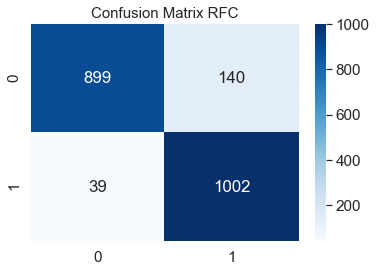

In [62]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix RFC', fontdict=title_font);
plt.savefig('plot_RFC_1.png', dpi=300, bbox_inches='tight')

In [63]:
# Different hyperparameters for our RandomForest model
dtc_grid =  {'min_samples_split': [25, 29],
             'min_samples_leaf': [2, 3],
             'max_leaf_nodes': np.arange(95, 97, 1),
             'max_depth': np.arange(80, 82, 1),
             'criterion': ["entropy"]}

# Setup grid hyperparameter search for LogisticRegression
gs_dtc = GridSearchCV(DecisionTreeClassifier(),
                      param_grid=dtc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': array([80, 81]),
                         'max_leaf_nodes': array([95, 96]),
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [25, 29]},
             verbose=True)

In [64]:
# Check the best hyperparameters
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 80,
 'max_leaf_nodes': 95,
 'min_samples_leaf': 3,
 'min_samples_split': 25}

In [65]:
# Evaluate the grid search LogisticRegression model
gs_dtc.score(x_test, y_test)

0.9052884615384615

In [66]:
y_preds = gs_dtc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.9052884615384615
0.8619210977701544
0.9654178674351584
0.9107385591300409


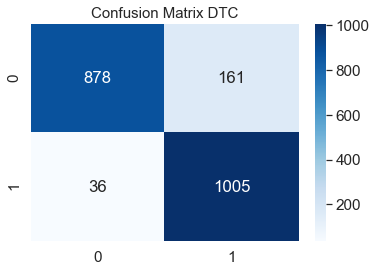

In [67]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix DTC', fontdict=title_font);
plt.savefig('plot_DTC_1.png', dpi=300, bbox_inches='tight')

In [68]:
# Different hyperparameters for our XGB model
xgb_grid =  {'verbosity': [1], 
             'n_estimators': [850], 
             'max_depth': [74, 75], 
             'subsample': [0.4, 0.5],
             'learning_rate': [0.1, 0.12],
             'min_child_weight': [1],
             'colsample_bytree': [0.5]}


# Setup grid hyperparameter search for XGB
gs_xgb = GridSearchCV(XGBClassifier(),
                      param_grid=xgb_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5],
                         'learning_rate': [0.1, 0.12], 'max_depth': [74, 75],
                         'min_child_weight': [1], 'n_estimators': [850],
                         'subsample': [0.4, 0.5], 'verbosity': [1]},
             verbose=True)

In [69]:
# Check the best hyperparameters
gs_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.12,
 'max_depth': 74,
 'min_child_weight': 1,
 'n_estimators': 850,
 'subsample': 0.5,
 'verbosity': 1}

In [70]:
# Evaluate the grid search LogisticRegression model
gs_xgb.score(x_test, y_test)

0.9778846153846154

In [71]:
y_preds = gs_xgb.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.9778846153846154
0.9697828139754485
0.9865513928914506
0.9780952380952381


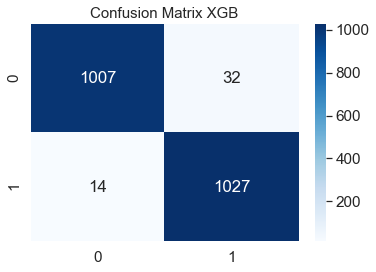

In [72]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix XGB', fontdict=title_font);
plt.savefig('plot_XGB_1.png', dpi=300, bbox_inches='tight')

In [74]:
# Different hyperparameters for our CatBoost model
cbc_grid = {'thread_count': [4],
            'learning_rate': [0.2],
            'l2_leaf_reg': [10, 11],
            'iterations': [500],
            'depth': [8, 9],
            'border_count': [200]}

# Setup grid hyperparameter search for CatBoost Model
gs_cbc = GridSearchCV(CatBoostClassifier(),
                      param_grid = cbc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_cbc.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.5369418	total: 23.1ms	remaining: 11.5s
1:	learn: 0.4496748	total: 39ms	remaining: 9.72s
2:	learn: 0.4074370	total: 56.1ms	remaining: 9.3s
3:	learn: 0.3755910	total: 72.1ms	remaining: 8.94s
4:	learn: 0.3586346	total: 89.1ms	remaining: 8.82s
5:	learn: 0.3366839	total: 105ms	remaining: 8.64s
6:	learn: 0.3268539	total: 120ms	remaining: 8.47s
7:	learn: 0.3174303	total: 136ms	remaining: 8.38s
8:	learn: 0.3112104	total: 152ms	remaining: 8.28s
9:	learn: 0.3010203	total: 168ms	remaining: 8.23s
10:	learn: 0.2907331	total: 184ms	remaining: 8.19s
11:	learn: 0.2813877	total: 200ms	remaining: 8.15s
12:	learn: 0.2766878	total: 217ms	remaining: 8.12s
13:	learn: 0.2719488	total: 237ms	remaining: 8.23s
14:	learn: 0.2649955	total: 256ms	remaining: 8.28s
15:	learn: 0.2563969	total: 273ms	remaining: 8.27s
16:	learn: 0.2484923	total: 290ms	remaining: 8.25s
17:	learn: 0.2449174	total: 307ms	remaining: 8.23s
18:	learn: 0.2426376	total: 32

160:	learn: 0.0497816	total: 3.44s	remaining: 7.25s
161:	learn: 0.0494881	total: 3.46s	remaining: 7.23s
162:	learn: 0.0489356	total: 3.48s	remaining: 7.21s
163:	learn: 0.0487773	total: 3.5s	remaining: 7.18s
164:	learn: 0.0484687	total: 3.53s	remaining: 7.16s
165:	learn: 0.0482375	total: 3.55s	remaining: 7.14s
166:	learn: 0.0479759	total: 3.57s	remaining: 7.12s
167:	learn: 0.0478290	total: 3.59s	remaining: 7.09s
168:	learn: 0.0476725	total: 3.61s	remaining: 7.07s
169:	learn: 0.0473590	total: 3.63s	remaining: 7.05s
170:	learn: 0.0468753	total: 3.65s	remaining: 7.03s
171:	learn: 0.0466346	total: 3.68s	remaining: 7.01s
172:	learn: 0.0465703	total: 3.7s	remaining: 6.99s
173:	learn: 0.0465646	total: 3.72s	remaining: 6.97s
174:	learn: 0.0465361	total: 3.74s	remaining: 6.94s
175:	learn: 0.0461272	total: 3.76s	remaining: 6.92s
176:	learn: 0.0458839	total: 3.78s	remaining: 6.9s
177:	learn: 0.0454162	total: 3.81s	remaining: 6.89s
178:	learn: 0.0452147	total: 3.83s	remaining: 6.86s
179:	learn: 0.0

320:	learn: 0.0229792	total: 6.59s	remaining: 3.67s
321:	learn: 0.0228878	total: 6.61s	remaining: 3.65s
322:	learn: 0.0228878	total: 6.62s	remaining: 3.63s
323:	learn: 0.0227849	total: 6.64s	remaining: 3.61s
324:	learn: 0.0226661	total: 6.66s	remaining: 3.58s
325:	learn: 0.0225661	total: 6.67s	remaining: 3.56s
326:	learn: 0.0225356	total: 6.69s	remaining: 3.54s
327:	learn: 0.0224889	total: 6.71s	remaining: 3.52s
328:	learn: 0.0224324	total: 6.73s	remaining: 3.5s
329:	learn: 0.0223213	total: 6.75s	remaining: 3.47s
330:	learn: 0.0222239	total: 6.76s	remaining: 3.45s
331:	learn: 0.0221481	total: 6.78s	remaining: 3.43s
332:	learn: 0.0221481	total: 6.8s	remaining: 3.41s
333:	learn: 0.0221481	total: 6.81s	remaining: 3.38s
334:	learn: 0.0220369	total: 6.83s	remaining: 3.36s
335:	learn: 0.0219514	total: 6.85s	remaining: 3.34s
336:	learn: 0.0219514	total: 6.86s	remaining: 3.32s
337:	learn: 0.0219151	total: 6.88s	remaining: 3.3s
338:	learn: 0.0218677	total: 6.89s	remaining: 3.27s
339:	learn: 0.0

490:	learn: 0.0155653	total: 9.42s	remaining: 173ms
491:	learn: 0.0155652	total: 9.44s	remaining: 153ms
492:	learn: 0.0155615	total: 9.45s	remaining: 134ms
493:	learn: 0.0155614	total: 9.46s	remaining: 115ms
494:	learn: 0.0155614	total: 9.48s	remaining: 95.8ms
495:	learn: 0.0155614	total: 9.5s	remaining: 76.6ms
496:	learn: 0.0155611	total: 9.51s	remaining: 57.4ms
497:	learn: 0.0155611	total: 9.52s	remaining: 38.3ms
498:	learn: 0.0155611	total: 9.54s	remaining: 19.1ms
499:	learn: 0.0155578	total: 9.55s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000021697E4A608>,
             n_jobs=-1,
             param_grid={'border_count': [200], 'depth': [8, 9],
                         'iterations': [500], 'l2_leaf_reg': [10, 11],
                         'learning_rate': [0.2], 'thread_count': [4]},
             verbose=True)

In [75]:
# Check the best hyperparameters
gs_cbc.best_params_

{'border_count': 200,
 'depth': 8,
 'iterations': 500,
 'l2_leaf_reg': 10,
 'learning_rate': 0.2,
 'thread_count': 4}

In [76]:
# Evaluate the grid search LogisticRegression model
gs_cbc.score(x_test, y_test)

0.9778846153846154

In [77]:
y_preds = gs_cbc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.9778846153846154
0.9688972667295005
0.9875120076849183
0.978116079923882


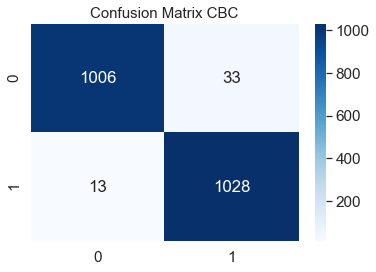

In [78]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix CBC', fontdict=title_font);
plt.savefig('plot_CBC_1.png', dpi=300, bbox_inches='tight')

# Confusion Matrix for All the Models Using the Best Hyper Parameters

In [79]:
# # All the models using best hyperparameters

# models = {
#     'Random Forest Classifier': RandomForestClassifier( bootstrap = False, 
#                                                         max_depth = None,
#                                                         min_samples_leaf = 1,
#                                                         min_samples_split = 7,
#                                                         n_estimators = 150),
    
#     'Decision Tree Classifier': DecisionTreeClassifier(criterion = "entropy",
#                                                        max_depth = 80,
#                                                        max_leaf_nodes = 96,
#                                                        min_samples_leaf = 3,
#                                                        min_samples_split = 27), 
    
#     'XG Boost Classifier': XGBClassifier(colsample_bytree = 0.5,
#                                          learning_rate = 0.1,
#                                          max_depth = 74,
#                                          min_child_weight = 1,
#                                          n_estimators = 850,
#                                          subsample = 0.5,
#                                          verbosity = 1),
    
#     'Cat Boost Classifier': CatBoostClassifier(border_count = 200,
#                                                depth = 8,
#                                                iterations = 500,
#                                                l2_leaf_reg = 11,
#                                                learning_rate = 0.2,
#                                                thread_count = 4)
# }

In [80]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1.5)

# def plot_conf_mat(y_test, y_preds, model):
    
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax = sns.heatmap(confusion_matrix(y_test, y_preds),
#                      annot=True,
#                      cbar=False)
#     plt.xlabel("True Label")
#     plt.ylabel(f'Predicted Label using {model}')

# for key, value in models.items():
#     model = value
#     model.fit(X_train, Y_train)
#     y_preds = model.predict(x_test)
#     plot_conf_mat(y_test, y_preds, key)

In [81]:
# from cf_matrix import make_confusion_matrix

# labels = ['True Neg','False Pos','False Neg','True Pos']
# categories = ['Zero', 'One']
# make_confusion_matrix(confusion_matrix(y_test, y_preds), group_names=labels, categories=categories, cmap="viridis", title='My Two-class CF Matrix')

In [82]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1.5)

# def plot_conf_mat(y_test, y_preds):
    
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax = sns.heatmap(confusion_matrix(y_test, y_preds),
#                      annot=True,
#                      cbar=False)
#     plt.xlabel("True Label")
#     plt.ylabel("Predicted Label using RFC")
    
# plot_conf_mat(y_test, y_preds)

In [83]:
# # Plot ROC curve and calculate AUC metric
# plot_roc_curve(rs_rfc, x_test, y_test)